/content/drive/MyDrive/IDRiD/A.%20Segmentation/A. Segmentation

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import glob
import argparse
import json
import random
from datetime import datetime
from collections import defaultdict
from typing import Dict, List, Tuple, Optional

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import ndimage

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Config:
    """Global configuration"""

    # Dataset paths
    DATA_ROOT = "/content/drive/MyDrive/IDRiD/A.%20Segmentation/A. Segmentation"
    TRAIN_IMAGES = os.path.join(DATA_ROOT, "1. Original Images", "a. Training Set")
    TEST_IMAGES = os.path.join(DATA_ROOT, "1. Original Images", "b. Testing Set")
    TRAIN_MASKS = os.path.join(DATA_ROOT, "2. All Segmentation Groundtruths", "a. Training Set")
    TEST_MASKS = os.path.join(DATA_ROOT, "2. All Segmentation Groundtruths", "b. Testing Set")

    # Lesion types
    LESION_TYPES = {
        1: "Microaneurysms",
        2: "Haemorrhages",
        3: "Hard Exudates",
        4: "Soft Exudates",
    }

    LESION_ABBREV = {1: "MA", 2: "HE", 3: "EX", 4: "SE"}

    # Patch-based training
    USE_PATCHES = True
    PATCH_SIZE = 256
    OVERLAP = 64

    # Sampling strategy
    LESION_PATCH_RATIO = 0.7
    MIN_LESION_PIXELS = 10

    # Model parameters
    IMG_SIZE = 1024
    PATCH_BATCH_SIZE = 16
    NUM_WORKERS = 4
    NUM_EPOCHS = 80
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5

    # Training settings
    EARLY_STOPPING_PATIENCE = 20
    REDUCE_LR_PATIENCE = 8
    REDUCE_LR_FACTOR = 0.5
    MIN_LR = 1e-7
    WARMUP_EPOCHS = 3

    # Loss function
    LOSS_TYPE = "focal_dice"
    FOCAL_ALPHA = 0.25
    FOCAL_GAMMA = 2.0
    TVERSKY_ALPHA = 0.7
    TVERSKY_BETA = 0.3

    # Preprocessing
    USE_CLAHE = True
    CLAHE_CLIP_LIMIT = 2.0
    CLAHE_TILE_GRID_SIZE = (8, 8)

    # Post-processing
    USE_POST_PROCESSING = True
    THRESHOLD = 0.4
    MIN_OBJECT_SIZE = 10
    MORPHOLOGY_KERNEL_SIZE = 3

    # Cross-validation
    USE_KFOLD = True
    NUM_FOLDS = 5

    # Output directories
    OUTPUT_DIR = "idrid_improved_outputs"
    CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, "checkpoints")
    RESULTS_DIR = os.path.join(OUTPUT_DIR, "results")
    PREDICTIONS_DIR = os.path.join(OUTPUT_DIR, "predictions")
    VISUALIZATIONS_DIR = os.path.join(OUTPUT_DIR, "visualizations")

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    USE_AMP = True

    @staticmethod
    def create_dirs():
        """Create output directories"""
        for dir_path in [Config.OUTPUT_DIR, Config.CHECKPOINT_DIR,
                        Config.RESULTS_DIR, Config.PREDICTIONS_DIR,
                        Config.VISUALIZATIONS_DIR]:
            os.makedirs(dir_path, exist_ok=True)

    @staticmethod
    def print_config(lesion_type: int = None):
        """Print configuration"""
        print("\n" + "=" * 80)
        print("IMPROVED CONFIGURATION")
        print("=" * 80)
        print(f"Device: {Config.DEVICE}")
        print(f"Patch-based Training: {Config.USE_PATCHES}")
        if Config.USE_PATCHES:
            print(f"  - Patch Size: {Config.PATCH_SIZE}x{Config.PATCH_SIZE}")
            print(f"  - Lesion/Background Ratio: {Config.LESION_PATCH_RATIO:.1%}/{1-Config.LESION_PATCH_RATIO:.1%}")
        print(f"Image Size: {Config.IMG_SIZE}")
        print(f"Batch Size: {Config.PATCH_BATCH_SIZE}")
        print(f"Learning Rate: {Config.LEARNING_RATE}")
        print(f"Loss Function: {Config.LOSS_TYPE.upper()}")
        print(f"Post-Processing: {Config.USE_POST_PROCESSING}")
        if lesion_type:
            print(f"\nTraining Lesion: {Config.LESION_TYPES[lesion_type]}")
        print("=" * 80 + "\n")

In [ ]:
class ImagePreprocessor:
    """Image preprocessing utilities"""

    @staticmethod
    def apply_clahe(image: np.ndarray, clip_limit: float = 2.0,
                    tile_grid_size: Tuple[int, int] = (8, 8)) -> np.ndarray:
        """Apply CLAHE enhancement"""
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge([l_clahe, a, b])
        enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
        return enhanced


In [ ]:
class PatchExtractor:
    """Extract patches from images for training"""

    def __init__(self, patch_size: int = 256, lesion_ratio: float = 0.7,
                 min_lesion_pixels: int = 10):
        self.patch_size = patch_size
        self.lesion_ratio = lesion_ratio
        self.min_lesion_pixels = min_lesion_pixels

    def extract_patches(self, image: np.ndarray, mask: np.ndarray,
                       num_patches: int = 50) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """Extract patches from image and mask"""
        h, w = image.shape[:2]
        ps = self.patch_size

        lesion_coords = np.argwhere(mask > 0)
        has_lesions = len(lesion_coords) > 0

        image_patches = []
        mask_patches = []

        num_lesion_patches = int(num_patches * self.lesion_ratio) if has_lesions else 0
        num_bg_patches = num_patches - num_lesion_patches

        # Extract lesion-centered patches
        if has_lesions and num_lesion_patches > 0:
            for _ in range(num_lesion_patches):
                idx = np.random.randint(0, len(lesion_coords))
                center_y, center_x = lesion_coords[idx]

                y1 = max(0, center_y - ps // 2)
                x1 = max(0, center_x - ps // 2)
                y2 = min(h, y1 + ps)
                x2 = min(w, x1 + ps)

                if y2 - y1 < ps:
                    y1 = max(0, y2 - ps)
                if x2 - x1 < ps:
                    x1 = max(0, x2 - ps)

                img_patch = image[y1:y2, x1:x2]
                mask_patch = mask[y1:y2, x1:x2]

                if img_patch.shape[:2] == (ps, ps):
                    image_patches.append(img_patch)
                    mask_patches.append(mask_patch)

        # Extract background patches
        for _ in range(num_bg_patches):
            y1 = np.random.randint(0, max(1, h - ps))
            x1 = np.random.randint(0, max(1, w - ps))
            y2 = y1 + ps
            x2 = x1 + ps

            img_patch = image[y1:y2, x1:x2]
            mask_patch = mask[y1:y2, x1:x2]

            if img_patch.shape[:2] == (ps, ps):
                image_patches.append(img_patch)
                mask_patches.append(mask_patch)

        return image_patches, mask_patches

    def sliding_window_inference(self, image: np.ndarray, model: nn.Module,
                                 overlap: int = 64) -> np.ndarray:
        """Sliding window inference for full image"""
        h, w = image.shape[:2]
        ps = self.patch_size
        stride = ps - overlap

        prediction = np.zeros((h, w), dtype=np.float32)
        count_map = np.zeros((h, w), dtype=np.float32)

        device = next(model.parameters()).device
        model.eval()

        with torch.no_grad():
            for y in range(0, h - ps + 1, stride):
                for x in range(0, w - ps + 1, stride):
                    patch = image[y:y+ps, x:x+ps]

                    transform = get_validation_augmentation(ps)
                    transformed = transform(image=patch)
                    patch_tensor = transformed['image'].unsqueeze(0).to(device)

                    output = model(patch_tensor)
                    output = torch.sigmoid(output).cpu().numpy()[0, 0]

                    prediction[y:y+ps, x:x+ps] += output
                    count_map[y:y+ps, x:x+ps] += 1

            # Handle edges
            if h % stride != 0:
                y = h - ps
                for x in range(0, w - ps + 1, stride):
                    patch = image[y:y+ps, x:x+ps]
                    transform = get_validation_augmentation(ps)
                    transformed = transform(image=patch)
                    patch_tensor = transformed['image'].unsqueeze(0).to(device)
                    output = model(patch_tensor)
                    output = torch.sigmoid(output).cpu().numpy()[0, 0]
                    prediction[y:y+ps, x:x+ps] += output
                    count_map[y:y+ps, x:x+ps] += 1

            if w % stride != 0:
                x = w - ps
                for y in range(0, h - ps + 1, stride):
                    patch = image[y:y+ps, x:x+ps]
                    transform = get_validation_augmentation(ps)
                    transformed = transform(image=patch)
                    patch_tensor = transformed['image'].unsqueeze(0).to(device)
                    output = model(patch_tensor)
                    output = torch.sigmoid(output).cpu().numpy()[0, 0]
                    prediction[y:y+ps, x:x+ps] += output
                    count_map[y:y+ps, x:x+ps] += 1

        prediction = prediction / np.maximum(count_map, 1)
        return prediction

In [ ]:
class IDRiDPatchDataset(Dataset):
    """IDRiD Patch-Based Dataset for single lesion type"""

    def __init__(self, image_paths: List[str], mask_dir: str,
                 lesion_type: int, transform: Optional[A.Compose] = None,
                 use_clahe: bool = True, num_patches_per_image: int = 50):
        self.image_paths = image_paths
        self.mask_dir = mask_dir
        self.lesion_type = lesion_type
        self.lesion_name = Config.LESION_TYPES[lesion_type]
        self.transform = transform
        self.use_clahe = use_clahe
        self.num_patches_per_image = num_patches_per_image
        self.preprocessor = ImagePreprocessor()
        self.patch_extractor = PatchExtractor(
            Config.PATCH_SIZE, Config.LESION_PATCH_RATIO, Config.MIN_LESION_PIXELS)

        self.patches = []
        self._prepare_patches()

    def _get_mask_path(self, image_id: str) -> Optional[str]:
        """Get mask path for specific lesion"""
        patterns = [
            os.path.join(self.mask_dir, f"{self.lesion_type}. {self.lesion_name}",
                        f"{image_id}_{Config.LESION_ABBREV[self.lesion_type]}.tif"),
            os.path.join(self.mask_dir, f"{self.lesion_type}. {self.lesion_name}",
                        f"{image_id}.tif"),
        ]

        for pattern in patterns:
            if os.path.exists(pattern):
                return pattern
        return None

    def _prepare_patches(self):
        """Pre-extract patches from all images"""
        print(f"Extracting patches for {self.lesion_name}...")

        for image_path in tqdm(self.image_paths):
            image_id = os.path.splitext(os.path.basename(image_path))[0]

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (Config.IMG_SIZE, Config.IMG_SIZE))

            if self.use_clahe:
                image = self.preprocessor.apply_clahe(image)

            mask_path = self._get_mask_path(image_id)
            if mask_path and os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask is not None:
                    mask = cv2.resize(mask, (Config.IMG_SIZE, Config.IMG_SIZE),
                                    interpolation=cv2.INTER_NEAREST)
                    mask = (mask > 0).astype(np.uint8) * 255
                else:
                    mask = np.zeros((Config.IMG_SIZE, Config.IMG_SIZE), dtype=np.uint8)
            else:
                mask = np.zeros((Config.IMG_SIZE, Config.IMG_SIZE), dtype=np.uint8)

            img_patches, mask_patches = self.patch_extractor.extract_patches(
                image, mask, self.num_patches_per_image)

            for img_p, mask_p in zip(img_patches, mask_patches):
                self.patches.append({
                    'image': img_p,
                    'mask': mask_p,
                    'image_id': image_id,
                    'has_lesion': mask_p.sum() > Config.MIN_LESION_PIXELS
                })

        print(f"✓ Extracted {len(self.patches)} patches")
        lesion_patches = sum(1 for p in self.patches if p['has_lesion'])
        print(f"  - Lesion patches: {lesion_patches} ({lesion_patches/len(self.patches)*100:.1f}%)")
        print(f"  - Background patches: {len(self.patches) - lesion_patches}")

    def __len__(self) -> int:
        return len(self.patches)

    def __getitem__(self, idx: int) -> Dict:
        patch_data = self.patches[idx]
        image = patch_data['image'].copy()
        mask = patch_data['mask'].copy()

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        if len(mask.shape) == 3:
            mask = mask[:, :, 0]

        mask = mask.float() / 255.0
        mask = mask.unsqueeze(0)

        return {
            'image': image,
            'mask': mask,
            'image_id': patch_data['image_id'],
            'has_lesion': patch_data['has_lesion']
        }

In [ ]:
def get_training_augmentation(patch_size: int = 256) -> A.Compose:
    """Heavy augmentation for patches"""
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=45,
                          border_mode=cv2.BORDER_CONSTANT, value=0, p=0.7),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50,
                          border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5),
        A.GridDistortion(p=0.3),
        A.OpticalDistortion(distort_limit=0.3, shift_limit=0.3, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
        A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=25, val_shift_limit=15, p=0.5),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
        A.OneOf([
            A.GaussianBlur(blur_limit=3, p=1.0),
            A.MedianBlur(blur_limit=3, p=1.0),
            A.MotionBlur(blur_limit=3, p=1.0),
        ], p=0.4),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])


def get_validation_augmentation(patch_size: int = 256) -> A.Compose:
    """Validation augmentation"""
    return A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    """U-Net for binary segmentation"""
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [ ]:
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred_logits, target):
        bce_loss_unreduced = F.binary_cross_entropy_with_logits(pred_logits, target, reduction='none')
        pred_sigmoid = torch.sigmoid(pred_logits)
        pt = pred_sigmoid * target + (1 - pred_sigmoid) * (1 - target)
        pt = pt.view(-1)
        target_flat = target.view(-1)
        bce_loss_flat = bce_loss_unreduced.view(-1)
        alpha_factor = target_flat * self.alpha + (1 - target_flat) * (1 - self.alpha)
        modulating_factor = (1 - pt) ** self.gamma
        focal_loss = alpha_factor * modulating_factor * bce_loss_flat
        return focal_loss.mean()


class DiceLoss(nn.Module):
    """Dice Loss"""
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.contiguous().view(-1)
        target = target.contiguous().view(-1)
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice


class TverskyLoss(nn.Module):
    """Tversky Loss"""
    def __init__(self, alpha=0.7, beta=0.3, smooth=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.contiguous().view(-1)
        target = target.contiguous().view(-1)
        tp = (pred * target).sum()
        fp = (pred * (1 - target)).sum()
        fn = ((1 - pred) * target).sum()
        tversky = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky


class FocalTverskyLoss(nn.Module):
    """Focal Tversky Loss"""
    def __init__(self, alpha=0.7, beta=0.3, gamma=1.33, smooth=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.contiguous().view(-1)
        target = target.contiguous().view(-1)
        tp = (pred * target).sum()
        fp = (pred * (1 - target)).sum()
        fn = ((1 - pred) * target).sum()
        tversky = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        focal_tversky = (1 - tversky) ** self.gamma
        return focal_tversky


class CombinedLoss(nn.Module):
    """Combined Loss based on config"""
    def __init__(self, loss_type="focal_dice"):
        super().__init__()
        self.loss_type = loss_type

        if loss_type == "focal_dice":
            self.focal = FocalLoss(Config.FOCAL_ALPHA, Config.FOCAL_GAMMA)
            self.dice = DiceLoss()
        elif loss_type == "tversky":
            self.tversky = TverskyLoss(Config.TVERSKY_ALPHA, Config.TVERSKY_BETA)
        elif loss_type == "focal_tversky":
            self.focal_tversky = FocalTverskyLoss(Config.TVERSKY_ALPHA, Config.TVERSKY_BETA)

    def forward(self, pred, target):
        if self.loss_type == "focal_dice":
            return self.focal(pred, target) + self.dice(pred, target)
        elif self.loss_type == "tversky":
            return self.tversky(pred, target)
        elif self.loss_type == "focal_tversky":
            return self.focal_tversky(pred, target)


In [ ]:
class Metrics:
    """Enhanced metrics"""

    @staticmethod
    def calculate_all(pred: torch.Tensor, target: torch.Tensor,
                     threshold: float = 0.5) -> Dict[str, float]:
        """Calculate all metrics at once"""
        pred_binary = (torch.sigmoid(pred) > threshold).float()
        pred_binary = pred_binary.view(-1)
        target = target.view(-1)

        tp = (pred_binary * target).sum().item()
        tn = ((1 - pred_binary) * (1 - target)).sum().item()
        fp = (pred_binary * (1 - target)).sum().item()
        fn = ((1 - pred_binary) * target).sum().item()

        # Dice
        dice = (2 * tp + 1e-8) / (2 * tp + fp + fn + 1e-8)

        # IoU
        iou = (tp + 1e-8) / (tp + fp + fn + 1e-8)

        # Sensitivity (Recall)
        sensitivity = (tp + 1e-8) / (tp + fn + 1e-8)

        # Specificity
        specificity = (tn + 1e-8) / (tn + fp + 1e-8)

        # Precision
        precision = (tp + 1e-8) / (tp + fp + 1e-8)

        # F1 Score
        f1 = 2 * precision * sensitivity / (precision + sensitivity + 1e-8)

        return {
            'dice': dice,
            'iou': iou,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'f1': f1
        }

In [ ]:
class Metrics:
    """Enhanced metrics"""

    @staticmethod
    def calculate_all(pred: torch.Tensor, target: torch.Tensor,
                     threshold: float = 0.5) -> Dict[str, float]:
        """Calculate all metrics at once"""
        pred_binary = (torch.sigmoid(pred) > threshold).float()
        pred_binary = pred_binary.view(-1)
        target = target.view(-1)

        tp = (pred_binary * target).sum().item()
        tn = ((1 - pred_binary) * (1 - target)).sum().item()
        fp = (pred_binary * (1 - target)).sum().item()
        fn = ((1 - pred_binary) * target).sum().item()

        dice = (2 * tp + 1e-8) / (2 * tp + fp + fn + 1e-8)
        iou = (tp + 1e-8) / (tp + fp + fn + 1e-8)
        sensitivity = (tp + 1e-8) / (tp + fn + 1e-8)
        specificity = (tn + 1e-8) / (tn + fp + 1e-8)
        precision = (tp + 1e-8) / (tp + fp + 1e-8)
        f1 = 2 * precision * sensitivity / (precision + sensitivity + 1e-8)

        return {
            'dice': dice,
            'iou': iou,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'f1': f1
        }

In [ ]:
class PostProcessor:
    """Post-processing for predictions"""

    @staticmethod
    def apply(prediction: np.ndarray, threshold: float = 0.4,
             min_size: int = 10, kernel_size: int = 3) -> np.ndarray:
        """Apply post-processing"""
        binary = (prediction > threshold).astype(np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)

        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] < min_size:
                binary[labels == i] = 0

        return binary

In [ ]:
class Trainer:
    """Training engine"""

    def __init__(self, model, criterion, optimizer, scheduler, device, config):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.config = config
        self.scaler = torch.cuda.amp.GradScaler() if config.USE_AMP else None
        self.metrics = Metrics()
        self.best_val_dice = 0.0
        self.best_val_sensitivity = 0.0
        self.epochs_no_improve = 0

    def train_epoch(self, dataloader) -> Dict[str, float]:
        self.model.train()
        running_loss = 0.0
        all_metrics = defaultdict(list)

        pbar = tqdm(dataloader, desc="Training")
        for batch in pbar:
            images = batch['image'].to(self.device)
            masks = batch['mask'].to(self.device)

            self.optimizer.zero_grad()

            if self.config.USE_AMP:
                with torch.cuda.amp.autocast():
                    outputs = self.model(images)
                    loss = self.criterion(outputs, masks)

                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()

            if torch.isnan(loss):
                continue

            batch_metrics = self.metrics.calculate_all(outputs, masks)
            running_loss += loss.item()
            for k, v in batch_metrics.items():
                all_metrics[k].append(v)

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{batch_metrics["dice"]:.4f}',
                'sens': f'{batch_metrics["sensitivity"]:.4f}'
            })

        epoch_metrics = {k: np.mean(v) for k, v in all_metrics.items()}
        epoch_metrics['loss'] = running_loss / len(dataloader)
        return epoch_metrics

    def validate(self, dataloader) -> Dict[str, float]:
        self.model.eval()
        running_loss = 0.0
        all_metrics = defaultdict(list)

        with torch.no_grad():
            pbar = tqdm(dataloader, desc="Validation")
            for batch in pbar:
                images = batch['image'].to(self.device)
                masks = batch['mask'].to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)

                batch_metrics = self.metrics.calculate_all(outputs, masks)
                running_loss += loss.item()
                for k, v in batch_metrics.items():
                    all_metrics[k].append(v)

                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'dice': f'{batch_metrics["dice"]:.4f}',
                    'sens': f'{batch_metrics["sensitivity"]:.4f}'
                })

        epoch_metrics = {k: np.mean(v) for k, v in all_metrics.items()}
        epoch_metrics['loss'] = running_loss / len(dataloader)
        return epoch_metrics

    def save_checkpoint(self, epoch, val_metrics, lesion_type, fold=None):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_metrics': val_metrics,
            'lesion_type': lesion_type,
        }
        fold_str = f"_fold{fold}" if fold is not None else ""
        filename = f'best_model_lesion{lesion_type}{fold_str}.pth'
        filepath = os.path.join(Config.CHECKPOINT_DIR, filename)
        torch.save(checkpoint, filepath)
        print(f"✓ Checkpoint saved: {filename}")

    def train(self, train_loader, val_loader, lesion_type, fold=None):
        history = defaultdict(list)

        for epoch in range(self.config.NUM_EPOCHS):
            print(f"\nEpoch {epoch+1}/{self.config.NUM_EPOCHS}")

            train_metrics = self.train_epoch(train_loader)
            val_metrics = self.validate(val_loader)

            for k, v in train_metrics.items():
                history[f'train_{k}'].append(v)
            for k, v in val_metrics.items():
                history[f'val_{k}'].append(v)

            print(f"Train - Loss: {train_metrics['loss']:.4f}, Dice: {train_metrics['dice']:.4f}, "
                  f"Sensitivity: {train_metrics['sensitivity']:.4f}")
            print(f"Val   - Loss: {val_metrics['loss']:.4f}, Dice: {val_metrics['dice']:.4f}, "
                  f"Sensitivity: {val_metrics['sensitivity']:.4f}")

            self.scheduler.step(val_metrics['loss'])
            current_lr = self.optimizer.param_groups[0]['lr']
            print(f"LR: {current_lr:.6f}")

            improved = False
            if val_metrics['dice'] > self.best_val_dice:
                self.best_val_dice = val_metrics['dice']
                improved = True
            if val_metrics['sensitivity'] > self.best_val_sensitivity:
                self.best_val_sensitivity = val_metrics['sensitivity']
                improved = True

            if improved:
                self.save_checkpoint(epoch, val_metrics, lesion_type, fold)
                self.epochs_no_improve = 0
                print(f"★ New best! Dice: {self.best_val_dice:.4f}, Sensitivity: {self.best_val_sensitivity:.4f}")
            else:
                self.epochs_no_improve += 1

            if self.epochs_no_improve >= self.config.EARLY_STOPPING_PATIENCE:
                print(f"Early stopping at epoch {epoch+1}")
                break

        return history

In [ ]:
class InferenceEngine:
    """Inference engine with sliding window"""

    def __init__(self, model_path: str):
        self.device = Config.DEVICE
        self.patch_extractor = PatchExtractor(Config.PATCH_SIZE)
        self.post_processor = PostProcessor()

        self.model = UNet(n_channels=3, n_classes=1)
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.model.eval()

        self.lesion_type = checkpoint.get('lesion_type', 1)

        print(f"✓ Model loaded: {os.path.basename(model_path)}")
        print(f"  Lesion: {Config.LESION_TYPES[self.lesion_type]}")
        print(f"  Dice: {checkpoint['val_metrics']['dice']:.4f}")
        print(f"  Sensitivity: {checkpoint['val_metrics']['sensitivity']:.4f}")

    def predict(self, image_path: str, use_post_processing: bool = True) -> np.ndarray:
        """Predict single image using sliding window"""
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = image.shape[:2]

        image = cv2.resize(image, (Config.IMG_SIZE, Config.IMG_SIZE))

        if Config.USE_CLAHE:
            preprocessor = ImagePreprocessor()
            image = preprocessor.apply_clahe(image)

        prediction = self.patch_extractor.sliding_window_inference(
            image, self.model, Config.OVERLAP)

        if use_post_processing and Config.USE_POST_PROCESSING:
            prediction = self.post_processor.apply(
                prediction, Config.THRESHOLD, Config.MIN_OBJECT_SIZE,
                Config.MORPHOLOGY_KERNEL_SIZE)

        prediction = cv2.resize(prediction, (original_size[1], original_size[0]),
                              interpolation=cv2.INTER_LINEAR)

        return prediction

In [ ]:
class Visualizer:
    """Visualization utilities"""

    @staticmethod
    def plot_training_history(history: Dict, lesion_type: int, fold: int = None):
        """Plot training history"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle(f'{Config.LESION_TYPES[lesion_type]} - Training History', fontsize=16)

        metrics_to_plot = ['loss', 'dice', 'iou', 'sensitivity', 'specificity', 'f1']

        for idx, metric in enumerate(metrics_to_plot):
            row = idx // 3
            col = idx % 3
            ax = axes[row, col]

            train_key = f'train_{metric}'
            val_key = f'val_{metric}'

            if train_key in history:
                ax.plot(history[train_key], label='Train', marker='o', markersize=3)
            if val_key in history:
                ax.plot(history[val_key], label='Validation', marker='s', markersize=3)

            ax.set_xlabel('Epoch')
            ax.set_ylabel(metric.capitalize())
            ax.set_title(f'{metric.capitalize()}')
            ax.legend()
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        fold_str = f"_fold{fold}" if fold is not None else ""
        filename = f'training_history_lesion{lesion_type}{fold_str}.png'
        filepath = os.path.join(Config.VISUALIZATIONS_DIR, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"✓ Training history saved: {filename}")

    @staticmethod
    def visualize_predictions(image_path: str, prediction: np.ndarray,
                            ground_truth: np.ndarray = None,
                            lesion_type: int = 1):
        """Visualize predictions"""
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        num_plots = 3 if ground_truth is not None else 2
        fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 6))

        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(prediction, cmap='hot')
        axes[1].set_title('Prediction')
        axes[1].axis('off')

        if ground_truth is not None:
            axes[2].imshow(ground_truth, cmap='hot')
            axes[2].set_title('Ground Truth')
            axes[2].axis('off')

        plt.suptitle(f'{Config.LESION_TYPES[lesion_type]} Segmentation', fontsize=14)
        plt.tight_layout()

        image_id = os.path.splitext(os.path.basename(image_path))[0]
        filename = f'prediction_{Config.LESION_TYPES[lesion_type]}_{image_id}.png'
        filepath = os.path.join(Config.VISUALIZATIONS_DIR, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()

    @staticmethod
    def create_comparison_grid(test_images: List[str], predictions: Dict,
                              ground_truths: Dict, lesion_type: int, num_samples: int = 6):
        """Create comparison grid"""
        sample_ids = random.sample(list(predictions.keys()), min(num_samples, len(predictions)))

        fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)

        for idx, image_id in enumerate(sample_ids):
            image_path = [p for p in test_images if image_id in p][0]
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title(f'{image_id}')
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(predictions[image_id], cmap='hot')
            axes[idx, 1].set_title('Prediction')
            axes[idx, 1].axis('off')

            if image_id in ground_truths and ground_truths[image_id] is not None:
                axes[idx, 2].imshow(ground_truths[image_id], cmap='hot')
                axes[idx, 2].set_title('Ground Truth')
            else:
                axes[idx, 2].text(0.5, 0.5, 'No GT', ha='center', va='center')
                axes[idx, 2].set_title('Ground Truth (N/A)')
            axes[idx, 2].axis('off')

        plt.suptitle(f'{Config.LESION_TYPES[lesion_type]} - Prediction Comparison', fontsize=16)
        plt.tight_layout()

        filename = f'comparison_grid_lesion{lesion_type}.png'
        filepath = os.path.join(Config.VISUALIZATIONS_DIR, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"✓ Comparison grid saved: {filename}")


In [ ]:
class Evaluator:
    """Test set evaluation"""

    def __init__(self):
        self.metrics = Metrics()

    def evaluate_test_set(self, predictions: Dict, ground_truths: Dict,
                         lesion_type: int) -> Dict[str, float]:
        """Evaluate predictions against ground truth"""
        all_metrics = defaultdict(list)

        for image_id in predictions.keys():
            if image_id not in ground_truths or ground_truths[image_id] is None:
                continue

            pred = predictions[image_id]
            gt = ground_truths[image_id]

            # Ensure same size
            if pred.shape != gt.shape:
                pred = cv2.resize(pred, (gt.shape[1], gt.shape[0]))

            # Convert to tensors
            pred_tensor = torch.from_numpy(pred).float().unsqueeze(0).unsqueeze(0)
            gt_tensor = torch.from_numpy(gt).float().unsqueeze(0).unsqueeze(0)

            # Calculate metrics
            batch_metrics = self.metrics.calculate_all(pred_tensor, gt_tensor, Config.THRESHOLD)

            for k, v in batch_metrics.items():
                all_metrics[k].append(v)

        # Average metrics
        avg_metrics = {k: np.mean(v) for k, v in all_metrics.items()}
        std_metrics = {f'{k}_std': np.std(v) for k, v in all_metrics.items()}

        results = {**avg_metrics, **std_metrics}
        results['num_samples'] = len(all_metrics['dice'])

        return results

    def print_evaluation_results(self, results: Dict, lesion_type: int):
        """Print evaluation results"""
        print(f"\n{'='*80}")
        print(f"TEST SET EVALUATION: {Config.LESION_TYPES[lesion_type]}")
        print(f"{'='*80}")
        print(f"Samples evaluated: {results['num_samples']}")
        print(f"\nMetrics (Mean ± Std):")
        print(f"  Dice Score:    {results['dice']:.4f} ± {results['dice_std']:.4f}")
        print(f"  IoU:           {results['iou']:.4f} ± {results['iou_std']:.4f}")
        print(f"  Sensitivity:   {results['sensitivity']:.4f} ± {results['sensitivity_std']:.4f}")
        print(f"  Specificity:   {results['specificity']:.4f} ± {results['specificity_std']:.4f}")
        print(f"  Precision:     {results['precision']:.4f} ± {results['precision_std']:.4f}")
        print(f"  F1 Score:      {results['f1']:.4f} ± {results['f1_std']:.4f}")
        print(f"{'='*80}\n")

def train_single_lesion(lesion_type: int, use_kfold: bool = True):
    """Train model for single lesion type"""
    print(f"\n{'='*80}")
    print(f"TRAINING: {Config.LESION_TYPES[lesion_type]}")
    print(f"{'='*80}")

    Config.create_dirs()

    train_images = sorted(glob.glob(os.path.join(Config.TRAIN_IMAGES, "*.jpg")))

    if use_kfold:
        kfold = KFold(n_splits=Config.NUM_FOLDS, shuffle=True, random_state=42)
        fold_histories = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(train_images)):
            print(f"\n{'='*80}")
            print(f"FOLD {fold + 1}/{Config.NUM_FOLDS}")
            print(f"{'='*80}")

            train_imgs = [train_images[i] for i in train_idx]
            val_imgs = [train_images[i] for i in val_idx]

            train_dataset = IDRiDPatchDataset(
                train_imgs, Config.TRAIN_MASKS, lesion_type,
                get_training_augmentation(Config.PATCH_SIZE), Config.USE_CLAHE, 50)
            val_dataset = IDRiDPatchDataset(
                val_imgs, Config.TRAIN_MASKS, lesion_type,
                get_validation_augmentation(Config.PATCH_SIZE), Config.USE_CLAHE, 20)

            train_loader = DataLoader(train_dataset, batch_size=Config.PATCH_BATCH_SIZE,
                                    shuffle=True, num_workers=Config.NUM_WORKERS, pin_memory=True)
            val_loader = DataLoader(val_dataset, batch_size=Config.PATCH_BATCH_SIZE,
                                  shuffle=False, num_workers=Config.NUM_WORKERS, pin_memory=True)

            model = UNet(n_channels=3, n_classes=1).to(Config.DEVICE)
            criterion = CombinedLoss(Config.LOSS_TYPE)
            optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE,
                                         weight_decay=Config.WEIGHT_DECAY)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=Config.REDUCE_LR_FACTOR,
                patience=Config.REDUCE_LR_PATIENCE, min_lr=Config.MIN_LR)

            trainer = Trainer(model, criterion, optimizer, scheduler, Config.DEVICE, Config)
            history = trainer.train(train_loader, val_loader, lesion_type, fold=fold)
            fold_histories.append(history)

            # Visualize training history
            Visualizer.plot_training_history(history, lesion_type, fold)

            # Save history
            with open(os.path.join(Config.RESULTS_DIR,
                                 f'lesion{lesion_type}_fold{fold}_history.json'), 'w') as f:
                json.dump({k: [float(x) for x in v] for k, v in history.items()}, f, indent=2)

        # Summary
        print(f"\n{'='*80}")
        print(f"CROSS-VALIDATION SUMMARY: {Config.LESION_TYPES[lesion_type]}")
        print(f"{'='*80}")

        final_dice = [h['val_dice'][-1] for h in fold_histories if 'val_dice' in h and len(h['val_dice']) > 0]
        final_sens = [h['val_sensitivity'][-1] for h in fold_histories if 'val_sensitivity' in h and len(h['val_sensitivity']) > 0]
        final_spec = [h['val_specificity'][-1] for h in fold_histories if 'val_specificity' in h and len(h['val_specificity']) > 0]
        final_f1 = [h['val_f1'][-1] for h in fold_histories if 'val_f1' in h and len(h['val_f1']) > 0]

        print(f"Mean Dice:        {np.mean(final_dice):.4f} ± {np.std(final_dice):.4f}")
        print(f"Mean Sensitivity: {np.mean(final_sens):.4f} ± {np.std(final_sens):.4f}")
        print(f"Mean Specificity: {np.mean(final_spec):.4f} ± {np.std(final_spec):.4f}")
        print(f"Mean F1 Score:    {np.mean(final_f1):.4f} ± {np.std(final_f1):.4f}")
        print(f"{'='*80}\n")

        # Save summary
        summary = {
            'lesion_type': lesion_type,
            'lesion_name': Config.LESION_TYPES[lesion_type],
            'num_folds': len(fold_histories),
            'mean_dice': float(np.mean(final_dice)),
            'std_dice': float(np.std(final_dice)),
            'mean_sensitivity': float(np.mean(final_sens)),
            'std_sensitivity': float(np.std(final_sens)),
            'mean_specificity': float(np.mean(final_spec)),
            'std_specificity': float(np.std(final_spec)),
            'mean_f1': float(np.mean(final_f1)),
            'std_f1': float(np.std(final_f1)),
        }

        with open(os.path.join(Config.RESULTS_DIR,
                             f'lesion{lesion_type}_cv_summary.json'), 'w') as f:
            json.dump(summary, f, indent=2)


def train_all_lesions():
    """Train models for all lesion types"""
    all_summaries = {}

    for lesion_type in Config.LESION_TYPES.keys():
        train_single_lesion(lesion_type, Config.USE_KFOLD)

        # Load summary
        summary_file = os.path.join(Config.RESULTS_DIR, f'lesion{lesion_type}_cv_summary.json')
        if os.path.exists(summary_file):
            with open(summary_file, 'r') as f:
                all_summaries[lesion_type] = json.load(f)

    # Print overall summary
    print(f"\n{'='*80}")
    print("OVERALL TRAINING SUMMARY - ALL LESION TYPES")
    print(f"{'='*80}")
    print(f"{'Lesion Type':<25} {'Dice':<15} {'Sensitivity':<15} {'F1 Score':<15}")
    print("-" * 80)

    for lesion_type, summary in all_summaries.items():
        lesion_name = summary['lesion_name']
        dice_str = f"{summary['mean_dice']:.4f}±{summary['std_dice']:.4f}"
        sens_str = f"{summary['mean_sensitivity']:.4f}±{summary['std_sensitivity']:.4f}"
        f1_str = f"{summary['mean_f1']:.4f}±{summary['std_f1']:.4f}"
        print(f"{lesion_name:<25} {dice_str:<15} {sens_str:<15} {f1_str:<15}")

    print(f"{'='*80}\n")

    # Save overall summary
    with open(os.path.join(Config.RESULTS_DIR, 'overall_summary.json'), 'w') as f:
        json.dump(all_summaries, f, indent=2)


In [ ]:
import torch
import functools
import argparse  # Ensure argparse is available if not globally imported

# Monkey-patch torch.load to always use weights_only=False
# This addresses UnpicklingError with older/non-standard checkpoints
original_torch_load = torch.load

@functools.wraps(original_torch_load)
def patched_torch_load(*args, **kwargs):
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return original_torch_load(*args, **kwargs)

torch.load = patched_torch_load


In [ ]:
def parse_args():
    parser = argparse.ArgumentParser(
        description="IDRiD Lesion Segmentation Pipeline"
    )
    parser.add_argument(
        '--mode',
        type=str,
        default='all',
        choices=['train', 'infer', 'train_all', 'infer_all', 'all'],
        help='Pipeline mode'
    )
    parser.add_argument(
        '--lesion_type',
        type=int,
        default=1,
        choices=[1, 2, 3, 4],
        help='Lesion type (1=MA, 2=HE, 3=EX, 4=SE)'
    )

    args, _ = parser.parse_known_args()
    return args


In [ ]:
def print_header():
    print("\n" + "=" * 80)
    print("IDRiD RETINAL LESION SEGMENTATION PIPELINE")
    print("=" * 80)


def show_config(args):
    Config.print_config(
        args.lesion_type
        if args.mode not in ['train_all', 'infer_all', 'all']
        else None
    )

In [ ]:
def run_training(args):
    if args.mode == 'train':
        train_single_lesion(args.lesion_type, Config.USE_KFOLD)

    elif args.mode in ['train_all', 'all']:
        train_all_lesions()

In [ ]:
def print_summary():
    print("\n" + "=" * 80)
    print("✓ PIPELINE COMPLETED SUCCESSFULLY")
    print("=" * 80 + "\n")

    print("📁 Output files saved in:")
    print(f"  - Checkpoints:     {Config.CHECKPOINT_DIR}")
    print(f"  - Results:         {Config.RESULTS_DIR}")
    print(f"  - Predictions:     {Config.PREDICTIONS_DIR}")
    print(f"  - Visualizations:  {Config.VISUALIZATIONS_DIR}")


In [ ]:

args = parse_args()

In [ ]:
print_header()
show_config(args)


IDRiD RETINAL LESION SEGMENTATION PIPELINE

IMPROVED CONFIGURATION
Device: cuda
Patch-based Training: True
  - Patch Size: 256x256
  - Lesion/Background Ratio: 70.0%/30.0%
Image Size: 1024
Batch Size: 16
Learning Rate: 0.0001
Loss Function: FOCAL_DICE
Post-Processing: True



In [ ]:
run_training(args)


TRAINING: Microaneurysms

FOLD 1/5
Extracting patches for Microaneurysms...


100%|██████████| 43/43 [00:03<00:00, 11.76it/s]


✓ Extracted 2150 patches
  - Lesion patches: 1960 (91.2%)
  - Background patches: 190
Extracting patches for Microaneurysms...


100%|██████████| 11/11 [00:00<00:00, 11.43it/s]


✓ Extracted 220 patches
  - Lesion patches: 209 (95.0%)
  - Background patches: 11

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.9976, dice=0.0000, sens=0.0000]


Train - Loss: 1.0865, Dice: 0.0100, Sensitivity: 0.0718
Val   - Loss: 0.9760, Dice: 0.0330, Sensitivity: 0.0220
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.0330, Sensitivity: 0.0220

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.74it/s, loss=0.9952, dice=0.0044, sens=0.0023]


Train - Loss: 0.9646, Dice: 0.0528, Sensitivity: 0.0637
Val   - Loss: 0.8932, Dice: 0.1249, Sensitivity: 0.1387
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.1249, Sensitivity: 0.1387

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.8020, dice=0.2098, sens=0.1320]


Train - Loss: 0.8939, Dice: 0.1231, Sensitivity: 0.1105
Val   - Loss: 0.7295, Dice: 0.2859, Sensitivity: 0.2368
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.2859, Sensitivity: 0.2368

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.6789, dice=0.3482, sens=0.3450]


Train - Loss: 0.8467, Dice: 0.1684, Sensitivity: 0.1542
Val   - Loss: 0.6961, Dice: 0.3234, Sensitivity: 0.2897
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.3234, Sensitivity: 0.2897

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6841, dice=0.3458, sens=0.3365]


Train - Loss: 0.8141, Dice: 0.2002, Sensitivity: 0.1808
Val   - Loss: 0.6610, Dice: 0.3565, Sensitivity: 0.3392
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.3565, Sensitivity: 0.3392

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.71it/s, loss=0.6689, dice=0.3612, sens=0.3660]


Train - Loss: 0.7911, Dice: 0.2219, Sensitivity: 0.1972
Val   - Loss: 0.6449, Dice: 0.3725, Sensitivity: 0.3818
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.3725, Sensitivity: 0.3818

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=0.6833, dice=0.3486, sens=0.3561]


Train - Loss: 0.7819, Dice: 0.2298, Sensitivity: 0.2040
Val   - Loss: 0.6371, Dice: 0.3798, Sensitivity: 0.3707
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.3798, Sensitivity: 0.3818

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=0.6809, dice=0.3469, sens=0.3286]


Train - Loss: 0.7806, Dice: 0.2304, Sensitivity: 0.2031
Val   - Loss: 0.6231, Dice: 0.3922, Sensitivity: 0.3666
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.3922, Sensitivity: 0.3818

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.7015, dice=0.3256, sens=0.3108]


Train - Loss: 0.7732, Dice: 0.2383, Sensitivity: 0.2179
Val   - Loss: 0.6304, Dice: 0.3846, Sensitivity: 0.3644
LR: 0.000100

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6696, dice=0.3670, sens=0.4251]


Train - Loss: 0.7636, Dice: 0.2474, Sensitivity: 0.2183
Val   - Loss: 0.6367, Dice: 0.3800, Sensitivity: 0.3794
LR: 0.000100

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6724, dice=0.3636, sens=0.4162]


Train - Loss: 0.7624, Dice: 0.2479, Sensitivity: 0.2166
Val   - Loss: 0.6185, Dice: 0.3985, Sensitivity: 0.4291
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.3985, Sensitivity: 0.4291

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.6832, dice=0.3449, sens=0.3252]


Train - Loss: 0.7554, Dice: 0.2550, Sensitivity: 0.2258
Val   - Loss: 0.6069, Dice: 0.4092, Sensitivity: 0.4241
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4092, Sensitivity: 0.4291

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6570, dice=0.3807, sens=0.4576]


Train - Loss: 0.7516, Dice: 0.2593, Sensitivity: 0.2336
Val   - Loss: 0.6110, Dice: 0.4085, Sensitivity: 0.4838
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4092, Sensitivity: 0.4838

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.7108, dice=0.3124, sens=0.2643]


Train - Loss: 0.7563, Dice: 0.2541, Sensitivity: 0.2243
Val   - Loss: 0.6565, Dice: 0.3536, Sensitivity: 0.2928
LR: 0.000100

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.6537, dice=0.3788, sens=0.4174]


Train - Loss: 0.7514, Dice: 0.2587, Sensitivity: 0.2296
Val   - Loss: 0.5924, Dice: 0.4231, Sensitivity: 0.4598
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4231, Sensitivity: 0.4838

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6313, dice=0.3996, sens=0.4634]


Train - Loss: 0.7401, Dice: 0.2699, Sensitivity: 0.2437
Val   - Loss: 0.5791, Dice: 0.4369, Sensitivity: 0.5061
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4369, Sensitivity: 0.5061

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.6714, dice=0.3698, sens=0.4651]


Train - Loss: 0.7448, Dice: 0.2654, Sensitivity: 0.2359
Val   - Loss: 0.6018, Dice: 0.4166, Sensitivity: 0.4685
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.6500, dice=0.3812, sens=0.4176]


Train - Loss: 0.7480, Dice: 0.2619, Sensitivity: 0.2321
Val   - Loss: 0.5785, Dice: 0.4366, Sensitivity: 0.4798
LR: 0.000100

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6338, dice=0.4029, sens=0.5014]


Train - Loss: 0.7390, Dice: 0.2713, Sensitivity: 0.2463
Val   - Loss: 0.5973, Dice: 0.4209, Sensitivity: 0.5293
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4369, Sensitivity: 0.5293

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.71it/s, loss=0.6753, dice=0.3645, sens=0.4950]


Train - Loss: 0.7437, Dice: 0.2663, Sensitivity: 0.2407
Val   - Loss: 0.6413, Dice: 0.3804, Sensitivity: 0.5846
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4369, Sensitivity: 0.5846

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.6480, dice=0.3790, sens=0.3890]


Train - Loss: 0.7402, Dice: 0.2695, Sensitivity: 0.2421
Val   - Loss: 0.5773, Dice: 0.4376, Sensitivity: 0.4806
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4376, Sensitivity: 0.5846

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6453, dice=0.3928, sens=0.4726]


Train - Loss: 0.7288, Dice: 0.2810, Sensitivity: 0.2509
Val   - Loss: 0.5845, Dice: 0.4317, Sensitivity: 0.4950
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6492, dice=0.3831, sens=0.4388]


Train - Loss: 0.7301, Dice: 0.2797, Sensitivity: 0.2517
Val   - Loss: 0.5877, Dice: 0.4284, Sensitivity: 0.4852
LR: 0.000100

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.6534, dice=0.3822, sens=0.5012]


Train - Loss: 0.7262, Dice: 0.2837, Sensitivity: 0.2583
Val   - Loss: 0.6152, Dice: 0.4026, Sensitivity: 0.5637
LR: 0.000100

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6588, dice=0.3731, sens=0.3852]


Train - Loss: 0.7270, Dice: 0.2823, Sensitivity: 0.2510
Val   - Loss: 0.5939, Dice: 0.4198, Sensitivity: 0.4036
LR: 0.000100

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6451, dice=0.3860, sens=0.4557]


Train - Loss: 0.7192, Dice: 0.2904, Sensitivity: 0.2616
Val   - Loss: 0.5847, Dice: 0.4307, Sensitivity: 0.5101
LR: 0.000100

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6267, dice=0.4054, sens=0.4988]


Train - Loss: 0.7248, Dice: 0.2844, Sensitivity: 0.2538
Val   - Loss: 0.5828, Dice: 0.4319, Sensitivity: 0.5116
LR: 0.000100

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.6157, dice=0.4124, sens=0.4694]


Train - Loss: 0.7187, Dice: 0.2909, Sensitivity: 0.2607
Val   - Loss: 0.5707, Dice: 0.4428, Sensitivity: 0.4999
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4428, Sensitivity: 0.5846

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.6158, dice=0.4180, sens=0.4958]


Train - Loss: 0.7158, Dice: 0.2938, Sensitivity: 0.2637
Val   - Loss: 0.5707, Dice: 0.4453, Sensitivity: 0.5276
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4453, Sensitivity: 0.5846

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6663, dice=0.3676, sens=0.4294]


Train - Loss: 0.7145, Dice: 0.2951, Sensitivity: 0.2615
Val   - Loss: 0.5880, Dice: 0.4273, Sensitivity: 0.4995
LR: 0.000100

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6375, dice=0.3965, sens=0.4969]


Train - Loss: 0.7221, Dice: 0.2873, Sensitivity: 0.2574
Val   - Loss: 0.5849, Dice: 0.4312, Sensitivity: 0.5210
LR: 0.000100

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.72it/s, loss=0.6365, dice=0.3951, sens=0.4896]


Train - Loss: 0.7115, Dice: 0.2980, Sensitivity: 0.2747
Val   - Loss: 0.5910, Dice: 0.4234, Sensitivity: 0.5072
LR: 0.000100

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6326, dice=0.3928, sens=0.4072]


Train - Loss: 0.7068, Dice: 0.3027, Sensitivity: 0.2732
Val   - Loss: 0.5748, Dice: 0.4397, Sensitivity: 0.4890
LR: 0.000100

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=0.6194, dice=0.4211, sens=0.5450]


Train - Loss: 0.7106, Dice: 0.2986, Sensitivity: 0.2676
Val   - Loss: 0.5846, Dice: 0.4317, Sensitivity: 0.5168
LR: 0.000100

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=0.6174, dice=0.4155, sens=0.5112]


Train - Loss: 0.7095, Dice: 0.2999, Sensitivity: 0.2691
Val   - Loss: 0.5745, Dice: 0.4424, Sensitivity: 0.5824
LR: 0.000100

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=0.6439, dice=0.3932, sens=0.5597]


Train - Loss: 0.7059, Dice: 0.3033, Sensitivity: 0.2736
Val   - Loss: 0.6022, Dice: 0.4150, Sensitivity: 0.5679
LR: 0.000100

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6081, dice=0.4228, sens=0.4649]


Train - Loss: 0.7240, Dice: 0.2850, Sensitivity: 0.2496
Val   - Loss: 0.5690, Dice: 0.4462, Sensitivity: 0.5030
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4462, Sensitivity: 0.5846

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6409, dice=0.4018, sens=0.5458]


Train - Loss: 0.7039, Dice: 0.3051, Sensitivity: 0.2730
Val   - Loss: 0.6132, Dice: 0.4075, Sensitivity: 0.5959
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4462, Sensitivity: 0.5959

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.6348, dice=0.3966, sens=0.4762]


Train - Loss: 0.7068, Dice: 0.3026, Sensitivity: 0.2730
Val   - Loss: 0.5942, Dice: 0.4221, Sensitivity: 0.5268
LR: 0.000100

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6399, dice=0.3903, sens=0.4318]


Train - Loss: 0.7043, Dice: 0.3049, Sensitivity: 0.2760
Val   - Loss: 0.5961, Dice: 0.4194, Sensitivity: 0.4953
LR: 0.000100

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6145, dice=0.4145, sens=0.4794]


Train - Loss: 0.6998, Dice: 0.3093, Sensitivity: 0.2806
Val   - Loss: 0.5625, Dice: 0.4523, Sensitivity: 0.5184
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4523, Sensitivity: 0.5959

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.6114, dice=0.4203, sens=0.5072]


Train - Loss: 0.7031, Dice: 0.3059, Sensitivity: 0.2758
Val   - Loss: 0.5750, Dice: 0.4397, Sensitivity: 0.5287
LR: 0.000100

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.6046, dice=0.4268, sens=0.5289]


Train - Loss: 0.6979, Dice: 0.3112, Sensitivity: 0.2800
Val   - Loss: 0.5738, Dice: 0.4423, Sensitivity: 0.5562
LR: 0.000100

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.6035, dice=0.4247, sens=0.4862]


Train - Loss: 0.7039, Dice: 0.3054, Sensitivity: 0.2756
Val   - Loss: 0.5667, Dice: 0.4488, Sensitivity: 0.5625
LR: 0.000100

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=0.6222, dice=0.4043, sens=0.4234]


Train - Loss: 0.6990, Dice: 0.3098, Sensitivity: 0.2821
Val   - Loss: 0.5654, Dice: 0.4492, Sensitivity: 0.5222
LR: 0.000100

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.71it/s, loss=0.5868, dice=0.4431, sens=0.5001]


Train - Loss: 0.7053, Dice: 0.3039, Sensitivity: 0.2710
Val   - Loss: 0.5671, Dice: 0.4483, Sensitivity: 0.5366
LR: 0.000100

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6029, dice=0.4256, sens=0.5012]


Train - Loss: 0.6964, Dice: 0.3127, Sensitivity: 0.2808
Val   - Loss: 0.5715, Dice: 0.4429, Sensitivity: 0.5240
LR: 0.000100

Epoch 48/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.73it/s, loss=0.6409, dice=0.3897, sens=0.4290]


Train - Loss: 0.6981, Dice: 0.3107, Sensitivity: 0.2819
Val   - Loss: 0.5660, Dice: 0.4487, Sensitivity: 0.5219
LR: 0.000100

Epoch 49/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6186, dice=0.4129, sens=0.4802]


Train - Loss: 0.6969, Dice: 0.3118, Sensitivity: 0.2750
Val   - Loss: 0.5627, Dice: 0.4526, Sensitivity: 0.5319
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4526, Sensitivity: 0.5959

Epoch 50/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.72it/s, loss=0.6309, dice=0.4083, sens=0.5422]


Train - Loss: 0.6967, Dice: 0.3124, Sensitivity: 0.2834
Val   - Loss: 0.5899, Dice: 0.4270, Sensitivity: 0.5688
LR: 0.000050

Epoch 51/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6083, dice=0.4212, sens=0.4715]


Train - Loss: 0.6869, Dice: 0.3222, Sensitivity: 0.2915
Val   - Loss: 0.5534, Dice: 0.4609, Sensitivity: 0.5162
LR: 0.000050
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4609, Sensitivity: 0.5959

Epoch 52/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.6155, dice=0.4178, sens=0.5208]


Train - Loss: 0.6882, Dice: 0.3208, Sensitivity: 0.2890
Val   - Loss: 0.5809, Dice: 0.4353, Sensitivity: 0.5658
LR: 0.000050

Epoch 53/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.6079, dice=0.4231, sens=0.5072]


Train - Loss: 0.6817, Dice: 0.3274, Sensitivity: 0.3031
Val   - Loss: 0.5623, Dice: 0.4532, Sensitivity: 0.5545
LR: 0.000050

Epoch 54/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6081, dice=0.4212, sens=0.4657]


Train - Loss: 0.6809, Dice: 0.3280, Sensitivity: 0.2946
Val   - Loss: 0.5552, Dice: 0.4599, Sensitivity: 0.5421
LR: 0.000050

Epoch 55/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=0.5848, dice=0.4416, sens=0.4834]


Train - Loss: 0.6804, Dice: 0.3282, Sensitivity: 0.2912
Val   - Loss: 0.5432, Dice: 0.4699, Sensitivity: 0.5297
LR: 0.000050
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4699, Sensitivity: 0.5959

Epoch 56/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.6102, dice=0.4240, sens=0.5151]


Train - Loss: 0.6754, Dice: 0.3333, Sensitivity: 0.3011
Val   - Loss: 0.5708, Dice: 0.4465, Sensitivity: 0.5809
LR: 0.000050

Epoch 57/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6053, dice=0.4275, sens=0.5213]


Train - Loss: 0.6714, Dice: 0.3372, Sensitivity: 0.3053
Val   - Loss: 0.5684, Dice: 0.4482, Sensitivity: 0.5641
LR: 0.000050

Epoch 58/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5914, dice=0.4396, sens=0.5450]


Train - Loss: 0.6722, Dice: 0.3368, Sensitivity: 0.3054
Val   - Loss: 0.5586, Dice: 0.4572, Sensitivity: 0.5709
LR: 0.000050

Epoch 59/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6003, dice=0.4358, sens=0.5531]


Train - Loss: 0.6682, Dice: 0.3405, Sensitivity: 0.3084
Val   - Loss: 0.5646, Dice: 0.4519, Sensitivity: 0.5781
LR: 0.000050

Epoch 60/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6095, dice=0.4232, sens=0.5151]


Train - Loss: 0.6743, Dice: 0.3343, Sensitivity: 0.3009
Val   - Loss: 0.5520, Dice: 0.4639, Sensitivity: 0.5628
LR: 0.000050

Epoch 61/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6020, dice=0.4300, sens=0.5247]


Train - Loss: 0.6796, Dice: 0.3291, Sensitivity: 0.2948
Val   - Loss: 0.5514, Dice: 0.4649, Sensitivity: 0.5656
LR: 0.000050

Epoch 62/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5958, dice=0.4335, sens=0.5125]


Train - Loss: 0.6769, Dice: 0.3319, Sensitivity: 0.3023
Val   - Loss: 0.5508, Dice: 0.4636, Sensitivity: 0.5604
LR: 0.000050

Epoch 63/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.72it/s, loss=0.6028, dice=0.4287, sens=0.4926]


Train - Loss: 0.6692, Dice: 0.3396, Sensitivity: 0.3075
Val   - Loss: 0.5602, Dice: 0.4560, Sensitivity: 0.5636
LR: 0.000050

Epoch 64/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.6309, dice=0.4134, sens=0.6189]


Train - Loss: 0.6834, Dice: 0.3253, Sensitivity: 0.2952
Val   - Loss: 0.5971, Dice: 0.4233, Sensitivity: 0.6187
LR: 0.000025
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4699, Sensitivity: 0.6187

Epoch 65/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6157, dice=0.4217, sens=0.5821]


Train - Loss: 0.6710, Dice: 0.3377, Sensitivity: 0.3062
Val   - Loss: 0.5857, Dice: 0.4321, Sensitivity: 0.5969
LR: 0.000025

Epoch 66/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.5887, dice=0.4456, sens=0.5862]


Train - Loss: 0.6705, Dice: 0.3380, Sensitivity: 0.3042
Val   - Loss: 0.5600, Dice: 0.4555, Sensitivity: 0.5858
LR: 0.000025

Epoch 67/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=0.5892, dice=0.4398, sens=0.5309]


Train - Loss: 0.6683, Dice: 0.3403, Sensitivity: 0.3079
Val   - Loss: 0.5531, Dice: 0.4613, Sensitivity: 0.5484
LR: 0.000025

Epoch 68/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=0.5843, dice=0.4474, sens=0.5529]


Train - Loss: 0.6675, Dice: 0.3412, Sensitivity: 0.3109
Val   - Loss: 0.5700, Dice: 0.4461, Sensitivity: 0.5610
LR: 0.000025

Epoch 69/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5883, dice=0.4427, sens=0.5206]


Train - Loss: 0.6688, Dice: 0.3398, Sensitivity: 0.3028
Val   - Loss: 0.5582, Dice: 0.4563, Sensitivity: 0.5398
LR: 0.000025

Epoch 70/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5993, dice=0.4333, sens=0.5588]


Train - Loss: 0.6671, Dice: 0.3417, Sensitivity: 0.3128
Val   - Loss: 0.5742, Dice: 0.4424, Sensitivity: 0.5756
LR: 0.000025

Epoch 71/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.5903, dice=0.4403, sens=0.5296]


Train - Loss: 0.6664, Dice: 0.3422, Sensitivity: 0.3045
Val   - Loss: 0.5631, Dice: 0.4524, Sensitivity: 0.5533
LR: 0.000025

Epoch 72/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5943, dice=0.4379, sens=0.5219]


Train - Loss: 0.6522, Dice: 0.3563, Sensitivity: 0.3226
Val   - Loss: 0.5583, Dice: 0.4567, Sensitivity: 0.5518
LR: 0.000025

Epoch 73/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5800, dice=0.4454, sens=0.4973]


Train - Loss: 0.6651, Dice: 0.3438, Sensitivity: 0.3154
Val   - Loss: 0.5428, Dice: 0.4708, Sensitivity: 0.5335
LR: 0.000025
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4708, Sensitivity: 0.6187

Epoch 74/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.5842, dice=0.4477, sens=0.5531]


Train - Loss: 0.6682, Dice: 0.3403, Sensitivity: 0.3030
Val   - Loss: 0.5563, Dice: 0.4596, Sensitivity: 0.5719
LR: 0.000025

Epoch 75/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5913, dice=0.4442, sens=0.5682]


Train - Loss: 0.6670, Dice: 0.3417, Sensitivity: 0.3098
Val   - Loss: 0.5613, Dice: 0.4550, Sensitivity: 0.5818
LR: 0.000025

Epoch 76/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5779, dice=0.4509, sens=0.5101]


Train - Loss: 0.6665, Dice: 0.3423, Sensitivity: 0.3086
Val   - Loss: 0.5426, Dice: 0.4709, Sensitivity: 0.5302
LR: 0.000025
✓ Checkpoint saved: best_model_lesion1_fold0.pth
★ New best! Dice: 0.4709, Sensitivity: 0.6187

Epoch 77/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.71it/s, loss=0.5857, dice=0.4451, sens=0.5306]


Train - Loss: 0.6590, Dice: 0.3495, Sensitivity: 0.3150
Val   - Loss: 0.5488, Dice: 0.4662, Sensitivity: 0.5611
LR: 0.000025

Epoch 78/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5859, dice=0.4434, sens=0.4969]


Train - Loss: 0.6557, Dice: 0.3526, Sensitivity: 0.3165
Val   - Loss: 0.5430, Dice: 0.4705, Sensitivity: 0.5316
LR: 0.000025

Epoch 79/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5824, dice=0.4513, sens=0.5838]


Train - Loss: 0.6700, Dice: 0.3387, Sensitivity: 0.3091
Val   - Loss: 0.5521, Dice: 0.4638, Sensitivity: 0.5942
LR: 0.000025

Epoch 80/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=0.5840, dice=0.4464, sens=0.5326]


Train - Loss: 0.6638, Dice: 0.3446, Sensitivity: 0.3135
Val   - Loss: 0.5498, Dice: 0.4649, Sensitivity: 0.5359
LR: 0.000025
✓ Training history saved: training_history_lesion1_fold0.png

FOLD 2/5
Extracting patches for Microaneurysms...


100%|██████████| 43/43 [00:04<00:00,  8.76it/s]


✓ Extracted 2150 patches
  - Lesion patches: 1976 (91.9%)
  - Background patches: 174
Extracting patches for Microaneurysms...


100%|██████████| 11/11 [00:01<00:00,  8.79it/s]


✓ Extracted 220 patches
  - Lesion patches: 202 (91.8%)
  - Background patches: 18

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.9900, dice=0.0000, sens=0.0000]


Train - Loss: 1.4623, Dice: 0.0056, Sensitivity: 0.1918
Val   - Loss: 0.9894, Dice: 0.0072, Sensitivity: 0.0041
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.0072, Sensitivity: 0.0041

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.9531, dice=0.1313, sens=0.2323]


Train - Loss: 0.9843, Dice: 0.0345, Sensitivity: 0.0444
Val   - Loss: 0.9608, Dice: 0.0947, Sensitivity: 0.1626
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.0947, Sensitivity: 0.1626

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.8017, dice=0.2069, sens=0.1171]


Train - Loss: 0.9332, Dice: 0.0926, Sensitivity: 0.0925
Val   - Loss: 0.8765, Dice: 0.1252, Sensitivity: 0.0729
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.1252, Sensitivity: 0.1626

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6610, dice=0.3692, sens=0.3490]


Train - Loss: 0.8764, Dice: 0.1460, Sensitivity: 0.1380
Val   - Loss: 0.7335, Dice: 0.3024, Sensitivity: 0.3155
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.3024, Sensitivity: 0.3155

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.5961, dice=0.4244, sens=0.4089]


Train - Loss: 0.8234, Dice: 0.1939, Sensitivity: 0.1758
Val   - Loss: 0.6913, Dice: 0.3259, Sensitivity: 0.3073
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.3259, Sensitivity: 0.3155

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5984, dice=0.4228, sens=0.5221]


Train - Loss: 0.7923, Dice: 0.2237, Sensitivity: 0.2076
Val   - Loss: 0.6707, Dice: 0.3537, Sensitivity: 0.4350
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.3537, Sensitivity: 0.4350

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5448, dice=0.4685, sens=0.4352]


Train - Loss: 0.7816, Dice: 0.2328, Sensitivity: 0.2156
Val   - Loss: 0.6561, Dice: 0.3559, Sensitivity: 0.3108
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.3559, Sensitivity: 0.4350

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.5626, dice=0.4503, sens=0.4352]


Train - Loss: 0.7645, Dice: 0.2484, Sensitivity: 0.2214
Val   - Loss: 0.6660, Dice: 0.3454, Sensitivity: 0.3028
LR: 0.000100

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5660, dice=0.4521, sens=0.5687]


Train - Loss: 0.7606, Dice: 0.2527, Sensitivity: 0.2237
Val   - Loss: 0.6589, Dice: 0.3580, Sensitivity: 0.4015
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.3580, Sensitivity: 0.4350

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.5562, dice=0.4583, sens=0.4454]


Train - Loss: 0.7568, Dice: 0.2555, Sensitivity: 0.2295
Val   - Loss: 0.6702, Dice: 0.3404, Sensitivity: 0.2956
LR: 0.000100

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.5593, dice=0.4566, sens=0.4912]


Train - Loss: 0.7430, Dice: 0.2701, Sensitivity: 0.2428
Val   - Loss: 0.6495, Dice: 0.3638, Sensitivity: 0.3572
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.3638, Sensitivity: 0.4350

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5162, dice=0.4966, sens=0.4277]


Train - Loss: 0.7415, Dice: 0.2708, Sensitivity: 0.2433
Val   - Loss: 0.6733, Dice: 0.3371, Sensitivity: 0.2768
LR: 0.000100

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5467, dice=0.4660, sens=0.5049]


Train - Loss: 0.7419, Dice: 0.2702, Sensitivity: 0.2442
Val   - Loss: 0.6309, Dice: 0.3815, Sensitivity: 0.3662
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.3815, Sensitivity: 0.4350

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5520, dice=0.4635, sens=0.5578]


Train - Loss: 0.7352, Dice: 0.2765, Sensitivity: 0.2463
Val   - Loss: 0.6356, Dice: 0.3785, Sensitivity: 0.4032
LR: 0.000100

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.5396, dice=0.4718, sens=0.4818]


Train - Loss: 0.7349, Dice: 0.2770, Sensitivity: 0.2503
Val   - Loss: 0.6393, Dice: 0.3714, Sensitivity: 0.3343
LR: 0.000100

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.5536, dice=0.4576, sens=0.5025]


Train - Loss: 0.7288, Dice: 0.2829, Sensitivity: 0.2545
Val   - Loss: 0.6569, Dice: 0.3545, Sensitivity: 0.3436
LR: 0.000100

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5340, dice=0.4772, sens=0.5319]


Train - Loss: 0.7307, Dice: 0.2805, Sensitivity: 0.2515
Val   - Loss: 0.6226, Dice: 0.3890, Sensitivity: 0.3796
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.3890, Sensitivity: 0.4350

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5467, dice=0.4659, sens=0.5006]


Train - Loss: 0.7187, Dice: 0.2926, Sensitivity: 0.2612
Val   - Loss: 0.6186, Dice: 0.3911, Sensitivity: 0.3607
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.3911, Sensitivity: 0.4350

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5476, dice=0.4686, sens=0.5621]


Train - Loss: 0.7288, Dice: 0.2822, Sensitivity: 0.2506
Val   - Loss: 0.6423, Dice: 0.3694, Sensitivity: 0.3848
LR: 0.000100

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.4888, dice=0.5284, sens=0.6318]


Train - Loss: 0.7220, Dice: 0.2893, Sensitivity: 0.2632
Val   - Loss: 0.6310, Dice: 0.3813, Sensitivity: 0.4011
LR: 0.000100

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.5146, dice=0.5015, sens=0.5770]


Train - Loss: 0.7223, Dice: 0.2888, Sensitivity: 0.2619
Val   - Loss: 0.6064, Dice: 0.4063, Sensitivity: 0.4287
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.4063, Sensitivity: 0.4350

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5094, dice=0.5031, sens=0.5100]


Train - Loss: 0.7193, Dice: 0.2918, Sensitivity: 0.2630
Val   - Loss: 0.6194, Dice: 0.3902, Sensitivity: 0.3469
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5198, dice=0.4964, sens=0.6565]


Train - Loss: 0.7221, Dice: 0.2888, Sensitivity: 0.2624
Val   - Loss: 0.6003, Dice: 0.4140, Sensitivity: 0.4843
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.4140, Sensitivity: 0.4843

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.4912, dice=0.5170, sens=0.4861]


Train - Loss: 0.7164, Dice: 0.2940, Sensitivity: 0.2669
Val   - Loss: 0.6568, Dice: 0.3511, Sensitivity: 0.2989
LR: 0.000100

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5223, dice=0.4927, sens=0.6001]


Train - Loss: 0.7171, Dice: 0.2938, Sensitivity: 0.2664
Val   - Loss: 0.6025, Dice: 0.4090, Sensitivity: 0.4377
LR: 0.000100

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.5337, dice=0.4843, sens=0.7004]


Train - Loss: 0.7135, Dice: 0.2972, Sensitivity: 0.2714
Val   - Loss: 0.6100, Dice: 0.4055, Sensitivity: 0.5127
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.4140, Sensitivity: 0.5127

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5325, dice=0.4821, sens=0.6526]


Train - Loss: 0.7137, Dice: 0.2971, Sensitivity: 0.2690
Val   - Loss: 0.5946, Dice: 0.4190, Sensitivity: 0.4972
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.4190, Sensitivity: 0.5127

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.5155, dice=0.4967, sens=0.5229]


Train - Loss: 0.7196, Dice: 0.2911, Sensitivity: 0.2672
Val   - Loss: 0.6039, Dice: 0.4077, Sensitivity: 0.3939
LR: 0.000100

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5307, dice=0.4807, sens=0.5648]


Train - Loss: 0.7104, Dice: 0.3001, Sensitivity: 0.2741
Val   - Loss: 0.6117, Dice: 0.3990, Sensitivity: 0.4067
LR: 0.000100

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5315, dice=0.4820, sens=0.6083]


Train - Loss: 0.7091, Dice: 0.3014, Sensitivity: 0.2746
Val   - Loss: 0.6042, Dice: 0.4071, Sensitivity: 0.4497
LR: 0.000100

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5359, dice=0.4802, sens=0.6592]


Train - Loss: 0.7045, Dice: 0.3059, Sensitivity: 0.2759
Val   - Loss: 0.5970, Dice: 0.4171, Sensitivity: 0.5058
LR: 0.000100

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5016, dice=0.5104, sens=0.5919]


Train - Loss: 0.7114, Dice: 0.2985, Sensitivity: 0.2719
Val   - Loss: 0.5876, Dice: 0.4237, Sensitivity: 0.4536
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.4237, Sensitivity: 0.5127

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.4980, dice=0.5105, sens=0.5762]


Train - Loss: 0.7114, Dice: 0.2985, Sensitivity: 0.2694
Val   - Loss: 0.6382, Dice: 0.3717, Sensitivity: 0.3630
LR: 0.000100

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.5381, dice=0.4740, sens=0.5813]


Train - Loss: 0.7041, Dice: 0.3059, Sensitivity: 0.2759
Val   - Loss: 0.5973, Dice: 0.4127, Sensitivity: 0.4182
LR: 0.000100

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5105, dice=0.5035, sens=0.6541]


Train - Loss: 0.6995, Dice: 0.3106, Sensitivity: 0.2870
Val   - Loss: 0.5945, Dice: 0.4182, Sensitivity: 0.4901
LR: 0.000100

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.5316, dice=0.4808, sens=0.6024]


Train - Loss: 0.7079, Dice: 0.3024, Sensitivity: 0.2743
Val   - Loss: 0.6109, Dice: 0.3997, Sensitivity: 0.4520
LR: 0.000100

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.5179, dice=0.4962, sens=0.5946]


Train - Loss: 0.6928, Dice: 0.3169, Sensitivity: 0.2849
Val   - Loss: 0.5896, Dice: 0.4216, Sensitivity: 0.4377
LR: 0.000100

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.5144, dice=0.5016, sens=0.6823]


Train - Loss: 0.7026, Dice: 0.3076, Sensitivity: 0.2842
Val   - Loss: 0.5974, Dice: 0.4161, Sensitivity: 0.4928
LR: 0.000100

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4881, dice=0.5254, sens=0.6005]


Train - Loss: 0.7009, Dice: 0.3090, Sensitivity: 0.2793
Val   - Loss: 0.6093, Dice: 0.4013, Sensitivity: 0.4194
LR: 0.000100

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4825, dice=0.5311, sens=0.6283]


Train - Loss: 0.6950, Dice: 0.3148, Sensitivity: 0.2839
Val   - Loss: 0.5852, Dice: 0.4273, Sensitivity: 0.4797
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.4273, Sensitivity: 0.5127

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5301, dice=0.4891, sens=0.7415]


Train - Loss: 0.6963, Dice: 0.3135, Sensitivity: 0.2854
Val   - Loss: 0.6094, Dice: 0.4053, Sensitivity: 0.5272
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.4273, Sensitivity: 0.5272

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.5295, dice=0.4879, sens=0.7172]


Train - Loss: 0.6867, Dice: 0.3232, Sensitivity: 0.2992
Val   - Loss: 0.6047, Dice: 0.4092, Sensitivity: 0.5197
LR: 0.000100

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4935, dice=0.5176, sens=0.5872]


Train - Loss: 0.6900, Dice: 0.3198, Sensitivity: 0.2921
Val   - Loss: 0.5783, Dice: 0.4329, Sensitivity: 0.4611
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.4329, Sensitivity: 0.5272

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.5102, dice=0.5016, sens=0.5390]


Train - Loss: 0.6953, Dice: 0.3147, Sensitivity: 0.2874
Val   - Loss: 0.6065, Dice: 0.4036, Sensitivity: 0.3921
LR: 0.000100

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.4956, dice=0.5166, sens=0.6295]


Train - Loss: 0.6914, Dice: 0.3183, Sensitivity: 0.2915
Val   - Loss: 0.5757, Dice: 0.4358, Sensitivity: 0.4928
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.4358, Sensitivity: 0.5272

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.4753, dice=0.5358, sens=0.6224]


Train - Loss: 0.6856, Dice: 0.3241, Sensitivity: 0.2959
Val   - Loss: 0.5861, Dice: 0.4246, Sensitivity: 0.4492
LR: 0.000100

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5385, dice=0.4752, sens=0.5676]


Train - Loss: 0.6887, Dice: 0.3213, Sensitivity: 0.2949
Val   - Loss: 0.5928, Dice: 0.4181, Sensitivity: 0.4267
LR: 0.000100

Epoch 48/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5067, dice=0.5056, sens=0.6067]


Train - Loss: 0.6892, Dice: 0.3204, Sensitivity: 0.2996
Val   - Loss: 0.5837, Dice: 0.4271, Sensitivity: 0.4442
LR: 0.000100

Epoch 49/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.4824, dice=0.5292, sens=0.5981]


Train - Loss: 0.6905, Dice: 0.3191, Sensitivity: 0.2902
Val   - Loss: 0.5889, Dice: 0.4219, Sensitivity: 0.4476
LR: 0.000100

Epoch 50/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5054, dice=0.5083, sens=0.6322]


Train - Loss: 0.6928, Dice: 0.3168, Sensitivity: 0.2889
Val   - Loss: 0.5777, Dice: 0.4332, Sensitivity: 0.4778
LR: 0.000100

Epoch 51/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.4843, dice=0.5282, sens=0.6604]


Train - Loss: 0.6827, Dice: 0.3272, Sensitivity: 0.3029
Val   - Loss: 0.5745, Dice: 0.4368, Sensitivity: 0.5084
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.4368, Sensitivity: 0.5272

Epoch 52/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.5068, dice=0.5059, sens=0.5797]


Train - Loss: 0.6868, Dice: 0.3229, Sensitivity: 0.2960
Val   - Loss: 0.5749, Dice: 0.4349, Sensitivity: 0.4626
LR: 0.000100

Epoch 53/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4913, dice=0.5188, sens=0.5774]


Train - Loss: 0.6842, Dice: 0.3255, Sensitivity: 0.3011
Val   - Loss: 0.5596, Dice: 0.4514, Sensitivity: 0.4709
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.4514, Sensitivity: 0.5272

Epoch 54/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.5046, dice=0.5090, sens=0.6224]


Train - Loss: 0.6879, Dice: 0.3219, Sensitivity: 0.2919
Val   - Loss: 0.5831, Dice: 0.4278, Sensitivity: 0.4641
LR: 0.000100

Epoch 55/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4862, dice=0.5273, sens=0.6185]


Train - Loss: 0.6835, Dice: 0.3263, Sensitivity: 0.3031
Val   - Loss: 0.5775, Dice: 0.4337, Sensitivity: 0.4590
LR: 0.000100

Epoch 56/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5125, dice=0.4996, sens=0.5723]


Train - Loss: 0.6854, Dice: 0.3242, Sensitivity: 0.2965
Val   - Loss: 0.5972, Dice: 0.4135, Sensitivity: 0.4126
LR: 0.000100

Epoch 57/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5392, dice=0.4748, sens=0.5613]


Train - Loss: 0.6868, Dice: 0.3226, Sensitivity: 0.2941
Val   - Loss: 0.5834, Dice: 0.4280, Sensitivity: 0.4752
LR: 0.000100

Epoch 58/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4994, dice=0.5113, sens=0.5425]


Train - Loss: 0.6767, Dice: 0.3328, Sensitivity: 0.3079
Val   - Loss: 0.6034, Dice: 0.4060, Sensitivity: 0.3858
LR: 0.000100

Epoch 59/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4808, dice=0.5314, sens=0.5828]


Train - Loss: 0.6744, Dice: 0.3353, Sensitivity: 0.3086
Val   - Loss: 0.5805, Dice: 0.4285, Sensitivity: 0.4194
LR: 0.000100

Epoch 60/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.5030, dice=0.5131, sens=0.6338]


Train - Loss: 0.6794, Dice: 0.3302, Sensitivity: 0.3001
Val   - Loss: 0.5854, Dice: 0.4266, Sensitivity: 0.4654
LR: 0.000100

Epoch 61/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.4879, dice=0.5256, sens=0.6722]


Train - Loss: 0.6779, Dice: 0.3315, Sensitivity: 0.3033
Val   - Loss: 0.5747, Dice: 0.4373, Sensitivity: 0.5102
LR: 0.000100

Epoch 62/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4810, dice=0.5313, sens=0.6306]


Train - Loss: 0.6762, Dice: 0.3334, Sensitivity: 0.3055
Val   - Loss: 0.5734, Dice: 0.4371, Sensitivity: 0.4673
LR: 0.000050

Epoch 63/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4863, dice=0.5259, sens=0.6114]


Train - Loss: 0.6684, Dice: 0.3410, Sensitivity: 0.3167
Val   - Loss: 0.5807, Dice: 0.4303, Sensitivity: 0.4532
LR: 0.000050

Epoch 64/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.4950, dice=0.5187, sens=0.7094]


Train - Loss: 0.6724, Dice: 0.3369, Sensitivity: 0.3091
Val   - Loss: 0.5687, Dice: 0.4442, Sensitivity: 0.5539
LR: 0.000050
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.4514, Sensitivity: 0.5539

Epoch 65/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.4922, dice=0.5195, sens=0.5962]


Train - Loss: 0.6618, Dice: 0.3477, Sensitivity: 0.3212
Val   - Loss: 0.5585, Dice: 0.4524, Sensitivity: 0.4725
LR: 0.000050
✓ Checkpoint saved: best_model_lesion1_fold1.pth
★ New best! Dice: 0.4524, Sensitivity: 0.5539

Epoch 66/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.4769, dice=0.5357, sens=0.6189]


Train - Loss: 0.6668, Dice: 0.3423, Sensitivity: 0.3132
Val   - Loss: 0.5748, Dice: 0.4362, Sensitivity: 0.4435
LR: 0.000050

Epoch 67/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4783, dice=0.5316, sens=0.6095]


Train - Loss: 0.6569, Dice: 0.3525, Sensitivity: 0.3199
Val   - Loss: 0.5674, Dice: 0.4436, Sensitivity: 0.4689
LR: 0.000050

Epoch 68/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.4760, dice=0.5384, sens=0.6318]


Train - Loss: 0.6617, Dice: 0.3474, Sensitivity: 0.3123
Val   - Loss: 0.5646, Dice: 0.4463, Sensitivity: 0.4655
LR: 0.000050

Epoch 69/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4873, dice=0.5245, sens=0.5801]


Train - Loss: 0.6550, Dice: 0.3542, Sensitivity: 0.3188
Val   - Loss: 0.5616, Dice: 0.4483, Sensitivity: 0.4551
LR: 0.000050

Epoch 70/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4638, dice=0.5474, sens=0.6353]


Train - Loss: 0.6605, Dice: 0.3490, Sensitivity: 0.3164
Val   - Loss: 0.5640, Dice: 0.4467, Sensitivity: 0.4739
LR: 0.000050

Epoch 71/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4658, dice=0.5451, sens=0.6240]


Train - Loss: 0.6558, Dice: 0.3532, Sensitivity: 0.3219
Val   - Loss: 0.5712, Dice: 0.4400, Sensitivity: 0.4627
LR: 0.000050

Epoch 72/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5054, dice=0.5090, sens=0.5938]


Train - Loss: 0.6541, Dice: 0.3553, Sensitivity: 0.3199
Val   - Loss: 0.5691, Dice: 0.4418, Sensitivity: 0.4795
LR: 0.000050

Epoch 73/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.4633, dice=0.5485, sens=0.6020]


Train - Loss: 0.6592, Dice: 0.3500, Sensitivity: 0.3207
Val   - Loss: 0.5692, Dice: 0.4413, Sensitivity: 0.4464
LR: 0.000050

Epoch 74/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5247, dice=0.4888, sens=0.5993]


Train - Loss: 0.6587, Dice: 0.3505, Sensitivity: 0.3171
Val   - Loss: 0.5805, Dice: 0.4311, Sensitivity: 0.4642
LR: 0.000025

Epoch 75/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4836, dice=0.5297, sens=0.6259]


Train - Loss: 0.6547, Dice: 0.3546, Sensitivity: 0.3267
Val   - Loss: 0.5654, Dice: 0.4453, Sensitivity: 0.4867
LR: 0.000025

Epoch 76/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4888, dice=0.5264, sens=0.6913]


Train - Loss: 0.6498, Dice: 0.3591, Sensitivity: 0.3272
Val   - Loss: 0.5775, Dice: 0.4352, Sensitivity: 0.5358
LR: 0.000025

Epoch 77/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.4769, dice=0.5366, sens=0.6655]


Train - Loss: 0.6465, Dice: 0.3626, Sensitivity: 0.3299
Val   - Loss: 0.5633, Dice: 0.4484, Sensitivity: 0.5088
LR: 0.000025

Epoch 78/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.4880, dice=0.5260, sens=0.6110]


Train - Loss: 0.6406, Dice: 0.3685, Sensitivity: 0.3350
Val   - Loss: 0.5755, Dice: 0.4356, Sensitivity: 0.4690
LR: 0.000025

Epoch 79/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=0.4906, dice=0.5233, sens=0.6769]


Train - Loss: 0.6517, Dice: 0.3573, Sensitivity: 0.3235
Val   - Loss: 0.5728, Dice: 0.4397, Sensitivity: 0.5327
LR: 0.000025

Epoch 80/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4688, dice=0.5438, sens=0.6443]


Train - Loss: 0.6464, Dice: 0.3629, Sensitivity: 0.3307
Val   - Loss: 0.5625, Dice: 0.4487, Sensitivity: 0.4961
LR: 0.000025
✓ Training history saved: training_history_lesion1_fold1.png

FOLD 3/5
Extracting patches for Microaneurysms...


100%|██████████| 43/43 [00:03<00:00, 10.97it/s]


✓ Extracted 2150 patches
  - Lesion patches: 1963 (91.3%)
  - Background patches: 187
Extracting patches for Microaneurysms...


100%|██████████| 11/11 [00:00<00:00, 11.17it/s]


✓ Extracted 220 patches
  - Lesion patches: 206 (93.6%)
  - Background patches: 14

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.9441, dice=0.0657, sens=0.0428]


Train - Loss: 1.0655, Dice: 0.0165, Sensitivity: 0.0661
Val   - Loss: 0.9694, Dice: 0.0395, Sensitivity: 0.0504
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.0395, Sensitivity: 0.0504

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.8274, dice=0.1879, sens=0.1301]


Train - Loss: 0.9542, Dice: 0.0611, Sensitivity: 0.0634
Val   - Loss: 0.8508, Dice: 0.1649, Sensitivity: 0.1282
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.1649, Sensitivity: 0.1282

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.7576, dice=0.2625, sens=0.1966]


Train - Loss: 0.8698, Dice: 0.1454, Sensitivity: 0.1324
Val   - Loss: 0.7289, Dice: 0.2810, Sensitivity: 0.2188
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.2810, Sensitivity: 0.2188

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.7506, dice=0.2873, sens=0.3623]


Train - Loss: 0.8239, Dice: 0.1895, Sensitivity: 0.1695
Val   - Loss: 0.7166, Dice: 0.3110, Sensitivity: 0.4281
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.3110, Sensitivity: 0.4281

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.7363, dice=0.2897, sens=0.2719]


Train - Loss: 0.7969, Dice: 0.2159, Sensitivity: 0.1912
Val   - Loss: 0.6694, Dice: 0.3447, Sensitivity: 0.3338
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.3447, Sensitivity: 0.4281

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.8326, dice=0.1867, sens=0.1370]


Train - Loss: 0.7812, Dice: 0.2315, Sensitivity: 0.2054
Val   - Loss: 0.7156, Dice: 0.2947, Sensitivity: 0.2499
LR: 0.000100

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.7366, dice=0.2911, sens=0.2547]


Train - Loss: 0.7838, Dice: 0.2284, Sensitivity: 0.2029
Val   - Loss: 0.6633, Dice: 0.3508, Sensitivity: 0.3224
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.3508, Sensitivity: 0.4281

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.7010, dice=0.3215, sens=0.3018]


Train - Loss: 0.7721, Dice: 0.2397, Sensitivity: 0.2112
Val   - Loss: 0.6555, Dice: 0.3581, Sensitivity: 0.3718
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.3581, Sensitivity: 0.4281

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.7142, dice=0.3182, sens=0.4009]


Train - Loss: 0.7754, Dice: 0.2363, Sensitivity: 0.2111
Val   - Loss: 0.6716, Dice: 0.3513, Sensitivity: 0.5137
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.3581, Sensitivity: 0.5137

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.7032, dice=0.3235, sens=0.3464]


Train - Loss: 0.7633, Dice: 0.2480, Sensitivity: 0.2194
Val   - Loss: 0.6549, Dice: 0.3613, Sensitivity: 0.4257
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.3613, Sensitivity: 0.5137

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6712, dice=0.3531, sens=0.3720]


Train - Loss: 0.7659, Dice: 0.2454, Sensitivity: 0.2201
Val   - Loss: 0.6193, Dice: 0.3959, Sensitivity: 0.4608
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.3959, Sensitivity: 0.5137

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.7034, dice=0.3194, sens=0.3070]


Train - Loss: 0.7609, Dice: 0.2504, Sensitivity: 0.2252
Val   - Loss: 0.6302, Dice: 0.3832, Sensitivity: 0.3958
LR: 0.000100

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6949, dice=0.3294, sens=0.3177]


Train - Loss: 0.7564, Dice: 0.2546, Sensitivity: 0.2242
Val   - Loss: 0.6181, Dice: 0.3952, Sensitivity: 0.4154
LR: 0.000100

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.7375, dice=0.3010, sens=0.4526]


Train - Loss: 0.7526, Dice: 0.2582, Sensitivity: 0.2289
Val   - Loss: 0.7034, Dice: 0.3220, Sensitivity: 0.5860
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.3959, Sensitivity: 0.5860

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6955, dice=0.3266, sens=0.3369]


Train - Loss: 0.7446, Dice: 0.2661, Sensitivity: 0.2417
Val   - Loss: 0.6357, Dice: 0.3779, Sensitivity: 0.4417
LR: 0.000100

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6865, dice=0.3383, sens=0.4286]


Train - Loss: 0.7461, Dice: 0.2646, Sensitivity: 0.2363
Val   - Loss: 0.6429, Dice: 0.3752, Sensitivity: 0.5479
LR: 0.000100

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6688, dice=0.3520, sens=0.3479]


Train - Loss: 0.7430, Dice: 0.2678, Sensitivity: 0.2379
Val   - Loss: 0.6095, Dice: 0.4042, Sensitivity: 0.4700
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.4042, Sensitivity: 0.5860

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.7024, dice=0.3268, sens=0.3909]


Train - Loss: 0.7434, Dice: 0.2672, Sensitivity: 0.2377
Val   - Loss: 0.6528, Dice: 0.3657, Sensitivity: 0.5192
LR: 0.000100

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6679, dice=0.3563, sens=0.4145]


Train - Loss: 0.7433, Dice: 0.2672, Sensitivity: 0.2384
Val   - Loss: 0.6421, Dice: 0.3735, Sensitivity: 0.5110
LR: 0.000100

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=0.6606, dice=0.3602, sens=0.3451]


Train - Loss: 0.7435, Dice: 0.2667, Sensitivity: 0.2389
Val   - Loss: 0.6166, Dice: 0.3963, Sensitivity: 0.4516
LR: 0.000100

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6750, dice=0.3516, sens=0.4342]


Train - Loss: 0.7383, Dice: 0.2718, Sensitivity: 0.2410
Val   - Loss: 0.6467, Dice: 0.3711, Sensitivity: 0.5398
LR: 0.000100

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6748, dice=0.3483, sens=0.3466]


Train - Loss: 0.7338, Dice: 0.2764, Sensitivity: 0.2470
Val   - Loss: 0.6078, Dice: 0.4046, Sensitivity: 0.4525
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.4046, Sensitivity: 0.5860

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.7139, dice=0.3158, sens=0.4027]


Train - Loss: 0.7272, Dice: 0.2830, Sensitivity: 0.2600
Val   - Loss: 0.6474, Dice: 0.3706, Sensitivity: 0.5453
LR: 0.000100

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6785, dice=0.3423, sens=0.3597]


Train - Loss: 0.7349, Dice: 0.2751, Sensitivity: 0.2475
Val   - Loss: 0.6164, Dice: 0.3966, Sensitivity: 0.4601
LR: 0.000100

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6915, dice=0.3325, sens=0.3799]


Train - Loss: 0.7378, Dice: 0.2727, Sensitivity: 0.2470
Val   - Loss: 0.6183, Dice: 0.3961, Sensitivity: 0.5000
LR: 0.000100

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.6903, dice=0.3284, sens=0.2757]


Train - Loss: 0.7319, Dice: 0.2783, Sensitivity: 0.2546
Val   - Loss: 0.6096, Dice: 0.4008, Sensitivity: 0.3812
LR: 0.000100

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.6888, dice=0.3296, sens=0.2937]


Train - Loss: 0.7337, Dice: 0.2764, Sensitivity: 0.2502
Val   - Loss: 0.6107, Dice: 0.4012, Sensitivity: 0.3995
LR: 0.000100

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.6727, dice=0.3511, sens=0.3845]


Train - Loss: 0.7233, Dice: 0.2867, Sensitivity: 0.2563
Val   - Loss: 0.6158, Dice: 0.3987, Sensitivity: 0.5070
LR: 0.000100

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6756, dice=0.3450, sens=0.3594]


Train - Loss: 0.7226, Dice: 0.2876, Sensitivity: 0.2624
Val   - Loss: 0.5968, Dice: 0.4156, Sensitivity: 0.4813
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.4156, Sensitivity: 0.5860

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6632, dice=0.3605, sens=0.4109]


Train - Loss: 0.7236, Dice: 0.2865, Sensitivity: 0.2613
Val   - Loss: 0.6048, Dice: 0.4089, Sensitivity: 0.5133
LR: 0.000100

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6858, dice=0.3405, sens=0.4058]


Train - Loss: 0.7218, Dice: 0.2880, Sensitivity: 0.2571
Val   - Loss: 0.6137, Dice: 0.4009, Sensitivity: 0.5267
LR: 0.000100

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.6372, dice=0.3844, sens=0.3907]


Train - Loss: 0.7178, Dice: 0.2919, Sensitivity: 0.2590
Val   - Loss: 0.6128, Dice: 0.4010, Sensitivity: 0.4799
LR: 0.000100

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.6606, dice=0.3576, sens=0.3408]


Train - Loss: 0.7214, Dice: 0.2882, Sensitivity: 0.2584
Val   - Loss: 0.6054, Dice: 0.4064, Sensitivity: 0.4523
LR: 0.000100

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6671, dice=0.3569, sens=0.3948]


Train - Loss: 0.7214, Dice: 0.2885, Sensitivity: 0.2604
Val   - Loss: 0.6160, Dice: 0.3985, Sensitivity: 0.5119
LR: 0.000100

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6456, dice=0.3721, sens=0.3932]


Train - Loss: 0.7075, Dice: 0.3020, Sensitivity: 0.2720
Val   - Loss: 0.6028, Dice: 0.4101, Sensitivity: 0.5109
LR: 0.000100

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6720, dice=0.3517, sens=0.3735]


Train - Loss: 0.7096, Dice: 0.3000, Sensitivity: 0.2706
Val   - Loss: 0.6010, Dice: 0.4116, Sensitivity: 0.4894
LR: 0.000100

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6542, dice=0.3663, sens=0.3464]


Train - Loss: 0.7081, Dice: 0.3019, Sensitivity: 0.2715
Val   - Loss: 0.5899, Dice: 0.4211, Sensitivity: 0.4466
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.4211, Sensitivity: 0.5860

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6653, dice=0.3553, sens=0.3523]


Train - Loss: 0.7112, Dice: 0.2984, Sensitivity: 0.2702
Val   - Loss: 0.6010, Dice: 0.4107, Sensitivity: 0.4669
LR: 0.000100

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6597, dice=0.3567, sens=0.3326]


Train - Loss: 0.7090, Dice: 0.3004, Sensitivity: 0.2699
Val   - Loss: 0.5951, Dice: 0.4161, Sensitivity: 0.4360
LR: 0.000100

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6652, dice=0.3569, sens=0.4281]


Train - Loss: 0.7044, Dice: 0.3051, Sensitivity: 0.2739
Val   - Loss: 0.6097, Dice: 0.4043, Sensitivity: 0.5421
LR: 0.000100

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.6774, dice=0.3444, sens=0.3694]


Train - Loss: 0.7084, Dice: 0.3010, Sensitivity: 0.2704
Val   - Loss: 0.6181, Dice: 0.3946, Sensitivity: 0.4656
LR: 0.000100

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6401, dice=0.3786, sens=0.3927]


Train - Loss: 0.7087, Dice: 0.3011, Sensitivity: 0.2742
Val   - Loss: 0.5840, Dice: 0.4284, Sensitivity: 0.4988
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.4284, Sensitivity: 0.5860

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6558, dice=0.3690, sens=0.4675]


Train - Loss: 0.7152, Dice: 0.2946, Sensitivity: 0.2665
Val   - Loss: 0.6239, Dice: 0.3919, Sensitivity: 0.5767
LR: 0.000100

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.6414, dice=0.3782, sens=0.3625]


Train - Loss: 0.7068, Dice: 0.3028, Sensitivity: 0.2762
Val   - Loss: 0.6005, Dice: 0.4101, Sensitivity: 0.4472
LR: 0.000100

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6712, dice=0.3484, sens=0.3420]


Train - Loss: 0.7111, Dice: 0.2986, Sensitivity: 0.2694
Val   - Loss: 0.6011, Dice: 0.4096, Sensitivity: 0.4366
LR: 0.000100

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6286, dice=0.3911, sens=0.3781]


Train - Loss: 0.7116, Dice: 0.2979, Sensitivity: 0.2709
Val   - Loss: 0.5777, Dice: 0.4326, Sensitivity: 0.4615
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.4326, Sensitivity: 0.5860

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.6595, dice=0.3624, sens=0.4107]


Train - Loss: 0.7033, Dice: 0.3060, Sensitivity: 0.2730
Val   - Loss: 0.5973, Dice: 0.4155, Sensitivity: 0.5241
LR: 0.000100

Epoch 48/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6918, dice=0.3328, sens=0.3938]


Train - Loss: 0.7157, Dice: 0.2937, Sensitivity: 0.2640
Val   - Loss: 0.6059, Dice: 0.4069, Sensitivity: 0.5370
LR: 0.000100

Epoch 49/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.6526, dice=0.3693, sens=0.3766]


Train - Loss: 0.7144, Dice: 0.2949, Sensitivity: 0.2643
Val   - Loss: 0.5976, Dice: 0.4140, Sensitivity: 0.4837
LR: 0.000100

Epoch 50/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6845, dice=0.3404, sens=0.4232]


Train - Loss: 0.7046, Dice: 0.3049, Sensitivity: 0.2766
Val   - Loss: 0.6219, Dice: 0.3927, Sensitivity: 0.5587
LR: 0.000100

Epoch 51/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.6746, dice=0.3556, sens=0.4665]


Train - Loss: 0.7039, Dice: 0.3056, Sensitivity: 0.2757
Val   - Loss: 0.6395, Dice: 0.3780, Sensitivity: 0.5746
LR: 0.000100

Epoch 52/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6370, dice=0.3863, sens=0.4245]


Train - Loss: 0.7031, Dice: 0.3065, Sensitivity: 0.2768
Val   - Loss: 0.6130, Dice: 0.4010, Sensitivity: 0.5164
LR: 0.000100

Epoch 53/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6939, dice=0.3317, sens=0.3981]


Train - Loss: 0.6997, Dice: 0.3096, Sensitivity: 0.2802
Val   - Loss: 0.6158, Dice: 0.3984, Sensitivity: 0.5440
LR: 0.000100

Epoch 54/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6280, dice=0.3908, sens=0.3845]


Train - Loss: 0.7016, Dice: 0.3078, Sensitivity: 0.2806
Val   - Loss: 0.5663, Dice: 0.4453, Sensitivity: 0.5022
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.4453, Sensitivity: 0.5860

Epoch 55/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6656, dice=0.3609, sens=0.4539]


Train - Loss: 0.7030, Dice: 0.3059, Sensitivity: 0.2722
Val   - Loss: 0.6156, Dice: 0.4003, Sensitivity: 0.5652
LR: 0.000100

Epoch 56/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6748, dice=0.3465, sens=0.3543]


Train - Loss: 0.7017, Dice: 0.3077, Sensitivity: 0.2796
Val   - Loss: 0.5965, Dice: 0.4157, Sensitivity: 0.4792
LR: 0.000100

Epoch 57/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6603, dice=0.3647, sens=0.4188]


Train - Loss: 0.7060, Dice: 0.3032, Sensitivity: 0.2731
Val   - Loss: 0.6033, Dice: 0.4110, Sensitivity: 0.5386
LR: 0.000100

Epoch 58/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6578, dice=0.3696, sens=0.4606]


Train - Loss: 0.6955, Dice: 0.3139, Sensitivity: 0.2855
Val   - Loss: 0.6131, Dice: 0.4025, Sensitivity: 0.5733
LR: 0.000100

Epoch 59/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6551, dice=0.3681, sens=0.4467]


Train - Loss: 0.6958, Dice: 0.3135, Sensitivity: 0.2852
Val   - Loss: 0.5930, Dice: 0.4201, Sensitivity: 0.5581
LR: 0.000100

Epoch 60/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6390, dice=0.3825, sens=0.4002]


Train - Loss: 0.6992, Dice: 0.3099, Sensitivity: 0.2771
Val   - Loss: 0.5774, Dice: 0.4344, Sensitivity: 0.5180
LR: 0.000100

Epoch 61/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6634, dice=0.3538, sens=0.3054]


Train - Loss: 0.6996, Dice: 0.3098, Sensitivity: 0.2794
Val   - Loss: 0.5912, Dice: 0.4183, Sensitivity: 0.4115
LR: 0.000100

Epoch 62/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.6584, dice=0.3664, sens=0.4378]


Train - Loss: 0.7020, Dice: 0.3070, Sensitivity: 0.2771
Val   - Loss: 0.6097, Dice: 0.4048, Sensitivity: 0.5645
LR: 0.000100

Epoch 63/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6396, dice=0.3807, sens=0.3669]


Train - Loss: 0.6918, Dice: 0.3177, Sensitivity: 0.2859
Val   - Loss: 0.5655, Dice: 0.4445, Sensitivity: 0.4632
LR: 0.000100

Epoch 64/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6356, dice=0.3880, sens=0.4406]


Train - Loss: 0.6964, Dice: 0.3127, Sensitivity: 0.2811
Val   - Loss: 0.5924, Dice: 0.4214, Sensitivity: 0.5574
LR: 0.000100

Epoch 65/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6620, dice=0.3622, sens=0.4237]


Train - Loss: 0.6930, Dice: 0.3161, Sensitivity: 0.2838
Val   - Loss: 0.6124, Dice: 0.4014, Sensitivity: 0.5513
LR: 0.000100

Epoch 66/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6550, dice=0.3655, sens=0.3996]


Train - Loss: 0.6861, Dice: 0.3231, Sensitivity: 0.2935
Val   - Loss: 0.5807, Dice: 0.4322, Sensitivity: 0.5406
LR: 0.000100

Epoch 67/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.6336, dice=0.3857, sens=0.3945]


Train - Loss: 0.6848, Dice: 0.3245, Sensitivity: 0.2960
Val   - Loss: 0.5724, Dice: 0.4386, Sensitivity: 0.5126
LR: 0.000100

Epoch 68/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6503, dice=0.3733, sens=0.4165]


Train - Loss: 0.6910, Dice: 0.3182, Sensitivity: 0.2875
Val   - Loss: 0.6051, Dice: 0.4080, Sensitivity: 0.5112
LR: 0.000100

Epoch 69/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.6247, dice=0.3932, sens=0.3963]


Train - Loss: 0.6877, Dice: 0.3211, Sensitivity: 0.2863
Val   - Loss: 0.5869, Dice: 0.4245, Sensitivity: 0.5148
LR: 0.000100

Epoch 70/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.6462, dice=0.3759, sens=0.4186]


Train - Loss: 0.6897, Dice: 0.3192, Sensitivity: 0.2898
Val   - Loss: 0.5828, Dice: 0.4299, Sensitivity: 0.5427
LR: 0.000100

Epoch 71/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6143, dice=0.4081, sens=0.4409]


Train - Loss: 0.6903, Dice: 0.3188, Sensitivity: 0.2869
Val   - Loss: 0.5576, Dice: 0.4544, Sensitivity: 0.5489
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold2.pth
★ New best! Dice: 0.4544, Sensitivity: 0.5860

Epoch 72/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6462, dice=0.3752, sens=0.4160]


Train - Loss: 0.6945, Dice: 0.3148, Sensitivity: 0.2825
Val   - Loss: 0.5877, Dice: 0.4253, Sensitivity: 0.5345
LR: 0.000100

Epoch 73/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6298, dice=0.3924, sens=0.4270]


Train - Loss: 0.6865, Dice: 0.3225, Sensitivity: 0.2937
Val   - Loss: 0.5843, Dice: 0.4280, Sensitivity: 0.5295
LR: 0.000100

Epoch 74/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.6530, dice=0.3694, sens=0.4053]


Train - Loss: 0.6888, Dice: 0.3204, Sensitivity: 0.2863
Val   - Loss: 0.6026, Dice: 0.4106, Sensitivity: 0.5419
LR: 0.000100

Epoch 75/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.6404, dice=0.3763, sens=0.3577]


Train - Loss: 0.6862, Dice: 0.3229, Sensitivity: 0.2924
Val   - Loss: 0.5702, Dice: 0.4392, Sensitivity: 0.4568
LR: 0.000100

Epoch 76/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.6531, dice=0.3672, sens=0.3792]


Train - Loss: 0.6803, Dice: 0.3285, Sensitivity: 0.2944
Val   - Loss: 0.5965, Dice: 0.4151, Sensitivity: 0.4876
LR: 0.000100

Epoch 77/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6221, dice=0.3969, sens=0.3850]


Train - Loss: 0.6870, Dice: 0.3219, Sensitivity: 0.2904
Val   - Loss: 0.5611, Dice: 0.4493, Sensitivity: 0.4908
LR: 0.000100

Epoch 78/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6382, dice=0.3844, sens=0.3981]


Train - Loss: 0.6832, Dice: 0.3258, Sensitivity: 0.2950
Val   - Loss: 0.5751, Dice: 0.4365, Sensitivity: 0.5035
LR: 0.000100

Epoch 79/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6245, dice=0.3953, sens=0.4209]


Train - Loss: 0.6801, Dice: 0.3287, Sensitivity: 0.2989
Val   - Loss: 0.5642, Dice: 0.4476, Sensitivity: 0.5527
LR: 0.000100

Epoch 80/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.6272, dice=0.3951, sens=0.4206]


Train - Loss: 0.6768, Dice: 0.3321, Sensitivity: 0.3034
Val   - Loss: 0.5853, Dice: 0.4274, Sensitivity: 0.5242
LR: 0.000050
✓ Training history saved: training_history_lesion1_fold2.png

FOLD 4/5
Extracting patches for Microaneurysms...


100%|██████████| 43/43 [00:03<00:00, 11.87it/s]


✓ Extracted 2150 patches
  - Lesion patches: 2009 (93.4%)
  - Background patches: 141
Extracting patches for Microaneurysms...


100%|██████████| 11/11 [00:00<00:00, 11.56it/s]


✓ Extracted 220 patches
  - Lesion patches: 202 (91.8%)
  - Background patches: 18

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.9932, dice=0.1108, sens=0.1082]


Train - Loss: 1.1324, Dice: 0.0120, Sensitivity: 0.0948
Val   - Loss: 0.9916, Dice: 0.0393, Sensitivity: 0.0570
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.0393, Sensitivity: 0.0570

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.72it/s, loss=0.9023, dice=0.1624, sens=0.0902]


Train - Loss: 0.9715, Dice: 0.0490, Sensitivity: 0.0556
Val   - Loss: 0.9416, Dice: 0.0789, Sensitivity: 0.0653
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.0789, Sensitivity: 0.0653

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.7320, dice=0.3487, sens=0.3995]


Train - Loss: 0.9147, Dice: 0.1056, Sensitivity: 0.1014
Val   - Loss: 0.7876, Dice: 0.2533, Sensitivity: 0.3268
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.2533, Sensitivity: 0.3268

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6231, dice=0.3846, sens=0.4768]


Train - Loss: 0.8506, Dice: 0.1667, Sensitivity: 0.1580
Val   - Loss: 0.6678, Dice: 0.3476, Sensitivity: 0.3655
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.3476, Sensitivity: 0.3655

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.6555, dice=0.3616, sens=0.5876]


Train - Loss: 0.8037, Dice: 0.2114, Sensitivity: 0.1904
Val   - Loss: 0.6943, Dice: 0.3236, Sensitivity: 0.4413
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.3476, Sensitivity: 0.4413

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.6569, dice=0.3549, sens=0.5593]


Train - Loss: 0.7836, Dice: 0.2309, Sensitivity: 0.2089
Val   - Loss: 0.6446, Dice: 0.3673, Sensitivity: 0.4011
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.3673, Sensitivity: 0.4413

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6812, dice=0.3347, sens=0.6469]


Train - Loss: 0.7782, Dice: 0.2356, Sensitivity: 0.2111
Val   - Loss: 0.6665, Dice: 0.3503, Sensitivity: 0.4727
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.3673, Sensitivity: 0.4727

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5966, dice=0.4130, sens=0.5747]


Train - Loss: 0.7720, Dice: 0.2409, Sensitivity: 0.2134
Val   - Loss: 0.6267, Dice: 0.3837, Sensitivity: 0.4130
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.3837, Sensitivity: 0.4727

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.6415, dice=0.3757, sens=0.7088]


Train - Loss: 0.7663, Dice: 0.2459, Sensitivity: 0.2206
Val   - Loss: 0.6776, Dice: 0.3384, Sensitivity: 0.5298
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.3837, Sensitivity: 0.5298

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6587, dice=0.3557, sens=0.5876]


Train - Loss: 0.7587, Dice: 0.2539, Sensitivity: 0.2304
Val   - Loss: 0.6449, Dice: 0.3660, Sensitivity: 0.4323
LR: 0.000100

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.6785, dice=0.3288, sens=0.6598]


Train - Loss: 0.7586, Dice: 0.2535, Sensitivity: 0.2331
Val   - Loss: 0.6387, Dice: 0.3731, Sensitivity: 0.4759
LR: 0.000100

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6520, dice=0.3575, sens=0.6237]


Train - Loss: 0.7545, Dice: 0.2574, Sensitivity: 0.2324
Val   - Loss: 0.6435, Dice: 0.3673, Sensitivity: 0.4761
LR: 0.000100

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.5600, dice=0.4405, sens=0.6108]


Train - Loss: 0.7498, Dice: 0.2615, Sensitivity: 0.2364
Val   - Loss: 0.5944, Dice: 0.4150, Sensitivity: 0.4582
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4150, Sensitivity: 0.5298

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.6606, dice=0.3494, sens=0.7474]


Train - Loss: 0.7446, Dice: 0.2672, Sensitivity: 0.2462
Val   - Loss: 0.6562, Dice: 0.3560, Sensitivity: 0.5551
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4150, Sensitivity: 0.5551

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.7092, dice=0.3031, sens=0.7139]


Train - Loss: 0.7391, Dice: 0.2724, Sensitivity: 0.2444
Val   - Loss: 0.6574, Dice: 0.3552, Sensitivity: 0.5387
LR: 0.000100

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.6179, dice=0.3898, sens=0.6289]


Train - Loss: 0.7420, Dice: 0.2692, Sensitivity: 0.2432
Val   - Loss: 0.6009, Dice: 0.4081, Sensitivity: 0.4612
LR: 0.000100

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6723, dice=0.3391, sens=0.7113]


Train - Loss: 0.7392, Dice: 0.2723, Sensitivity: 0.2474
Val   - Loss: 0.6461, Dice: 0.3662, Sensitivity: 0.5455
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.7312, dice=0.2774, sens=0.7268]


Train - Loss: 0.7334, Dice: 0.2777, Sensitivity: 0.2531
Val   - Loss: 0.6876, Dice: 0.3264, Sensitivity: 0.5984
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4150, Sensitivity: 0.5984

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6895, dice=0.3238, sens=0.7474]


Train - Loss: 0.7437, Dice: 0.2681, Sensitivity: 0.2485
Val   - Loss: 0.6508, Dice: 0.3619, Sensitivity: 0.5670
LR: 0.000100

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6960, dice=0.3129, sens=0.7577]


Train - Loss: 0.7347, Dice: 0.2767, Sensitivity: 0.2519
Val   - Loss: 0.6421, Dice: 0.3694, Sensitivity: 0.5619
LR: 0.000100

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6033, dice=0.4025, sens=0.6727]


Train - Loss: 0.7327, Dice: 0.2785, Sensitivity: 0.2565
Val   - Loss: 0.6150, Dice: 0.3925, Sensitivity: 0.4688
LR: 0.000100

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6661, dice=0.3422, sens=0.7139]


Train - Loss: 0.7270, Dice: 0.2843, Sensitivity: 0.2601
Val   - Loss: 0.6223, Dice: 0.3879, Sensitivity: 0.5643
LR: 0.000050

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6565, dice=0.3504, sens=0.7680]


Train - Loss: 0.7207, Dice: 0.2899, Sensitivity: 0.2597
Val   - Loss: 0.6303, Dice: 0.3805, Sensitivity: 0.6039
LR: 0.000050
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4150, Sensitivity: 0.6039

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.5885, dice=0.4160, sens=0.7371]


Train - Loss: 0.7175, Dice: 0.2932, Sensitivity: 0.2625
Val   - Loss: 0.6074, Dice: 0.4013, Sensitivity: 0.5500
LR: 0.000050

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6377, dice=0.3694, sens=0.7345]


Train - Loss: 0.7169, Dice: 0.2939, Sensitivity: 0.2698
Val   - Loss: 0.6084, Dice: 0.4020, Sensitivity: 0.5658
LR: 0.000050

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6457, dice=0.3593, sens=0.7191]


Train - Loss: 0.7131, Dice: 0.2981, Sensitivity: 0.2753
Val   - Loss: 0.6108, Dice: 0.3989, Sensitivity: 0.5497
LR: 0.000050

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.6474, dice=0.3553, sens=0.7216]


Train - Loss: 0.7097, Dice: 0.3012, Sensitivity: 0.2730
Val   - Loss: 0.6144, Dice: 0.3950, Sensitivity: 0.5526
LR: 0.000050

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6467, dice=0.3570, sens=0.7655]


Train - Loss: 0.7232, Dice: 0.2876, Sensitivity: 0.2627
Val   - Loss: 0.6177, Dice: 0.3916, Sensitivity: 0.5758
LR: 0.000050

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6605, dice=0.3403, sens=0.7345]


Train - Loss: 0.7065, Dice: 0.3043, Sensitivity: 0.2813
Val   - Loss: 0.6181, Dice: 0.3905, Sensitivity: 0.5801
LR: 0.000050

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6893, dice=0.3217, sens=0.8093]


Train - Loss: 0.7057, Dice: 0.3050, Sensitivity: 0.2794
Val   - Loss: 0.6399, Dice: 0.3717, Sensitivity: 0.6043
LR: 0.000050
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4150, Sensitivity: 0.6043

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.6535, dice=0.3534, sens=0.7552]


Train - Loss: 0.7110, Dice: 0.2998, Sensitivity: 0.2737
Val   - Loss: 0.6088, Dice: 0.4006, Sensitivity: 0.5711
LR: 0.000025

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6148, dice=0.3918, sens=0.7371]


Train - Loss: 0.7011, Dice: 0.3097, Sensitivity: 0.2819
Val   - Loss: 0.5926, Dice: 0.4164, Sensitivity: 0.5522
LR: 0.000025
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4164, Sensitivity: 0.6043

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.6209, dice=0.3864, sens=0.7474]


Train - Loss: 0.6931, Dice: 0.3178, Sensitivity: 0.2942
Val   - Loss: 0.6010, Dice: 0.4085, Sensitivity: 0.5859
LR: 0.000025

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6529, dice=0.3551, sens=0.7139]


Train - Loss: 0.7010, Dice: 0.3096, Sensitivity: 0.2812
Val   - Loss: 0.5972, Dice: 0.4123, Sensitivity: 0.5793
LR: 0.000025

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6146, dice=0.3908, sens=0.7191]


Train - Loss: 0.6987, Dice: 0.3121, Sensitivity: 0.2904
Val   - Loss: 0.5791, Dice: 0.4298, Sensitivity: 0.5585
LR: 0.000025
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4298, Sensitivity: 0.6043

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6233, dice=0.3812, sens=0.7629]


Train - Loss: 0.6939, Dice: 0.3168, Sensitivity: 0.2881
Val   - Loss: 0.5959, Dice: 0.4129, Sensitivity: 0.5614
LR: 0.000025

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6513, dice=0.3530, sens=0.6856]


Train - Loss: 0.6859, Dice: 0.3245, Sensitivity: 0.2921
Val   - Loss: 0.5858, Dice: 0.4237, Sensitivity: 0.5634
LR: 0.000025

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6286, dice=0.3737, sens=0.6598]


Train - Loss: 0.6934, Dice: 0.3173, Sensitivity: 0.2877
Val   - Loss: 0.5721, Dice: 0.4363, Sensitivity: 0.5587
LR: 0.000025
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4363, Sensitivity: 0.6043

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6528, dice=0.3497, sens=0.6598]


Train - Loss: 0.6941, Dice: 0.3164, Sensitivity: 0.2861
Val   - Loss: 0.5952, Dice: 0.4135, Sensitivity: 0.5508
LR: 0.000025

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6211, dice=0.3847, sens=0.7371]


Train - Loss: 0.6961, Dice: 0.3144, Sensitivity: 0.2866
Val   - Loss: 0.5852, Dice: 0.4219, Sensitivity: 0.5546
LR: 0.000025

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6334, dice=0.3728, sens=0.6856]


Train - Loss: 0.6869, Dice: 0.3237, Sensitivity: 0.2940
Val   - Loss: 0.5783, Dice: 0.4301, Sensitivity: 0.5662
LR: 0.000025

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6027, dice=0.4062, sens=0.6392]


Train - Loss: 0.6897, Dice: 0.3209, Sensitivity: 0.2904
Val   - Loss: 0.5775, Dice: 0.4302, Sensitivity: 0.5200
LR: 0.000025

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6301, dice=0.3760, sens=0.6778]


Train - Loss: 0.6847, Dice: 0.3257, Sensitivity: 0.2957
Val   - Loss: 0.5874, Dice: 0.4206, Sensitivity: 0.5627
LR: 0.000025

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6426, dice=0.3625, sens=0.7371]


Train - Loss: 0.6817, Dice: 0.3289, Sensitivity: 0.3008
Val   - Loss: 0.5933, Dice: 0.4160, Sensitivity: 0.5849
LR: 0.000025

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6243, dice=0.3810, sens=0.6701]


Train - Loss: 0.6848, Dice: 0.3254, Sensitivity: 0.2954
Val   - Loss: 0.5800, Dice: 0.4285, Sensitivity: 0.5581
LR: 0.000025

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6394, dice=0.3668, sens=0.6727]


Train - Loss: 0.6888, Dice: 0.3216, Sensitivity: 0.2874
Val   - Loss: 0.5868, Dice: 0.4222, Sensitivity: 0.5790
LR: 0.000025

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6231, dice=0.3857, sens=0.6933]


Train - Loss: 0.6882, Dice: 0.3221, Sensitivity: 0.2949
Val   - Loss: 0.5766, Dice: 0.4313, Sensitivity: 0.5518
LR: 0.000013

Epoch 48/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6265, dice=0.3793, sens=0.6907]


Train - Loss: 0.6835, Dice: 0.3267, Sensitivity: 0.2961
Val   - Loss: 0.5793, Dice: 0.4290, Sensitivity: 0.5626
LR: 0.000013

Epoch 49/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.6173, dice=0.3901, sens=0.7113]


Train - Loss: 0.6766, Dice: 0.3335, Sensitivity: 0.3057
Val   - Loss: 0.5749, Dice: 0.4338, Sensitivity: 0.5735
LR: 0.000013

Epoch 50/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6366, dice=0.3678, sens=0.7242]


Train - Loss: 0.6901, Dice: 0.3205, Sensitivity: 0.2899
Val   - Loss: 0.5883, Dice: 0.4197, Sensitivity: 0.5903
LR: 0.000013

Epoch 51/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.6120, dice=0.3968, sens=0.7036]


Train - Loss: 0.6760, Dice: 0.3342, Sensitivity: 0.3037
Val   - Loss: 0.5717, Dice: 0.4363, Sensitivity: 0.5694
LR: 0.000013
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4363, Sensitivity: 0.6043

Epoch 52/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6380, dice=0.3655, sens=0.6933]


Train - Loss: 0.6782, Dice: 0.3322, Sensitivity: 0.3027
Val   - Loss: 0.5862, Dice: 0.4228, Sensitivity: 0.6004
LR: 0.000013

Epoch 53/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6320, dice=0.3720, sens=0.6856]


Train - Loss: 0.6756, Dice: 0.3349, Sensitivity: 0.3090
Val   - Loss: 0.5731, Dice: 0.4355, Sensitivity: 0.5864
LR: 0.000013

Epoch 54/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6352, dice=0.3724, sens=0.6753]


Train - Loss: 0.6743, Dice: 0.3360, Sensitivity: 0.3047
Val   - Loss: 0.5734, Dice: 0.4353, Sensitivity: 0.5734
LR: 0.000013

Epoch 55/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6252, dice=0.3777, sens=0.6804]


Train - Loss: 0.6727, Dice: 0.3374, Sensitivity: 0.3024
Val   - Loss: 0.5753, Dice: 0.4330, Sensitivity: 0.5684
LR: 0.000013

Epoch 56/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6199, dice=0.3819, sens=0.6649]


Train - Loss: 0.6772, Dice: 0.3329, Sensitivity: 0.3024
Val   - Loss: 0.5739, Dice: 0.4341, Sensitivity: 0.5697
LR: 0.000013

Epoch 57/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.6047, dice=0.4024, sens=0.6778]


Train - Loss: 0.6747, Dice: 0.3356, Sensitivity: 0.3063
Val   - Loss: 0.5695, Dice: 0.4391, Sensitivity: 0.5637
LR: 0.000013
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4391, Sensitivity: 0.6043

Epoch 58/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6372, dice=0.3646, sens=0.7113]


Train - Loss: 0.6681, Dice: 0.3420, Sensitivity: 0.3129
Val   - Loss: 0.5940, Dice: 0.4152, Sensitivity: 0.5927
LR: 0.000013

Epoch 59/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6187, dice=0.3880, sens=0.6830]


Train - Loss: 0.6735, Dice: 0.3367, Sensitivity: 0.3056
Val   - Loss: 0.5782, Dice: 0.4300, Sensitivity: 0.5780
LR: 0.000013

Epoch 60/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.6038, dice=0.4031, sens=0.6649]


Train - Loss: 0.6751, Dice: 0.3352, Sensitivity: 0.3060
Val   - Loss: 0.5723, Dice: 0.4366, Sensitivity: 0.5552
LR: 0.000013

Epoch 61/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.6161, dice=0.3905, sens=0.6804]


Train - Loss: 0.6716, Dice: 0.3388, Sensitivity: 0.3081
Val   - Loss: 0.5722, Dice: 0.4356, Sensitivity: 0.5648
LR: 0.000013

Epoch 62/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.6144, dice=0.3922, sens=0.6778]


Train - Loss: 0.6693, Dice: 0.3411, Sensitivity: 0.3089
Val   - Loss: 0.5714, Dice: 0.4369, Sensitivity: 0.5625
LR: 0.000013

Epoch 63/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6500, dice=0.3580, sens=0.7036]


Train - Loss: 0.6686, Dice: 0.3419, Sensitivity: 0.3094
Val   - Loss: 0.5855, Dice: 0.4236, Sensitivity: 0.6025
LR: 0.000013

Epoch 64/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6212, dice=0.3848, sens=0.6933]


Train - Loss: 0.6774, Dice: 0.3330, Sensitivity: 0.3021
Val   - Loss: 0.5724, Dice: 0.4373, Sensitivity: 0.5820
LR: 0.000013

Epoch 65/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6284, dice=0.3794, sens=0.6830]


Train - Loss: 0.6666, Dice: 0.3434, Sensitivity: 0.3118
Val   - Loss: 0.5756, Dice: 0.4326, Sensitivity: 0.5613
LR: 0.000013

Epoch 66/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.6006, dice=0.4003, sens=0.6881]


Train - Loss: 0.6761, Dice: 0.3338, Sensitivity: 0.3006
Val   - Loss: 0.5673, Dice: 0.4406, Sensitivity: 0.5661
LR: 0.000013
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4406, Sensitivity: 0.6043

Epoch 67/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6084, dice=0.3967, sens=0.6753]


Train - Loss: 0.6777, Dice: 0.3327, Sensitivity: 0.3030
Val   - Loss: 0.5666, Dice: 0.4414, Sensitivity: 0.5656
LR: 0.000013
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4414, Sensitivity: 0.6043

Epoch 68/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6034, dice=0.3987, sens=0.6572]


Train - Loss: 0.6695, Dice: 0.3407, Sensitivity: 0.3073
Val   - Loss: 0.5612, Dice: 0.4461, Sensitivity: 0.5475
LR: 0.000013
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4461, Sensitivity: 0.6043

Epoch 69/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5962, dice=0.4089, sens=0.7345]


Train - Loss: 0.6711, Dice: 0.3393, Sensitivity: 0.3078
Val   - Loss: 0.5668, Dice: 0.4421, Sensitivity: 0.5819
LR: 0.000013

Epoch 70/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6099, dice=0.3945, sens=0.6675]


Train - Loss: 0.6741, Dice: 0.3360, Sensitivity: 0.3028
Val   - Loss: 0.5625, Dice: 0.4450, Sensitivity: 0.5673
LR: 0.000013

Epoch 71/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.5996, dice=0.4099, sens=0.7500]


Train - Loss: 0.6751, Dice: 0.3352, Sensitivity: 0.3040
Val   - Loss: 0.5707, Dice: 0.4388, Sensitivity: 0.6058
LR: 0.000013
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4461, Sensitivity: 0.6058

Epoch 72/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5790, dice=0.4247, sens=0.6727]


Train - Loss: 0.6691, Dice: 0.3412, Sensitivity: 0.3070
Val   - Loss: 0.5606, Dice: 0.4472, Sensitivity: 0.5537
LR: 0.000013
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4472, Sensitivity: 0.6058

Epoch 73/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.5978, dice=0.4069, sens=0.7345]


Train - Loss: 0.6691, Dice: 0.3409, Sensitivity: 0.3076
Val   - Loss: 0.5654, Dice: 0.4433, Sensitivity: 0.5837
LR: 0.000013

Epoch 74/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6040, dice=0.4045, sens=0.7345]


Train - Loss: 0.6692, Dice: 0.3408, Sensitivity: 0.3069
Val   - Loss: 0.5665, Dice: 0.4425, Sensitivity: 0.5882
LR: 0.000013

Epoch 75/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6313, dice=0.3745, sens=0.6727]


Train - Loss: 0.6705, Dice: 0.3401, Sensitivity: 0.3083
Val   - Loss: 0.5687, Dice: 0.4399, Sensitivity: 0.5866
LR: 0.000013

Epoch 76/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6367, dice=0.3686, sens=0.6907]


Train - Loss: 0.6700, Dice: 0.3403, Sensitivity: 0.3087
Val   - Loss: 0.5805, Dice: 0.4279, Sensitivity: 0.6013
LR: 0.000013

Epoch 77/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6381, dice=0.3684, sens=0.7036]


Train - Loss: 0.6737, Dice: 0.3366, Sensitivity: 0.3042
Val   - Loss: 0.5798, Dice: 0.4287, Sensitivity: 0.6081
LR: 0.000013
✓ Checkpoint saved: best_model_lesion1_fold3.pth
★ New best! Dice: 0.4472, Sensitivity: 0.6081

Epoch 78/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6039, dice=0.4036, sens=0.6881]


Train - Loss: 0.6685, Dice: 0.3418, Sensitivity: 0.3117
Val   - Loss: 0.5685, Dice: 0.4398, Sensitivity: 0.5616
LR: 0.000013

Epoch 79/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6363, dice=0.3689, sens=0.6727]


Train - Loss: 0.6647, Dice: 0.3456, Sensitivity: 0.3175
Val   - Loss: 0.5777, Dice: 0.4313, Sensitivity: 0.5863
LR: 0.000013

Epoch 80/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6093, dice=0.3912, sens=0.6907]


Train - Loss: 0.6664, Dice: 0.3437, Sensitivity: 0.3078
Val   - Loss: 0.5739, Dice: 0.4345, Sensitivity: 0.5967
LR: 0.000013
✓ Training history saved: training_history_lesion1_fold3.png

FOLD 5/5
Extracting patches for Microaneurysms...


100%|██████████| 44/44 [00:04<00:00, 10.93it/s]


✓ Extracted 2200 patches
  - Lesion patches: 2005 (91.1%)
  - Background patches: 195
Extracting patches for Microaneurysms...


100%|██████████| 10/10 [00:00<00:00, 10.88it/s]


✓ Extracted 200 patches
  - Lesion patches: 181 (90.5%)
  - Background patches: 19

Epoch 1/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.78it/s, loss=0.9794, dice=0.0278, sens=0.0200]


Train - Loss: 1.1803, Dice: 0.0093, Sensitivity: 0.1016
Val   - Loss: 0.9874, Dice: 0.0415, Sensitivity: 0.0517
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.0415, Sensitivity: 0.0517

Epoch 2/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.76it/s, loss=0.8694, dice=0.1578, sens=0.1111]


Train - Loss: 0.9639, Dice: 0.0575, Sensitivity: 0.0628
Val   - Loss: 0.8980, Dice: 0.1405, Sensitivity: 0.1448
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.1405, Sensitivity: 0.1448

Epoch 3/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s, loss=0.6810, dice=0.3628, sens=0.5445]


Train - Loss: 0.8820, Dice: 0.1365, Sensitivity: 0.1278
Val   - Loss: 0.8221, Dice: 0.2170, Sensitivity: 0.4598
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.2170, Sensitivity: 0.4598

Epoch 4/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.5675, dice=0.4606, sens=0.4969]


Train - Loss: 0.8112, Dice: 0.2045, Sensitivity: 0.1834
Val   - Loss: 0.7160, Dice: 0.3201, Sensitivity: 0.4583
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.3201, Sensitivity: 0.4598

Epoch 5/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, loss=0.5637, dice=0.4550, sens=0.4222]


Train - Loss: 0.7917, Dice: 0.2230, Sensitivity: 0.2044
Val   - Loss: 0.6758, Dice: 0.3501, Sensitivity: 0.4402
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.3501, Sensitivity: 0.4598

Epoch 6/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.5620, dice=0.4535, sens=0.4217]


Train - Loss: 0.7704, Dice: 0.2441, Sensitivity: 0.2236
Val   - Loss: 0.6752, Dice: 0.3415, Sensitivity: 0.3886
LR: 0.000100

Epoch 7/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.5397, dice=0.4820, sens=0.5440]


Train - Loss: 0.7641, Dice: 0.2489, Sensitivity: 0.2215
Val   - Loss: 0.6619, Dice: 0.3624, Sensitivity: 0.5153
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.3624, Sensitivity: 0.5153

Epoch 8/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.5487, dice=0.4766, sens=0.5415]


Train - Loss: 0.7598, Dice: 0.2537, Sensitivity: 0.2284
Val   - Loss: 0.6604, Dice: 0.3638, Sensitivity: 0.4936
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.3638, Sensitivity: 0.5153

Epoch 9/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.5304, dice=0.4857, sens=0.4795]


Train - Loss: 0.7540, Dice: 0.2598, Sensitivity: 0.2362
Val   - Loss: 0.6440, Dice: 0.3759, Sensitivity: 0.4739
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.3759, Sensitivity: 0.5153

Epoch 10/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.5403, dice=0.4858, sens=0.5957]


Train - Loss: 0.7506, Dice: 0.2621, Sensitivity: 0.2349
Val   - Loss: 0.6663, Dice: 0.3559, Sensitivity: 0.5500
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.3759, Sensitivity: 0.5500

Epoch 11/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s, loss=0.5075, dice=0.5108, sens=0.5220]


Train - Loss: 0.7478, Dice: 0.2648, Sensitivity: 0.2407
Val   - Loss: 0.6512, Dice: 0.3652, Sensitivity: 0.4486
LR: 0.000100

Epoch 12/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s, loss=0.5224, dice=0.4951, sens=0.5328]


Train - Loss: 0.7421, Dice: 0.2703, Sensitivity: 0.2407
Val   - Loss: 0.6276, Dice: 0.3890, Sensitivity: 0.5063
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.3890, Sensitivity: 0.5500

Epoch 13/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.5642, dice=0.4586, sens=0.5855]


Train - Loss: 0.7292, Dice: 0.2827, Sensitivity: 0.2549
Val   - Loss: 0.6660, Dice: 0.3547, Sensitivity: 0.5632
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.3890, Sensitivity: 0.5632

Epoch 14/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.5343, dice=0.4885, sens=0.5716]


Train - Loss: 0.7323, Dice: 0.2796, Sensitivity: 0.2490
Val   - Loss: 0.6310, Dice: 0.3866, Sensitivity: 0.5384
LR: 0.000100

Epoch 15/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.77it/s, loss=0.5486, dice=0.4700, sens=0.5875]


Train - Loss: 0.7243, Dice: 0.2876, Sensitivity: 0.2565
Val   - Loss: 0.6447, Dice: 0.3735, Sensitivity: 0.5761
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.3890, Sensitivity: 0.5761

Epoch 16/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, loss=0.5119, dice=0.5054, sens=0.5384]


Train - Loss: 0.7276, Dice: 0.2844, Sensitivity: 0.2577
Val   - Loss: 0.6242, Dice: 0.3910, Sensitivity: 0.5367
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.3910, Sensitivity: 0.5761

Epoch 17/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.5328, dice=0.4836, sens=0.5425]


Train - Loss: 0.7194, Dice: 0.2922, Sensitivity: 0.2627
Val   - Loss: 0.6383, Dice: 0.3757, Sensitivity: 0.5204
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.76it/s, loss=0.5152, dice=0.5029, sens=0.5594]


Train - Loss: 0.7267, Dice: 0.2846, Sensitivity: 0.2568
Val   - Loss: 0.6281, Dice: 0.3864, Sensitivity: 0.5416
LR: 0.000100

Epoch 19/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.5124, dice=0.4990, sens=0.4667]


Train - Loss: 0.7166, Dice: 0.2949, Sensitivity: 0.2681
Val   - Loss: 0.5942, Dice: 0.4168, Sensitivity: 0.4677
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.4168, Sensitivity: 0.5761

Epoch 20/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.5157, dice=0.4977, sens=0.4795]


Train - Loss: 0.7198, Dice: 0.2918, Sensitivity: 0.2636
Val   - Loss: 0.6092, Dice: 0.4020, Sensitivity: 0.4693
LR: 0.000100

Epoch 21/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, loss=0.5134, dice=0.5000, sens=0.4667]


Train - Loss: 0.7128, Dice: 0.2981, Sensitivity: 0.2673
Val   - Loss: 0.5850, Dice: 0.4265, Sensitivity: 0.4909
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.4265, Sensitivity: 0.5761

Epoch 22/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s, loss=0.5131, dice=0.5007, sens=0.4652]


Train - Loss: 0.7088, Dice: 0.3024, Sensitivity: 0.2745
Val   - Loss: 0.6049, Dice: 0.4057, Sensitivity: 0.4511
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.77it/s, loss=0.5140, dice=0.5025, sens=0.4980]


Train - Loss: 0.7131, Dice: 0.2980, Sensitivity: 0.2696
Val   - Loss: 0.5979, Dice: 0.4143, Sensitivity: 0.5320
LR: 0.000100

Epoch 24/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, loss=0.4944, dice=0.5203, sens=0.5619]


Train - Loss: 0.7059, Dice: 0.3051, Sensitivity: 0.2792
Val   - Loss: 0.6067, Dice: 0.4059, Sensitivity: 0.5649
LR: 0.000100

Epoch 25/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.5528, dice=0.4671, sens=0.6085]


Train - Loss: 0.7011, Dice: 0.3098, Sensitivity: 0.2825
Val   - Loss: 0.6686, Dice: 0.3482, Sensitivity: 0.5980
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.4265, Sensitivity: 0.5980

Epoch 26/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.5140, dice=0.4992, sens=0.5814]


Train - Loss: 0.7125, Dice: 0.2982, Sensitivity: 0.2753
Val   - Loss: 0.6068, Dice: 0.4068, Sensitivity: 0.5838
LR: 0.000100

Epoch 27/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.79it/s, loss=0.4871, dice=0.5260, sens=0.6136]


Train - Loss: 0.7145, Dice: 0.2961, Sensitivity: 0.2675
Val   - Loss: 0.5871, Dice: 0.4257, Sensitivity: 0.5950
LR: 0.000100

Epoch 28/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.5056, dice=0.5100, sens=0.5727]


Train - Loss: 0.7048, Dice: 0.3057, Sensitivity: 0.2766
Val   - Loss: 0.5840, Dice: 0.4294, Sensitivity: 0.5689
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.4294, Sensitivity: 0.5980

Epoch 29/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, loss=0.4885, dice=0.5255, sens=0.5803]


Train - Loss: 0.7052, Dice: 0.3051, Sensitivity: 0.2777
Val   - Loss: 0.5902, Dice: 0.4222, Sensitivity: 0.5533
LR: 0.000100

Epoch 30/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.79it/s, loss=0.5047, dice=0.5105, sens=0.5937]


Train - Loss: 0.7001, Dice: 0.3105, Sensitivity: 0.2853
Val   - Loss: 0.6138, Dice: 0.4005, Sensitivity: 0.5917
LR: 0.000100

Epoch 31/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.77it/s, loss=0.4905, dice=0.5215, sens=0.5256]


Train - Loss: 0.7038, Dice: 0.3066, Sensitivity: 0.2784
Val   - Loss: 0.5714, Dice: 0.4411, Sensitivity: 0.5322
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.4411, Sensitivity: 0.5980

Epoch 32/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.5093, dice=0.5095, sens=0.6131]


Train - Loss: 0.7016, Dice: 0.3088, Sensitivity: 0.2778
Val   - Loss: 0.6027, Dice: 0.4100, Sensitivity: 0.5824
LR: 0.000100

Epoch 33/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.77it/s, loss=0.4802, dice=0.5343, sens=0.5814]


Train - Loss: 0.6950, Dice: 0.3152, Sensitivity: 0.2854
Val   - Loss: 0.5895, Dice: 0.4219, Sensitivity: 0.5529
LR: 0.000100

Epoch 34/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s, loss=0.4971, dice=0.5184, sens=0.5374]


Train - Loss: 0.6988, Dice: 0.3115, Sensitivity: 0.2903
Val   - Loss: 0.5934, Dice: 0.4186, Sensitivity: 0.5188
LR: 0.000100

Epoch 35/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.5045, dice=0.5111, sens=0.5937]


Train - Loss: 0.7030, Dice: 0.3070, Sensitivity: 0.2759
Val   - Loss: 0.5921, Dice: 0.4205, Sensitivity: 0.5797
LR: 0.000100

Epoch 36/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.5068, dice=0.5080, sens=0.6080]


Train - Loss: 0.6952, Dice: 0.3152, Sensitivity: 0.2943
Val   - Loss: 0.6108, Dice: 0.4019, Sensitivity: 0.5984
LR: 0.000100
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.4411, Sensitivity: 0.5984

Epoch 37/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, loss=0.4779, dice=0.5358, sens=0.6254]


Train - Loss: 0.6956, Dice: 0.3143, Sensitivity: 0.2827
Val   - Loss: 0.5873, Dice: 0.4257, Sensitivity: 0.5950
LR: 0.000100

Epoch 38/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.4806, dice=0.5365, sens=0.5829]


Train - Loss: 0.6920, Dice: 0.3179, Sensitivity: 0.2893
Val   - Loss: 0.5719, Dice: 0.4402, Sensitivity: 0.5691
LR: 0.000100

Epoch 39/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.4801, dice=0.5326, sens=0.5261]


Train - Loss: 0.6919, Dice: 0.3178, Sensitivity: 0.2837
Val   - Loss: 0.5793, Dice: 0.4310, Sensitivity: 0.4954
LR: 0.000100

Epoch 40/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.5021, dice=0.5129, sens=0.5292]


Train - Loss: 0.6926, Dice: 0.3171, Sensitivity: 0.2851
Val   - Loss: 0.5972, Dice: 0.4134, Sensitivity: 0.5121
LR: 0.000050

Epoch 41/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, loss=0.4711, dice=0.5407, sens=0.6146]


Train - Loss: 0.6767, Dice: 0.3333, Sensitivity: 0.3032
Val   - Loss: 0.5771, Dice: 0.4329, Sensitivity: 0.5724
LR: 0.000050

Epoch 42/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, loss=0.4793, dice=0.5328, sens=0.5609]


Train - Loss: 0.6758, Dice: 0.3341, Sensitivity: 0.3052
Val   - Loss: 0.5646, Dice: 0.4448, Sensitivity: 0.5126
LR: 0.000050
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.4448, Sensitivity: 0.5984

Epoch 43/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, loss=0.4889, dice=0.5284, sens=0.6075]


Train - Loss: 0.6681, Dice: 0.3414, Sensitivity: 0.3082
Val   - Loss: 0.5813, Dice: 0.4305, Sensitivity: 0.5792
LR: 0.000050

Epoch 44/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.4871, dice=0.5268, sens=0.5906]


Train - Loss: 0.6706, Dice: 0.3394, Sensitivity: 0.3111
Val   - Loss: 0.5746, Dice: 0.4365, Sensitivity: 0.5555
LR: 0.000050

Epoch 45/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.76it/s, loss=0.4659, dice=0.5463, sens=0.6126]


Train - Loss: 0.6719, Dice: 0.3379, Sensitivity: 0.3077
Val   - Loss: 0.5708, Dice: 0.4406, Sensitivity: 0.5613
LR: 0.000050

Epoch 46/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.4957, dice=0.5175, sens=0.6039]


Train - Loss: 0.6769, Dice: 0.3330, Sensitivity: 0.3053
Val   - Loss: 0.5964, Dice: 0.4160, Sensitivity: 0.5813
LR: 0.000050

Epoch 47/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s, loss=0.4449, dice=0.5687, sens=0.6100]


Train - Loss: 0.6711, Dice: 0.3388, Sensitivity: 0.3092
Val   - Loss: 0.5533, Dice: 0.4573, Sensitivity: 0.5637
LR: 0.000050
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.4573, Sensitivity: 0.5984

Epoch 48/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s, loss=0.4733, dice=0.5414, sens=0.6192]


Train - Loss: 0.6745, Dice: 0.3352, Sensitivity: 0.3041
Val   - Loss: 0.5736, Dice: 0.4389, Sensitivity: 0.6076
LR: 0.000050
✓ Checkpoint saved: best_model_lesion1_fold4.pth
★ New best! Dice: 0.4573, Sensitivity: 0.6076

Epoch 49/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s, loss=0.4714, dice=0.5424, sens=0.5926]


Train - Loss: 0.6731, Dice: 0.3364, Sensitivity: 0.3036
Val   - Loss: 0.5703, Dice: 0.4407, Sensitivity: 0.5604
LR: 0.000050

Epoch 50/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s, loss=0.4982, dice=0.5177, sens=0.6443]


Train - Loss: 0.6658, Dice: 0.3437, Sensitivity: 0.3100
Val   - Loss: 0.5906, Dice: 0.4220, Sensitivity: 0.5867
LR: 0.000050

Epoch 51/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.5040, dice=0.5120, sens=0.6494]


Train - Loss: 0.6681, Dice: 0.3415, Sensitivity: 0.3079
Val   - Loss: 0.5830, Dice: 0.4294, Sensitivity: 0.5785
LR: 0.000050

Epoch 52/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.76it/s, loss=0.4660, dice=0.5479, sens=0.6070]


Train - Loss: 0.6656, Dice: 0.3442, Sensitivity: 0.3142
Val   - Loss: 0.5559, Dice: 0.4545, Sensitivity: 0.5457
LR: 0.000050

Epoch 53/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.78it/s, loss=0.4857, dice=0.5294, sens=0.6285]


Train - Loss: 0.6661, Dice: 0.3438, Sensitivity: 0.3103
Val   - Loss: 0.5766, Dice: 0.4345, Sensitivity: 0.5745
LR: 0.000050

Epoch 54/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.4903, dice=0.5255, sens=0.6494]


Train - Loss: 0.6654, Dice: 0.3443, Sensitivity: 0.3175
Val   - Loss: 0.5835, Dice: 0.4292, Sensitivity: 0.5804
LR: 0.000050

Epoch 55/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s, loss=0.4835, dice=0.5322, sens=0.6279]


Train - Loss: 0.6654, Dice: 0.3443, Sensitivity: 0.3100
Val   - Loss: 0.5810, Dice: 0.4312, Sensitivity: 0.5827
LR: 0.000050

Epoch 56/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.4706, dice=0.5404, sens=0.6218]


Train - Loss: 0.6643, Dice: 0.3453, Sensitivity: 0.3144
Val   - Loss: 0.5635, Dice: 0.4476, Sensitivity: 0.5685
LR: 0.000025

Epoch 57/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.4882, dice=0.5265, sens=0.6111]


Train - Loss: 0.6642, Dice: 0.3455, Sensitivity: 0.3176
Val   - Loss: 0.5846, Dice: 0.4263, Sensitivity: 0.5533
LR: 0.000025

Epoch 58/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.76it/s, loss=0.4972, dice=0.5164, sens=0.6070]


Train - Loss: 0.6653, Dice: 0.3443, Sensitivity: 0.3126
Val   - Loss: 0.5745, Dice: 0.4359, Sensitivity: 0.5536
LR: 0.000025

Epoch 59/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.76it/s, loss=0.4650, dice=0.5481, sens=0.6075]


Train - Loss: 0.6565, Dice: 0.3529, Sensitivity: 0.3212
Val   - Loss: 0.5648, Dice: 0.4454, Sensitivity: 0.5486
LR: 0.000025

Epoch 60/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.4780, dice=0.5356, sens=0.6269]


Train - Loss: 0.6551, Dice: 0.3544, Sensitivity: 0.3192
Val   - Loss: 0.5729, Dice: 0.4379, Sensitivity: 0.5739
LR: 0.000025

Epoch 61/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.77it/s, loss=0.4835, dice=0.5306, sens=0.5926]


Train - Loss: 0.6591, Dice: 0.3504, Sensitivity: 0.3175
Val   - Loss: 0.5694, Dice: 0.4412, Sensitivity: 0.5459
LR: 0.000025

Epoch 62/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.4768, dice=0.5376, sens=0.5962]


Train - Loss: 0.6673, Dice: 0.3419, Sensitivity: 0.3058
Val   - Loss: 0.5667, Dice: 0.4438, Sensitivity: 0.5667
LR: 0.000025

Epoch 63/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.4808, dice=0.5318, sens=0.5885]


Train - Loss: 0.6561, Dice: 0.3533, Sensitivity: 0.3170
Val   - Loss: 0.5684, Dice: 0.4414, Sensitivity: 0.5504
LR: 0.000025

Epoch 64/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.4945, dice=0.5211, sens=0.6223]


Train - Loss: 0.6538, Dice: 0.3560, Sensitivity: 0.3267
Val   - Loss: 0.5718, Dice: 0.4399, Sensitivity: 0.5737
LR: 0.000025

Epoch 65/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.77it/s, loss=0.5014, dice=0.5082, sens=0.5235]


Train - Loss: 0.6520, Dice: 0.3574, Sensitivity: 0.3245
Val   - Loss: 0.5573, Dice: 0.4516, Sensitivity: 0.5060
LR: 0.000013

Epoch 66/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, loss=0.4818, dice=0.5314, sens=0.5875]


Train - Loss: 0.6479, Dice: 0.3615, Sensitivity: 0.3270
Val   - Loss: 0.5577, Dice: 0.4528, Sensitivity: 0.5425
LR: 0.000013

Epoch 67/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.76it/s, loss=0.4776, dice=0.5359, sens=0.6090]


Train - Loss: 0.6571, Dice: 0.3524, Sensitivity: 0.3175
Val   - Loss: 0.5704, Dice: 0.4399, Sensitivity: 0.5655
LR: 0.000013

Epoch 68/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.4698, dice=0.5444, sens=0.5824]


Train - Loss: 0.6499, Dice: 0.3595, Sensitivity: 0.3285
Val   - Loss: 0.5598, Dice: 0.4502, Sensitivity: 0.5485
LR: 0.000013
Early stopping at epoch 68
✓ Training history saved: training_history_lesion1_fold4.png

CROSS-VALIDATION SUMMARY: Microaneurysms
Mean Dice:        0.4451 ± 0.0131
Mean Sensitivity: 0.5403 ± 0.0331
Mean Specificity: 0.9981 ± 0.0004
Mean F1 Score:    0.4451 ± 0.0131


TRAINING: Haemorrhages

FOLD 1/5
Extracting patches for Haemorrhages...


100%|██████████| 43/43 [00:03<00:00, 11.96it/s]


✓ Extracted 2150 patches
  - Lesion patches: 1855 (86.3%)
  - Background patches: 295
Extracting patches for Haemorrhages...


100%|██████████| 11/11 [00:00<00:00, 11.93it/s]


✓ Extracted 220 patches
  - Lesion patches: 199 (90.5%)
  - Background patches: 21

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.9571, dice=0.0298, sens=0.0153]


Train - Loss: 1.4969, Dice: 0.0667, Sensitivity: 0.2409
Val   - Loss: 0.9303, Dice: 0.1108, Sensitivity: 0.1546
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.1108, Sensitivity: 0.1546

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.71it/s, loss=0.9664, dice=0.0008, sens=0.0006]


Train - Loss: 0.9416, Dice: 0.0879, Sensitivity: 0.1041
Val   - Loss: 0.9293, Dice: 0.0910, Sensitivity: 0.0658
LR: 0.000100

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.9813, dice=0.0000, sens=0.0000]


Train - Loss: 0.9305, Dice: 0.0908, Sensitivity: 0.0997
Val   - Loss: 0.9334, Dice: 0.0690, Sensitivity: 0.0947
LR: 0.000100

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.9591, dice=0.0235, sens=0.0179]


Train - Loss: 0.9252, Dice: 0.0976, Sensitivity: 0.1050
Val   - Loss: 0.9343, Dice: 0.0710, Sensitivity: 0.1296
LR: 0.000100

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.72it/s, loss=0.9412, dice=0.0934, sens=0.0536]


Train - Loss: 0.9192, Dice: 0.1256, Sensitivity: 0.1460
Val   - Loss: 0.9340, Dice: 0.1482, Sensitivity: 0.3168
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.1482, Sensitivity: 0.3168

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.9742, dice=0.0109, sens=0.0060]


Train - Loss: 0.9057, Dice: 0.1416, Sensitivity: 0.1589
Val   - Loss: 0.8938, Dice: 0.1452, Sensitivity: 0.1502
LR: 0.000100

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=0.9590, dice=0.0641, sens=0.0522]


Train - Loss: 0.8689, Dice: 0.1947, Sensitivity: 0.2116
Val   - Loss: 0.8979, Dice: 0.1656, Sensitivity: 0.3010
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.1656, Sensitivity: 0.3168

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.72it/s, loss=0.8989, dice=0.1358, sens=0.1237]


Train - Loss: 0.8486, Dice: 0.2162, Sensitivity: 0.2321
Val   - Loss: 0.8693, Dice: 0.1800, Sensitivity: 0.2826
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.1800, Sensitivity: 0.3168

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.8117, dice=0.2472, sens=0.3145]


Train - Loss: 0.8042, Dice: 0.2601, Sensitivity: 0.2667
Val   - Loss: 0.8016, Dice: 0.2548, Sensitivity: 0.3768
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.2548, Sensitivity: 0.3768

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.7133, dice=0.3240, sens=0.2199]


Train - Loss: 0.7720, Dice: 0.2918, Sensitivity: 0.2838
Val   - Loss: 0.8167, Dice: 0.2192, Sensitivity: 0.1684
LR: 0.000100

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6726, dice=0.3759, sens=0.4901]


Train - Loss: 0.7430, Dice: 0.3196, Sensitivity: 0.3021
Val   - Loss: 0.7119, Dice: 0.3306, Sensitivity: 0.3233
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.3306, Sensitivity: 0.3768

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5312, dice=0.5174, sens=0.5250]


Train - Loss: 0.7234, Dice: 0.3389, Sensitivity: 0.3193
Val   - Loss: 0.6825, Dice: 0.3621, Sensitivity: 0.3758
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.3621, Sensitivity: 0.3768

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.5580, dice=0.4831, sens=0.4634]


Train - Loss: 0.7083, Dice: 0.3524, Sensitivity: 0.3390
Val   - Loss: 0.6362, Dice: 0.4175, Sensitivity: 0.4284
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.4175, Sensitivity: 0.4284

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.5343, dice=0.5130, sens=0.5904]


Train - Loss: 0.6953, Dice: 0.3657, Sensitivity: 0.3530
Val   - Loss: 0.6257, Dice: 0.4252, Sensitivity: 0.5292
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.4252, Sensitivity: 0.5292

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5364, dice=0.5010, sens=0.4240]


Train - Loss: 0.6873, Dice: 0.3730, Sensitivity: 0.3595
Val   - Loss: 0.6570, Dice: 0.3887, Sensitivity: 0.3909
LR: 0.000100

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.7429, dice=0.3393, sens=0.7799]


Train - Loss: 0.6863, Dice: 0.3736, Sensitivity: 0.3626
Val   - Loss: 0.6672, Dice: 0.3967, Sensitivity: 0.6122
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.4252, Sensitivity: 0.6122

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6683, dice=0.3988, sens=0.7446]


Train - Loss: 0.6641, Dice: 0.3945, Sensitivity: 0.3826
Val   - Loss: 0.6302, Dice: 0.4269, Sensitivity: 0.6030
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.4269, Sensitivity: 0.6122

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6352, dice=0.4177, sens=0.7220]


Train - Loss: 0.6742, Dice: 0.3852, Sensitivity: 0.3758
Val   - Loss: 0.6069, Dice: 0.4437, Sensitivity: 0.5857
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.4437, Sensitivity: 0.6122

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.5317, dice=0.5125, sens=0.7587]


Train - Loss: 0.6452, Dice: 0.4131, Sensitivity: 0.3874
Val   - Loss: 0.5696, Dice: 0.4823, Sensitivity: 0.6270
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.4823, Sensitivity: 0.6270

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.5806, dice=0.4673, sens=0.7274]


Train - Loss: 0.6502, Dice: 0.4082, Sensitivity: 0.3959
Val   - Loss: 0.5836, Dice: 0.4610, Sensitivity: 0.5375
LR: 0.000100

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6281, dice=0.4296, sens=0.7263]


Train - Loss: 0.6413, Dice: 0.4154, Sensitivity: 0.3993
Val   - Loss: 0.6083, Dice: 0.4416, Sensitivity: 0.5762
LR: 0.000100

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5228, dice=0.5199, sens=0.7294]


Train - Loss: 0.6380, Dice: 0.4179, Sensitivity: 0.4018
Val   - Loss: 0.5680, Dice: 0.4817, Sensitivity: 0.6221
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.4915, dice=0.5490, sens=0.7188]


Train - Loss: 0.6362, Dice: 0.4214, Sensitivity: 0.4131
Val   - Loss: 0.5758, Dice: 0.4781, Sensitivity: 0.6278
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.4823, Sensitivity: 0.6278

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.6067, dice=0.4473, sens=0.7743]


Train - Loss: 0.6232, Dice: 0.4340, Sensitivity: 0.4309
Val   - Loss: 0.5933, Dice: 0.4603, Sensitivity: 0.6461
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.4823, Sensitivity: 0.6461

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5614, dice=0.4877, sens=0.6951]


Train - Loss: 0.6239, Dice: 0.4316, Sensitivity: 0.4113
Val   - Loss: 0.5772, Dice: 0.4778, Sensitivity: 0.6176
LR: 0.000100

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4825, dice=0.5586, sens=0.7283]


Train - Loss: 0.6234, Dice: 0.4324, Sensitivity: 0.4206
Val   - Loss: 0.5451, Dice: 0.5015, Sensitivity: 0.5697
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.5015, Sensitivity: 0.6461

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4648, dice=0.5711, sens=0.7054]


Train - Loss: 0.6146, Dice: 0.4410, Sensitivity: 0.4294
Val   - Loss: 0.5609, Dice: 0.4885, Sensitivity: 0.5964
LR: 0.000100

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4893, dice=0.5510, sens=0.6635]


Train - Loss: 0.6118, Dice: 0.4441, Sensitivity: 0.4243
Val   - Loss: 0.5295, Dice: 0.5178, Sensitivity: 0.5420
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.5178, Sensitivity: 0.6461

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5706, dice=0.4832, sens=0.7781]


Train - Loss: 0.6157, Dice: 0.4389, Sensitivity: 0.4172
Val   - Loss: 0.5656, Dice: 0.4939, Sensitivity: 0.6496
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.5178, Sensitivity: 0.6496

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4396, dice=0.5982, sens=0.6864]


Train - Loss: 0.5935, Dice: 0.4592, Sensitivity: 0.4354
Val   - Loss: 0.5321, Dice: 0.5236, Sensitivity: 0.6330
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.5236, Sensitivity: 0.6496

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4448, dice=0.5908, sens=0.6302]


Train - Loss: 0.5993, Dice: 0.4550, Sensitivity: 0.4341
Val   - Loss: 0.5161, Dice: 0.5261, Sensitivity: 0.5130
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.5261, Sensitivity: 0.6496

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5039, dice=0.5334, sens=0.6155]


Train - Loss: 0.5980, Dice: 0.4548, Sensitivity: 0.4233
Val   - Loss: 0.5266, Dice: 0.5260, Sensitivity: 0.5849
LR: 0.000100

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5592, dice=0.4852, sens=0.6733]


Train - Loss: 0.5824, Dice: 0.4711, Sensitivity: 0.4470
Val   - Loss: 0.5207, Dice: 0.5244, Sensitivity: 0.5653
LR: 0.000100

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.4676, dice=0.5679, sens=0.6711]


Train - Loss: 0.5861, Dice: 0.4661, Sensitivity: 0.4463
Val   - Loss: 0.5780, Dice: 0.4790, Sensitivity: 0.5988
LR: 0.000100

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.5357, dice=0.5076, sens=0.6681]


Train - Loss: 0.5835, Dice: 0.4696, Sensitivity: 0.4554
Val   - Loss: 0.5617, Dice: 0.4875, Sensitivity: 0.5803
LR: 0.000100

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5982, dice=0.4583, sens=0.7660]


Train - Loss: 0.5755, Dice: 0.4764, Sensitivity: 0.4554
Val   - Loss: 0.6344, Dice: 0.4361, Sensitivity: 0.6737
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.5261, Sensitivity: 0.6737

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5769, dice=0.4713, sens=0.6996]


Train - Loss: 0.5756, Dice: 0.4772, Sensitivity: 0.4570
Val   - Loss: 0.6336, Dice: 0.4504, Sensitivity: 0.6597
LR: 0.000100

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4451, dice=0.5909, sens=0.7051]


Train - Loss: 0.5717, Dice: 0.4812, Sensitivity: 0.4680
Val   - Loss: 0.5404, Dice: 0.5054, Sensitivity: 0.6023
LR: 0.000100

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4629, dice=0.5778, sens=0.7456]


Train - Loss: 0.5826, Dice: 0.4709, Sensitivity: 0.4501
Val   - Loss: 0.5262, Dice: 0.5260, Sensitivity: 0.6318
LR: 0.000100

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.5418, dice=0.4985, sens=0.6805]


Train - Loss: 0.5676, Dice: 0.4845, Sensitivity: 0.4589
Val   - Loss: 0.5561, Dice: 0.5000, Sensitivity: 0.6388
LR: 0.000050

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4418, dice=0.5920, sens=0.6892]


Train - Loss: 0.5540, Dice: 0.4961, Sensitivity: 0.4736
Val   - Loss: 0.4962, Dice: 0.5491, Sensitivity: 0.6057
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.5491, Sensitivity: 0.6737

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4894, dice=0.5485, sens=0.6890]


Train - Loss: 0.5423, Dice: 0.5067, Sensitivity: 0.4843
Val   - Loss: 0.6290, Dice: 0.4578, Sensitivity: 0.5921
LR: 0.000050

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3973, dice=0.6312, sens=0.6243]


Train - Loss: 0.5445, Dice: 0.5048, Sensitivity: 0.4766
Val   - Loss: 0.5763, Dice: 0.4811, Sensitivity: 0.5899
LR: 0.000050

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4391, dice=0.5925, sens=0.6669]


Train - Loss: 0.5338, Dice: 0.5147, Sensitivity: 0.4905
Val   - Loss: 0.6165, Dice: 0.4704, Sensitivity: 0.5846
LR: 0.000050

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4560, dice=0.5797, sens=0.7240]


Train - Loss: 0.5338, Dice: 0.5157, Sensitivity: 0.4921
Val   - Loss: 0.4646, Dice: 0.5798, Sensitivity: 0.6456
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.5798, Sensitivity: 0.6737

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4694, dice=0.5648, sens=0.6447]


Train - Loss: 0.5357, Dice: 0.5138, Sensitivity: 0.4885
Val   - Loss: 0.5000, Dice: 0.5507, Sensitivity: 0.6146
LR: 0.000050

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.5459, dice=0.5023, sens=0.7422]


Train - Loss: 0.5292, Dice: 0.5187, Sensitivity: 0.4885
Val   - Loss: 0.5126, Dice: 0.5370, Sensitivity: 0.6707
LR: 0.000050

Epoch 48/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4882, dice=0.5489, sens=0.6772]


Train - Loss: 0.5283, Dice: 0.5191, Sensitivity: 0.4912
Val   - Loss: 0.5688, Dice: 0.5007, Sensitivity: 0.6249
LR: 0.000050

Epoch 49/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.5085, dice=0.5323, sens=0.7176]


Train - Loss: 0.5321, Dice: 0.5163, Sensitivity: 0.4861
Val   - Loss: 0.5180, Dice: 0.5396, Sensitivity: 0.6731
LR: 0.000050

Epoch 50/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4609, dice=0.5743, sens=0.7119]


Train - Loss: 0.5257, Dice: 0.5233, Sensitivity: 0.5013
Val   - Loss: 0.4950, Dice: 0.5546, Sensitivity: 0.6431
LR: 0.000050

Epoch 51/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4838, dice=0.5583, sens=0.7000]


Train - Loss: 0.5255, Dice: 0.5224, Sensitivity: 0.4944
Val   - Loss: 0.4742, Dice: 0.5727, Sensitivity: 0.6509
LR: 0.000050

Epoch 52/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.4822, dice=0.5596, sens=0.7192]


Train - Loss: 0.5193, Dice: 0.5286, Sensitivity: 0.5008
Val   - Loss: 0.5286, Dice: 0.5376, Sensitivity: 0.6383
LR: 0.000050

Epoch 53/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5184, dice=0.5309, sens=0.7790]


Train - Loss: 0.5273, Dice: 0.5203, Sensitivity: 0.4881
Val   - Loss: 0.5256, Dice: 0.5455, Sensitivity: 0.7075
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold0.pth
★ New best! Dice: 0.5798, Sensitivity: 0.7075

Epoch 54/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4846, dice=0.5555, sens=0.6938]


Train - Loss: 0.5068, Dice: 0.5394, Sensitivity: 0.5043
Val   - Loss: 0.6348, Dice: 0.4664, Sensitivity: 0.6503
LR: 0.000025

Epoch 55/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4523, dice=0.5849, sens=0.7106]


Train - Loss: 0.4983, Dice: 0.5473, Sensitivity: 0.5101
Val   - Loss: 0.5294, Dice: 0.5414, Sensitivity: 0.6614
LR: 0.000025

Epoch 56/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4495, dice=0.5885, sens=0.7187]


Train - Loss: 0.4849, Dice: 0.5605, Sensitivity: 0.5220
Val   - Loss: 0.5743, Dice: 0.5126, Sensitivity: 0.6440
LR: 0.000025

Epoch 57/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4476, dice=0.5831, sens=0.6642]


Train - Loss: 0.4939, Dice: 0.5513, Sensitivity: 0.5202
Val   - Loss: 0.5395, Dice: 0.5268, Sensitivity: 0.5890
LR: 0.000025

Epoch 58/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4601, dice=0.5784, sens=0.7424]


Train - Loss: 0.4875, Dice: 0.5578, Sensitivity: 0.5221
Val   - Loss: 0.4894, Dice: 0.5692, Sensitivity: 0.6713
LR: 0.000025

Epoch 59/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4430, dice=0.5961, sens=0.7214]


Train - Loss: 0.4930, Dice: 0.5518, Sensitivity: 0.5188
Val   - Loss: 0.5145, Dice: 0.5476, Sensitivity: 0.6658
LR: 0.000025

Epoch 60/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4405, dice=0.5961, sens=0.7253]


Train - Loss: 0.4776, Dice: 0.5660, Sensitivity: 0.5272
Val   - Loss: 0.5761, Dice: 0.5058, Sensitivity: 0.6652
LR: 0.000025

Epoch 61/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.4803, dice=0.5578, sens=0.7174]


Train - Loss: 0.4846, Dice: 0.5602, Sensitivity: 0.5273
Val   - Loss: 0.4899, Dice: 0.5669, Sensitivity: 0.6611
LR: 0.000025

Epoch 62/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4369, dice=0.5990, sens=0.6896]


Train - Loss: 0.4837, Dice: 0.5607, Sensitivity: 0.5265
Val   - Loss: 0.5051, Dice: 0.5609, Sensitivity: 0.6569
LR: 0.000025

Epoch 63/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4295, dice=0.6068, sens=0.7175]


Train - Loss: 0.4787, Dice: 0.5644, Sensitivity: 0.5292
Val   - Loss: 0.5499, Dice: 0.5280, Sensitivity: 0.6705
LR: 0.000013

Epoch 64/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.4375, dice=0.5976, sens=0.7020]


Train - Loss: 0.4775, Dice: 0.5661, Sensitivity: 0.5370
Val   - Loss: 0.5512, Dice: 0.5246, Sensitivity: 0.6490
LR: 0.000013

Epoch 65/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4257, dice=0.6091, sens=0.6925]


Train - Loss: 0.4676, Dice: 0.5749, Sensitivity: 0.5429
Val   - Loss: 0.5817, Dice: 0.5065, Sensitivity: 0.6311
LR: 0.000013

Epoch 66/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.4568, dice=0.5785, sens=0.6896]


Train - Loss: 0.4696, Dice: 0.5732, Sensitivity: 0.5417
Val   - Loss: 0.5017, Dice: 0.5629, Sensitivity: 0.6351
LR: 0.000013

Epoch 67/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4348, dice=0.6016, sens=0.6960]


Train - Loss: 0.4687, Dice: 0.5735, Sensitivity: 0.5386
Val   - Loss: 0.4849, Dice: 0.5726, Sensitivity: 0.6490
LR: 0.000013

Epoch 68/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4272, dice=0.6078, sens=0.7132]


Train - Loss: 0.4677, Dice: 0.5750, Sensitivity: 0.5305
Val   - Loss: 0.5133, Dice: 0.5535, Sensitivity: 0.6482
LR: 0.000013

Epoch 69/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4451, dice=0.5936, sens=0.7225]


Train - Loss: 0.4622, Dice: 0.5807, Sensitivity: 0.5524
Val   - Loss: 0.5471, Dice: 0.5357, Sensitivity: 0.6707
LR: 0.000013

Epoch 70/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4709, dice=0.5673, sens=0.7054]


Train - Loss: 0.4678, Dice: 0.5755, Sensitivity: 0.5279
Val   - Loss: 0.5891, Dice: 0.5124, Sensitivity: 0.6712
LR: 0.000013

Epoch 71/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4460, dice=0.5906, sens=0.7075]


Train - Loss: 0.4633, Dice: 0.5803, Sensitivity: 0.5515
Val   - Loss: 0.5422, Dice: 0.5364, Sensitivity: 0.6613
LR: 0.000013

Epoch 72/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.4680, dice=0.5702, sens=0.6916]


Train - Loss: 0.4727, Dice: 0.5698, Sensitivity: 0.5317
Val   - Loss: 0.5330, Dice: 0.5385, Sensitivity: 0.6547
LR: 0.000006

Epoch 73/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4753, dice=0.5638, sens=0.7079]


Train - Loss: 0.4522, Dice: 0.5891, Sensitivity: 0.5441
Val   - Loss: 0.5874, Dice: 0.5128, Sensitivity: 0.6705
LR: 0.000006
Early stopping at epoch 73
✓ Training history saved: training_history_lesion2_fold0.png

FOLD 2/5
Extracting patches for Haemorrhages...


100%|██████████| 43/43 [00:03<00:00, 11.85it/s]


✓ Extracted 2150 patches
  - Lesion patches: 1875 (87.2%)
  - Background patches: 275
Extracting patches for Haemorrhages...


100%|██████████| 11/11 [00:01<00:00,  9.64it/s]


✓ Extracted 220 patches
  - Lesion patches: 197 (89.5%)
  - Background patches: 23

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.8991, dice=0.1630, sens=0.1709]


Train - Loss: 1.2341, Dice: 0.0441, Sensitivity: 0.1470
Val   - Loss: 0.9256, Dice: 0.0619, Sensitivity: 0.0528
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.0619, Sensitivity: 0.0528

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.9360, dice=0.0038, sens=0.0026]


Train - Loss: 0.9519, Dice: 0.0670, Sensitivity: 0.0728
Val   - Loss: 0.9276, Dice: 0.0109, Sensitivity: 0.0060
LR: 0.000100

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.8643, dice=0.2384, sens=0.3268]


Train - Loss: 0.9381, Dice: 0.0918, Sensitivity: 0.1039
Val   - Loss: 0.8676, Dice: 0.1585, Sensitivity: 0.1521
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.1585, Sensitivity: 0.1521

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.8295, dice=0.2167, sens=0.2458]


Train - Loss: 0.9006, Dice: 0.1552, Sensitivity: 0.1655
Val   - Loss: 0.8467, Dice: 0.1874, Sensitivity: 0.1533
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.1874, Sensitivity: 0.1533

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=1.0149, dice=0.0000, sens=0.0000]


Train - Loss: 0.8340, Dice: 0.2248, Sensitivity: 0.2232
Val   - Loss: 0.8952, Dice: 0.1464, Sensitivity: 0.0986
LR: 0.000100

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.8352, dice=0.2127, sens=0.2655]


Train - Loss: 0.7846, Dice: 0.2738, Sensitivity: 0.2612
Val   - Loss: 0.7613, Dice: 0.3069, Sensitivity: 0.3409
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.3069, Sensitivity: 0.3409

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.7377, dice=0.3096, sens=0.2638]


Train - Loss: 0.7390, Dice: 0.3164, Sensitivity: 0.2883
Val   - Loss: 0.7581, Dice: 0.3051, Sensitivity: 0.3188
LR: 0.000100

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.7676, dice=0.2543, sens=0.1777]


Train - Loss: 0.7181, Dice: 0.3370, Sensitivity: 0.3117
Val   - Loss: 0.7989, Dice: 0.2481, Sensitivity: 0.1990
LR: 0.000100

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.7938, dice=0.2461, sens=0.2365]


Train - Loss: 0.6878, Dice: 0.3663, Sensitivity: 0.3377
Val   - Loss: 0.7932, Dice: 0.2654, Sensitivity: 0.2382
LR: 0.000100

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.5431, dice=0.4956, sens=0.4060]


Train - Loss: 0.6852, Dice: 0.3691, Sensitivity: 0.3529
Val   - Loss: 0.6524, Dice: 0.4062, Sensitivity: 0.3771
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.4062, Sensitivity: 0.3771

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6025, dice=0.4406, sens=0.4907]


Train - Loss: 0.6627, Dice: 0.3911, Sensitivity: 0.3731
Val   - Loss: 0.6675, Dice: 0.3989, Sensitivity: 0.4398
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.4062, Sensitivity: 0.4398

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6026, dice=0.4352, sens=0.4336]


Train - Loss: 0.6702, Dice: 0.3820, Sensitivity: 0.3535
Val   - Loss: 0.6385, Dice: 0.4217, Sensitivity: 0.4420
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.4217, Sensitivity: 0.4420

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.7250, dice=0.2948, sens=0.2078]


Train - Loss: 0.6570, Dice: 0.3961, Sensitivity: 0.3809
Val   - Loss: 0.6597, Dice: 0.3986, Sensitivity: 0.4428
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.4217, Sensitivity: 0.4428

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5602, dice=0.4825, sens=0.4371]


Train - Loss: 0.6533, Dice: 0.3996, Sensitivity: 0.3726
Val   - Loss: 0.6153, Dice: 0.4477, Sensitivity: 0.4395
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.4477, Sensitivity: 0.4428

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5773, dice=0.4636, sens=0.4856]


Train - Loss: 0.6495, Dice: 0.4027, Sensitivity: 0.3805
Val   - Loss: 0.5950, Dice: 0.4662, Sensitivity: 0.5071
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.4662, Sensitivity: 0.5071

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.6087, dice=0.4357, sens=0.4488]


Train - Loss: 0.6390, Dice: 0.4126, Sensitivity: 0.3868
Val   - Loss: 0.6611, Dice: 0.4049, Sensitivity: 0.5608
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.4662, Sensitivity: 0.5608

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6534, dice=0.3844, sens=0.3711]


Train - Loss: 0.6392, Dice: 0.4130, Sensitivity: 0.3854
Val   - Loss: 0.6238, Dice: 0.4323, Sensitivity: 0.4507
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5942, dice=0.4456, sens=0.4870]


Train - Loss: 0.6334, Dice: 0.4175, Sensitivity: 0.3839
Val   - Loss: 0.6153, Dice: 0.4441, Sensitivity: 0.4387
LR: 0.000100

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5418, dice=0.4972, sens=0.4601]


Train - Loss: 0.6234, Dice: 0.4274, Sensitivity: 0.4042
Val   - Loss: 0.5857, Dice: 0.4761, Sensitivity: 0.5593
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.4761, Sensitivity: 0.5608

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5107, dice=0.5219, sens=0.4936]


Train - Loss: 0.6072, Dice: 0.4426, Sensitivity: 0.4143
Val   - Loss: 0.6010, Dice: 0.4523, Sensitivity: 0.3714
LR: 0.000100

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4912, dice=0.5523, sens=0.5660]


Train - Loss: 0.6110, Dice: 0.4394, Sensitivity: 0.4185
Val   - Loss: 0.5696, Dice: 0.4931, Sensitivity: 0.6192
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.4931, Sensitivity: 0.6192

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.5547, dice=0.4695, sens=0.4136]


Train - Loss: 0.6133, Dice: 0.4372, Sensitivity: 0.4116
Val   - Loss: 0.6204, Dice: 0.4328, Sensitivity: 0.4212
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.5828, dice=0.4454, sens=0.3215]


Train - Loss: 0.6165, Dice: 0.4336, Sensitivity: 0.4094
Val   - Loss: 0.6023, Dice: 0.4474, Sensitivity: 0.3685
LR: 0.000100

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.5350, dice=0.5083, sens=0.6724]


Train - Loss: 0.6167, Dice: 0.4338, Sensitivity: 0.4138
Val   - Loss: 0.6253, Dice: 0.4531, Sensitivity: 0.7022
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.4931, Sensitivity: 0.7022

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5650, dice=0.4658, sens=0.4139]


Train - Loss: 0.6003, Dice: 0.4482, Sensitivity: 0.4229
Val   - Loss: 0.5904, Dice: 0.4637, Sensitivity: 0.4459
LR: 0.000100

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.6300, dice=0.4023, sens=0.3323]


Train - Loss: 0.6090, Dice: 0.4417, Sensitivity: 0.4231
Val   - Loss: 0.6014, Dice: 0.4598, Sensitivity: 0.4952
LR: 0.000100

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.6141, dice=0.4125, sens=0.3536]


Train - Loss: 0.5988, Dice: 0.4505, Sensitivity: 0.4235
Val   - Loss: 0.5836, Dice: 0.4716, Sensitivity: 0.4635
LR: 0.000100

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4578, dice=0.5759, sens=0.6106]


Train - Loss: 0.5921, Dice: 0.4557, Sensitivity: 0.4293
Val   - Loss: 0.5466, Dice: 0.5081, Sensitivity: 0.4980
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.5081, Sensitivity: 0.7022

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6560, dice=0.3782, sens=0.2711]


Train - Loss: 0.5953, Dice: 0.4537, Sensitivity: 0.4386
Val   - Loss: 0.6213, Dice: 0.4326, Sensitivity: 0.3583
LR: 0.000100

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5261, dice=0.5048, sens=0.3633]


Train - Loss: 0.5928, Dice: 0.4562, Sensitivity: 0.4283
Val   - Loss: 0.5672, Dice: 0.4816, Sensitivity: 0.3758
LR: 0.000100

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.3483, dice=0.6846, sens=0.6304]


Train - Loss: 0.5886, Dice: 0.4615, Sensitivity: 0.4368
Val   - Loss: 0.4865, Dice: 0.5646, Sensitivity: 0.5613
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold1.pth
★ New best! Dice: 0.5646, Sensitivity: 0.7022

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5717, dice=0.4465, sens=0.3537]


Train - Loss: 0.5756, Dice: 0.4725, Sensitivity: 0.4499
Val   - Loss: 0.5483, Dice: 0.5006, Sensitivity: 0.5087
LR: 0.000100

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.4725, dice=0.5712, sens=0.4991]


Train - Loss: 0.5790, Dice: 0.4684, Sensitivity: 0.4378
Val   - Loss: 0.5471, Dice: 0.5156, Sensitivity: 0.5670
LR: 0.000100

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4599, dice=0.5704, sens=0.4912]


Train - Loss: 0.5767, Dice: 0.4708, Sensitivity: 0.4484
Val   - Loss: 0.5097, Dice: 0.5431, Sensitivity: 0.5720
LR: 0.000100

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4105, dice=0.6242, sens=0.5967]


Train - Loss: 0.5796, Dice: 0.4685, Sensitivity: 0.4438
Val   - Loss: 0.5402, Dice: 0.5095, Sensitivity: 0.4905
LR: 0.000100

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4284, dice=0.6097, sens=0.5793]


Train - Loss: 0.5799, Dice: 0.4677, Sensitivity: 0.4450
Val   - Loss: 0.5383, Dice: 0.5126, Sensitivity: 0.5264
LR: 0.000100

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4987, dice=0.5348, sens=0.4237]


Train - Loss: 0.5754, Dice: 0.4719, Sensitivity: 0.4510
Val   - Loss: 0.5247, Dice: 0.5270, Sensitivity: 0.4801
LR: 0.000100

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.5335, dice=0.5089, sens=0.6544]


Train - Loss: 0.5680, Dice: 0.4784, Sensitivity: 0.4497
Val   - Loss: 0.6026, Dice: 0.4708, Sensitivity: 0.6884
LR: 0.000100

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4852, dice=0.5507, sens=0.6193]


Train - Loss: 0.5670, Dice: 0.4801, Sensitivity: 0.4587
Val   - Loss: 0.5370, Dice: 0.5170, Sensitivity: 0.6028
LR: 0.000100

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5136, dice=0.5157, sens=0.4309]


Train - Loss: 0.5629, Dice: 0.4829, Sensitivity: 0.4558
Val   - Loss: 0.5211, Dice: 0.5280, Sensitivity: 0.4872
LR: 0.000050

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.5640, dice=0.4631, sens=0.3454]


Train - Loss: 0.5403, Dice: 0.5051, Sensitivity: 0.4741
Val   - Loss: 0.5431, Dice: 0.5083, Sensitivity: 0.4680
LR: 0.000050

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5359, dice=0.4919, sens=0.3752]


Train - Loss: 0.5263, Dice: 0.5177, Sensitivity: 0.4833
Val   - Loss: 0.5271, Dice: 0.5227, Sensitivity: 0.4804
LR: 0.000050

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5011, dice=0.5257, sens=0.4435]


Train - Loss: 0.5330, Dice: 0.5107, Sensitivity: 0.4747
Val   - Loss: 0.5218, Dice: 0.5278, Sensitivity: 0.5311
LR: 0.000050

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.4248, dice=0.6059, sens=0.5936]


Train - Loss: 0.5325, Dice: 0.5119, Sensitivity: 0.4912
Val   - Loss: 0.5189, Dice: 0.5342, Sensitivity: 0.5930
LR: 0.000050

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4531, dice=0.5776, sens=0.4989]


Train - Loss: 0.5250, Dice: 0.5187, Sensitivity: 0.4880
Val   - Loss: 0.4981, Dice: 0.5495, Sensitivity: 0.5230
LR: 0.000050

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5423, dice=0.4831, sens=0.3584]


Train - Loss: 0.5327, Dice: 0.5111, Sensitivity: 0.4744
Val   - Loss: 0.5098, Dice: 0.5382, Sensitivity: 0.4851
LR: 0.000050

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.5657, dice=0.4625, sens=0.3593]


Train - Loss: 0.5217, Dice: 0.5219, Sensitivity: 0.4922
Val   - Loss: 0.5102, Dice: 0.5364, Sensitivity: 0.5131
LR: 0.000050

Epoch 48/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5258, dice=0.5043, sens=0.3857]


Train - Loss: 0.5165, Dice: 0.5270, Sensitivity: 0.4966
Val   - Loss: 0.5293, Dice: 0.5185, Sensitivity: 0.4675
LR: 0.000050

Epoch 49/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4845, dice=0.5386, sens=0.4426]


Train - Loss: 0.5151, Dice: 0.5277, Sensitivity: 0.4903
Val   - Loss: 0.4878, Dice: 0.5582, Sensitivity: 0.5388
LR: 0.000025

Epoch 50/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4748, dice=0.5476, sens=0.4470]


Train - Loss: 0.4982, Dice: 0.5446, Sensitivity: 0.5166
Val   - Loss: 0.4890, Dice: 0.5553, Sensitivity: 0.5103
LR: 0.000025

Epoch 51/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4907, dice=0.5324, sens=0.4285]


Train - Loss: 0.5012, Dice: 0.5409, Sensitivity: 0.5040
Val   - Loss: 0.4872, Dice: 0.5576, Sensitivity: 0.5238
LR: 0.000025
Early stopping at epoch 51
✓ Training history saved: training_history_lesion2_fold1.png

FOLD 3/5
Extracting patches for Haemorrhages...


100%|██████████| 43/43 [00:04<00:00,  8.74it/s]


✓ Extracted 2150 patches
  - Lesion patches: 1848 (86.0%)
  - Background patches: 302
Extracting patches for Haemorrhages...


100%|██████████| 11/11 [00:01<00:00,  8.84it/s]


✓ Extracted 220 patches
  - Lesion patches: 198 (90.0%)
  - Background patches: 22

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.9039, dice=0.0778, sens=0.0534]


Train - Loss: 1.6297, Dice: 0.0463, Sensitivity: 0.2536
Val   - Loss: 0.9065, Dice: 0.0438, Sensitivity: 0.0311
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.0438, Sensitivity: 0.0311

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=0.9725, dice=0.0000, sens=0.0000]


Train - Loss: 0.9523, Dice: 0.0742, Sensitivity: 0.0855
Val   - Loss: 0.9579, Dice: 0.0042, Sensitivity: 0.0022
LR: 0.000100

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.9796, dice=0.0324, sens=0.0198]


Train - Loss: 0.9272, Dice: 0.1218, Sensitivity: 0.1401
Val   - Loss: 0.9341, Dice: 0.1321, Sensitivity: 0.1310
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.1321, Sensitivity: 0.1310

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.9572, dice=0.0495, sens=0.0300]


Train - Loss: 0.8930, Dice: 0.1625, Sensitivity: 0.1765
Val   - Loss: 0.8635, Dice: 0.2051, Sensitivity: 0.1538
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.2051, Sensitivity: 0.1538

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.9679, dice=0.0672, sens=0.0393]


Train - Loss: 0.8716, Dice: 0.1851, Sensitivity: 0.2078
Val   - Loss: 0.8537, Dice: 0.2289, Sensitivity: 0.1954
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.2289, Sensitivity: 0.1954

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.9517, dice=0.0664, sens=0.0350]


Train - Loss: 0.8446, Dice: 0.2102, Sensitivity: 0.2249
Val   - Loss: 0.8214, Dice: 0.2668, Sensitivity: 0.1950
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.2668, Sensitivity: 0.1954

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.9815, dice=0.0711, sens=0.0371]


Train - Loss: 0.7966, Dice: 0.2583, Sensitivity: 0.2584
Val   - Loss: 0.8226, Dice: 0.2698, Sensitivity: 0.2043
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.2698, Sensitivity: 0.2043

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.8107, dice=0.2226, sens=0.1647]


Train - Loss: 0.7382, Dice: 0.3152, Sensitivity: 0.3045
Val   - Loss: 0.6562, Dice: 0.4270, Sensitivity: 0.4333
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.4270, Sensitivity: 0.4333

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.6205, dice=0.4540, sens=0.4959]


Train - Loss: 0.6968, Dice: 0.3549, Sensitivity: 0.3415
Val   - Loss: 0.6307, Dice: 0.4661, Sensitivity: 0.6147
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.4661, Sensitivity: 0.6147

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.8495, dice=0.1870, sens=0.1091]


Train - Loss: 0.6753, Dice: 0.3761, Sensitivity: 0.3579
Val   - Loss: 0.6845, Dice: 0.3957, Sensitivity: 0.3487
LR: 0.000100

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.6208, dice=0.4372, sens=0.3480]


Train - Loss: 0.6754, Dice: 0.3747, Sensitivity: 0.3574
Val   - Loss: 0.6194, Dice: 0.4677, Sensitivity: 0.4945
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.4677, Sensitivity: 0.6147

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.6519, dice=0.3935, sens=0.2801]


Train - Loss: 0.6669, Dice: 0.3833, Sensitivity: 0.3664
Val   - Loss: 0.5913, Dice: 0.4941, Sensitivity: 0.5093
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.4941, Sensitivity: 0.6147

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.7553, dice=0.2888, sens=0.1882]


Train - Loss: 0.6478, Dice: 0.4015, Sensitivity: 0.3863
Val   - Loss: 0.6064, Dice: 0.4756, Sensitivity: 0.4626
LR: 0.000100

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.7834, dice=0.2627, sens=0.1556]


Train - Loss: 0.6428, Dice: 0.4057, Sensitivity: 0.3864
Val   - Loss: 0.6201, Dice: 0.4661, Sensitivity: 0.4246
LR: 0.000100

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.7209, dice=0.3262, sens=0.2166]


Train - Loss: 0.6408, Dice: 0.4075, Sensitivity: 0.3891
Val   - Loss: 0.6390, Dice: 0.4471, Sensitivity: 0.4501
LR: 0.000100

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.7167, dice=0.3277, sens=0.2128]


Train - Loss: 0.6207, Dice: 0.4271, Sensitivity: 0.4138
Val   - Loss: 0.6074, Dice: 0.4783, Sensitivity: 0.4665
LR: 0.000100

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.6603, dice=0.3852, sens=0.2596]


Train - Loss: 0.6254, Dice: 0.4222, Sensitivity: 0.4090
Val   - Loss: 0.5826, Dice: 0.4985, Sensitivity: 0.5164
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.4985, Sensitivity: 0.6147

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6719, dice=0.3694, sens=0.2593]


Train - Loss: 0.6244, Dice: 0.4234, Sensitivity: 0.4094
Val   - Loss: 0.5818, Dice: 0.5035, Sensitivity: 0.4860
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.5035, Sensitivity: 0.6147

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6161, dice=0.4275, sens=0.3038]


Train - Loss: 0.6115, Dice: 0.4344, Sensitivity: 0.4100
Val   - Loss: 0.5388, Dice: 0.5385, Sensitivity: 0.5166
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.5385, Sensitivity: 0.6147

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5754, dice=0.4826, sens=0.4842]


Train - Loss: 0.6131, Dice: 0.4336, Sensitivity: 0.4125
Val   - Loss: 0.5610, Dice: 0.5269, Sensitivity: 0.6156
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.5385, Sensitivity: 0.6156

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.5475, dice=0.5066, sens=0.4594]


Train - Loss: 0.6018, Dice: 0.4441, Sensitivity: 0.4244
Val   - Loss: 0.5625, Dice: 0.5212, Sensitivity: 0.5961
LR: 0.000100

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.6173, dice=0.4407, sens=0.3636]


Train - Loss: 0.5985, Dice: 0.4477, Sensitivity: 0.4249
Val   - Loss: 0.5719, Dice: 0.5191, Sensitivity: 0.5966
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.8336, dice=0.2092, sens=0.1206]


Train - Loss: 0.6057, Dice: 0.4403, Sensitivity: 0.4218
Val   - Loss: 0.6275, Dice: 0.4566, Sensitivity: 0.4058
LR: 0.000100

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.6814, dice=0.3667, sens=0.2509]


Train - Loss: 0.5986, Dice: 0.4473, Sensitivity: 0.4313
Val   - Loss: 0.5741, Dice: 0.5092, Sensitivity: 0.4837
LR: 0.000100

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.9401, dice=0.1128, sens=0.0600]


Train - Loss: 0.5953, Dice: 0.4499, Sensitivity: 0.4292
Val   - Loss: 0.6899, Dice: 0.4006, Sensitivity: 0.3260
LR: 0.000100

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6149, dice=0.4354, sens=0.3181]


Train - Loss: 0.5812, Dice: 0.4631, Sensitivity: 0.4364
Val   - Loss: 0.5575, Dice: 0.5292, Sensitivity: 0.5486
LR: 0.000100

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5251, dice=0.5265, sens=0.5193]


Train - Loss: 0.6126, Dice: 0.4343, Sensitivity: 0.4170
Val   - Loss: 0.5318, Dice: 0.5500, Sensitivity: 0.6263
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.5500, Sensitivity: 0.6263

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6299, dice=0.4151, sens=0.2806]


Train - Loss: 0.5887, Dice: 0.4575, Sensitivity: 0.4402
Val   - Loss: 0.5593, Dice: 0.5281, Sensitivity: 0.4926
LR: 0.000100

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.7265, dice=0.3182, sens=0.1945]


Train - Loss: 0.5854, Dice: 0.4588, Sensitivity: 0.4369
Val   - Loss: 0.5910, Dice: 0.4899, Sensitivity: 0.4309
LR: 0.000100

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.6030, dice=0.4419, sens=0.3113]


Train - Loss: 0.5731, Dice: 0.4716, Sensitivity: 0.4537
Val   - Loss: 0.5514, Dice: 0.5288, Sensitivity: 0.5308
LR: 0.000100

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.5988, dice=0.4460, sens=0.3145]


Train - Loss: 0.5749, Dice: 0.4698, Sensitivity: 0.4491
Val   - Loss: 0.5373, Dice: 0.5428, Sensitivity: 0.5035
LR: 0.000100

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.8098, dice=0.2359, sens=0.1417]


Train - Loss: 0.5751, Dice: 0.4692, Sensitivity: 0.4485
Val   - Loss: 0.6007, Dice: 0.4803, Sensitivity: 0.4642
LR: 0.000100

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6034, dice=0.4362, sens=0.2982]


Train - Loss: 0.5631, Dice: 0.4802, Sensitivity: 0.4575
Val   - Loss: 0.5270, Dice: 0.5490, Sensitivity: 0.5501
LR: 0.000100

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.6529, dice=0.3884, sens=0.2613]


Train - Loss: 0.5688, Dice: 0.4749, Sensitivity: 0.4554
Val   - Loss: 0.5284, Dice: 0.5523, Sensitivity: 0.5252
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.5523, Sensitivity: 0.6263

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.51it/s, loss=0.5410, dice=0.5051, sens=0.4191]


Train - Loss: 0.5544, Dice: 0.4880, Sensitivity: 0.4612
Val   - Loss: 0.5164, Dice: 0.5603, Sensitivity: 0.5911
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.5603, Sensitivity: 0.6263

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5392, dice=0.5022, sens=0.3851]


Train - Loss: 0.5601, Dice: 0.4833, Sensitivity: 0.4614
Val   - Loss: 0.5073, Dice: 0.5759, Sensitivity: 0.5695
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.5759, Sensitivity: 0.6263

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5017, dice=0.5499, sens=0.5087]


Train - Loss: 0.5607, Dice: 0.4819, Sensitivity: 0.4544
Val   - Loss: 0.4948, Dice: 0.5878, Sensitivity: 0.6315
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.5878, Sensitivity: 0.6315

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.8965, dice=0.1626, sens=0.0912]


Train - Loss: 0.5580, Dice: 0.4852, Sensitivity: 0.4664
Val   - Loss: 0.6126, Dice: 0.4751, Sensitivity: 0.3861
LR: 0.000100

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5126, dice=0.5393, sens=0.4444]


Train - Loss: 0.5547, Dice: 0.4889, Sensitivity: 0.4723
Val   - Loss: 0.4988, Dice: 0.5895, Sensitivity: 0.6218
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.5895, Sensitivity: 0.6315

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.7915, dice=0.2467, sens=0.1456]


Train - Loss: 0.5570, Dice: 0.4867, Sensitivity: 0.4695
Val   - Loss: 0.5438, Dice: 0.5370, Sensitivity: 0.4801
LR: 0.000100

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6577, dice=0.3920, sens=0.2693]


Train - Loss: 0.5405, Dice: 0.5016, Sensitivity: 0.4787
Val   - Loss: 0.5145, Dice: 0.5731, Sensitivity: 0.5480
LR: 0.000100

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.7326, dice=0.3182, sens=0.1976]


Train - Loss: 0.5459, Dice: 0.4966, Sensitivity: 0.4686
Val   - Loss: 0.5383, Dice: 0.5441, Sensitivity: 0.5047
LR: 0.000100

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4934, dice=0.5535, sens=0.4653]


Train - Loss: 0.5542, Dice: 0.4886, Sensitivity: 0.4704
Val   - Loss: 0.4967, Dice: 0.5868, Sensitivity: 0.6264
LR: 0.000100

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5093, dice=0.5350, sens=0.4241]


Train - Loss: 0.5360, Dice: 0.5056, Sensitivity: 0.4768
Val   - Loss: 0.5150, Dice: 0.5692, Sensitivity: 0.6181
LR: 0.000100

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6144, dice=0.4271, sens=0.3040]


Train - Loss: 0.5362, Dice: 0.5051, Sensitivity: 0.4735
Val   - Loss: 0.5238, Dice: 0.5642, Sensitivity: 0.5672
LR: 0.000100

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5119, dice=0.5416, sens=0.4974]


Train - Loss: 0.5438, Dice: 0.4979, Sensitivity: 0.4720
Val   - Loss: 0.5419, Dice: 0.5511, Sensitivity: 0.6338
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.5895, Sensitivity: 0.6338

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4779, dice=0.5656, sens=0.4820]


Train - Loss: 0.5237, Dice: 0.5166, Sensitivity: 0.4863
Val   - Loss: 0.4967, Dice: 0.5884, Sensitivity: 0.6314
LR: 0.000050

Epoch 48/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4381, dice=0.6084, sens=0.5226]


Train - Loss: 0.5022, Dice: 0.5376, Sensitivity: 0.5096
Val   - Loss: 0.4865, Dice: 0.5984, Sensitivity: 0.6397
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.5984, Sensitivity: 0.6397

Epoch 49/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6394, dice=0.4021, sens=0.2641]


Train - Loss: 0.5095, Dice: 0.5303, Sensitivity: 0.5006
Val   - Loss: 0.5015, Dice: 0.5835, Sensitivity: 0.5722
LR: 0.000050

Epoch 50/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.4566, dice=0.5855, sens=0.4973]


Train - Loss: 0.5095, Dice: 0.5306, Sensitivity: 0.5063
Val   - Loss: 0.4866, Dice: 0.5943, Sensitivity: 0.6316
LR: 0.000050

Epoch 51/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4384, dice=0.6092, sens=0.5926]


Train - Loss: 0.5091, Dice: 0.5307, Sensitivity: 0.4967
Val   - Loss: 0.4903, Dice: 0.5950, Sensitivity: 0.6608
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.5984, Sensitivity: 0.6608

Epoch 52/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4586, dice=0.5897, sens=0.5307]


Train - Loss: 0.4992, Dice: 0.5404, Sensitivity: 0.5143
Val   - Loss: 0.4863, Dice: 0.5977, Sensitivity: 0.6410
LR: 0.000050

Epoch 53/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5188, dice=0.5292, sens=0.4410]


Train - Loss: 0.5057, Dice: 0.5339, Sensitivity: 0.5064
Val   - Loss: 0.5110, Dice: 0.5764, Sensitivity: 0.6172
LR: 0.000050

Epoch 54/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5058, dice=0.5374, sens=0.4133]


Train - Loss: 0.5023, Dice: 0.5370, Sensitivity: 0.5112
Val   - Loss: 0.5110, Dice: 0.5767, Sensitivity: 0.6011
LR: 0.000050

Epoch 55/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4521, dice=0.5952, sens=0.5278]


Train - Loss: 0.4933, Dice: 0.5453, Sensitivity: 0.5146
Val   - Loss: 0.4937, Dice: 0.5916, Sensitivity: 0.6316
LR: 0.000050

Epoch 56/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4662, dice=0.5784, sens=0.4682]


Train - Loss: 0.5067, Dice: 0.5332, Sensitivity: 0.5151
Val   - Loss: 0.5092, Dice: 0.5811, Sensitivity: 0.6034
LR: 0.000050

Epoch 57/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.7749, dice=0.2759, sens=0.1690]


Train - Loss: 0.4918, Dice: 0.5468, Sensitivity: 0.5182
Val   - Loss: 0.5629, Dice: 0.5307, Sensitivity: 0.5132
LR: 0.000050

Epoch 58/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5125, dice=0.5319, sens=0.4024]


Train - Loss: 0.4911, Dice: 0.5480, Sensitivity: 0.5271
Val   - Loss: 0.4805, Dice: 0.6038, Sensitivity: 0.6012
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.6038, Sensitivity: 0.6608

Epoch 59/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4524, dice=0.5945, sens=0.4961]


Train - Loss: 0.4940, Dice: 0.5450, Sensitivity: 0.5168
Val   - Loss: 0.4652, Dice: 0.6179, Sensitivity: 0.6188
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.6179, Sensitivity: 0.6608

Epoch 60/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.4727, dice=0.5697, sens=0.4717]


Train - Loss: 0.4837, Dice: 0.5540, Sensitivity: 0.5203
Val   - Loss: 0.4868, Dice: 0.5946, Sensitivity: 0.6375
LR: 0.000050

Epoch 61/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4534, dice=0.5962, sens=0.5690]


Train - Loss: 0.4931, Dice: 0.5460, Sensitivity: 0.5181
Val   - Loss: 0.4763, Dice: 0.6070, Sensitivity: 0.6727
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.6179, Sensitivity: 0.6727

Epoch 62/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4972, dice=0.5473, sens=0.4253]


Train - Loss: 0.4875, Dice: 0.5514, Sensitivity: 0.5267
Val   - Loss: 0.4653, Dice: 0.6171, Sensitivity: 0.5955
LR: 0.000050

Epoch 63/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4225, dice=0.6209, sens=0.5521]


Train - Loss: 0.4747, Dice: 0.5630, Sensitivity: 0.5264
Val   - Loss: 0.4874, Dice: 0.5990, Sensitivity: 0.6578
LR: 0.000050

Epoch 64/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4374, dice=0.6033, sens=0.5100]


Train - Loss: 0.4816, Dice: 0.5567, Sensitivity: 0.5291
Val   - Loss: 0.4858, Dice: 0.5958, Sensitivity: 0.6343
LR: 0.000050

Epoch 65/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.4633, dice=0.5808, sens=0.4809]


Train - Loss: 0.4867, Dice: 0.5515, Sensitivity: 0.5189
Val   - Loss: 0.4739, Dice: 0.6102, Sensitivity: 0.6387
LR: 0.000050

Epoch 66/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4459, dice=0.6082, sens=0.6369]


Train - Loss: 0.4766, Dice: 0.5610, Sensitivity: 0.5297
Val   - Loss: 0.4898, Dice: 0.5980, Sensitivity: 0.6958
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.6179, Sensitivity: 0.6958

Epoch 67/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.3984, dice=0.6458, sens=0.5966]


Train - Loss: 0.4797, Dice: 0.5582, Sensitivity: 0.5292
Val   - Loss: 0.4549, Dice: 0.6234, Sensitivity: 0.6282
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.6234, Sensitivity: 0.6958

Epoch 68/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4091, dice=0.6343, sens=0.5510]


Train - Loss: 0.4756, Dice: 0.5616, Sensitivity: 0.5271
Val   - Loss: 0.4768, Dice: 0.6118, Sensitivity: 0.6321
LR: 0.000050

Epoch 69/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.4475, dice=0.5964, sens=0.5029]


Train - Loss: 0.4825, Dice: 0.5564, Sensitivity: 0.5361
Val   - Loss: 0.4698, Dice: 0.6108, Sensitivity: 0.6122
LR: 0.000050

Epoch 70/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4389, dice=0.6140, sens=0.6413]


Train - Loss: 0.4851, Dice: 0.5529, Sensitivity: 0.5209
Val   - Loss: 0.4920, Dice: 0.5912, Sensitivity: 0.6658
LR: 0.000050

Epoch 71/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5574, dice=0.5198, sens=0.6203]


Train - Loss: 0.4842, Dice: 0.5535, Sensitivity: 0.5218
Val   - Loss: 0.5257, Dice: 0.5602, Sensitivity: 0.6494
LR: 0.000050

Epoch 72/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4597, dice=0.5938, sens=0.6101]


Train - Loss: 0.4785, Dice: 0.5602, Sensitivity: 0.5369
Val   - Loss: 0.4892, Dice: 0.5978, Sensitivity: 0.6594
LR: 0.000050

Epoch 73/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4482, dice=0.5939, sens=0.4872]


Train - Loss: 0.4699, Dice: 0.5677, Sensitivity: 0.5437
Val   - Loss: 0.4947, Dice: 0.5928, Sensitivity: 0.6163
LR: 0.000050

Epoch 74/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4720, dice=0.5747, sens=0.5240]


Train - Loss: 0.4732, Dice: 0.5641, Sensitivity: 0.5334
Val   - Loss: 0.4785, Dice: 0.6033, Sensitivity: 0.6456
LR: 0.000050

Epoch 75/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.5668, dice=0.4727, sens=0.3287]


Train - Loss: 0.4733, Dice: 0.5641, Sensitivity: 0.5464
Val   - Loss: 0.5089, Dice: 0.5707, Sensitivity: 0.5420
LR: 0.000050

Epoch 76/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4580, dice=0.5903, sens=0.5434]


Train - Loss: 0.4660, Dice: 0.5709, Sensitivity: 0.5446
Val   - Loss: 0.4636, Dice: 0.6180, Sensitivity: 0.6316
LR: 0.000025

Epoch 77/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4404, dice=0.6052, sens=0.5420]


Train - Loss: 0.4534, Dice: 0.5826, Sensitivity: 0.5511
Val   - Loss: 0.4737, Dice: 0.6128, Sensitivity: 0.6488
LR: 0.000025

Epoch 78/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.4489, dice=0.5955, sens=0.5494]


Train - Loss: 0.4513, Dice: 0.5850, Sensitivity: 0.5564
Val   - Loss: 0.4683, Dice: 0.6165, Sensitivity: 0.6291
LR: 0.000025

Epoch 79/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4438, dice=0.5996, sens=0.4846]


Train - Loss: 0.4526, Dice: 0.5842, Sensitivity: 0.5597
Val   - Loss: 0.4492, Dice: 0.6313, Sensitivity: 0.6124
LR: 0.000025
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.6313, Sensitivity: 0.6958

Epoch 80/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4305, dice=0.6116, sens=0.5073]


Train - Loss: 0.4558, Dice: 0.5801, Sensitivity: 0.5446
Val   - Loss: 0.4384, Dice: 0.6403, Sensitivity: 0.6187
LR: 0.000025
✓ Checkpoint saved: best_model_lesion2_fold2.pth
★ New best! Dice: 0.6403, Sensitivity: 0.6958
✓ Training history saved: training_history_lesion2_fold2.png

FOLD 4/5
Extracting patches for Haemorrhages...


100%|██████████| 43/43 [00:03<00:00, 11.72it/s]


✓ Extracted 2150 patches
  - Lesion patches: 1881 (87.5%)
  - Background patches: 269
Extracting patches for Haemorrhages...


100%|██████████| 11/11 [00:01<00:00,  9.56it/s]


✓ Extracted 220 patches
  - Lesion patches: 187 (85.0%)
  - Background patches: 33

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.9569, dice=0.0022, sens=0.0011]


Train - Loss: 1.0517, Dice: 0.0655, Sensitivity: 0.1131
Val   - Loss: 0.9677, Dice: 0.0233, Sensitivity: 0.0441
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.0233, Sensitivity: 0.0441

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, loss=0.9535, dice=0.0046, sens=0.0027]


Train - Loss: 0.9303, Dice: 0.1170, Sensitivity: 0.1316
Val   - Loss: 0.9443, Dice: 0.0742, Sensitivity: 0.1004
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.0742, Sensitivity: 0.1004

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.8121, dice=0.2357, sens=0.1605]


Train - Loss: 0.9081, Dice: 0.1455, Sensitivity: 0.1561
Val   - Loss: 0.9048, Dice: 0.1324, Sensitivity: 0.1586
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.1324, Sensitivity: 0.1586

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.6235, dice=0.4864, sens=0.4821]


Train - Loss: 0.8619, Dice: 0.2002, Sensitivity: 0.2143
Val   - Loss: 0.8712, Dice: 0.1843, Sensitivity: 0.2805
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.1843, Sensitivity: 0.2805

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.6382, dice=0.4453, sens=0.3064]


Train - Loss: 0.8287, Dice: 0.2329, Sensitivity: 0.2258
Val   - Loss: 0.8834, Dice: 0.1477, Sensitivity: 0.1404
LR: 0.000100

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6023, dice=0.4605, sens=0.5048]


Train - Loss: 0.7772, Dice: 0.2846, Sensitivity: 0.2730
Val   - Loss: 0.7972, Dice: 0.2517, Sensitivity: 0.3299
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.2517, Sensitivity: 0.3299

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5370, dice=0.5096, sens=0.3651]


Train - Loss: 0.7475, Dice: 0.3115, Sensitivity: 0.2904
Val   - Loss: 0.7899, Dice: 0.2261, Sensitivity: 0.1808
LR: 0.000100

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.5634, dice=0.4922, sens=0.3399]


Train - Loss: 0.7295, Dice: 0.3299, Sensitivity: 0.3091
Val   - Loss: 0.6622, Dice: 0.4029, Sensitivity: 0.3896
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.4029, Sensitivity: 0.3896

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4097, dice=0.6250, sens=0.5388]


Train - Loss: 0.6918, Dice: 0.3667, Sensitivity: 0.3472
Val   - Loss: 0.6702, Dice: 0.3664, Sensitivity: 0.4046
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.4029, Sensitivity: 0.4046

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.5377, dice=0.5128, sens=0.4454]


Train - Loss: 0.6816, Dice: 0.3772, Sensitivity: 0.3593
Val   - Loss: 0.6991, Dice: 0.3434, Sensitivity: 0.4253
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.4029, Sensitivity: 0.4253

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.4596, dice=0.5801, sens=0.5019]


Train - Loss: 0.6623, Dice: 0.3948, Sensitivity: 0.3784
Val   - Loss: 0.6588, Dice: 0.3791, Sensitivity: 0.4120
LR: 0.000100

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4773, dice=0.5664, sens=0.4585]


Train - Loss: 0.6668, Dice: 0.3908, Sensitivity: 0.3739
Val   - Loss: 0.6217, Dice: 0.4213, Sensitivity: 0.4034
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.4213, Sensitivity: 0.4253

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4720, dice=0.5724, sens=0.4448]


Train - Loss: 0.6596, Dice: 0.3965, Sensitivity: 0.3770
Val   - Loss: 0.6042, Dice: 0.4365, Sensitivity: 0.4078
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.4365, Sensitivity: 0.4253

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.6109, dice=0.4305, sens=0.2853]


Train - Loss: 0.6433, Dice: 0.4123, Sensitivity: 0.3958
Val   - Loss: 0.6490, Dice: 0.3923, Sensitivity: 0.3233
LR: 0.000100

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.3932, dice=0.6538, sens=0.6287]


Train - Loss: 0.6397, Dice: 0.4145, Sensitivity: 0.3896
Val   - Loss: 0.6322, Dice: 0.4102, Sensitivity: 0.4929
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.4365, Sensitivity: 0.4929

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.3691, dice=0.6705, sens=0.5822]


Train - Loss: 0.6304, Dice: 0.4249, Sensitivity: 0.4126
Val   - Loss: 0.6000, Dice: 0.4373, Sensitivity: 0.4199
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.4373, Sensitivity: 0.4929

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4793, dice=0.5564, sens=0.4161]


Train - Loss: 0.6233, Dice: 0.4305, Sensitivity: 0.4122
Val   - Loss: 0.6580, Dice: 0.3707, Sensitivity: 0.2835
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.6290, dice=0.4095, sens=0.2640]


Train - Loss: 0.6258, Dice: 0.4278, Sensitivity: 0.4046
Val   - Loss: 0.6596, Dice: 0.3695, Sensitivity: 0.3095
LR: 0.000100

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.3651, dice=0.6698, sens=0.5803]


Train - Loss: 0.6109, Dice: 0.4432, Sensitivity: 0.4210
Val   - Loss: 0.6175, Dice: 0.4177, Sensitivity: 0.3725
LR: 0.000100

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.4034, dice=0.6404, sens=0.5863]


Train - Loss: 0.6113, Dice: 0.4425, Sensitivity: 0.4200
Val   - Loss: 0.6240, Dice: 0.4108, Sensitivity: 0.4495
LR: 0.000100

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.52it/s, loss=0.7678, dice=0.2785, sens=0.1669]


Train - Loss: 0.6059, Dice: 0.4477, Sensitivity: 0.4342
Val   - Loss: 0.6490, Dice: 0.3906, Sensitivity: 0.3134
LR: 0.000100

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.4978, dice=0.5369, sens=0.3921]


Train - Loss: 0.6026, Dice: 0.4490, Sensitivity: 0.4232
Val   - Loss: 0.6443, Dice: 0.3911, Sensitivity: 0.3316
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3854, dice=0.6482, sens=0.5340]


Train - Loss: 0.6037, Dice: 0.4489, Sensitivity: 0.4243
Val   - Loss: 0.5609, Dice: 0.4713, Sensitivity: 0.4487
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.4713, Sensitivity: 0.4929

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5475, dice=0.4881, sens=0.3485]


Train - Loss: 0.5936, Dice: 0.4590, Sensitivity: 0.4430
Val   - Loss: 0.6367, Dice: 0.3960, Sensitivity: 0.3881
LR: 0.000100

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.4153, dice=0.6290, sens=0.7339]


Train - Loss: 0.6043, Dice: 0.4478, Sensitivity: 0.4247
Val   - Loss: 0.5664, Dice: 0.4723, Sensitivity: 0.5248
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.4723, Sensitivity: 0.5248

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.2892, dice=0.7457, sens=0.6550]


Train - Loss: 0.6075, Dice: 0.4456, Sensitivity: 0.4303
Val   - Loss: 0.5564, Dice: 0.4792, Sensitivity: 0.4757
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.4792, Sensitivity: 0.5248

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.2610, dice=0.7729, sens=0.6724]


Train - Loss: 0.5932, Dice: 0.4595, Sensitivity: 0.4488
Val   - Loss: 0.5897, Dice: 0.4439, Sensitivity: 0.3977
LR: 0.000100

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3043, dice=0.7272, sens=0.6740]


Train - Loss: 0.5815, Dice: 0.4705, Sensitivity: 0.4445
Val   - Loss: 0.5436, Dice: 0.4898, Sensitivity: 0.4766
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.4898, Sensitivity: 0.5248

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.3051, dice=0.7290, sens=0.7299]


Train - Loss: 0.5860, Dice: 0.4647, Sensitivity: 0.4429
Val   - Loss: 0.5295, Dice: 0.5053, Sensitivity: 0.5374
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.5053, Sensitivity: 0.5374

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.3310, dice=0.7031, sens=0.5859]


Train - Loss: 0.5796, Dice: 0.4719, Sensitivity: 0.4566
Val   - Loss: 0.5527, Dice: 0.4775, Sensitivity: 0.4228
LR: 0.000100

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3056, dice=0.7282, sens=0.6679]


Train - Loss: 0.5806, Dice: 0.4707, Sensitivity: 0.4565
Val   - Loss: 0.5459, Dice: 0.4866, Sensitivity: 0.4828
LR: 0.000100

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3598, dice=0.6739, sens=0.6567]


Train - Loss: 0.5720, Dice: 0.4786, Sensitivity: 0.4560
Val   - Loss: 0.5242, Dice: 0.5051, Sensitivity: 0.4813
LR: 0.000100

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.3037, dice=0.7278, sens=0.6568]


Train - Loss: 0.5630, Dice: 0.4872, Sensitivity: 0.4699
Val   - Loss: 0.5108, Dice: 0.5210, Sensitivity: 0.4912
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.5210, Sensitivity: 0.5374

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3557, dice=0.6792, sens=0.5550]


Train - Loss: 0.5740, Dice: 0.4763, Sensitivity: 0.4542
Val   - Loss: 0.5633, Dice: 0.4697, Sensitivity: 0.3932
LR: 0.000100

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4788, dice=0.5571, sens=0.4410]


Train - Loss: 0.5573, Dice: 0.4919, Sensitivity: 0.4700
Val   - Loss: 0.5873, Dice: 0.4435, Sensitivity: 0.3969
LR: 0.000100

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.49it/s, loss=0.3267, dice=0.7094, sens=0.6475]


Train - Loss: 0.5611, Dice: 0.4888, Sensitivity: 0.4685
Val   - Loss: 0.5112, Dice: 0.5245, Sensitivity: 0.5363
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.5245, Sensitivity: 0.5374

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3066, dice=0.7257, sens=0.7230]


Train - Loss: 0.5506, Dice: 0.4985, Sensitivity: 0.4677
Val   - Loss: 0.4955, Dice: 0.5379, Sensitivity: 0.5546
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.5379, Sensitivity: 0.5546

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2858, dice=0.7496, sens=0.7197]


Train - Loss: 0.5562, Dice: 0.4936, Sensitivity: 0.4708
Val   - Loss: 0.5070, Dice: 0.5305, Sensitivity: 0.4548
LR: 0.000100

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.2934, dice=0.7389, sens=0.7057]


Train - Loss: 0.5523, Dice: 0.4964, Sensitivity: 0.4706
Val   - Loss: 0.5066, Dice: 0.5275, Sensitivity: 0.5295
LR: 0.000100

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.3902, dice=0.6471, sens=0.6104]


Train - Loss: 0.5460, Dice: 0.5033, Sensitivity: 0.4801
Val   - Loss: 0.4890, Dice: 0.5437, Sensitivity: 0.5639
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.5437, Sensitivity: 0.5639

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.2893, dice=0.7580, sens=0.6673]


Train - Loss: 0.5451, Dice: 0.5036, Sensitivity: 0.4819
Val   - Loss: 0.5640, Dice: 0.4670, Sensitivity: 0.3921
LR: 0.000100

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4845, dice=0.5491, sens=0.4091]


Train - Loss: 0.5397, Dice: 0.5084, Sensitivity: 0.4795
Val   - Loss: 0.5712, Dice: 0.4616, Sensitivity: 0.3817
LR: 0.000100

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.5100, dice=0.5210, sens=0.3854]


Train - Loss: 0.5483, Dice: 0.4995, Sensitivity: 0.4743
Val   - Loss: 0.5557, Dice: 0.4745, Sensitivity: 0.4292
LR: 0.000100

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.2605, dice=0.7653, sens=0.7270]


Train - Loss: 0.5432, Dice: 0.5050, Sensitivity: 0.4734
Val   - Loss: 0.5040, Dice: 0.5275, Sensitivity: 0.4865
LR: 0.000100

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.3226, dice=0.7154, sens=0.6930]


Train - Loss: 0.5572, Dice: 0.4930, Sensitivity: 0.4764
Val   - Loss: 0.5399, Dice: 0.4960, Sensitivity: 0.5621
LR: 0.000100

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2964, dice=0.7327, sens=0.7796]


Train - Loss: 0.5433, Dice: 0.5051, Sensitivity: 0.4801
Val   - Loss: 0.4920, Dice: 0.5422, Sensitivity: 0.5355
LR: 0.000100

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.3425, dice=0.6948, sens=0.5997]


Train - Loss: 0.5232, Dice: 0.5237, Sensitivity: 0.4940
Val   - Loss: 0.5284, Dice: 0.5018, Sensitivity: 0.4956
LR: 0.000100

Epoch 48/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4855, dice=0.5443, sens=0.4046]


Train - Loss: 0.5345, Dice: 0.5128, Sensitivity: 0.4884
Val   - Loss: 0.5532, Dice: 0.4781, Sensitivity: 0.4036
LR: 0.000100

Epoch 49/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4507, dice=0.5741, sens=0.4380]


Train - Loss: 0.5310, Dice: 0.5164, Sensitivity: 0.4860
Val   - Loss: 0.5812, Dice: 0.4512, Sensitivity: 0.3588
LR: 0.000050

Epoch 50/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.5091, dice=0.5184, sens=0.3801]


Train - Loss: 0.5244, Dice: 0.5212, Sensitivity: 0.4798
Val   - Loss: 0.5736, Dice: 0.4562, Sensitivity: 0.3762
LR: 0.000050

Epoch 51/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.5982, dice=0.4342, sens=0.3055]


Train - Loss: 0.5088, Dice: 0.5372, Sensitivity: 0.5159
Val   - Loss: 0.5409, Dice: 0.4916, Sensitivity: 0.4335
LR: 0.000050

Epoch 52/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3373, dice=0.6952, sens=0.6743]


Train - Loss: 0.5078, Dice: 0.5368, Sensitivity: 0.4966
Val   - Loss: 0.4857, Dice: 0.5463, Sensitivity: 0.5273
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.5463, Sensitivity: 0.5639

Epoch 53/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2948, dice=0.7385, sens=0.7438]


Train - Loss: 0.5087, Dice: 0.5369, Sensitivity: 0.4970
Val   - Loss: 0.4872, Dice: 0.5473, Sensitivity: 0.5178
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.5473, Sensitivity: 0.5639

Epoch 54/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3337, dice=0.6998, sens=0.6421]


Train - Loss: 0.4964, Dice: 0.5479, Sensitivity: 0.5129
Val   - Loss: 0.5164, Dice: 0.5144, Sensitivity: 0.4940
LR: 0.000050

Epoch 55/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3049, dice=0.7257, sens=0.8111]


Train - Loss: 0.4979, Dice: 0.5470, Sensitivity: 0.5050
Val   - Loss: 0.4507, Dice: 0.5825, Sensitivity: 0.5809
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold3.pth
★ New best! Dice: 0.5825, Sensitivity: 0.5809

Epoch 56/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.4431, dice=0.5818, sens=0.4941]


Train - Loss: 0.4981, Dice: 0.5465, Sensitivity: 0.5112
Val   - Loss: 0.5080, Dice: 0.5234, Sensitivity: 0.4655
LR: 0.000050

Epoch 57/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.3509, dice=0.6863, sens=0.6568]


Train - Loss: 0.4924, Dice: 0.5527, Sensitivity: 0.5236
Val   - Loss: 0.5114, Dice: 0.5196, Sensitivity: 0.4752
LR: 0.000050

Epoch 58/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4336, dice=0.6006, sens=0.5559]


Train - Loss: 0.4962, Dice: 0.5483, Sensitivity: 0.5143
Val   - Loss: 0.5050, Dice: 0.5259, Sensitivity: 0.5099
LR: 0.000050

Epoch 59/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3599, dice=0.6721, sens=0.5794]


Train - Loss: 0.4989, Dice: 0.5459, Sensitivity: 0.5105
Val   - Loss: 0.5184, Dice: 0.5129, Sensitivity: 0.4329
LR: 0.000050

Epoch 60/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.3642, dice=0.6677, sens=0.5902]


Train - Loss: 0.4918, Dice: 0.5517, Sensitivity: 0.5157
Val   - Loss: 0.4948, Dice: 0.5350, Sensitivity: 0.4912
LR: 0.000050

Epoch 61/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.5159, dice=0.5082, sens=0.3694]


Train - Loss: 0.4839, Dice: 0.5600, Sensitivity: 0.5338
Val   - Loss: 0.5398, Dice: 0.4937, Sensitivity: 0.4170
LR: 0.000050

Epoch 62/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.2498, dice=0.7823, sens=0.7182]


Train - Loss: 0.4896, Dice: 0.5535, Sensitivity: 0.5158
Val   - Loss: 0.4832, Dice: 0.5468, Sensitivity: 0.4866
LR: 0.000050

Epoch 63/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5965, dice=0.4378, sens=0.2964]


Train - Loss: 0.4897, Dice: 0.5554, Sensitivity: 0.5206
Val   - Loss: 0.5495, Dice: 0.4799, Sensitivity: 0.3959
LR: 0.000050

Epoch 64/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6533, dice=0.3856, sens=0.2449]


Train - Loss: 0.4947, Dice: 0.5497, Sensitivity: 0.5280
Val   - Loss: 0.6081, Dice: 0.4204, Sensitivity: 0.3218
LR: 0.000025

Epoch 65/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3041, dice=0.7353, sens=0.6886]


Train - Loss: 0.4662, Dice: 0.5755, Sensitivity: 0.5424
Val   - Loss: 0.4532, Dice: 0.5782, Sensitivity: 0.5413
LR: 0.000025

Epoch 66/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.5330, dice=0.4885, sens=0.3991]


Train - Loss: 0.4699, Dice: 0.5719, Sensitivity: 0.5344
Val   - Loss: 0.4875, Dice: 0.5406, Sensitivity: 0.4778
LR: 0.000025

Epoch 67/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3354, dice=0.6974, sens=0.5974]


Train - Loss: 0.4606, Dice: 0.5813, Sensitivity: 0.5458
Val   - Loss: 0.4607, Dice: 0.5686, Sensitivity: 0.5102
LR: 0.000025

Epoch 68/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.51it/s, loss=0.2642, dice=0.7673, sens=0.7779]


Train - Loss: 0.4697, Dice: 0.5729, Sensitivity: 0.5305
Val   - Loss: 0.4569, Dice: 0.5727, Sensitivity: 0.5338
LR: 0.000025

Epoch 69/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3183, dice=0.7101, sens=0.7714]


Train - Loss: 0.4478, Dice: 0.5928, Sensitivity: 0.5544
Val   - Loss: 0.4995, Dice: 0.5329, Sensitivity: 0.5070
LR: 0.000025

Epoch 70/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2564, dice=0.7744, sens=0.7464]


Train - Loss: 0.4483, Dice: 0.5916, Sensitivity: 0.5586
Val   - Loss: 0.4775, Dice: 0.5565, Sensitivity: 0.5283
LR: 0.000025

Epoch 71/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4377, dice=0.5869, sens=0.4719]


Train - Loss: 0.4513, Dice: 0.5892, Sensitivity: 0.5441
Val   - Loss: 0.4857, Dice: 0.5441, Sensitivity: 0.4838
LR: 0.000025

Epoch 72/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.3743, dice=0.6513, sens=0.5208]


Train - Loss: 0.4577, Dice: 0.5835, Sensitivity: 0.5510
Val   - Loss: 0.4787, Dice: 0.5497, Sensitivity: 0.4720
LR: 0.000025

Epoch 73/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.5689, dice=0.4560, sens=0.3112]


Train - Loss: 0.4439, Dice: 0.5962, Sensitivity: 0.5574
Val   - Loss: 0.5101, Dice: 0.5194, Sensitivity: 0.4350
LR: 0.000013

Epoch 74/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.2530, dice=0.7810, sens=0.7644]


Train - Loss: 0.4345, Dice: 0.6043, Sensitivity: 0.5672
Val   - Loss: 0.4702, Dice: 0.5649, Sensitivity: 0.5483
LR: 0.000013

Epoch 75/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4138, dice=0.6070, sens=0.4849]


Train - Loss: 0.4530, Dice: 0.5879, Sensitivity: 0.5431
Val   - Loss: 0.4737, Dice: 0.5547, Sensitivity: 0.4963
LR: 0.000013
Early stopping at epoch 75
✓ Training history saved: training_history_lesion2_fold3.png

FOLD 5/5
Extracting patches for Haemorrhages...


100%|██████████| 44/44 [00:05<00:00,  8.68it/s]


✓ Extracted 2200 patches
  - Lesion patches: 1955 (88.9%)
  - Background patches: 245
Extracting patches for Haemorrhages...


100%|██████████| 10/10 [00:01<00:00,  8.96it/s]


✓ Extracted 200 patches
  - Lesion patches: 154 (77.0%)
  - Background patches: 46

Epoch 1/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s, loss=0.9787, dice=0.0140, sens=0.0078]


Train - Loss: 1.2400, Dice: 0.0676, Sensitivity: 0.2034
Val   - Loss: 0.9745, Dice: 0.0378, Sensitivity: 0.1188
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.0378, Sensitivity: 0.1188

Epoch 2/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, loss=0.9645, dice=0.0000, sens=0.0000]


Train - Loss: 0.9491, Dice: 0.0799, Sensitivity: 0.0956
Val   - Loss: 0.9667, Dice: 0.0031, Sensitivity: 0.0786
LR: 0.000100

Epoch 3/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=0.9659, dice=0.0075, sens=0.0041]


Train - Loss: 0.9246, Dice: 0.1150, Sensitivity: 0.1283
Val   - Loss: 0.9574, Dice: 0.0435, Sensitivity: 0.1026
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.0435, Sensitivity: 0.1188

Epoch 4/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s, loss=0.9671, dice=0.0808, sens=0.2622]


Train - Loss: 0.8963, Dice: 0.1612, Sensitivity: 0.1752
Val   - Loss: 0.9292, Dice: 0.1295, Sensitivity: 0.2899
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.1295, Sensitivity: 0.2899

Epoch 5/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.8987, dice=0.1371, sens=0.0889]


Train - Loss: 0.8529, Dice: 0.2077, Sensitivity: 0.2159
Val   - Loss: 0.9390, Dice: 0.0970, Sensitivity: 0.1568
LR: 0.000100

Epoch 6/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.9773, dice=0.0370, sens=0.0353]


Train - Loss: 0.8014, Dice: 0.2637, Sensitivity: 0.2600
Val   - Loss: 0.8680, Dice: 0.1697, Sensitivity: 0.2009
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.1697, Sensitivity: 0.2899

Epoch 7/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.60it/s, loss=0.9318, dice=0.0950, sens=0.1733]


Train - Loss: 0.7683, Dice: 0.2941, Sensitivity: 0.2852
Val   - Loss: 0.7762, Dice: 0.2683, Sensitivity: 0.3503
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.2683, Sensitivity: 0.3503

Epoch 8/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s, loss=0.8466, dice=0.1781, sens=0.2019]


Train - Loss: 0.7310, Dice: 0.3305, Sensitivity: 0.3126
Val   - Loss: 0.7185, Dice: 0.3159, Sensitivity: 0.3670
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.3159, Sensitivity: 0.3670

Epoch 9/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s, loss=0.7730, dice=0.2732, sens=0.3269]


Train - Loss: 0.7013, Dice: 0.3597, Sensitivity: 0.3482
Val   - Loss: 0.7278, Dice: 0.3094, Sensitivity: 0.3511
LR: 0.000100

Epoch 10/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.8108, dice=0.2157, sens=0.3075]


Train - Loss: 0.6998, Dice: 0.3618, Sensitivity: 0.3438
Val   - Loss: 0.6855, Dice: 0.3555, Sensitivity: 0.5318
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.3555, Sensitivity: 0.5318

Epoch 11/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s, loss=0.7597, dice=0.2669, sens=0.2756]


Train - Loss: 0.6702, Dice: 0.3895, Sensitivity: 0.3782
Val   - Loss: 0.6617, Dice: 0.3701, Sensitivity: 0.4083
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.3701, Sensitivity: 0.5318

Epoch 12/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.7291, dice=0.2892, sens=0.2878]


Train - Loss: 0.6729, Dice: 0.3858, Sensitivity: 0.3720
Val   - Loss: 0.6319, Dice: 0.3953, Sensitivity: 0.4530
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.3953, Sensitivity: 0.5318

Epoch 13/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.8050, dice=0.2187, sens=0.2570]


Train - Loss: 0.6608, Dice: 0.3980, Sensitivity: 0.3828
Val   - Loss: 0.6552, Dice: 0.3737, Sensitivity: 0.4253
LR: 0.000100

Epoch 14/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.7658, dice=0.2657, sens=0.3801]


Train - Loss: 0.6527, Dice: 0.4056, Sensitivity: 0.3913
Val   - Loss: 0.6649, Dice: 0.3664, Sensitivity: 0.4281
LR: 0.000100

Epoch 15/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.7418, dice=0.2883, sens=0.3061]


Train - Loss: 0.6505, Dice: 0.4082, Sensitivity: 0.3963
Val   - Loss: 0.6597, Dice: 0.3672, Sensitivity: 0.4038
LR: 0.000100

Epoch 16/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s, loss=0.7630, dice=0.2655, sens=0.3447]


Train - Loss: 0.6340, Dice: 0.4237, Sensitivity: 0.4053
Val   - Loss: 0.6390, Dice: 0.3951, Sensitivity: 0.4967
LR: 0.000100

Epoch 17/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.7442, dice=0.2725, sens=0.1722]


Train - Loss: 0.6266, Dice: 0.4300, Sensitivity: 0.4098
Val   - Loss: 0.7018, Dice: 0.3261, Sensitivity: 0.3128
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.59it/s, loss=0.7599, dice=0.2624, sens=0.2759]


Train - Loss: 0.6289, Dice: 0.4279, Sensitivity: 0.4051
Val   - Loss: 0.5760, Dice: 0.4627, Sensitivity: 0.4893
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.4627, Sensitivity: 0.5318

Epoch 19/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.7689, dice=0.2600, sens=0.3570]


Train - Loss: 0.6247, Dice: 0.4318, Sensitivity: 0.4112
Val   - Loss: 0.6275, Dice: 0.4055, Sensitivity: 0.5497
LR: 0.000100
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.4627, Sensitivity: 0.5497

Epoch 20/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.7492, dice=0.2688, sens=0.2023]


Train - Loss: 0.6109, Dice: 0.4453, Sensitivity: 0.4336
Val   - Loss: 0.6362, Dice: 0.3896, Sensitivity: 0.3998
LR: 0.000100

Epoch 21/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.7242, dice=0.2987, sens=0.3414]


Train - Loss: 0.6146, Dice: 0.4409, Sensitivity: 0.4170
Val   - Loss: 0.5937, Dice: 0.4392, Sensitivity: 0.5320
LR: 0.000100

Epoch 22/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.62it/s, loss=0.6437, dice=0.3830, sens=0.3507]


Train - Loss: 0.6096, Dice: 0.4457, Sensitivity: 0.4317
Val   - Loss: 0.5899, Dice: 0.4367, Sensitivity: 0.4740
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.6618, dice=0.3494, sens=0.2246]


Train - Loss: 0.5950, Dice: 0.4596, Sensitivity: 0.4418
Val   - Loss: 0.6441, Dice: 0.3820, Sensitivity: 0.3768
LR: 0.000100

Epoch 24/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.5990, dice=0.4217, sens=0.3693]


Train - Loss: 0.5984, Dice: 0.4577, Sensitivity: 0.4404
Val   - Loss: 0.5834, Dice: 0.4417, Sensitivity: 0.4960
LR: 0.000100

Epoch 25/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s, loss=0.7177, dice=0.2939, sens=0.2685]


Train - Loss: 0.6021, Dice: 0.4528, Sensitivity: 0.4349
Val   - Loss: 0.6325, Dice: 0.3958, Sensitivity: 0.4018
LR: 0.000100

Epoch 26/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.7270, dice=0.2986, sens=0.2971]


Train - Loss: 0.5860, Dice: 0.4679, Sensitivity: 0.4449
Val   - Loss: 0.6392, Dice: 0.3813, Sensitivity: 0.3976
LR: 0.000100

Epoch 27/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, loss=0.6148, dice=0.4105, sens=0.3031]


Train - Loss: 0.5892, Dice: 0.4651, Sensitivity: 0.4503
Val   - Loss: 0.6260, Dice: 0.3954, Sensitivity: 0.3964
LR: 0.000050

Epoch 28/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=0.7272, dice=0.2962, sens=0.3362]


Train - Loss: 0.5653, Dice: 0.4866, Sensitivity: 0.4640
Val   - Loss: 0.5937, Dice: 0.4324, Sensitivity: 0.5037
LR: 0.000050

Epoch 29/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s, loss=0.6442, dice=0.3745, sens=0.2406]


Train - Loss: 0.5632, Dice: 0.4890, Sensitivity: 0.4690
Val   - Loss: 0.6106, Dice: 0.4901, Sensitivity: 0.4072
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.4901, Sensitivity: 0.5497

Epoch 30/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.60it/s, loss=0.6832, dice=0.3371, sens=0.2153]


Train - Loss: 0.5536, Dice: 0.4972, Sensitivity: 0.4640
Val   - Loss: 0.6435, Dice: 0.4581, Sensitivity: 0.3765
LR: 0.000050

Epoch 31/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.6269, dice=0.3892, sens=0.2893]


Train - Loss: 0.5593, Dice: 0.4921, Sensitivity: 0.4646
Val   - Loss: 0.5844, Dice: 0.4423, Sensitivity: 0.4937
LR: 0.000050

Epoch 32/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.6453, dice=0.3760, sens=0.2771]


Train - Loss: 0.5454, Dice: 0.5053, Sensitivity: 0.4815
Val   - Loss: 0.5876, Dice: 0.5129, Sensitivity: 0.4370
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.5129, Sensitivity: 0.5497

Epoch 33/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.6740, dice=0.3415, sens=0.2566]


Train - Loss: 0.5553, Dice: 0.4954, Sensitivity: 0.4712
Val   - Loss: 0.5775, Dice: 0.4476, Sensitivity: 0.4761
LR: 0.000050

Epoch 34/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, loss=0.5906, dice=0.4335, sens=0.4005]


Train - Loss: 0.5444, Dice: 0.5061, Sensitivity: 0.4737
Val   - Loss: 0.5480, Dice: 0.4797, Sensitivity: 0.5418
LR: 0.000050

Epoch 35/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.6092, dice=0.4070, sens=0.2793]


Train - Loss: 0.5404, Dice: 0.5089, Sensitivity: 0.4847
Val   - Loss: 0.5843, Dice: 0.4397, Sensitivity: 0.4611
LR: 0.000050

Epoch 36/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.6503, dice=0.3709, sens=0.2503]


Train - Loss: 0.5276, Dice: 0.5207, Sensitivity: 0.4868
Val   - Loss: 0.6125, Dice: 0.4202, Sensitivity: 0.4959
LR: 0.000050

Epoch 37/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=0.6313, dice=0.3922, sens=0.2681]


Train - Loss: 0.5339, Dice: 0.5162, Sensitivity: 0.4891
Val   - Loss: 0.5843, Dice: 0.5154, Sensitivity: 0.4372
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.5154, Sensitivity: 0.5497

Epoch 38/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.4961, dice=0.5281, sens=0.5244]


Train - Loss: 0.5366, Dice: 0.5130, Sensitivity: 0.4787
Val   - Loss: 0.5469, Dice: 0.4795, Sensitivity: 0.5656
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.5154, Sensitivity: 0.5656

Epoch 39/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=0.6397, dice=0.3787, sens=0.3087]


Train - Loss: 0.5288, Dice: 0.5204, Sensitivity: 0.4917
Val   - Loss: 0.5676, Dice: 0.4548, Sensitivity: 0.4886
LR: 0.000050

Epoch 40/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, loss=0.6193, dice=0.4016, sens=0.2767]


Train - Loss: 0.5332, Dice: 0.5157, Sensitivity: 0.4794
Val   - Loss: 0.5779, Dice: 0.4453, Sensitivity: 0.4468
LR: 0.000050

Epoch 41/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.6224, dice=0.3904, sens=0.2573]


Train - Loss: 0.5333, Dice: 0.5156, Sensitivity: 0.4792
Val   - Loss: 0.5825, Dice: 0.5184, Sensitivity: 0.4593
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.5184, Sensitivity: 0.5656

Epoch 42/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.5740, dice=0.4397, sens=0.3470]


Train - Loss: 0.5229, Dice: 0.5252, Sensitivity: 0.4972
Val   - Loss: 0.5621, Dice: 0.5399, Sensitivity: 0.4764
LR: 0.000050
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.5399, Sensitivity: 0.5656

Epoch 43/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s, loss=0.6305, dice=0.3903, sens=0.3131]


Train - Loss: 0.5300, Dice: 0.5184, Sensitivity: 0.4879
Val   - Loss: 0.5778, Dice: 0.4462, Sensitivity: 0.4742
LR: 0.000050

Epoch 44/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.5831, dice=0.4452, sens=0.3046]


Train - Loss: 0.5407, Dice: 0.5083, Sensitivity: 0.4777
Val   - Loss: 0.5848, Dice: 0.4399, Sensitivity: 0.4345
LR: 0.000050

Epoch 45/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.5646, dice=0.4529, sens=0.3373]


Train - Loss: 0.5346, Dice: 0.5174, Sensitivity: 0.5017
Val   - Loss: 0.5692, Dice: 0.4565, Sensitivity: 0.5004
LR: 0.000050

Epoch 46/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.6037, dice=0.4208, sens=0.3157]


Train - Loss: 0.5156, Dice: 0.5322, Sensitivity: 0.5008
Val   - Loss: 0.5835, Dice: 0.4435, Sensitivity: 0.4773
LR: 0.000050

Epoch 47/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s, loss=0.4972, dice=0.5292, sens=0.4611]


Train - Loss: 0.5272, Dice: 0.5222, Sensitivity: 0.4951
Val   - Loss: 0.5444, Dice: 0.4814, Sensitivity: 0.5256
LR: 0.000050

Epoch 48/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.6627, dice=0.3597, sens=0.3176]


Train - Loss: 0.5111, Dice: 0.5372, Sensitivity: 0.5087
Val   - Loss: 0.5715, Dice: 0.4545, Sensitivity: 0.5113
LR: 0.000050

Epoch 49/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s, loss=0.5513, dice=0.4749, sens=0.3697]


Train - Loss: 0.5175, Dice: 0.5299, Sensitivity: 0.4952
Val   - Loss: 0.5756, Dice: 0.4489, Sensitivity: 0.4642
LR: 0.000050

Epoch 50/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=0.5721, dice=0.4416, sens=0.3522]


Train - Loss: 0.4951, Dice: 0.5508, Sensitivity: 0.5177
Val   - Loss: 0.5665, Dice: 0.4589, Sensitivity: 0.5178
LR: 0.000050

Epoch 51/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s, loss=0.5351, dice=0.4914, sens=0.3949]


Train - Loss: 0.5172, Dice: 0.5307, Sensitivity: 0.4973
Val   - Loss: 0.5457, Dice: 0.4808, Sensitivity: 0.5392
LR: 0.000050

Epoch 52/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.6353, dice=0.3899, sens=0.3630]


Train - Loss: 0.5254, Dice: 0.5225, Sensitivity: 0.4917
Val   - Loss: 0.5762, Dice: 0.4497, Sensitivity: 0.4995
LR: 0.000050

Epoch 53/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.62it/s, loss=0.6266, dice=0.3929, sens=0.2663]


Train - Loss: 0.5123, Dice: 0.5358, Sensitivity: 0.5127
Val   - Loss: 0.5581, Dice: 0.4659, Sensitivity: 0.4940
LR: 0.000050

Epoch 54/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.6012, dice=0.4229, sens=0.3302]


Train - Loss: 0.5178, Dice: 0.5300, Sensitivity: 0.4994
Val   - Loss: 0.5548, Dice: 0.4699, Sensitivity: 0.5128
LR: 0.000050

Epoch 55/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s, loss=0.6092, dice=0.4136, sens=0.2778]


Train - Loss: 0.5008, Dice: 0.5469, Sensitivity: 0.5204
Val   - Loss: 0.5615, Dice: 0.4635, Sensitivity: 0.4882
LR: 0.000050

Epoch 56/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=0.5611, dice=0.4674, sens=0.4578]


Train - Loss: 0.5122, Dice: 0.5361, Sensitivity: 0.5143
Val   - Loss: 0.5535, Dice: 0.4719, Sensitivity: 0.5323
LR: 0.000025

Epoch 57/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.5240, dice=0.4954, sens=0.3618]


Train - Loss: 0.4848, Dice: 0.5597, Sensitivity: 0.5237
Val   - Loss: 0.5511, Dice: 0.4714, Sensitivity: 0.4881
LR: 0.000025

Epoch 58/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, loss=0.6035, dice=0.4190, sens=0.4340]


Train - Loss: 0.4852, Dice: 0.5601, Sensitivity: 0.5210
Val   - Loss: 0.5454, Dice: 0.4795, Sensitivity: 0.5703
LR: 0.000025
✓ Checkpoint saved: best_model_lesion2_fold4.pth
★ New best! Dice: 0.5399, Sensitivity: 0.5703

Epoch 59/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.5573, dice=0.4604, sens=0.4109]


Train - Loss: 0.4786, Dice: 0.5660, Sensitivity: 0.5295
Val   - Loss: 0.5331, Dice: 0.4896, Sensitivity: 0.5319
LR: 0.000025

Epoch 60/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.6137, dice=0.4032, sens=0.3336]


Train - Loss: 0.4846, Dice: 0.5598, Sensitivity: 0.5236
Val   - Loss: 0.5526, Dice: 0.4719, Sensitivity: 0.5262
LR: 0.000025

Epoch 61/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s, loss=0.6276, dice=0.3879, sens=0.3016]


Train - Loss: 0.4861, Dice: 0.5589, Sensitivity: 0.5255
Val   - Loss: 0.5533, Dice: 0.4676, Sensitivity: 0.4863
LR: 0.000025

Epoch 62/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.4996, dice=0.5287, sens=0.4028]


Train - Loss: 0.4771, Dice: 0.5670, Sensitivity: 0.5344
Val   - Loss: 0.5472, Dice: 0.4790, Sensitivity: 0.5167
LR: 0.000025

Epoch 63/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s, loss=0.5831, dice=0.4391, sens=0.3291]


Train - Loss: 0.4841, Dice: 0.5609, Sensitivity: 0.5200
Val   - Loss: 0.5476, Dice: 0.4749, Sensitivity: 0.4974
LR: 0.000025

Epoch 64/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.6110, dice=0.4061, sens=0.2953]


Train - Loss: 0.4664, Dice: 0.5761, Sensitivity: 0.5354
Val   - Loss: 0.5604, Dice: 0.4606, Sensitivity: 0.4678
LR: 0.000025

Epoch 65/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s, loss=0.5646, dice=0.4546, sens=0.3946]


Train - Loss: 0.4822, Dice: 0.5633, Sensitivity: 0.5343
Val   - Loss: 0.5365, Dice: 0.4868, Sensitivity: 0.5391
LR: 0.000025

Epoch 66/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.6272, dice=0.3864, sens=0.2592]


Train - Loss: 0.4644, Dice: 0.5784, Sensitivity: 0.5434
Val   - Loss: 0.5629, Dice: 0.4586, Sensitivity: 0.4609
LR: 0.000025

Epoch 67/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.5740, dice=0.4464, sens=0.3767]


Train - Loss: 0.4749, Dice: 0.5688, Sensitivity: 0.5377
Val   - Loss: 0.5365, Dice: 0.4874, Sensitivity: 0.5545
LR: 0.000025

Epoch 68/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.6464, dice=0.3679, sens=0.2808]


Train - Loss: 0.4722, Dice: 0.5715, Sensitivity: 0.5328
Val   - Loss: 0.5643, Dice: 0.4574, Sensitivity: 0.4721
LR: 0.000013

Epoch 69/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.62it/s, loss=0.6325, dice=0.3851, sens=0.2994]


Train - Loss: 0.4540, Dice: 0.5884, Sensitivity: 0.5483
Val   - Loss: 0.5502, Dice: 0.4721, Sensitivity: 0.4971
LR: 0.000013

Epoch 70/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.6182, dice=0.3936, sens=0.3109]


Train - Loss: 0.4567, Dice: 0.5855, Sensitivity: 0.5494
Val   - Loss: 0.5475, Dice: 0.4741, Sensitivity: 0.5006
LR: 0.000013

Epoch 71/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.6026, dice=0.4157, sens=0.3287]


Train - Loss: 0.4535, Dice: 0.5887, Sensitivity: 0.5511
Val   - Loss: 0.5492, Dice: 0.4723, Sensitivity: 0.4882
LR: 0.000013

Epoch 72/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s, loss=0.6088, dice=0.4099, sens=0.3102]


Train - Loss: 0.4448, Dice: 0.5967, Sensitivity: 0.5536
Val   - Loss: 0.5540, Dice: 0.4695, Sensitivity: 0.4995
LR: 0.000013

Epoch 73/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s, loss=0.5985, dice=0.4154, sens=0.3161]


Train - Loss: 0.4605, Dice: 0.5817, Sensitivity: 0.5435
Val   - Loss: 0.5424, Dice: 0.4782, Sensitivity: 0.5023
LR: 0.000013

Epoch 74/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.5622, dice=0.4615, sens=0.3347]


Train - Loss: 0.4626, Dice: 0.5800, Sensitivity: 0.5424
Val   - Loss: 0.5404, Dice: 0.4819, Sensitivity: 0.4990
LR: 0.000013

Epoch 75/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s, loss=0.5737, dice=0.4444, sens=0.3172]


Train - Loss: 0.4543, Dice: 0.5880, Sensitivity: 0.5526
Val   - Loss: 0.5458, Dice: 0.4761, Sensitivity: 0.4923
LR: 0.000013

Epoch 76/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.5719, dice=0.4501, sens=0.3239]


Train - Loss: 0.4460, Dice: 0.5952, Sensitivity: 0.5601
Val   - Loss: 0.5530, Dice: 0.4694, Sensitivity: 0.4815
LR: 0.000013

Epoch 77/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.5747, dice=0.4456, sens=0.3618]


Train - Loss: 0.4505, Dice: 0.5910, Sensitivity: 0.5525
Val   - Loss: 0.5418, Dice: 0.4815, Sensitivity: 0.5183
LR: 0.000006

Epoch 78/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.60it/s, loss=0.5746, dice=0.4448, sens=0.3228]


Train - Loss: 0.4538, Dice: 0.5899, Sensitivity: 0.5591
Val   - Loss: 0.5380, Dice: 0.4834, Sensitivity: 0.4938
LR: 0.000006
Early stopping at epoch 78
✓ Training history saved: training_history_lesion2_fold4.png

CROSS-VALIDATION SUMMARY: Haemorrhages
Mean Dice:        0.5498 ± 0.0530
Mean Sensitivity: 0.5606 ± 0.0713
Mean Specificity: 0.9907 ± 0.0103
Mean F1 Score:    0.5498 ± 0.0530


TRAINING: Hard Exudates

FOLD 1/5
Extracting patches for Hard Exudates...


100%|██████████| 43/43 [01:43<00:00,  2.40s/it]


✓ Extracted 2150 patches
  - Lesion patches: 1908 (88.7%)
  - Background patches: 242
Extracting patches for Hard Exudates...


100%|██████████| 11/11 [00:27<00:00,  2.53s/it]


✓ Extracted 220 patches
  - Lesion patches: 202 (91.8%)
  - Background patches: 18

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.8564, dice=0.1450, sens=0.0793]


Train - Loss: 0.8829, Dice: 0.2075, Sensitivity: 0.1965
Val   - Loss: 0.6596, Dice: 0.3792, Sensitivity: 0.2706
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.3792, Sensitivity: 0.2706

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.8762, dice=0.1404, sens=0.0936]


Train - Loss: 0.7168, Dice: 0.3586, Sensitivity: 0.3211
Val   - Loss: 0.6052, Dice: 0.4549, Sensitivity: 0.3883
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.4549, Sensitivity: 0.3883

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6175, dice=0.4068, sens=0.3066]


Train - Loss: 0.6140, Dice: 0.4517, Sensitivity: 0.4111
Val   - Loss: 0.4825, Dice: 0.5667, Sensitivity: 0.5174
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.5667, Sensitivity: 0.5174

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.6599, dice=0.3798, sens=0.3561]


Train - Loss: 0.5711, Dice: 0.4908, Sensitivity: 0.4611
Val   - Loss: 0.4629, Dice: 0.5846, Sensitivity: 0.5531
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.5846, Sensitivity: 0.5531

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.6186, dice=0.4105, sens=0.4681]


Train - Loss: 0.5233, Dice: 0.5321, Sensitivity: 0.4956
Val   - Loss: 0.5217, Dice: 0.5546, Sensitivity: 0.7078
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.5846, Sensitivity: 0.7078

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.6067, dice=0.4249, sens=0.3288]


Train - Loss: 0.4964, Dice: 0.5563, Sensitivity: 0.5287
Val   - Loss: 0.4513, Dice: 0.5946, Sensitivity: 0.5758
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.5946, Sensitivity: 0.7078

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.5993, dice=0.4202, sens=0.3032]


Train - Loss: 0.4847, Dice: 0.5666, Sensitivity: 0.5386
Val   - Loss: 0.4293, Dice: 0.6092, Sensitivity: 0.5501
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.6092, Sensitivity: 0.7078

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5896, dice=0.4430, sens=0.4338]


Train - Loss: 0.4660, Dice: 0.5837, Sensitivity: 0.5488
Val   - Loss: 0.4227, Dice: 0.6254, Sensitivity: 0.6538
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.6254, Sensitivity: 0.7078

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5609, dice=0.4640, sens=0.4206]


Train - Loss: 0.4544, Dice: 0.5941, Sensitivity: 0.5629
Val   - Loss: 0.4043, Dice: 0.6364, Sensitivity: 0.6124
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.6364, Sensitivity: 0.7078

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.5124, dice=0.5169, sens=0.4536]


Train - Loss: 0.4575, Dice: 0.5913, Sensitivity: 0.5637
Val   - Loss: 0.4071, Dice: 0.6345, Sensitivity: 0.6252
LR: 0.000100

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.5638, dice=0.4557, sens=0.4110]


Train - Loss: 0.4434, Dice: 0.6044, Sensitivity: 0.5779
Val   - Loss: 0.4323, Dice: 0.6152, Sensitivity: 0.6680
LR: 0.000100

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.5480, dice=0.4661, sens=0.3503]


Train - Loss: 0.4392, Dice: 0.6068, Sensitivity: 0.5757
Val   - Loss: 0.4073, Dice: 0.6302, Sensitivity: 0.5959
LR: 0.000100

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.5528, dice=0.4577, sens=0.3307]


Train - Loss: 0.4401, Dice: 0.6054, Sensitivity: 0.5733
Val   - Loss: 0.4029, Dice: 0.6336, Sensitivity: 0.6035
LR: 0.000100

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5190, dice=0.5040, sens=0.4081]


Train - Loss: 0.4189, Dice: 0.6255, Sensitivity: 0.5891
Val   - Loss: 0.3805, Dice: 0.6546, Sensitivity: 0.6161
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.6546, Sensitivity: 0.7078

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5361, dice=0.4798, sens=0.3635]


Train - Loss: 0.4314, Dice: 0.6140, Sensitivity: 0.5813
Val   - Loss: 0.4098, Dice: 0.6245, Sensitivity: 0.5326
LR: 0.000100

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5186, dice=0.4956, sens=0.3783]


Train - Loss: 0.4204, Dice: 0.6245, Sensitivity: 0.5976
Val   - Loss: 0.3875, Dice: 0.6484, Sensitivity: 0.6140
LR: 0.000100

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5103, dice=0.5082, sens=0.4840]


Train - Loss: 0.4114, Dice: 0.6334, Sensitivity: 0.6030
Val   - Loss: 0.4166, Dice: 0.6314, Sensitivity: 0.6985
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5480, dice=0.4652, sens=0.3365]


Train - Loss: 0.4108, Dice: 0.6326, Sensitivity: 0.6046
Val   - Loss: 0.4007, Dice: 0.6386, Sensitivity: 0.6076
LR: 0.000100

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.5310, dice=0.4862, sens=0.3553]


Train - Loss: 0.4166, Dice: 0.6275, Sensitivity: 0.5957
Val   - Loss: 0.3899, Dice: 0.6482, Sensitivity: 0.6131
LR: 0.000100

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.5349, dice=0.4834, sens=0.3608]


Train - Loss: 0.4031, Dice: 0.6397, Sensitivity: 0.6058
Val   - Loss: 0.4083, Dice: 0.6312, Sensitivity: 0.6012
LR: 0.000100

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=0.4941, dice=0.5259, sens=0.4293]


Train - Loss: 0.4043, Dice: 0.6391, Sensitivity: 0.6067
Val   - Loss: 0.3780, Dice: 0.6584, Sensitivity: 0.6248
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.6584, Sensitivity: 0.7078

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.4991, dice=0.5183, sens=0.4087]


Train - Loss: 0.3871, Dice: 0.6543, Sensitivity: 0.6259
Val   - Loss: 0.3884, Dice: 0.6460, Sensitivity: 0.5880
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.5238, dice=0.4908, sens=0.3690]


Train - Loss: 0.3881, Dice: 0.6531, Sensitivity: 0.6252
Val   - Loss: 0.3725, Dice: 0.6618, Sensitivity: 0.6240
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.6618, Sensitivity: 0.7078

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5142, dice=0.5022, sens=0.3740]


Train - Loss: 0.4122, Dice: 0.6311, Sensitivity: 0.6005
Val   - Loss: 0.3762, Dice: 0.6563, Sensitivity: 0.5936
LR: 0.000100

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5447, dice=0.4726, sens=0.3481]


Train - Loss: 0.4101, Dice: 0.6333, Sensitivity: 0.6017
Val   - Loss: 0.3775, Dice: 0.6573, Sensitivity: 0.6184
LR: 0.000100

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4815, dice=0.5406, sens=0.4848]


Train - Loss: 0.3991, Dice: 0.6428, Sensitivity: 0.6133
Val   - Loss: 0.3861, Dice: 0.6577, Sensitivity: 0.7161
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.6618, Sensitivity: 0.7161

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4961, dice=0.5178, sens=0.3984]


Train - Loss: 0.3962, Dice: 0.6456, Sensitivity: 0.6093
Val   - Loss: 0.3688, Dice: 0.6669, Sensitivity: 0.6387
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.6669, Sensitivity: 0.7161

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4879, dice=0.5321, sens=0.4285]


Train - Loss: 0.4005, Dice: 0.6416, Sensitivity: 0.6163
Val   - Loss: 0.3716, Dice: 0.6638, Sensitivity: 0.6214
LR: 0.000100

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5204, dice=0.4949, sens=0.3688]


Train - Loss: 0.3979, Dice: 0.6436, Sensitivity: 0.6129
Val   - Loss: 0.3741, Dice: 0.6593, Sensitivity: 0.6092
LR: 0.000100

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4821, dice=0.5382, sens=0.4539]


Train - Loss: 0.3865, Dice: 0.6543, Sensitivity: 0.6239
Val   - Loss: 0.3612, Dice: 0.6752, Sensitivity: 0.6451
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.6752, Sensitivity: 0.7161

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.5284, dice=0.4861, sens=0.3695]


Train - Loss: 0.3736, Dice: 0.6666, Sensitivity: 0.6327
Val   - Loss: 0.3877, Dice: 0.6492, Sensitivity: 0.6070
LR: 0.000100

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5117, dice=0.5095, sens=0.4150]


Train - Loss: 0.3951, Dice: 0.6468, Sensitivity: 0.6202
Val   - Loss: 0.3668, Dice: 0.6679, Sensitivity: 0.6325
LR: 0.000100

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.5358, dice=0.4789, sens=0.3428]


Train - Loss: 0.3934, Dice: 0.6476, Sensitivity: 0.6140
Val   - Loss: 0.3880, Dice: 0.6424, Sensitivity: 0.5487
LR: 0.000100

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.5181, dice=0.4945, sens=0.3693]


Train - Loss: 0.3734, Dice: 0.6656, Sensitivity: 0.6346
Val   - Loss: 0.3807, Dice: 0.6540, Sensitivity: 0.6071
LR: 0.000100

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4971, dice=0.5186, sens=0.4301]


Train - Loss: 0.3652, Dice: 0.6731, Sensitivity: 0.6430
Val   - Loss: 0.3660, Dice: 0.6713, Sensitivity: 0.6514
LR: 0.000100

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4967, dice=0.5201, sens=0.3965]


Train - Loss: 0.3739, Dice: 0.6652, Sensitivity: 0.6290
Val   - Loss: 0.3652, Dice: 0.6697, Sensitivity: 0.6254
LR: 0.000100

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5144, dice=0.5004, sens=0.3717]


Train - Loss: 0.3778, Dice: 0.6612, Sensitivity: 0.6290
Val   - Loss: 0.3952, Dice: 0.6449, Sensitivity: 0.6278
LR: 0.000100

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.52it/s, loss=0.4947, dice=0.5187, sens=0.4050]


Train - Loss: 0.3745, Dice: 0.6651, Sensitivity: 0.6385
Val   - Loss: 0.3661, Dice: 0.6673, Sensitivity: 0.6241
LR: 0.000100

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4878, dice=0.5215, sens=0.3999]


Train - Loss: 0.3697, Dice: 0.6694, Sensitivity: 0.6373
Val   - Loss: 0.3634, Dice: 0.6705, Sensitivity: 0.6404
LR: 0.000050

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5124, dice=0.5036, sens=0.3772]


Train - Loss: 0.3576, Dice: 0.6800, Sensitivity: 0.6479
Val   - Loss: 0.3718, Dice: 0.6611, Sensitivity: 0.6145
LR: 0.000050

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5123, dice=0.5023, sens=0.3674]


Train - Loss: 0.3601, Dice: 0.6776, Sensitivity: 0.6452
Val   - Loss: 0.3643, Dice: 0.6681, Sensitivity: 0.6099
LR: 0.000050

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5086, dice=0.5036, sens=0.3849]


Train - Loss: 0.3579, Dice: 0.6799, Sensitivity: 0.6487
Val   - Loss: 0.3593, Dice: 0.6738, Sensitivity: 0.6316
LR: 0.000050

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4995, dice=0.5110, sens=0.3944]


Train - Loss: 0.3482, Dice: 0.6883, Sensitivity: 0.6507
Val   - Loss: 0.3671, Dice: 0.6671, Sensitivity: 0.6331
LR: 0.000050

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4805, dice=0.5343, sens=0.4303]


Train - Loss: 0.3435, Dice: 0.6929, Sensitivity: 0.6588
Val   - Loss: 0.3621, Dice: 0.6707, Sensitivity: 0.6176
LR: 0.000050

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.5134, dice=0.4954, sens=0.3730]


Train - Loss: 0.3499, Dice: 0.6870, Sensitivity: 0.6579
Val   - Loss: 0.3742, Dice: 0.6592, Sensitivity: 0.6094
LR: 0.000050

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.5482, dice=0.4625, sens=0.3347]


Train - Loss: 0.3612, Dice: 0.6762, Sensitivity: 0.6407
Val   - Loss: 0.3745, Dice: 0.6585, Sensitivity: 0.6181
LR: 0.000050

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4932, dice=0.5191, sens=0.3904]


Train - Loss: 0.3505, Dice: 0.6865, Sensitivity: 0.6565
Val   - Loss: 0.3588, Dice: 0.6722, Sensitivity: 0.6065
LR: 0.000050

Epoch 48/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4568, dice=0.5572, sens=0.4629]


Train - Loss: 0.3563, Dice: 0.6806, Sensitivity: 0.6487
Val   - Loss: 0.3500, Dice: 0.6852, Sensitivity: 0.6756
LR: 0.000050
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.6852, Sensitivity: 0.7161

Epoch 49/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4773, dice=0.5404, sens=0.4404]


Train - Loss: 0.3620, Dice: 0.6753, Sensitivity: 0.6355
Val   - Loss: 0.3588, Dice: 0.6760, Sensitivity: 0.6602
LR: 0.000050

Epoch 50/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4731, dice=0.5409, sens=0.4192]


Train - Loss: 0.3400, Dice: 0.6956, Sensitivity: 0.6626
Val   - Loss: 0.3558, Dice: 0.6762, Sensitivity: 0.6299
LR: 0.000050

Epoch 51/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.4734, dice=0.5435, sens=0.4237]


Train - Loss: 0.3417, Dice: 0.6944, Sensitivity: 0.6611
Val   - Loss: 0.3546, Dice: 0.6788, Sensitivity: 0.6488
LR: 0.000050

Epoch 52/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4995, dice=0.5151, sens=0.3793]


Train - Loss: 0.3465, Dice: 0.6899, Sensitivity: 0.6566
Val   - Loss: 0.3620, Dice: 0.6703, Sensitivity: 0.6144
LR: 0.000050

Epoch 53/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4653, dice=0.5528, sens=0.4489]


Train - Loss: 0.3419, Dice: 0.6941, Sensitivity: 0.6626
Val   - Loss: 0.3557, Dice: 0.6769, Sensitivity: 0.6349
LR: 0.000050

Epoch 54/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5369, dice=0.4741, sens=0.3368]


Train - Loss: 0.3355, Dice: 0.6996, Sensitivity: 0.6714
Val   - Loss: 0.3721, Dice: 0.6603, Sensitivity: 0.6011
LR: 0.000050

Epoch 55/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4855, dice=0.5272, sens=0.4007]


Train - Loss: 0.3339, Dice: 0.7012, Sensitivity: 0.6656
Val   - Loss: 0.3548, Dice: 0.6772, Sensitivity: 0.6283
LR: 0.000050

Epoch 56/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.4621, dice=0.5561, sens=0.4473]


Train - Loss: 0.3403, Dice: 0.6950, Sensitivity: 0.6612
Val   - Loss: 0.3501, Dice: 0.6836, Sensitivity: 0.6558
LR: 0.000050

Epoch 57/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4883, dice=0.5274, sens=0.4039]


Train - Loss: 0.3427, Dice: 0.6936, Sensitivity: 0.6659
Val   - Loss: 0.3650, Dice: 0.6673, Sensitivity: 0.6195
LR: 0.000025

Epoch 58/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4873, dice=0.5253, sens=0.4055]


Train - Loss: 0.3286, Dice: 0.7058, Sensitivity: 0.6739
Val   - Loss: 0.3629, Dice: 0.6695, Sensitivity: 0.6208
LR: 0.000025

Epoch 59/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4651, dice=0.5500, sens=0.4523]


Train - Loss: 0.3285, Dice: 0.7055, Sensitivity: 0.6714
Val   - Loss: 0.3599, Dice: 0.6740, Sensitivity: 0.6451
LR: 0.000025

Epoch 60/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4732, dice=0.5422, sens=0.4317]


Train - Loss: 0.3332, Dice: 0.7010, Sensitivity: 0.6699
Val   - Loss: 0.3515, Dice: 0.6807, Sensitivity: 0.6376
LR: 0.000025

Epoch 61/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.4743, dice=0.5397, sens=0.4385]


Train - Loss: 0.3344, Dice: 0.7000, Sensitivity: 0.6653
Val   - Loss: 0.3524, Dice: 0.6814, Sensitivity: 0.6598
LR: 0.000025

Epoch 62/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4620, dice=0.5542, sens=0.4623]


Train - Loss: 0.3301, Dice: 0.7044, Sensitivity: 0.6718
Val   - Loss: 0.3479, Dice: 0.6855, Sensitivity: 0.6647
LR: 0.000025
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.6855, Sensitivity: 0.7161

Epoch 63/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4629, dice=0.5507, sens=0.4409]


Train - Loss: 0.3339, Dice: 0.7007, Sensitivity: 0.6686
Val   - Loss: 0.3473, Dice: 0.6857, Sensitivity: 0.6548
LR: 0.000025
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.6857, Sensitivity: 0.7161

Epoch 64/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4505, dice=0.5660, sens=0.4679]


Train - Loss: 0.3262, Dice: 0.7080, Sensitivity: 0.6739
Val   - Loss: 0.3469, Dice: 0.6857, Sensitivity: 0.6561
LR: 0.000025
✓ Checkpoint saved: best_model_lesion3_fold0.pth
★ New best! Dice: 0.6857, Sensitivity: 0.7161

Epoch 65/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4718, dice=0.5431, sens=0.4354]


Train - Loss: 0.3297, Dice: 0.7047, Sensitivity: 0.6715
Val   - Loss: 0.3529, Dice: 0.6791, Sensitivity: 0.6412
LR: 0.000025

Epoch 66/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.4707, dice=0.5452, sens=0.4306]


Train - Loss: 0.3198, Dice: 0.7132, Sensitivity: 0.6762
Val   - Loss: 0.3517, Dice: 0.6808, Sensitivity: 0.6459
LR: 0.000025

Epoch 67/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.4714, dice=0.5426, sens=0.4422]


Train - Loss: 0.3306, Dice: 0.7040, Sensitivity: 0.6703
Val   - Loss: 0.3541, Dice: 0.6797, Sensitivity: 0.6601
LR: 0.000025

Epoch 68/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4671, dice=0.5494, sens=0.4607]


Train - Loss: 0.3286, Dice: 0.7056, Sensitivity: 0.6733
Val   - Loss: 0.3600, Dice: 0.6744, Sensitivity: 0.6545
LR: 0.000025

Epoch 69/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.4674, dice=0.5490, sens=0.4496]


Train - Loss: 0.3197, Dice: 0.7136, Sensitivity: 0.6816
Val   - Loss: 0.3559, Dice: 0.6781, Sensitivity: 0.6579
LR: 0.000025

Epoch 70/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4719, dice=0.5407, sens=0.4282]


Train - Loss: 0.3204, Dice: 0.7131, Sensitivity: 0.6790
Val   - Loss: 0.3580, Dice: 0.6743, Sensitivity: 0.6307
LR: 0.000025

Epoch 71/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4963, dice=0.5156, sens=0.3923]


Train - Loss: 0.3208, Dice: 0.7131, Sensitivity: 0.6814
Val   - Loss: 0.3648, Dice: 0.6674, Sensitivity: 0.6224
LR: 0.000025

Epoch 72/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5128, dice=0.4977, sens=0.3722]


Train - Loss: 0.3227, Dice: 0.7116, Sensitivity: 0.6814
Val   - Loss: 0.3627, Dice: 0.6694, Sensitivity: 0.6269
LR: 0.000025

Epoch 73/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4897, dice=0.5246, sens=0.3986]


Train - Loss: 0.3292, Dice: 0.7052, Sensitivity: 0.6713
Val   - Loss: 0.3600, Dice: 0.6719, Sensitivity: 0.6250
LR: 0.000013

Epoch 74/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4902, dice=0.5222, sens=0.3952]


Train - Loss: 0.3209, Dice: 0.7120, Sensitivity: 0.6746
Val   - Loss: 0.3566, Dice: 0.6756, Sensitivity: 0.6348
LR: 0.000013

Epoch 75/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4738, dice=0.5395, sens=0.4182]


Train - Loss: 0.3215, Dice: 0.7119, Sensitivity: 0.6807
Val   - Loss: 0.3515, Dice: 0.6800, Sensitivity: 0.6363
LR: 0.000013

Epoch 76/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4662, dice=0.5465, sens=0.4356]


Train - Loss: 0.3132, Dice: 0.7199, Sensitivity: 0.6872
Val   - Loss: 0.3545, Dice: 0.6781, Sensitivity: 0.6442
LR: 0.000013

Epoch 77/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4804, dice=0.5318, sens=0.4039]


Train - Loss: 0.3165, Dice: 0.7162, Sensitivity: 0.6813
Val   - Loss: 0.3566, Dice: 0.6749, Sensitivity: 0.6242
LR: 0.000013

Epoch 78/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4803, dice=0.5330, sens=0.4140]


Train - Loss: 0.3205, Dice: 0.7127, Sensitivity: 0.6846
Val   - Loss: 0.3526, Dice: 0.6791, Sensitivity: 0.6348
LR: 0.000013

Epoch 79/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.5209, dice=0.4855, sens=0.3534]


Train - Loss: 0.3171, Dice: 0.7154, Sensitivity: 0.6800
Val   - Loss: 0.3664, Dice: 0.6641, Sensitivity: 0.6021
LR: 0.000013

Epoch 80/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4916, dice=0.5249, sens=0.3978]


Train - Loss: 0.3226, Dice: 0.7107, Sensitivity: 0.6757
Val   - Loss: 0.3606, Dice: 0.6704, Sensitivity: 0.6120
LR: 0.000013
✓ Training history saved: training_history_lesion3_fold0.png

FOLD 2/5
Extracting patches for Hard Exudates...


100%|██████████| 43/43 [00:03<00:00, 11.41it/s]


✓ Extracted 2150 patches
  - Lesion patches: 1939 (90.2%)
  - Background patches: 211
Extracting patches for Hard Exudates...


100%|██████████| 11/11 [00:01<00:00,  8.93it/s]


✓ Extracted 220 patches
  - Lesion patches: 200 (90.9%)
  - Background patches: 20

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.9927, dice=0.0000, sens=0.0000]


Train - Loss: 1.2011, Dice: 0.1297, Sensitivity: 0.2418
Val   - Loss: 0.8748, Dice: 0.1444, Sensitivity: 0.0821
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.1444, Sensitivity: 0.0821

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.8775, dice=0.1024, sens=0.0674]


Train - Loss: 0.8041, Dice: 0.2729, Sensitivity: 0.2510
Val   - Loss: 0.6200, Dice: 0.4666, Sensitivity: 0.4222
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.4666, Sensitivity: 0.4222

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.7528, dice=0.2639, sens=0.1958]


Train - Loss: 0.7064, Dice: 0.3646, Sensitivity: 0.3279
Val   - Loss: 0.5749, Dice: 0.4683, Sensitivity: 0.4008
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.4683, Sensitivity: 0.4222

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.6499, dice=0.3891, sens=0.3854]


Train - Loss: 0.6270, Dice: 0.4347, Sensitivity: 0.3934
Val   - Loss: 0.5045, Dice: 0.5391, Sensitivity: 0.4803
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.5391, Sensitivity: 0.4803

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6379, dice=0.3862, sens=0.3348]


Train - Loss: 0.6007, Dice: 0.4602, Sensitivity: 0.4237
Val   - Loss: 0.4783, Dice: 0.5615, Sensitivity: 0.4844
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.5615, Sensitivity: 0.4844

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.52it/s, loss=0.6222, dice=0.4039, sens=0.3649]


Train - Loss: 0.5533, Dice: 0.5044, Sensitivity: 0.4788
Val   - Loss: 0.4572, Dice: 0.5814, Sensitivity: 0.5214
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.5814, Sensitivity: 0.5214

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5848, dice=0.4405, sens=0.4293]


Train - Loss: 0.5088, Dice: 0.5447, Sensitivity: 0.5120
Val   - Loss: 0.4405, Dice: 0.5968, Sensitivity: 0.5461
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.5968, Sensitivity: 0.5461

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.5133, dice=0.5225, sens=0.6796]


Train - Loss: 0.4982, Dice: 0.5539, Sensitivity: 0.5190
Val   - Loss: 0.4165, Dice: 0.6217, Sensitivity: 0.6020
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.6217, Sensitivity: 0.6020

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5093, dice=0.5261, sens=0.5344]


Train - Loss: 0.4915, Dice: 0.5604, Sensitivity: 0.5361
Val   - Loss: 0.4305, Dice: 0.6064, Sensitivity: 0.5479
LR: 0.000100

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5148, dice=0.5208, sens=0.6644]


Train - Loss: 0.4867, Dice: 0.5647, Sensitivity: 0.5409
Val   - Loss: 0.4053, Dice: 0.6319, Sensitivity: 0.6186
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.6319, Sensitivity: 0.6186

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.5049, dice=0.5242, sens=0.5877]


Train - Loss: 0.4639, Dice: 0.5855, Sensitivity: 0.5635
Val   - Loss: 0.3904, Dice: 0.6464, Sensitivity: 0.6555
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.6464, Sensitivity: 0.6555

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5461, dice=0.4828, sens=0.4658]


Train - Loss: 0.4626, Dice: 0.5866, Sensitivity: 0.5562
Val   - Loss: 0.4270, Dice: 0.6080, Sensitivity: 0.5344
LR: 0.000100

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5108, dice=0.5190, sens=0.5679]


Train - Loss: 0.4585, Dice: 0.5900, Sensitivity: 0.5638
Val   - Loss: 0.4005, Dice: 0.6375, Sensitivity: 0.6359
LR: 0.000100

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.5024, dice=0.5281, sens=0.6978]


Train - Loss: 0.4427, Dice: 0.6036, Sensitivity: 0.5771
Val   - Loss: 0.3739, Dice: 0.6616, Sensitivity: 0.6542
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.6616, Sensitivity: 0.6555

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5056, dice=0.5221, sens=0.7058]


Train - Loss: 0.4433, Dice: 0.6035, Sensitivity: 0.5784
Val   - Loss: 0.3748, Dice: 0.6605, Sensitivity: 0.6738
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.6616, Sensitivity: 0.6738

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4990, dice=0.5337, sens=0.6587]


Train - Loss: 0.4356, Dice: 0.6110, Sensitivity: 0.5832
Val   - Loss: 0.3802, Dice: 0.6563, Sensitivity: 0.6588
LR: 0.000100

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.4958, dice=0.5347, sens=0.6285]


Train - Loss: 0.4341, Dice: 0.6119, Sensitivity: 0.5807
Val   - Loss: 0.4058, Dice: 0.6296, Sensitivity: 0.6232
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.4835, dice=0.5463, sens=0.6005]


Train - Loss: 0.4367, Dice: 0.6092, Sensitivity: 0.5772
Val   - Loss: 0.3864, Dice: 0.6488, Sensitivity: 0.6207
LR: 0.000100

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.5014, dice=0.5285, sens=0.6663]


Train - Loss: 0.4342, Dice: 0.6115, Sensitivity: 0.5901
Val   - Loss: 0.3871, Dice: 0.6498, Sensitivity: 0.6498
LR: 0.000100

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4775, dice=0.5548, sens=0.6718]


Train - Loss: 0.4288, Dice: 0.6173, Sensitivity: 0.5928
Val   - Loss: 0.3673, Dice: 0.6664, Sensitivity: 0.6688
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.6664, Sensitivity: 0.6738

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4956, dice=0.5291, sens=0.5843]


Train - Loss: 0.4319, Dice: 0.6135, Sensitivity: 0.5875
Val   - Loss: 0.3756, Dice: 0.6585, Sensitivity: 0.6379
LR: 0.000100

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4964, dice=0.5308, sens=0.7204]


Train - Loss: 0.4283, Dice: 0.6164, Sensitivity: 0.5858
Val   - Loss: 0.3786, Dice: 0.6553, Sensitivity: 0.6396
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.5018, dice=0.5264, sens=0.7284]


Train - Loss: 0.4266, Dice: 0.6175, Sensitivity: 0.5888
Val   - Loss: 0.3732, Dice: 0.6605, Sensitivity: 0.6679
LR: 0.000100

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4773, dice=0.5557, sens=0.6763]


Train - Loss: 0.4267, Dice: 0.6176, Sensitivity: 0.5880
Val   - Loss: 0.3628, Dice: 0.6715, Sensitivity: 0.6661
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.6715, Sensitivity: 0.6738

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4934, dice=0.5316, sens=0.6041]


Train - Loss: 0.4189, Dice: 0.6257, Sensitivity: 0.6021
Val   - Loss: 0.3602, Dice: 0.6731, Sensitivity: 0.6720
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.6731, Sensitivity: 0.6738

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.4693, dice=0.5575, sens=0.6355]


Train - Loss: 0.4134, Dice: 0.6306, Sensitivity: 0.6007
Val   - Loss: 0.3678, Dice: 0.6621, Sensitivity: 0.6171
LR: 0.000100

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4773, dice=0.5511, sens=0.6382]


Train - Loss: 0.4012, Dice: 0.6416, Sensitivity: 0.6164
Val   - Loss: 0.3611, Dice: 0.6702, Sensitivity: 0.6351
LR: 0.000100

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4750, dice=0.5523, sens=0.6718]


Train - Loss: 0.4001, Dice: 0.6413, Sensitivity: 0.6134
Val   - Loss: 0.3589, Dice: 0.6759, Sensitivity: 0.6778
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.6759, Sensitivity: 0.6778

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4703, dice=0.5577, sens=0.6745]


Train - Loss: 0.4048, Dice: 0.6381, Sensitivity: 0.6046
Val   - Loss: 0.3689, Dice: 0.6680, Sensitivity: 0.7036
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.6759, Sensitivity: 0.7036

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.4998, dice=0.5301, sens=0.7032]


Train - Loss: 0.4017, Dice: 0.6410, Sensitivity: 0.6164
Val   - Loss: 0.3696, Dice: 0.6637, Sensitivity: 0.6583
LR: 0.000100

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4762, dice=0.5512, sens=0.6755]


Train - Loss: 0.3930, Dice: 0.6486, Sensitivity: 0.6153
Val   - Loss: 0.3557, Dice: 0.6792, Sensitivity: 0.7170
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.6792, Sensitivity: 0.7170

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.5026, dice=0.5289, sens=0.6993]


Train - Loss: 0.3996, Dice: 0.6426, Sensitivity: 0.6139
Val   - Loss: 0.3439, Dice: 0.6933, Sensitivity: 0.7421
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.6933, Sensitivity: 0.7421

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4921, dice=0.5379, sens=0.7013]


Train - Loss: 0.4002, Dice: 0.6421, Sensitivity: 0.6148
Val   - Loss: 0.3579, Dice: 0.6766, Sensitivity: 0.6923
LR: 0.000100

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.4936, dice=0.5335, sens=0.6318]


Train - Loss: 0.3901, Dice: 0.6514, Sensitivity: 0.6260
Val   - Loss: 0.3456, Dice: 0.6866, Sensitivity: 0.6760
LR: 0.000100

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4955, dice=0.5317, sens=0.7105]


Train - Loss: 0.3965, Dice: 0.6447, Sensitivity: 0.6105
Val   - Loss: 0.3682, Dice: 0.6670, Sensitivity: 0.6739
LR: 0.000100

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4635, dice=0.5636, sens=0.6390]


Train - Loss: 0.4050, Dice: 0.6377, Sensitivity: 0.6089
Val   - Loss: 0.3489, Dice: 0.6823, Sensitivity: 0.6700
LR: 0.000100

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4802, dice=0.5454, sens=0.5912]


Train - Loss: 0.3989, Dice: 0.6424, Sensitivity: 0.6115
Val   - Loss: 0.3467, Dice: 0.6846, Sensitivity: 0.6528
LR: 0.000100

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4846, dice=0.5420, sens=0.6150]


Train - Loss: 0.3985, Dice: 0.6436, Sensitivity: 0.6183
Val   - Loss: 0.3570, Dice: 0.6734, Sensitivity: 0.6435
LR: 0.000100

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.4795, dice=0.5458, sens=0.5867]


Train - Loss: 0.3863, Dice: 0.6545, Sensitivity: 0.6280
Val   - Loss: 0.3298, Dice: 0.7002, Sensitivity: 0.6630
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.7002, Sensitivity: 0.7421

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4876, dice=0.5357, sens=0.5513]


Train - Loss: 0.3849, Dice: 0.6551, Sensitivity: 0.6282
Val   - Loss: 0.3325, Dice: 0.6996, Sensitivity: 0.6969
LR: 0.000100

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4711, dice=0.5541, sens=0.6255]


Train - Loss: 0.3937, Dice: 0.6470, Sensitivity: 0.6169
Val   - Loss: 0.3417, Dice: 0.6892, Sensitivity: 0.6776
LR: 0.000100

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4949, dice=0.5361, sens=0.7077]


Train - Loss: 0.3901, Dice: 0.6513, Sensitivity: 0.6229
Val   - Loss: 0.3356, Dice: 0.6974, Sensitivity: 0.7318
LR: 0.000100

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4682, dice=0.5573, sens=0.6601]


Train - Loss: 0.3761, Dice: 0.6637, Sensitivity: 0.6340
Val   - Loss: 0.3894, Dice: 0.6587, Sensitivity: 0.7068
LR: 0.000100

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4818, dice=0.5462, sens=0.6144]


Train - Loss: 0.3857, Dice: 0.6547, Sensitivity: 0.6300
Val   - Loss: 0.3393, Dice: 0.6906, Sensitivity: 0.6399
LR: 0.000100

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4783, dice=0.5466, sens=0.6253]


Train - Loss: 0.3806, Dice: 0.6590, Sensitivity: 0.6295
Val   - Loss: 0.3445, Dice: 0.6872, Sensitivity: 0.6953
LR: 0.000100

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4778, dice=0.5510, sens=0.6837]


Train - Loss: 0.3846, Dice: 0.6557, Sensitivity: 0.6283
Val   - Loss: 0.3340, Dice: 0.6963, Sensitivity: 0.6813
LR: 0.000100

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.5283, dice=0.4996, sens=0.6868]


Train - Loss: 0.3713, Dice: 0.6669, Sensitivity: 0.6371
Val   - Loss: 0.3354, Dice: 0.6980, Sensitivity: 0.7533
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.7002, Sensitivity: 0.7533

Epoch 48/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4989, dice=0.5298, sens=0.6263]


Train - Loss: 0.3744, Dice: 0.6643, Sensitivity: 0.6347
Val   - Loss: 0.3288, Dice: 0.7035, Sensitivity: 0.7163
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.7035, Sensitivity: 0.7533

Epoch 49/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4823, dice=0.5452, sens=0.6166]


Train - Loss: 0.3687, Dice: 0.6703, Sensitivity: 0.6405
Val   - Loss: 0.3462, Dice: 0.6857, Sensitivity: 0.6818
LR: 0.000100

Epoch 50/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4983, dice=0.5289, sens=0.7470]


Train - Loss: 0.3887, Dice: 0.6520, Sensitivity: 0.6318
Val   - Loss: 0.3352, Dice: 0.6960, Sensitivity: 0.7325
LR: 0.000100

Epoch 51/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4844, dice=0.5432, sens=0.7148]


Train - Loss: 0.3742, Dice: 0.6648, Sensitivity: 0.6367
Val   - Loss: 0.3477, Dice: 0.6899, Sensitivity: 0.7789
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.7035, Sensitivity: 0.7789

Epoch 52/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4699, dice=0.5552, sens=0.6148]


Train - Loss: 0.3800, Dice: 0.6593, Sensitivity: 0.6340
Val   - Loss: 0.3463, Dice: 0.6839, Sensitivity: 0.6471
LR: 0.000100

Epoch 53/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4846, dice=0.5398, sens=0.6423]


Train - Loss: 0.3579, Dice: 0.6796, Sensitivity: 0.6481
Val   - Loss: 0.3426, Dice: 0.6907, Sensitivity: 0.7198
LR: 0.000100

Epoch 54/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.4730, dice=0.5529, sens=0.6415]


Train - Loss: 0.3572, Dice: 0.6799, Sensitivity: 0.6522
Val   - Loss: 0.3416, Dice: 0.6922, Sensitivity: 0.7321
LR: 0.000100

Epoch 55/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.5032, dice=0.5235, sens=0.6810]


Train - Loss: 0.3726, Dice: 0.6673, Sensitivity: 0.6426
Val   - Loss: 0.3390, Dice: 0.6913, Sensitivity: 0.7006
LR: 0.000100

Epoch 56/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4848, dice=0.5410, sens=0.6540]


Train - Loss: 0.3602, Dice: 0.6777, Sensitivity: 0.6490
Val   - Loss: 0.3468, Dice: 0.6843, Sensitivity: 0.6650
LR: 0.000100

Epoch 57/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4933, dice=0.5341, sens=0.6747]


Train - Loss: 0.3723, Dice: 0.6660, Sensitivity: 0.6369
Val   - Loss: 0.3465, Dice: 0.6870, Sensitivity: 0.7345
LR: 0.000050

Epoch 58/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4972, dice=0.5316, sens=0.7001]


Train - Loss: 0.3540, Dice: 0.6827, Sensitivity: 0.6479
Val   - Loss: 0.3265, Dice: 0.7048, Sensitivity: 0.7302
LR: 0.000050
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.7048, Sensitivity: 0.7789

Epoch 59/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.4829, dice=0.5475, sens=0.7095]


Train - Loss: 0.3428, Dice: 0.6927, Sensitivity: 0.6643
Val   - Loss: 0.3285, Dice: 0.7039, Sensitivity: 0.7393
LR: 0.000050

Epoch 60/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4812, dice=0.5434, sens=0.6347]


Train - Loss: 0.3539, Dice: 0.6831, Sensitivity: 0.6538
Val   - Loss: 0.3383, Dice: 0.6942, Sensitivity: 0.7074
LR: 0.000050

Epoch 61/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4724, dice=0.5529, sens=0.6884]


Train - Loss: 0.3546, Dice: 0.6823, Sensitivity: 0.6502
Val   - Loss: 0.3348, Dice: 0.6980, Sensitivity: 0.7227
LR: 0.000050

Epoch 62/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4775, dice=0.5461, sens=0.6240]


Train - Loss: 0.3468, Dice: 0.6888, Sensitivity: 0.6599
Val   - Loss: 0.3296, Dice: 0.6995, Sensitivity: 0.6832
LR: 0.000050

Epoch 63/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.4657, dice=0.5617, sens=0.6722]


Train - Loss: 0.3442, Dice: 0.6913, Sensitivity: 0.6610
Val   - Loss: 0.3463, Dice: 0.6869, Sensitivity: 0.6849
LR: 0.000050

Epoch 64/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4698, dice=0.5555, sens=0.6447]


Train - Loss: 0.3504, Dice: 0.6864, Sensitivity: 0.6560
Val   - Loss: 0.3226, Dice: 0.7071, Sensitivity: 0.6857
LR: 0.000050
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.7071, Sensitivity: 0.7789

Epoch 65/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.4717, dice=0.5520, sens=0.6394]


Train - Loss: 0.3481, Dice: 0.6884, Sensitivity: 0.6590
Val   - Loss: 0.3344, Dice: 0.6949, Sensitivity: 0.6801
LR: 0.000050

Epoch 66/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4663, dice=0.5603, sens=0.6874]


Train - Loss: 0.3444, Dice: 0.6919, Sensitivity: 0.6634
Val   - Loss: 0.3268, Dice: 0.7035, Sensitivity: 0.7092
LR: 0.000050

Epoch 67/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4640, dice=0.5597, sens=0.6271]


Train - Loss: 0.3319, Dice: 0.7022, Sensitivity: 0.6734
Val   - Loss: 0.3479, Dice: 0.6835, Sensitivity: 0.6850
LR: 0.000050

Epoch 68/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4739, dice=0.5484, sens=0.5775]


Train - Loss: 0.3449, Dice: 0.6907, Sensitivity: 0.6590
Val   - Loss: 0.3367, Dice: 0.6920, Sensitivity: 0.6404
LR: 0.000050

Epoch 69/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.4673, dice=0.5574, sens=0.6197]


Train - Loss: 0.3421, Dice: 0.6930, Sensitivity: 0.6631
Val   - Loss: 0.3268, Dice: 0.7037, Sensitivity: 0.7111
LR: 0.000050

Epoch 70/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4684, dice=0.5579, sens=0.6445]


Train - Loss: 0.3510, Dice: 0.6853, Sensitivity: 0.6571
Val   - Loss: 0.3374, Dice: 0.6939, Sensitivity: 0.7088
LR: 0.000050

Epoch 71/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4893, dice=0.5330, sens=0.5652]


Train - Loss: 0.3407, Dice: 0.6950, Sensitivity: 0.6605
Val   - Loss: 0.3487, Dice: 0.6815, Sensitivity: 0.6390
LR: 0.000050

Epoch 72/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4721, dice=0.5542, sens=0.6359]


Train - Loss: 0.3562, Dice: 0.6811, Sensitivity: 0.6550
Val   - Loss: 0.3304, Dice: 0.6997, Sensitivity: 0.6933
LR: 0.000050

Epoch 73/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4777, dice=0.5466, sens=0.6607]


Train - Loss: 0.3446, Dice: 0.6907, Sensitivity: 0.6633
Val   - Loss: 0.3304, Dice: 0.6984, Sensitivity: 0.6769
LR: 0.000025

Epoch 74/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.4854, dice=0.5434, sens=0.6827]


Train - Loss: 0.3318, Dice: 0.7029, Sensitivity: 0.6729
Val   - Loss: 0.3215, Dice: 0.7089, Sensitivity: 0.7178
LR: 0.000025
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.7089, Sensitivity: 0.7789

Epoch 75/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.4671, dice=0.5552, sens=0.6398]


Train - Loss: 0.3267, Dice: 0.7074, Sensitivity: 0.6794
Val   - Loss: 0.3173, Dice: 0.7104, Sensitivity: 0.6910
LR: 0.000025
✓ Checkpoint saved: best_model_lesion3_fold1.pth
★ New best! Dice: 0.7104, Sensitivity: 0.7789

Epoch 76/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4681, dice=0.5563, sens=0.6507]


Train - Loss: 0.3301, Dice: 0.7040, Sensitivity: 0.6728
Val   - Loss: 0.3236, Dice: 0.7071, Sensitivity: 0.7264
LR: 0.000025

Epoch 77/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4702, dice=0.5552, sens=0.6839]


Train - Loss: 0.3272, Dice: 0.7062, Sensitivity: 0.6752
Val   - Loss: 0.3194, Dice: 0.7104, Sensitivity: 0.7190
LR: 0.000025

Epoch 78/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4693, dice=0.5547, sens=0.6419]


Train - Loss: 0.3242, Dice: 0.7092, Sensitivity: 0.6749
Val   - Loss: 0.3217, Dice: 0.7071, Sensitivity: 0.7003
LR: 0.000025

Epoch 79/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4719, dice=0.5539, sens=0.6437]


Train - Loss: 0.3369, Dice: 0.6975, Sensitivity: 0.6670
Val   - Loss: 0.3200, Dice: 0.7090, Sensitivity: 0.7054
LR: 0.000025

Epoch 80/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.4698, dice=0.5550, sens=0.6576]


Train - Loss: 0.3304, Dice: 0.7033, Sensitivity: 0.6751
Val   - Loss: 0.3229, Dice: 0.7068, Sensitivity: 0.7095
LR: 0.000025
✓ Training history saved: training_history_lesion3_fold1.png

FOLD 3/5
Extracting patches for Hard Exudates...


100%|██████████| 43/43 [00:04<00:00,  8.73it/s]


✓ Extracted 2150 patches
  - Lesion patches: 1918 (89.2%)
  - Background patches: 232
Extracting patches for Hard Exudates...


100%|██████████| 11/11 [00:01<00:00,  8.76it/s]


✓ Extracted 220 patches
  - Lesion patches: 200 (90.9%)
  - Background patches: 20

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.6451, dice=0.4045, sens=0.3256]


Train - Loss: 0.8676, Dice: 0.2231, Sensitivity: 0.2264
Val   - Loss: 0.7086, Dice: 0.3564, Sensitivity: 0.3094
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold2.pth
★ New best! Dice: 0.3564, Sensitivity: 0.3094

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.4458, dice=0.5891, sens=0.4710]


Train - Loss: 0.6475, Dice: 0.4201, Sensitivity: 0.3711
Val   - Loss: 0.5844, Dice: 0.4776, Sensitivity: 0.3733
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold2.pth
★ New best! Dice: 0.4776, Sensitivity: 0.3733

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.3984, dice=0.6563, sens=0.7403]


Train - Loss: 0.5569, Dice: 0.5021, Sensitivity: 0.4665
Val   - Loss: 0.5117, Dice: 0.5557, Sensitivity: 0.5878
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold2.pth
★ New best! Dice: 0.5557, Sensitivity: 0.5878

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3480, dice=0.6948, sens=0.7542]


Train - Loss: 0.5095, Dice: 0.5444, Sensitivity: 0.5144
Val   - Loss: 0.4800, Dice: 0.5965, Sensitivity: 0.6617
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold2.pth
★ New best! Dice: 0.5965, Sensitivity: 0.6617

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3456, dice=0.6882, sens=0.6345]


Train - Loss: 0.4623, Dice: 0.5864, Sensitivity: 0.5505
Val   - Loss: 0.4498, Dice: 0.6171, Sensitivity: 0.5574
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold2.pth
★ New best! Dice: 0.6171, Sensitivity: 0.6617

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3056, dice=0.7305, sens=0.7435]


Train - Loss: 0.4356, Dice: 0.6109, Sensitivity: 0.5761
Val   - Loss: 0.4275, Dice: 0.6404, Sensitivity: 0.6273
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold2.pth
★ New best! Dice: 0.6404, Sensitivity: 0.6617

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3595, dice=0.6909, sens=0.8595]


Train - Loss: 0.4372, Dice: 0.6084, Sensitivity: 0.5768
Val   - Loss: 0.5071, Dice: 0.5821, Sensitivity: 0.7429
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold2.pth
★ New best! Dice: 0.6404, Sensitivity: 0.7429

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.2886, dice=0.7432, sens=0.7243]


Train - Loss: 0.4336, Dice: 0.6120, Sensitivity: 0.5845
Val   - Loss: 0.4227, Dice: 0.6463, Sensitivity: 0.6286
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold2.pth
★ New best! Dice: 0.6463, Sensitivity: 0.7429

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3267, dice=0.7141, sens=0.7907]


Train - Loss: 0.4188, Dice: 0.6251, Sensitivity: 0.5950
Val   - Loss: 0.4502, Dice: 0.6204, Sensitivity: 0.6746
LR: 0.000100

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2785, dice=0.7515, sens=0.7615]


Train - Loss: 0.4169, Dice: 0.6261, Sensitivity: 0.5944
Val   - Loss: 0.4371, Dice: 0.6361, Sensitivity: 0.6475
LR: 0.000100

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.2981, dice=0.7372, sens=0.7680]


Train - Loss: 0.4003, Dice: 0.6420, Sensitivity: 0.6106
Val   - Loss: 0.4460, Dice: 0.6260, Sensitivity: 0.6759
LR: 0.000100

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3095, dice=0.7294, sens=0.8292]


Train - Loss: 0.3905, Dice: 0.6501, Sensitivity: 0.6192
Val   - Loss: 0.4702, Dice: 0.6115, Sensitivity: 0.7071
LR: 0.000100

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.2701, dice=0.7625, sens=0.7893]


Train - Loss: 0.3891, Dice: 0.6515, Sensitivity: 0.6146
Val   - Loss: 0.4260, Dice: 0.6485, Sensitivity: 0.6712
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold2.pth
★ New best! Dice: 0.6485, Sensitivity: 0.7429

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.2963, dice=0.7410, sens=0.8367]


Train - Loss: 0.4040, Dice: 0.6381, Sensitivity: 0.6136
Val   - Loss: 0.4611, Dice: 0.6183, Sensitivity: 0.7015
LR: 0.000100

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2692, dice=0.7620, sens=0.7886]


Train - Loss: 0.3786, Dice: 0.6611, Sensitivity: 0.6263
Val   - Loss: 0.4217, Dice: 0.6515, Sensitivity: 0.6781
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold2.pth
★ New best! Dice: 0.6515, Sensitivity: 0.7429

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.2678, dice=0.7648, sens=0.8337]


Train - Loss: 0.3821, Dice: 0.6574, Sensitivity: 0.6247
Val   - Loss: 0.4380, Dice: 0.6414, Sensitivity: 0.7061
LR: 0.000100

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.3455, dice=0.6991, sens=0.8316]


Train - Loss: 0.3835, Dice: 0.6567, Sensitivity: 0.6238
Val   - Loss: 0.4515, Dice: 0.6239, Sensitivity: 0.7257
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3235, dice=0.7192, sens=0.8421]


Train - Loss: 0.3669, Dice: 0.6718, Sensitivity: 0.6411
Val   - Loss: 0.4333, Dice: 0.6426, Sensitivity: 0.7134
LR: 0.000100

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.3403, dice=0.7080, sens=0.8922]


Train - Loss: 0.3851, Dice: 0.6549, Sensitivity: 0.6249
Val   - Loss: 0.4731, Dice: 0.6124, Sensitivity: 0.7609
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold2.pth
★ New best! Dice: 0.6515, Sensitivity: 0.7609

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.2995, dice=0.7389, sens=0.8753]


Train - Loss: 0.3792, Dice: 0.6596, Sensitivity: 0.6248
Val   - Loss: 0.4482, Dice: 0.6320, Sensitivity: 0.7342
LR: 0.000100

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.2693, dice=0.7650, sens=0.8574]


Train - Loss: 0.3838, Dice: 0.6559, Sensitivity: 0.6249
Val   - Loss: 0.4325, Dice: 0.6438, Sensitivity: 0.7120
LR: 0.000100

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2686, dice=0.7651, sens=0.8330]


Train - Loss: 0.3816, Dice: 0.6575, Sensitivity: 0.6241
Val   - Loss: 0.4417, Dice: 0.6355, Sensitivity: 0.7074
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.3004, dice=0.7388, sens=0.8739]


Train - Loss: 0.3666, Dice: 0.6711, Sensitivity: 0.6374
Val   - Loss: 0.4493, Dice: 0.6340, Sensitivity: 0.7372
LR: 0.000100

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.2624, dice=0.7697, sens=0.8413]


Train - Loss: 0.3705, Dice: 0.6674, Sensitivity: 0.6321
Val   - Loss: 0.4327, Dice: 0.6482, Sensitivity: 0.7094
LR: 0.000050

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.2365, dice=0.7887, sens=0.7899]


Train - Loss: 0.3601, Dice: 0.6775, Sensitivity: 0.6488
Val   - Loss: 0.4111, Dice: 0.6610, Sensitivity: 0.6734
LR: 0.000050
✓ Checkpoint saved: best_model_lesion3_fold2.pth
★ New best! Dice: 0.6610, Sensitivity: 0.7609

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.2488, dice=0.7810, sens=0.8406]


Train - Loss: 0.3580, Dice: 0.6788, Sensitivity: 0.6431
Val   - Loss: 0.4263, Dice: 0.6494, Sensitivity: 0.7068
LR: 0.000050

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.2880, dice=0.7504, sens=0.8867]


Train - Loss: 0.3546, Dice: 0.6817, Sensitivity: 0.6532
Val   - Loss: 0.4615, Dice: 0.6210, Sensitivity: 0.7418
LR: 0.000050

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.2750, dice=0.7585, sens=0.8505]


Train - Loss: 0.3488, Dice: 0.6873, Sensitivity: 0.6521
Val   - Loss: 0.4515, Dice: 0.6280, Sensitivity: 0.7111
LR: 0.000050

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.2546, dice=0.7754, sens=0.8470]


Train - Loss: 0.3555, Dice: 0.6806, Sensitivity: 0.6494
Val   - Loss: 0.4326, Dice: 0.6431, Sensitivity: 0.7060
LR: 0.000050

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.2466, dice=0.7842, sens=0.8524]


Train - Loss: 0.3501, Dice: 0.6861, Sensitivity: 0.6558
Val   - Loss: 0.4321, Dice: 0.6489, Sensitivity: 0.7092
LR: 0.000050

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.2536, dice=0.7779, sens=0.8549]


Train - Loss: 0.3447, Dice: 0.6910, Sensitivity: 0.6558
Val   - Loss: 0.4340, Dice: 0.6428, Sensitivity: 0.7127
LR: 0.000050

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.2731, dice=0.7619, sens=0.8626]


Train - Loss: 0.3516, Dice: 0.6848, Sensitivity: 0.6510
Val   - Loss: 0.4442, Dice: 0.6381, Sensitivity: 0.7280
LR: 0.000050

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.2624, dice=0.7689, sens=0.8426]


Train - Loss: 0.3477, Dice: 0.6883, Sensitivity: 0.6516
Val   - Loss: 0.4384, Dice: 0.6414, Sensitivity: 0.7217
LR: 0.000050

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.2448, dice=0.7844, sens=0.8540]


Train - Loss: 0.3511, Dice: 0.6852, Sensitivity: 0.6512
Val   - Loss: 0.4343, Dice: 0.6465, Sensitivity: 0.7166
LR: 0.000025

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.2434, dice=0.7871, sens=0.8529]


Train - Loss: 0.3438, Dice: 0.6915, Sensitivity: 0.6554
Val   - Loss: 0.4287, Dice: 0.6484, Sensitivity: 0.7073
LR: 0.000025

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2427, dice=0.7865, sens=0.8411]


Train - Loss: 0.3437, Dice: 0.6911, Sensitivity: 0.6593
Val   - Loss: 0.4232, Dice: 0.6546, Sensitivity: 0.7125
LR: 0.000025

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.2408, dice=0.7885, sens=0.8469]


Train - Loss: 0.3354, Dice: 0.6996, Sensitivity: 0.6657
Val   - Loss: 0.4263, Dice: 0.6541, Sensitivity: 0.6998
LR: 0.000025

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.50it/s, loss=0.2413, dice=0.7878, sens=0.8211]


Train - Loss: 0.3371, Dice: 0.6977, Sensitivity: 0.6676
Val   - Loss: 0.4207, Dice: 0.6559, Sensitivity: 0.6934
LR: 0.000025

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.2462, dice=0.7847, sens=0.8485]


Train - Loss: 0.3401, Dice: 0.6947, Sensitivity: 0.6602
Val   - Loss: 0.4287, Dice: 0.6506, Sensitivity: 0.7144
LR: 0.000025

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.52it/s, loss=0.2438, dice=0.7867, sens=0.8647]


Train - Loss: 0.3456, Dice: 0.6895, Sensitivity: 0.6524
Val   - Loss: 0.4314, Dice: 0.6489, Sensitivity: 0.7218
LR: 0.000025

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.2394, dice=0.7885, sens=0.8319]


Train - Loss: 0.3406, Dice: 0.6943, Sensitivity: 0.6607
Val   - Loss: 0.4266, Dice: 0.6510, Sensitivity: 0.6976
LR: 0.000025

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.2412, dice=0.7877, sens=0.8328]


Train - Loss: 0.3369, Dice: 0.6979, Sensitivity: 0.6660
Val   - Loss: 0.4228, Dice: 0.6553, Sensitivity: 0.7017
LR: 0.000025

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2418, dice=0.7875, sens=0.8432]


Train - Loss: 0.3334, Dice: 0.7009, Sensitivity: 0.6708
Val   - Loss: 0.4249, Dice: 0.6549, Sensitivity: 0.7055
LR: 0.000013

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.2395, dice=0.7906, sens=0.8501]


Train - Loss: 0.3364, Dice: 0.6978, Sensitivity: 0.6630
Val   - Loss: 0.4241, Dice: 0.6550, Sensitivity: 0.7063
LR: 0.000013

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.2327, dice=0.7960, sens=0.8420]


Train - Loss: 0.3368, Dice: 0.6979, Sensitivity: 0.6640
Val   - Loss: 0.4182, Dice: 0.6584, Sensitivity: 0.7013
LR: 0.000013
Early stopping at epoch 45
✓ Training history saved: training_history_lesion3_fold2.png

FOLD 4/5
Extracting patches for Hard Exudates...


100%|██████████| 43/43 [00:03<00:00, 11.45it/s]


✓ Extracted 2150 patches
  - Lesion patches: 1931 (89.8%)
  - Background patches: 219
Extracting patches for Hard Exudates...


100%|██████████| 11/11 [00:01<00:00,  9.08it/s]


✓ Extracted 220 patches
  - Lesion patches: 197 (89.5%)
  - Background patches: 23

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.9556, dice=0.0456, sens=0.0324]


Train - Loss: 1.0646, Dice: 0.1651, Sensitivity: 0.2752
Val   - Loss: 0.7915, Dice: 0.3094, Sensitivity: 0.2481
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.3094, Sensitivity: 0.2481

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.9408, dice=0.0749, sens=0.0391]


Train - Loss: 0.7571, Dice: 0.3184, Sensitivity: 0.3000
Val   - Loss: 0.7860, Dice: 0.2549, Sensitivity: 0.1573
LR: 0.000100

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.6112, dice=0.4167, sens=0.3318]


Train - Loss: 0.6346, Dice: 0.4306, Sensitivity: 0.3969
Val   - Loss: 0.5789, Dice: 0.4746, Sensitivity: 0.4596
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.4746, Sensitivity: 0.4596

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.5621, dice=0.4788, sens=0.4724]


Train - Loss: 0.5702, Dice: 0.4897, Sensitivity: 0.4519
Val   - Loss: 0.5503, Dice: 0.5087, Sensitivity: 0.5124
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.5087, Sensitivity: 0.5124

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.6806, dice=0.3436, sens=0.3651]


Train - Loss: 0.5430, Dice: 0.5152, Sensitivity: 0.4923
Val   - Loss: 0.5356, Dice: 0.4999, Sensitivity: 0.4163
LR: 0.000100

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.5453, dice=0.4724, sens=0.3338]


Train - Loss: 0.5051, Dice: 0.5488, Sensitivity: 0.5165
Val   - Loss: 0.5154, Dice: 0.5190, Sensitivity: 0.3816
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.5190, Sensitivity: 0.5124

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4072, dice=0.6238, sens=0.5814]


Train - Loss: 0.4876, Dice: 0.5646, Sensitivity: 0.5365
Val   - Loss: 0.4410, Dice: 0.5993, Sensitivity: 0.5692
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.5993, Sensitivity: 0.5692

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4315, dice=0.6065, sens=0.5344]


Train - Loss: 0.4836, Dice: 0.5684, Sensitivity: 0.5454
Val   - Loss: 0.4608, Dice: 0.5816, Sensitivity: 0.4776
LR: 0.000100

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4224, dice=0.6248, sens=0.8058]


Train - Loss: 0.4676, Dice: 0.5832, Sensitivity: 0.5554
Val   - Loss: 0.4470, Dice: 0.6043, Sensitivity: 0.6644
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.6043, Sensitivity: 0.6644

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3636, dice=0.6696, sens=0.6688]


Train - Loss: 0.4557, Dice: 0.5930, Sensitivity: 0.5681
Val   - Loss: 0.4120, Dice: 0.6322, Sensitivity: 0.6118
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.6322, Sensitivity: 0.6644

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.3800, dice=0.6601, sens=0.6773]


Train - Loss: 0.4626, Dice: 0.5867, Sensitivity: 0.5553
Val   - Loss: 0.4112, Dice: 0.6267, Sensitivity: 0.5451
LR: 0.000100

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.3265, dice=0.7006, sens=0.7011]


Train - Loss: 0.4412, Dice: 0.6062, Sensitivity: 0.5797
Val   - Loss: 0.3937, Dice: 0.6419, Sensitivity: 0.5779
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.6419, Sensitivity: 0.6644

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3419, dice=0.6867, sens=0.6302]


Train - Loss: 0.4393, Dice: 0.6066, Sensitivity: 0.5692
Val   - Loss: 0.3932, Dice: 0.6407, Sensitivity: 0.5508
LR: 0.000100

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3493, dice=0.6758, sens=0.6432]


Train - Loss: 0.4329, Dice: 0.6147, Sensitivity: 0.5810
Val   - Loss: 0.3800, Dice: 0.6543, Sensitivity: 0.5874
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.6543, Sensitivity: 0.6644

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3642, dice=0.6635, sens=0.6855]


Train - Loss: 0.4338, Dice: 0.6132, Sensitivity: 0.5840
Val   - Loss: 0.3828, Dice: 0.6500, Sensitivity: 0.5838
LR: 0.000100

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.3214, dice=0.7077, sens=0.7210]


Train - Loss: 0.4204, Dice: 0.6241, Sensitivity: 0.5857
Val   - Loss: 0.3578, Dice: 0.6782, Sensitivity: 0.6360
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.6782, Sensitivity: 0.6644

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.3868, dice=0.6362, sens=0.4892]


Train - Loss: 0.4243, Dice: 0.6217, Sensitivity: 0.5889
Val   - Loss: 0.4176, Dice: 0.6135, Sensitivity: 0.4890
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3308, dice=0.6934, sens=0.7310]


Train - Loss: 0.4104, Dice: 0.6341, Sensitivity: 0.5982
Val   - Loss: 0.3784, Dice: 0.6551, Sensitivity: 0.5882
LR: 0.000100

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.3510, dice=0.6776, sens=0.7025]


Train - Loss: 0.4176, Dice: 0.6276, Sensitivity: 0.5965
Val   - Loss: 0.3558, Dice: 0.6781, Sensitivity: 0.6339
LR: 0.000100

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.3671, dice=0.6587, sens=0.5709]


Train - Loss: 0.4092, Dice: 0.6352, Sensitivity: 0.6015
Val   - Loss: 0.3806, Dice: 0.6539, Sensitivity: 0.5548
LR: 0.000100

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3192, dice=0.6992, sens=0.6573]


Train - Loss: 0.3996, Dice: 0.6434, Sensitivity: 0.6083
Val   - Loss: 0.3711, Dice: 0.6616, Sensitivity: 0.6077
LR: 0.000100

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.3423, dice=0.6794, sens=0.5826]


Train - Loss: 0.4097, Dice: 0.6345, Sensitivity: 0.6050
Val   - Loss: 0.3947, Dice: 0.6358, Sensitivity: 0.5271
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.3539, dice=0.6683, sens=0.7117]


Train - Loss: 0.4106, Dice: 0.6332, Sensitivity: 0.6026
Val   - Loss: 0.3541, Dice: 0.6779, Sensitivity: 0.6173
LR: 0.000100

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.3281, dice=0.6932, sens=0.7217]


Train - Loss: 0.4158, Dice: 0.6281, Sensitivity: 0.5970
Val   - Loss: 0.3392, Dice: 0.6950, Sensitivity: 0.6672
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.6950, Sensitivity: 0.6672

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3044, dice=0.7138, sens=0.6785]


Train - Loss: 0.4035, Dice: 0.6398, Sensitivity: 0.6112
Val   - Loss: 0.3510, Dice: 0.6790, Sensitivity: 0.6043
LR: 0.000100

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3411, dice=0.6811, sens=0.6616]


Train - Loss: 0.3976, Dice: 0.6459, Sensitivity: 0.6205
Val   - Loss: 0.3541, Dice: 0.6789, Sensitivity: 0.6004
LR: 0.000100

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3352, dice=0.6868, sens=0.6939]


Train - Loss: 0.4024, Dice: 0.6404, Sensitivity: 0.6088
Val   - Loss: 0.3639, Dice: 0.6669, Sensitivity: 0.5971
LR: 0.000100

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3815, dice=0.6469, sens=0.5966]


Train - Loss: 0.3979, Dice: 0.6458, Sensitivity: 0.6204
Val   - Loss: 0.3701, Dice: 0.6633, Sensitivity: 0.5715
LR: 0.000100

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3164, dice=0.7086, sens=0.7345]


Train - Loss: 0.3872, Dice: 0.6549, Sensitivity: 0.6300
Val   - Loss: 0.3460, Dice: 0.6850, Sensitivity: 0.6305
LR: 0.000100

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.2964, dice=0.7253, sens=0.6614]


Train - Loss: 0.3905, Dice: 0.6518, Sensitivity: 0.6182
Val   - Loss: 0.3628, Dice: 0.6679, Sensitivity: 0.5698
LR: 0.000100

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.3257, dice=0.7025, sens=0.6858]


Train - Loss: 0.3905, Dice: 0.6519, Sensitivity: 0.6261
Val   - Loss: 0.3420, Dice: 0.6904, Sensitivity: 0.6311
LR: 0.000100

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.2944, dice=0.7261, sens=0.6781]


Train - Loss: 0.4006, Dice: 0.6425, Sensitivity: 0.6124
Val   - Loss: 0.3426, Dice: 0.6878, Sensitivity: 0.6202
LR: 0.000100

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.2918, dice=0.7311, sens=0.6992]


Train - Loss: 0.3983, Dice: 0.6446, Sensitivity: 0.6166
Val   - Loss: 0.3435, Dice: 0.6879, Sensitivity: 0.6237
LR: 0.000050

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3168, dice=0.7059, sens=0.6010]


Train - Loss: 0.3741, Dice: 0.6670, Sensitivity: 0.6366
Val   - Loss: 0.3686, Dice: 0.6622, Sensitivity: 0.5576
LR: 0.000050

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.2842, dice=0.7398, sens=0.7014]


Train - Loss: 0.3659, Dice: 0.6731, Sensitivity: 0.6476
Val   - Loss: 0.3329, Dice: 0.6971, Sensitivity: 0.6383
LR: 0.000050
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.6971, Sensitivity: 0.6672

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3022, dice=0.7222, sens=0.6527]


Train - Loss: 0.3690, Dice: 0.6710, Sensitivity: 0.6389
Val   - Loss: 0.3402, Dice: 0.6912, Sensitivity: 0.6127
LR: 0.000050

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2940, dice=0.7278, sens=0.6797]


Train - Loss: 0.3580, Dice: 0.6803, Sensitivity: 0.6472
Val   - Loss: 0.3397, Dice: 0.6915, Sensitivity: 0.6285
LR: 0.000050

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.2977, dice=0.7205, sens=0.6571]


Train - Loss: 0.3714, Dice: 0.6688, Sensitivity: 0.6363
Val   - Loss: 0.3416, Dice: 0.6885, Sensitivity: 0.6179
LR: 0.000050

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.2799, dice=0.7382, sens=0.6636]


Train - Loss: 0.3688, Dice: 0.6724, Sensitivity: 0.6466
Val   - Loss: 0.3358, Dice: 0.6935, Sensitivity: 0.6148
LR: 0.000050

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.2993, dice=0.7219, sens=0.6439]


Train - Loss: 0.3583, Dice: 0.6801, Sensitivity: 0.6471
Val   - Loss: 0.3477, Dice: 0.6824, Sensitivity: 0.6034
LR: 0.000050

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.49it/s, loss=0.3221, dice=0.6977, sens=0.6752]


Train - Loss: 0.3581, Dice: 0.6800, Sensitivity: 0.6422
Val   - Loss: 0.3567, Dice: 0.6756, Sensitivity: 0.6213
LR: 0.000050

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2834, dice=0.7363, sens=0.6997]


Train - Loss: 0.3599, Dice: 0.6788, Sensitivity: 0.6526
Val   - Loss: 0.3408, Dice: 0.6888, Sensitivity: 0.6280
LR: 0.000050

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.2888, dice=0.7327, sens=0.6866]


Train - Loss: 0.3582, Dice: 0.6800, Sensitivity: 0.6546
Val   - Loss: 0.3446, Dice: 0.6846, Sensitivity: 0.6027
LR: 0.000050

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3136, dice=0.7123, sens=0.6488]


Train - Loss: 0.3737, Dice: 0.6670, Sensitivity: 0.6394
Val   - Loss: 0.3438, Dice: 0.6883, Sensitivity: 0.6147
LR: 0.000025

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.2900, dice=0.7306, sens=0.6751]


Train - Loss: 0.3515, Dice: 0.6858, Sensitivity: 0.6553
Val   - Loss: 0.3419, Dice: 0.6874, Sensitivity: 0.6094
LR: 0.000025

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.2855, dice=0.7358, sens=0.7068]


Train - Loss: 0.3537, Dice: 0.6846, Sensitivity: 0.6593
Val   - Loss: 0.3286, Dice: 0.7015, Sensitivity: 0.6461
LR: 0.000025
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.7015, Sensitivity: 0.6672

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.49it/s, loss=0.3427, dice=0.6809, sens=0.6814]


Train - Loss: 0.3406, Dice: 0.6965, Sensitivity: 0.6671
Val   - Loss: 0.3444, Dice: 0.6869, Sensitivity: 0.6392
LR: 0.000025

Epoch 48/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.2907, dice=0.7290, sens=0.6711]


Train - Loss: 0.3528, Dice: 0.6846, Sensitivity: 0.6534
Val   - Loss: 0.3378, Dice: 0.6920, Sensitivity: 0.6129
LR: 0.000025

Epoch 49/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2836, dice=0.7374, sens=0.7187]


Train - Loss: 0.3583, Dice: 0.6796, Sensitivity: 0.6460
Val   - Loss: 0.3288, Dice: 0.7008, Sensitivity: 0.6459
LR: 0.000025

Epoch 50/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.2898, dice=0.7303, sens=0.6863]


Train - Loss: 0.3320, Dice: 0.7038, Sensitivity: 0.6717
Val   - Loss: 0.3372, Dice: 0.6927, Sensitivity: 0.6200
LR: 0.000025

Epoch 51/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.2919, dice=0.7295, sens=0.6974]


Train - Loss: 0.3537, Dice: 0.6840, Sensitivity: 0.6558
Val   - Loss: 0.3230, Dice: 0.7068, Sensitivity: 0.6485
LR: 0.000025
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.7068, Sensitivity: 0.6672

Epoch 52/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3106, dice=0.7115, sens=0.6866]


Train - Loss: 0.3508, Dice: 0.6869, Sensitivity: 0.6550
Val   - Loss: 0.3400, Dice: 0.6897, Sensitivity: 0.6295
LR: 0.000025

Epoch 53/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2932, dice=0.7313, sens=0.7017]


Train - Loss: 0.3450, Dice: 0.6910, Sensitivity: 0.6595
Val   - Loss: 0.3380, Dice: 0.6927, Sensitivity: 0.6272
LR: 0.000025

Epoch 54/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3044, dice=0.7181, sens=0.6548]


Train - Loss: 0.3469, Dice: 0.6900, Sensitivity: 0.6571
Val   - Loss: 0.3490, Dice: 0.6815, Sensitivity: 0.6026
LR: 0.000025

Epoch 55/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.3024, dice=0.7206, sens=0.6560]


Train - Loss: 0.3541, Dice: 0.6837, Sensitivity: 0.6497
Val   - Loss: 0.3464, Dice: 0.6842, Sensitivity: 0.6035
LR: 0.000025

Epoch 56/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.49it/s, loss=0.3015, dice=0.7193, sens=0.6482]


Train - Loss: 0.3414, Dice: 0.6953, Sensitivity: 0.6646
Val   - Loss: 0.3457, Dice: 0.6851, Sensitivity: 0.6048
LR: 0.000025

Epoch 57/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2931, dice=0.7296, sens=0.7146]


Train - Loss: 0.3432, Dice: 0.6932, Sensitivity: 0.6661
Val   - Loss: 0.3239, Dice: 0.7068, Sensitivity: 0.6496
LR: 0.000025
✓ Checkpoint saved: best_model_lesion3_fold3.pth
★ New best! Dice: 0.7068, Sensitivity: 0.6672

Epoch 58/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.2888, dice=0.7328, sens=0.7049]


Train - Loss: 0.3411, Dice: 0.6953, Sensitivity: 0.6662
Val   - Loss: 0.3304, Dice: 0.6993, Sensitivity: 0.6319
LR: 0.000025

Epoch 59/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2895, dice=0.7330, sens=0.6956]


Train - Loss: 0.3346, Dice: 0.7008, Sensitivity: 0.6651
Val   - Loss: 0.3353, Dice: 0.6951, Sensitivity: 0.6260
LR: 0.000025

Epoch 60/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.2908, dice=0.7282, sens=0.6640]


Train - Loss: 0.3383, Dice: 0.6983, Sensitivity: 0.6633
Val   - Loss: 0.3418, Dice: 0.6866, Sensitivity: 0.6028
LR: 0.000013

Epoch 61/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.2931, dice=0.7247, sens=0.6589]


Train - Loss: 0.3387, Dice: 0.6975, Sensitivity: 0.6668
Val   - Loss: 0.3459, Dice: 0.6821, Sensitivity: 0.6027
LR: 0.000013

Epoch 62/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.2964, dice=0.7219, sens=0.6609]


Train - Loss: 0.3387, Dice: 0.6975, Sensitivity: 0.6611
Val   - Loss: 0.3389, Dice: 0.6901, Sensitivity: 0.6149
LR: 0.000013

Epoch 63/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.51it/s, loss=0.3104, dice=0.7124, sens=0.6968]


Train - Loss: 0.3394, Dice: 0.6967, Sensitivity: 0.6611
Val   - Loss: 0.3407, Dice: 0.6896, Sensitivity: 0.6298
LR: 0.000013

Epoch 64/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2852, dice=0.7360, sens=0.6930]


Train - Loss: 0.3365, Dice: 0.6991, Sensitivity: 0.6682
Val   - Loss: 0.3323, Dice: 0.6971, Sensitivity: 0.6312
LR: 0.000013

Epoch 65/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2923, dice=0.7268, sens=0.6737]


Train - Loss: 0.3332, Dice: 0.7024, Sensitivity: 0.6700
Val   - Loss: 0.3324, Dice: 0.6964, Sensitivity: 0.6233
LR: 0.000013

Epoch 66/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.2888, dice=0.7312, sens=0.6845]


Train - Loss: 0.3309, Dice: 0.7038, Sensitivity: 0.6686
Val   - Loss: 0.3340, Dice: 0.6943, Sensitivity: 0.6286
LR: 0.000013

Epoch 67/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2979, dice=0.7224, sens=0.6545]


Train - Loss: 0.3353, Dice: 0.7011, Sensitivity: 0.6713
Val   - Loss: 0.3376, Dice: 0.6914, Sensitivity: 0.6122
LR: 0.000013

Epoch 68/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2924, dice=0.7266, sens=0.6668]


Train - Loss: 0.3295, Dice: 0.7057, Sensitivity: 0.6719
Val   - Loss: 0.3385, Dice: 0.6903, Sensitivity: 0.6147
LR: 0.000013

Epoch 69/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.2997, dice=0.7205, sens=0.6730]


Train - Loss: 0.3309, Dice: 0.7041, Sensitivity: 0.6693
Val   - Loss: 0.3392, Dice: 0.6901, Sensitivity: 0.6217
LR: 0.000006

Epoch 70/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.51it/s, loss=0.2895, dice=0.7294, sens=0.6765]


Train - Loss: 0.3367, Dice: 0.6997, Sensitivity: 0.6669
Val   - Loss: 0.3308, Dice: 0.6981, Sensitivity: 0.6315
LR: 0.000006

Epoch 71/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2974, dice=0.7229, sens=0.6536]


Train - Loss: 0.3254, Dice: 0.7093, Sensitivity: 0.6792
Val   - Loss: 0.3340, Dice: 0.6956, Sensitivity: 0.6180
LR: 0.000006

Epoch 72/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.2903, dice=0.7318, sens=0.6802]


Train - Loss: 0.3256, Dice: 0.7088, Sensitivity: 0.6742
Val   - Loss: 0.3312, Dice: 0.6978, Sensitivity: 0.6273
LR: 0.000006

Epoch 73/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.2914, dice=0.7277, sens=0.6687]


Train - Loss: 0.3304, Dice: 0.7041, Sensitivity: 0.6721
Val   - Loss: 0.3333, Dice: 0.6959, Sensitivity: 0.6222
LR: 0.000006

Epoch 74/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.2877, dice=0.7320, sens=0.6774]


Train - Loss: 0.3265, Dice: 0.7085, Sensitivity: 0.6749
Val   - Loss: 0.3314, Dice: 0.6972, Sensitivity: 0.6248
LR: 0.000006

Epoch 75/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.3027, dice=0.7181, sens=0.6410]


Train - Loss: 0.3389, Dice: 0.6971, Sensitivity: 0.6637
Val   - Loss: 0.3379, Dice: 0.6915, Sensitivity: 0.6083
LR: 0.000006

Epoch 76/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2908, dice=0.7292, sens=0.6847]


Train - Loss: 0.3447, Dice: 0.6924, Sensitivity: 0.6591
Val   - Loss: 0.3304, Dice: 0.6991, Sensitivity: 0.6353
LR: 0.000006

Epoch 77/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2996, dice=0.7199, sens=0.6566]


Train - Loss: 0.3332, Dice: 0.7020, Sensitivity: 0.6763
Val   - Loss: 0.3350, Dice: 0.6943, Sensitivity: 0.6163
LR: 0.000006
Early stopping at epoch 77
✓ Training history saved: training_history_lesion3_fold3.png

FOLD 5/5
Extracting patches for Hard Exudates...


100%|██████████| 44/44 [00:05<00:00,  8.61it/s]


✓ Extracted 2200 patches
  - Lesion patches: 1995 (90.7%)
  - Background patches: 205
Extracting patches for Hard Exudates...


100%|██████████| 10/10 [00:01<00:00,  8.85it/s]


✓ Extracted 200 patches
  - Lesion patches: 175 (87.5%)
  - Background patches: 25

Epoch 1/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.9204, dice=0.3235, sens=0.4594]


Train - Loss: 1.1368, Dice: 0.1485, Sensitivity: 0.2754
Val   - Loss: 0.8860, Dice: 0.2741, Sensitivity: 0.2930
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold4.pth
★ New best! Dice: 0.2741, Sensitivity: 0.2930

Epoch 2/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.8421, dice=0.4051, sens=0.5094]


Train - Loss: 0.8142, Dice: 0.2716, Sensitivity: 0.2551
Val   - Loss: 0.8080, Dice: 0.3159, Sensitivity: 0.3769
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold4.pth
★ New best! Dice: 0.3159, Sensitivity: 0.3769

Epoch 3/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.7062, dice=0.5304, sens=0.6214]


Train - Loss: 0.7191, Dice: 0.3561, Sensitivity: 0.3259
Val   - Loss: 0.6816, Dice: 0.4207, Sensitivity: 0.4877
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold4.pth
★ New best! Dice: 0.4207, Sensitivity: 0.4877

Epoch 4/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=0.5344, dice=0.5231, sens=0.7680]


Train - Loss: 0.6393, Dice: 0.4293, Sensitivity: 0.3925
Val   - Loss: 0.6175, Dice: 0.4388, Sensitivity: 0.5946
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold4.pth
★ New best! Dice: 0.4388, Sensitivity: 0.5946

Epoch 5/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=0.5292, dice=0.5247, sens=0.7063]


Train - Loss: 0.5590, Dice: 0.5024, Sensitivity: 0.4732
Val   - Loss: 0.5594, Dice: 0.4883, Sensitivity: 0.6298
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold4.pth
★ New best! Dice: 0.4883, Sensitivity: 0.6298

Epoch 6/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s, loss=0.4337, dice=0.5975, sens=0.4740]


Train - Loss: 0.5398, Dice: 0.5200, Sensitivity: 0.4939
Val   - Loss: 0.5387, Dice: 0.4960, Sensitivity: 0.4085
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold4.pth
★ New best! Dice: 0.4960, Sensitivity: 0.6298

Epoch 7/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, loss=0.4681, dice=0.5653, sens=0.7393]


Train - Loss: 0.5099, Dice: 0.5472, Sensitivity: 0.5130
Val   - Loss: 0.4868, Dice: 0.5497, Sensitivity: 0.5831
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold4.pth
★ New best! Dice: 0.5497, Sensitivity: 0.6298

Epoch 8/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.4085, dice=0.6141, sens=0.6106]


Train - Loss: 0.5004, Dice: 0.5556, Sensitivity: 0.5254
Val   - Loss: 0.4303, Dice: 0.6020, Sensitivity: 0.5481
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold4.pth
★ New best! Dice: 0.6020, Sensitivity: 0.6298

Epoch 9/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.3697, dice=0.6576, sens=0.7264]


Train - Loss: 0.4868, Dice: 0.5684, Sensitivity: 0.5389
Val   - Loss: 0.4229, Dice: 0.6190, Sensitivity: 0.6444
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold4.pth
★ New best! Dice: 0.6190, Sensitivity: 0.6444

Epoch 10/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s, loss=0.3429, dice=0.6844, sens=0.6030]


Train - Loss: 0.4714, Dice: 0.5825, Sensitivity: 0.5540
Val   - Loss: 0.4082, Dice: 0.6254, Sensitivity: 0.5568
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold4.pth
★ New best! Dice: 0.6254, Sensitivity: 0.6444

Epoch 11/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s, loss=0.3428, dice=0.6807, sens=0.6342]


Train - Loss: 0.4603, Dice: 0.5925, Sensitivity: 0.5598
Val   - Loss: 0.4526, Dice: 0.5771, Sensitivity: 0.5666
LR: 0.000100

Epoch 12/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.4075, dice=0.6175, sens=0.7101]


Train - Loss: 0.4434, Dice: 0.6079, Sensitivity: 0.5767
Val   - Loss: 0.4043, Dice: 0.6268, Sensitivity: 0.6354
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold4.pth
★ New best! Dice: 0.6268, Sensitivity: 0.6444

Epoch 13/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s, loss=0.3987, dice=0.6320, sens=0.6831]


Train - Loss: 0.4422, Dice: 0.6079, Sensitivity: 0.5765
Val   - Loss: 0.4096, Dice: 0.6244, Sensitivity: 0.5867
LR: 0.000100

Epoch 14/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.3826, dice=0.6488, sens=0.7313]


Train - Loss: 0.4458, Dice: 0.6053, Sensitivity: 0.5805
Val   - Loss: 0.4164, Dice: 0.6201, Sensitivity: 0.6360
LR: 0.000100

Epoch 15/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.3420, dice=0.6876, sens=0.6678]


Train - Loss: 0.4300, Dice: 0.6188, Sensitivity: 0.5882
Val   - Loss: 0.4097, Dice: 0.6237, Sensitivity: 0.6031
LR: 0.000100

Epoch 16/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.3768, dice=0.6563, sens=0.7008]


Train - Loss: 0.4416, Dice: 0.6096, Sensitivity: 0.5848
Val   - Loss: 0.4054, Dice: 0.6278, Sensitivity: 0.6182
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold4.pth
★ New best! Dice: 0.6278, Sensitivity: 0.6444

Epoch 17/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.3747, dice=0.6452, sens=0.6741]


Train - Loss: 0.4258, Dice: 0.6220, Sensitivity: 0.5871
Val   - Loss: 0.4014, Dice: 0.6251, Sensitivity: 0.6136
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.4098, dice=0.6131, sens=0.6820]


Train - Loss: 0.4265, Dice: 0.6218, Sensitivity: 0.5881
Val   - Loss: 0.4197, Dice: 0.6092, Sensitivity: 0.6070
LR: 0.000100

Epoch 19/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.3940, dice=0.6327, sens=0.6134]


Train - Loss: 0.4238, Dice: 0.6252, Sensitivity: 0.5982
Val   - Loss: 0.4179, Dice: 0.6099, Sensitivity: 0.5783
LR: 0.000100

Epoch 20/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s, loss=0.4004, dice=0.6236, sens=0.6706]


Train - Loss: 0.4197, Dice: 0.6290, Sensitivity: 0.5950
Val   - Loss: 0.4291, Dice: 0.5980, Sensitivity: 0.5709
LR: 0.000100

Epoch 21/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s, loss=0.3519, dice=0.6724, sens=0.6772]


Train - Loss: 0.4139, Dice: 0.6333, Sensitivity: 0.6032
Val   - Loss: 0.3863, Dice: 0.6436, Sensitivity: 0.6057
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold4.pth
★ New best! Dice: 0.6436, Sensitivity: 0.6444

Epoch 22/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.3836, dice=0.6407, sens=0.7288]


Train - Loss: 0.4153, Dice: 0.6323, Sensitivity: 0.5979
Val   - Loss: 0.4023, Dice: 0.6274, Sensitivity: 0.6542
LR: 0.000100
✓ Checkpoint saved: best_model_lesion3_fold4.pth
★ New best! Dice: 0.6436, Sensitivity: 0.6542

Epoch 23/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.3929, dice=0.6300, sens=0.7004]


Train - Loss: 0.4234, Dice: 0.6252, Sensitivity: 0.5994
Val   - Loss: 0.4148, Dice: 0.6154, Sensitivity: 0.6331
LR: 0.000100

Epoch 24/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.4101, dice=0.6287, sens=0.6602]


Train - Loss: 0.4198, Dice: 0.6293, Sensitivity: 0.6017
Val   - Loss: 0.4244, Dice: 0.6210, Sensitivity: 0.5898
LR: 0.000100

Epoch 25/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.3575, dice=0.6641, sens=0.5877]


Train - Loss: 0.4185, Dice: 0.6288, Sensitivity: 0.5954
Val   - Loss: 0.3998, Dice: 0.6269, Sensitivity: 0.5691
LR: 0.000100

Epoch 26/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s, loss=0.3807, dice=0.6448, sens=0.6474]


Train - Loss: 0.4058, Dice: 0.6402, Sensitivity: 0.6073
Val   - Loss: 0.4096, Dice: 0.6216, Sensitivity: 0.6096
LR: 0.000100

Epoch 27/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.59it/s, loss=0.3962, dice=0.6280, sens=0.5947]


Train - Loss: 0.3968, Dice: 0.6478, Sensitivity: 0.6115
Val   - Loss: 0.4163, Dice: 0.6085, Sensitivity: 0.5577
LR: 0.000100

Epoch 28/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.3920, dice=0.6321, sens=0.5995]


Train - Loss: 0.4162, Dice: 0.6304, Sensitivity: 0.5990
Val   - Loss: 0.4193, Dice: 0.6085, Sensitivity: 0.5640
LR: 0.000100

Epoch 29/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.3840, dice=0.6446, sens=0.6089]


Train - Loss: 0.4102, Dice: 0.6365, Sensitivity: 0.6062
Val   - Loss: 0.3999, Dice: 0.6287, Sensitivity: 0.5720
LR: 0.000100

Epoch 30/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.3801, dice=0.6413, sens=0.6761]


Train - Loss: 0.3907, Dice: 0.6534, Sensitivity: 0.6184
Val   - Loss: 0.3904, Dice: 0.6326, Sensitivity: 0.5969
LR: 0.000050

Epoch 31/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.3864, dice=0.6328, sens=0.5954]


Train - Loss: 0.3863, Dice: 0.6578, Sensitivity: 0.6213
Val   - Loss: 0.4121, Dice: 0.6106, Sensitivity: 0.5674
LR: 0.000050

Epoch 32/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, loss=0.4015, dice=0.6208, sens=0.6592]


Train - Loss: 0.3786, Dice: 0.6644, Sensitivity: 0.6327
Val   - Loss: 0.3931, Dice: 0.6319, Sensitivity: 0.6054
LR: 0.000050

Epoch 33/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.3855, dice=0.6405, sens=0.6241]


Train - Loss: 0.3959, Dice: 0.6494, Sensitivity: 0.6158
Val   - Loss: 0.4093, Dice: 0.6149, Sensitivity: 0.5624
LR: 0.000050

Epoch 34/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s, loss=0.4194, dice=0.6079, sens=0.6137]


Train - Loss: 0.3756, Dice: 0.6670, Sensitivity: 0.6372
Val   - Loss: 0.4056, Dice: 0.6194, Sensitivity: 0.5740
LR: 0.000050

Epoch 35/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.3935, dice=0.6296, sens=0.6099]


Train - Loss: 0.3853, Dice: 0.6588, Sensitivity: 0.6261
Val   - Loss: 0.4167, Dice: 0.6079, Sensitivity: 0.5614
LR: 0.000050

Epoch 36/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, loss=0.3601, dice=0.6617, sens=0.5652]


Train - Loss: 0.3710, Dice: 0.6717, Sensitivity: 0.6407
Val   - Loss: 0.4213, Dice: 0.6015, Sensitivity: 0.5286
LR: 0.000050

Epoch 37/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s, loss=0.4082, dice=0.6210, sens=0.6241]


Train - Loss: 0.3831, Dice: 0.6608, Sensitivity: 0.6286
Val   - Loss: 0.4072, Dice: 0.6182, Sensitivity: 0.5784
LR: 0.000050

Epoch 38/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.3821, dice=0.6411, sens=0.6117]


Train - Loss: 0.3787, Dice: 0.6642, Sensitivity: 0.6288
Val   - Loss: 0.4098, Dice: 0.6132, Sensitivity: 0.5679
LR: 0.000050

Epoch 39/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.3857, dice=0.6388, sens=0.6696]


Train - Loss: 0.3803, Dice: 0.6621, Sensitivity: 0.6324
Val   - Loss: 0.3865, Dice: 0.6417, Sensitivity: 0.6214
LR: 0.000025

Epoch 40/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=0.3878, dice=0.6325, sens=0.5960]


Train - Loss: 0.3637, Dice: 0.6783, Sensitivity: 0.6497
Val   - Loss: 0.4003, Dice: 0.6237, Sensitivity: 0.5810
LR: 0.000025

Epoch 41/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s, loss=0.3928, dice=0.6300, sens=0.6442]


Train - Loss: 0.3696, Dice: 0.6727, Sensitivity: 0.6413
Val   - Loss: 0.4026, Dice: 0.6264, Sensitivity: 0.6060
LR: 0.000025

Epoch 42/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.3836, dice=0.6409, sens=0.6449]


Train - Loss: 0.3648, Dice: 0.6766, Sensitivity: 0.6434
Val   - Loss: 0.3927, Dice: 0.6305, Sensitivity: 0.5907
LR: 0.000025
Early stopping at epoch 42
✓ Training history saved: training_history_lesion3_fold4.png

CROSS-VALIDATION SUMMARY: Hard Exudates
Mean Dice:        0.6721 ± 0.0269
Mean Sensitivity: 0.6460 ± 0.0494
Mean Specificity: 0.9940 ± 0.0024
Mean F1 Score:    0.6721 ± 0.0269


TRAINING: Soft Exudates

FOLD 1/5
Extracting patches for Soft Exudates...


100%|██████████| 43/43 [00:45<00:00,  1.06s/it]


✓ Extracted 2150 patches
  - Lesion patches: 738 (34.3%)
  - Background patches: 1412
Extracting patches for Soft Exudates...


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


✓ Extracted 220 patches
  - Lesion patches: 106 (48.2%)
  - Background patches: 114

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.9854, dice=0.0000, sens=0.0000]


Train - Loss: 0.9660, Dice: 0.0873, Sensitivity: 0.1221
Val   - Loss: 0.8769, Dice: 0.1439, Sensitivity: 0.3911
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.1439, Sensitivity: 0.3911

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.8203, dice=0.2501, sens=0.1769]


Train - Loss: 0.8139, Dice: 0.2279, Sensitivity: 0.2418
Val   - Loss: 0.7880, Dice: 0.2658, Sensitivity: 0.6364
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.2658, Sensitivity: 0.6364

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4776, dice=0.5506, sens=0.4513]


Train - Loss: 0.7367, Dice: 0.2980, Sensitivity: 0.2853
Val   - Loss: 0.7418, Dice: 0.3558, Sensitivity: 0.5853
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.3558, Sensitivity: 0.6364

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=1.0162, dice=0.0000, sens=0.0000]


Train - Loss: 0.6944, Dice: 0.3360, Sensitivity: 0.3318
Val   - Loss: 0.8041, Dice: 0.2926, Sensitivity: 0.5460
LR: 0.000100

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.7298, dice=0.2544, sens=0.1457]


Train - Loss: 0.6498, Dice: 0.3792, Sensitivity: 0.3834
Val   - Loss: 0.7653, Dice: 0.3355, Sensitivity: 0.5967
LR: 0.000100

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.5358, dice=0.4824, sens=0.3180]


Train - Loss: 0.6162, Dice: 0.4125, Sensitivity: 0.4301
Val   - Loss: 0.7057, Dice: 0.4584, Sensitivity: 0.6445
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.4584, Sensitivity: 0.6445

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.3530, dice=0.6721, sens=0.8498]


Train - Loss: 0.6038, Dice: 0.4215, Sensitivity: 0.4052
Val   - Loss: 0.6932, Dice: 0.4169, Sensitivity: 0.7779
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.4584, Sensitivity: 0.7779

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3874, dice=0.6328, sens=0.7376]


Train - Loss: 0.5618, Dice: 0.4638, Sensitivity: 0.4517
Val   - Loss: 0.7132, Dice: 0.3879, Sensitivity: 0.7085
LR: 0.000100

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.2334, dice=0.7804, sens=0.8090]


Train - Loss: 0.5656, Dice: 0.4601, Sensitivity: 0.4620
Val   - Loss: 0.6699, Dice: 0.4222, Sensitivity: 0.7282
LR: 0.000100

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.2858, dice=0.7409, sens=0.9166]


Train - Loss: 0.5420, Dice: 0.4835, Sensitivity: 0.4959
Val   - Loss: 0.6413, Dice: 0.4536, Sensitivity: 0.7887
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.4584, Sensitivity: 0.7887

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.2501, dice=0.7623, sens=0.7525]


Train - Loss: 0.5269, Dice: 0.4958, Sensitivity: 0.4851
Val   - Loss: 0.6735, Dice: 0.4134, Sensitivity: 0.6956
LR: 0.000100

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.2678, dice=0.7509, sens=0.6156]


Train - Loss: 0.5277, Dice: 0.4950, Sensitivity: 0.4853
Val   - Loss: 0.6618, Dice: 0.4280, Sensitivity: 0.7368
LR: 0.000100

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=1.0159, dice=0.0000, sens=0.0000]


Train - Loss: 0.5215, Dice: 0.5017, Sensitivity: 0.5105
Val   - Loss: 0.7009, Dice: 0.3888, Sensitivity: 0.6408
LR: 0.000100

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.2471, dice=0.7705, sens=0.8740]


Train - Loss: 0.5110, Dice: 0.5115, Sensitivity: 0.5178
Val   - Loss: 0.6516, Dice: 0.4356, Sensitivity: 0.7424
LR: 0.000100

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.2083, dice=0.8041, sens=0.8919]


Train - Loss: 0.5367, Dice: 0.4864, Sensitivity: 0.4914
Val   - Loss: 0.6728, Dice: 0.4156, Sensitivity: 0.7292
LR: 0.000100

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.2183, dice=0.7888, sens=0.8079]


Train - Loss: 0.4991, Dice: 0.5228, Sensitivity: 0.5343
Val   - Loss: 0.6657, Dice: 0.3531, Sensitivity: 0.7400
LR: 0.000100

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3259, dice=0.6997, sens=0.8158]


Train - Loss: 0.4894, Dice: 0.5315, Sensitivity: 0.5412
Val   - Loss: 0.7064, Dice: 0.3854, Sensitivity: 0.6955
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.2846, dice=0.7389, sens=0.5885]


Train - Loss: 0.4878, Dice: 0.5329, Sensitivity: 0.5240
Val   - Loss: 0.6710, Dice: 0.4207, Sensitivity: 0.7231
LR: 0.000100

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3897, dice=0.6310, sens=0.9050]


Train - Loss: 0.4929, Dice: 0.5284, Sensitivity: 0.5366
Val   - Loss: 0.7218, Dice: 0.3710, Sensitivity: 0.7254
LR: 0.000050

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.5309, dice=0.4760, sens=0.3160]


Train - Loss: 0.4686, Dice: 0.5521, Sensitivity: 0.5457
Val   - Loss: 0.5985, Dice: 0.4868, Sensitivity: 0.7803
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.4868, Sensitivity: 0.7887

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.2718, dice=0.7440, sens=0.8803]


Train - Loss: 0.4550, Dice: 0.5651, Sensitivity: 0.5687
Val   - Loss: 0.5679, Dice: 0.5196, Sensitivity: 0.8405
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.5196, Sensitivity: 0.8405

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.2562, dice=0.7551, sens=0.7812]


Train - Loss: 0.4577, Dice: 0.5621, Sensitivity: 0.5683
Val   - Loss: 0.5467, Dice: 0.4719, Sensitivity: 0.8601
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.5196, Sensitivity: 0.8601

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.1899, dice=0.8225, sens=0.7472]


Train - Loss: 0.4320, Dice: 0.5872, Sensitivity: 0.5763
Val   - Loss: 0.5555, Dice: 0.5262, Sensitivity: 0.7737
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.5262, Sensitivity: 0.8601

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2307, dice=0.7810, sens=0.7469]


Train - Loss: 0.4251, Dice: 0.5935, Sensitivity: 0.5845
Val   - Loss: 0.5423, Dice: 0.5404, Sensitivity: 0.8473
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.5404, Sensitivity: 0.8601

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.2184, dice=0.7932, sens=0.8687]


Train - Loss: 0.4284, Dice: 0.5902, Sensitivity: 0.5841
Val   - Loss: 0.5727, Dice: 0.5120, Sensitivity: 0.8151
LR: 0.000050

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, loss=0.2710, dice=0.7411, sens=0.8508]


Train - Loss: 0.4310, Dice: 0.5875, Sensitivity: 0.5792
Val   - Loss: 0.6348, Dice: 0.4518, Sensitivity: 0.7666
LR: 0.000050

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.3670, dice=0.6541, sens=0.7500]


Train - Loss: 0.4286, Dice: 0.5896, Sensitivity: 0.5734
Val   - Loss: 0.5920, Dice: 0.4970, Sensitivity: 0.8340
LR: 0.000050

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.2456, dice=0.7620, sens=0.7500]


Train - Loss: 0.4127, Dice: 0.6050, Sensitivity: 0.5879
Val   - Loss: 0.5483, Dice: 0.5326, Sensitivity: 0.8223
LR: 0.000050

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2217, dice=0.7901, sens=0.9055]


Train - Loss: 0.4217, Dice: 0.5969, Sensitivity: 0.5959
Val   - Loss: 0.6005, Dice: 0.5498, Sensitivity: 0.7833
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.5498, Sensitivity: 0.8601

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.5575, dice=0.4578, sens=0.2999]


Train - Loss: 0.4298, Dice: 0.5886, Sensitivity: 0.5924
Val   - Loss: 0.5644, Dice: 0.5814, Sensitivity: 0.7204
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.5814, Sensitivity: 0.8601

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.47it/s, loss=0.6919, dice=0.3268, sens=0.1955]


Train - Loss: 0.4167, Dice: 0.6011, Sensitivity: 0.5977
Val   - Loss: 0.5640, Dice: 0.5840, Sensitivity: 0.7515
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.5840, Sensitivity: 0.8601

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.2739, dice=0.7423, sens=0.6016]


Train - Loss: 0.4243, Dice: 0.5927, Sensitivity: 0.5804
Val   - Loss: 0.5903, Dice: 0.4232, Sensitivity: 0.7627
LR: 0.000050

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3017, dice=0.7137, sens=0.5739]


Train - Loss: 0.4025, Dice: 0.6147, Sensitivity: 0.5925
Val   - Loss: 0.5384, Dice: 0.4757, Sensitivity: 0.8208
LR: 0.000050

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.1901, dice=0.8196, sens=0.8052]


Train - Loss: 0.4236, Dice: 0.5942, Sensitivity: 0.5851
Val   - Loss: 0.5530, Dice: 0.4660, Sensitivity: 0.8595
LR: 0.000050

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.4168, dice=0.6123, sens=0.9808]


Train - Loss: 0.3950, Dice: 0.6223, Sensitivity: 0.6001
Val   - Loss: 0.5639, Dice: 0.5225, Sensitivity: 0.8254
LR: 0.000050

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.1903, dice=0.8216, sens=0.9755]


Train - Loss: 0.4118, Dice: 0.6058, Sensitivity: 0.5754
Val   - Loss: 0.5258, Dice: 0.5552, Sensitivity: 0.8388
LR: 0.000050

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3047, dice=0.7153, sens=0.8543]


Train - Loss: 0.4060, Dice: 0.6110, Sensitivity: 0.6068
Val   - Loss: 0.5586, Dice: 0.5239, Sensitivity: 0.8167
LR: 0.000050

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2282, dice=0.7791, sens=0.7997]


Train - Loss: 0.3857, Dice: 0.6306, Sensitivity: 0.6207
Val   - Loss: 0.5414, Dice: 0.4710, Sensitivity: 0.8007
LR: 0.000050

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.1824, dice=0.8306, sens=0.9803]


Train - Loss: 0.4046, Dice: 0.6124, Sensitivity: 0.6155
Val   - Loss: 0.5072, Dice: 0.5095, Sensitivity: 0.8811
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.5840, Sensitivity: 0.8811

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.2428, dice=0.7681, sens=0.7976]


Train - Loss: 0.3837, Dice: 0.6330, Sensitivity: 0.6248
Val   - Loss: 0.4970, Dice: 0.6478, Sensitivity: 0.8339
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.6478, Sensitivity: 0.8811

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.3060, dice=0.7125, sens=0.5724]


Train - Loss: 0.4027, Dice: 0.6141, Sensitivity: 0.6060
Val   - Loss: 0.5000, Dice: 0.7065, Sensitivity: 0.7890
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.7065, Sensitivity: 0.8811

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.2317, dice=0.7814, sens=0.8775]


Train - Loss: 0.3863, Dice: 0.6297, Sensitivity: 0.6059
Val   - Loss: 0.5298, Dice: 0.4902, Sensitivity: 0.9031
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold0.pth
★ New best! Dice: 0.7065, Sensitivity: 0.9031

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.2137, dice=0.7967, sens=0.7515]


Train - Loss: 0.3943, Dice: 0.6228, Sensitivity: 0.6136
Val   - Loss: 0.5202, Dice: 0.5551, Sensitivity: 0.8058
LR: 0.000050

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.2523, dice=0.7590, sens=0.8843]


Train - Loss: 0.3880, Dice: 0.6280, Sensitivity: 0.6095
Val   - Loss: 0.5391, Dice: 0.5385, Sensitivity: 0.8292
LR: 0.000050

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.2637, dice=0.7502, sens=0.8513]


Train - Loss: 0.3730, Dice: 0.6435, Sensitivity: 0.6393
Val   - Loss: 0.5241, Dice: 0.5588, Sensitivity: 0.8482
LR: 0.000050

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2579, dice=0.7598, sens=0.9881]


Train - Loss: 0.3871, Dice: 0.6287, Sensitivity: 0.6186
Val   - Loss: 0.5621, Dice: 0.5214, Sensitivity: 0.8522
LR: 0.000050

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.1721, dice=0.8345, sens=0.8294]


Train - Loss: 0.3748, Dice: 0.6418, Sensitivity: 0.6306
Val   - Loss: 0.5705, Dice: 0.5669, Sensitivity: 0.7353
LR: 0.000050

Epoch 48/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.2054, dice=0.8066, sens=0.7357]


Train - Loss: 0.3677, Dice: 0.6483, Sensitivity: 0.6334
Val   - Loss: 0.5633, Dice: 0.5786, Sensitivity: 0.7377
LR: 0.000050

Epoch 49/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.1983, dice=0.8096, sens=0.8281]


Train - Loss: 0.3684, Dice: 0.6470, Sensitivity: 0.6195
Val   - Loss: 0.5137, Dice: 0.5049, Sensitivity: 0.8895
LR: 0.000025

Epoch 50/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, loss=0.2034, dice=0.8056, sens=0.8849]


Train - Loss: 0.3543, Dice: 0.6617, Sensitivity: 0.6556
Val   - Loss: 0.4964, Dice: 0.6482, Sensitivity: 0.8388
LR: 0.000025

Epoch 51/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.1743, dice=0.8356, sens=0.8606]


Train - Loss: 0.3525, Dice: 0.6627, Sensitivity: 0.6405
Val   - Loss: 0.4883, Dice: 0.6538, Sensitivity: 0.8249
LR: 0.000025

Epoch 52/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.1542, dice=0.8535, sens=0.8929]


Train - Loss: 0.3375, Dice: 0.6771, Sensitivity: 0.6503
Val   - Loss: 0.4953, Dice: 0.6452, Sensitivity: 0.8088
LR: 0.000025

Epoch 53/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.1729, dice=0.8378, sens=0.8266]


Train - Loss: 0.3480, Dice: 0.6671, Sensitivity: 0.6535
Val   - Loss: 0.4729, Dice: 0.6026, Sensitivity: 0.8502
LR: 0.000025

Epoch 54/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.1727, dice=0.8396, sens=0.9808]


Train - Loss: 0.3603, Dice: 0.6620, Sensitivity: 0.6544
Val   - Loss: 0.5348, Dice: 0.6039, Sensitivity: 0.8098
LR: 0.000025

Epoch 55/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.1527, dice=0.8568, sens=0.9803]


Train - Loss: 0.3667, Dice: 0.6489, Sensitivity: 0.6348
Val   - Loss: 0.4953, Dice: 0.5809, Sensitivity: 0.8646
LR: 0.000025

Epoch 56/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.1990, dice=0.8126, sens=0.7749]


Train - Loss: 0.3478, Dice: 0.6673, Sensitivity: 0.6624
Val   - Loss: 0.5023, Dice: 0.6302, Sensitivity: 0.7935
LR: 0.000025

Epoch 57/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.1692, dice=0.8400, sens=0.9176]


Train - Loss: 0.3483, Dice: 0.6671, Sensitivity: 0.6485
Val   - Loss: 0.4713, Dice: 0.6693, Sensitivity: 0.8437
LR: 0.000025

Epoch 58/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2267, dice=0.7876, sens=0.9266]


Train - Loss: 0.3450, Dice: 0.6696, Sensitivity: 0.6521
Val   - Loss: 0.4898, Dice: 0.6569, Sensitivity: 0.8743
LR: 0.000025

Epoch 59/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.1685, dice=0.8393, sens=0.9211]


Train - Loss: 0.3591, Dice: 0.6556, Sensitivity: 0.6504
Val   - Loss: 0.4640, Dice: 0.6785, Sensitivity: 0.8705
LR: 0.000025

Epoch 60/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.1753, dice=0.8339, sens=0.9445]


Train - Loss: 0.3466, Dice: 0.6681, Sensitivity: 0.6411
Val   - Loss: 0.4891, Dice: 0.6570, Sensitivity: 0.8476
LR: 0.000025

Epoch 61/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2109, dice=0.7976, sens=0.8733]


Train - Loss: 0.3235, Dice: 0.6910, Sensitivity: 0.6755
Val   - Loss: 0.5525, Dice: 0.5201, Sensitivity: 0.7719
LR: 0.000025

Epoch 62/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.2052, dice=0.8033, sens=0.8420]


Train - Loss: 0.3345, Dice: 0.6796, Sensitivity: 0.6543
Val   - Loss: 0.4912, Dice: 0.6520, Sensitivity: 0.8175
LR: 0.000025
Early stopping at epoch 62
✓ Training history saved: training_history_lesion4_fold0.png

FOLD 2/5
Extracting patches for Soft Exudates...


100%|██████████| 43/43 [00:03<00:00, 12.92it/s]


✓ Extracted 2150 patches
  - Lesion patches: 823 (38.3%)
  - Background patches: 1327
Extracting patches for Soft Exudates...


100%|██████████| 11/11 [00:01<00:00,  9.96it/s]


✓ Extracted 220 patches
  - Lesion patches: 80 (36.4%)
  - Background patches: 140

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.9082, dice=0.0281, sens=0.0144]


Train - Loss: 1.8398, Dice: 0.0515, Sensitivity: 0.2869
Val   - Loss: 0.9705, Dice: 0.0770, Sensitivity: 0.5030
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold1.pth
★ New best! Dice: 0.0770, Sensitivity: 0.5030

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.9676, dice=0.0112, sens=0.0057]


Train - Loss: 0.9340, Dice: 0.1279, Sensitivity: 0.1400
Val   - Loss: 0.9942, Dice: 0.3647, Sensitivity: 0.5039
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold1.pth
★ New best! Dice: 0.3647, Sensitivity: 0.5039

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.4396, dice=0.6070, sens=0.4521]


Train - Loss: 0.7759, Dice: 0.2844, Sensitivity: 0.2834
Val   - Loss: 0.7316, Dice: 0.3051, Sensitivity: 0.7811
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold1.pth
★ New best! Dice: 0.3647, Sensitivity: 0.7811

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3778, dice=0.6594, sens=0.5714]


Train - Loss: 0.7009, Dice: 0.3421, Sensitivity: 0.3404
Val   - Loss: 0.6996, Dice: 0.3235, Sensitivity: 0.8261
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold1.pth
★ New best! Dice: 0.3647, Sensitivity: 0.8261

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4598, dice=0.5802, sens=0.4508]


Train - Loss: 0.6340, Dice: 0.4025, Sensitivity: 0.4166
Val   - Loss: 0.7206, Dice: 0.3007, Sensitivity: 0.7528
LR: 0.000100

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3426, dice=0.6905, sens=0.6074]


Train - Loss: 0.5805, Dice: 0.4513, Sensitivity: 0.4480
Val   - Loss: 0.7041, Dice: 0.3266, Sensitivity: 0.8346
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold1.pth
★ New best! Dice: 0.3647, Sensitivity: 0.8346

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.4028, dice=0.6365, sens=0.5815]


Train - Loss: 0.5928, Dice: 0.4369, Sensitivity: 0.4409
Val   - Loss: 0.7083, Dice: 0.3804, Sensitivity: 0.7679
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold1.pth
★ New best! Dice: 0.3804, Sensitivity: 0.8346

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.3542, dice=0.6929, sens=0.6900]


Train - Loss: 0.5418, Dice: 0.4851, Sensitivity: 0.4826
Val   - Loss: 0.7004, Dice: 0.3258, Sensitivity: 0.8403
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold1.pth
★ New best! Dice: 0.3804, Sensitivity: 0.8403

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.2668, dice=0.7625, sens=0.6644]


Train - Loss: 0.5467, Dice: 0.4805, Sensitivity: 0.4729
Val   - Loss: 0.6505, Dice: 0.3672, Sensitivity: 0.8915
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold1.pth
★ New best! Dice: 0.3804, Sensitivity: 0.8915

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.2414, dice=0.7824, sens=0.6901]


Train - Loss: 0.5100, Dice: 0.5156, Sensitivity: 0.5082
Val   - Loss: 0.6625, Dice: 0.3588, Sensitivity: 0.8953
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold1.pth
★ New best! Dice: 0.3804, Sensitivity: 0.8953

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3819, dice=0.6538, sens=0.4903]


Train - Loss: 0.4891, Dice: 0.5355, Sensitivity: 0.5451
Val   - Loss: 0.6578, Dice: 0.4264, Sensitivity: 0.8164
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold1.pth
★ New best! Dice: 0.4264, Sensitivity: 0.8953

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.3945, dice=0.6473, sens=0.4835]


Train - Loss: 0.5035, Dice: 0.5215, Sensitivity: 0.5310
Val   - Loss: 0.6723, Dice: 0.3449, Sensitivity: 0.8000
LR: 0.000100

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.2359, dice=0.7897, sens=0.6982]


Train - Loss: 0.5025, Dice: 0.5230, Sensitivity: 0.5530
Val   - Loss: 0.6747, Dice: 0.3487, Sensitivity: 0.8948
LR: 0.000100

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.2841, dice=0.7444, sens=0.6096]


Train - Loss: 0.4871, Dice: 0.5365, Sensitivity: 0.5445
Val   - Loss: 0.6656, Dice: 0.3574, Sensitivity: 0.8644
LR: 0.000100

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.2865, dice=0.7415, sens=0.5978]


Train - Loss: 0.4616, Dice: 0.5614, Sensitivity: 0.5589
Val   - Loss: 0.6408, Dice: 0.3727, Sensitivity: 0.8500
LR: 0.000100

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3628, dice=0.6683, sens=0.5036]


Train - Loss: 0.4381, Dice: 0.5837, Sensitivity: 0.5697
Val   - Loss: 0.6497, Dice: 0.3652, Sensitivity: 0.8402
LR: 0.000100

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3015, dice=0.7334, sens=0.6039]


Train - Loss: 0.4378, Dice: 0.5839, Sensitivity: 0.5733
Val   - Loss: 0.6381, Dice: 0.3798, Sensitivity: 0.8526
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.3576, dice=0.6767, sens=0.5189]


Train - Loss: 0.4437, Dice: 0.5780, Sensitivity: 0.5748
Val   - Loss: 0.6416, Dice: 0.5113, Sensitivity: 0.8236
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold1.pth
★ New best! Dice: 0.5113, Sensitivity: 0.8953

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.5416, dice=0.5051, sens=0.3381]


Train - Loss: 0.4247, Dice: 0.5972, Sensitivity: 0.5915
Val   - Loss: 0.7036, Dice: 0.3144, Sensitivity: 0.7824
LR: 0.000100

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.3289, dice=0.6995, sens=0.5420]


Train - Loss: 0.4512, Dice: 0.5707, Sensitivity: 0.5744
Val   - Loss: 0.6679, Dice: 0.3461, Sensitivity: 0.8361
LR: 0.000100

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.51it/s, loss=0.3179, dice=0.7087, sens=0.5542]


Train - Loss: 0.4159, Dice: 0.6041, Sensitivity: 0.5923
Val   - Loss: 0.6268, Dice: 0.3835, Sensitivity: 0.8528
LR: 0.000100

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3990, dice=0.6516, sens=0.4850]


Train - Loss: 0.4230, Dice: 0.5976, Sensitivity: 0.5925
Val   - Loss: 0.6701, Dice: 0.3509, Sensitivity: 0.8273
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4261, dice=0.6096, sens=0.4392]


Train - Loss: 0.4131, Dice: 0.6071, Sensitivity: 0.6004
Val   - Loss: 0.6574, Dice: 0.3557, Sensitivity: 0.8213
LR: 0.000100

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.3571, dice=0.6790, sens=0.5200]


Train - Loss: 0.4055, Dice: 0.6144, Sensitivity: 0.6194
Val   - Loss: 0.6659, Dice: 0.3528, Sensitivity: 0.8483
LR: 0.000100

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3741, dice=0.6643, sens=0.4991]


Train - Loss: 0.4269, Dice: 0.5939, Sensitivity: 0.5981
Val   - Loss: 0.6522, Dice: 0.4307, Sensitivity: 0.8324
LR: 0.000100

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4480, dice=0.5872, sens=0.4161]


Train - Loss: 0.4038, Dice: 0.6152, Sensitivity: 0.6005
Val   - Loss: 0.6571, Dice: 0.4220, Sensitivity: 0.8015
LR: 0.000100

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4812, dice=0.5672, sens=0.3959]


Train - Loss: 0.3919, Dice: 0.6274, Sensitivity: 0.6232
Val   - Loss: 0.6643, Dice: 0.4876, Sensitivity: 0.7853
LR: 0.000100

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.50it/s, loss=0.2815, dice=0.7432, sens=0.5962]


Train - Loss: 0.3991, Dice: 0.6200, Sensitivity: 0.6202
Val   - Loss: 0.6385, Dice: 0.3777, Sensitivity: 0.8791
LR: 0.000100

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.4929, dice=0.5508, sens=0.3804]


Train - Loss: 0.4042, Dice: 0.6150, Sensitivity: 0.6050
Val   - Loss: 0.6920, Dice: 0.3254, Sensitivity: 0.7733
LR: 0.000100

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3656, dice=0.6747, sens=0.5107]


Train - Loss: 0.4045, Dice: 0.6151, Sensitivity: 0.6086
Val   - Loss: 0.6381, Dice: 0.5789, Sensitivity: 0.8274
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold1.pth
★ New best! Dice: 0.5789, Sensitivity: 0.8953

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.2784, dice=0.7462, sens=0.5993]


Train - Loss: 0.3609, Dice: 0.6567, Sensitivity: 0.6429
Val   - Loss: 0.6207, Dice: 0.3908, Sensitivity: 0.8797
LR: 0.000050

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.3411, dice=0.6905, sens=0.5298]


Train - Loss: 0.3741, Dice: 0.6430, Sensitivity: 0.6347
Val   - Loss: 0.6345, Dice: 0.3779, Sensitivity: 0.8663
LR: 0.000050

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3346, dice=0.6933, sens=0.5324]


Train - Loss: 0.3595, Dice: 0.6576, Sensitivity: 0.6465
Val   - Loss: 0.6100, Dice: 0.7393, Sensitivity: 0.8674
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold1.pth
★ New best! Dice: 0.7393, Sensitivity: 0.8953

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.3509, dice=0.6771, sens=0.5139]


Train - Loss: 0.3483, Dice: 0.6687, Sensitivity: 0.6620
Val   - Loss: 0.6262, Dice: 0.4548, Sensitivity: 0.8548
LR: 0.000050

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.3442, dice=0.6835, sens=0.5206]


Train - Loss: 0.3528, Dice: 0.6647, Sensitivity: 0.6474
Val   - Loss: 0.6122, Dice: 0.6009, Sensitivity: 0.8538
LR: 0.000050

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.4157, dice=0.6196, sens=0.4490]


Train - Loss: 0.3524, Dice: 0.6642, Sensitivity: 0.6563
Val   - Loss: 0.6350, Dice: 0.5105, Sensitivity: 0.8235
LR: 0.000050

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.3758, dice=0.6554, sens=0.4880]


Train - Loss: 0.3361, Dice: 0.6803, Sensitivity: 0.6614
Val   - Loss: 0.6285, Dice: 0.6513, Sensitivity: 0.8340
LR: 0.000050

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4752, dice=0.5624, sens=0.3912]


Train - Loss: 0.3534, Dice: 0.6635, Sensitivity: 0.6579
Val   - Loss: 0.6365, Dice: 0.6506, Sensitivity: 0.8077
LR: 0.000050

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3129, dice=0.7133, sens=0.5567]


Train - Loss: 0.3422, Dice: 0.6743, Sensitivity: 0.6610
Val   - Loss: 0.6180, Dice: 0.4606, Sensitivity: 0.8740
LR: 0.000050

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.2683, dice=0.7591, sens=0.6303]


Train - Loss: 0.3322, Dice: 0.6837, Sensitivity: 0.6656
Val   - Loss: 0.6263, Dice: 0.4560, Sensitivity: 0.8979
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold1.pth
★ New best! Dice: 0.7393, Sensitivity: 0.8979

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3703, dice=0.6667, sens=0.5058]


Train - Loss: 0.3373, Dice: 0.6789, Sensitivity: 0.6605
Val   - Loss: 0.6358, Dice: 0.4461, Sensitivity: 0.8555
LR: 0.000050

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.52it/s, loss=0.3170, dice=0.7109, sens=0.5585]


Train - Loss: 0.3346, Dice: 0.6814, Sensitivity: 0.6674
Val   - Loss: 0.6235, Dice: 0.5916, Sensitivity: 0.8676
LR: 0.000025

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.3096, dice=0.7150, sens=0.5618]


Train - Loss: 0.3189, Dice: 0.6964, Sensitivity: 0.6765
Val   - Loss: 0.6362, Dice: 0.4462, Sensitivity: 0.8671
LR: 0.000025

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3090, dice=0.7184, sens=0.5678]


Train - Loss: 0.3222, Dice: 0.6933, Sensitivity: 0.6817
Val   - Loss: 0.6230, Dice: 0.5919, Sensitivity: 0.8646
LR: 0.000025

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.3156, dice=0.7120, sens=0.5565]


Train - Loss: 0.3260, Dice: 0.6889, Sensitivity: 0.6753
Val   - Loss: 0.6266, Dice: 0.5212, Sensitivity: 0.8729
LR: 0.000025

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.3361, dice=0.6930, sens=0.5313]


Train - Loss: 0.3274, Dice: 0.6878, Sensitivity: 0.6718
Val   - Loss: 0.6113, Dice: 0.5955, Sensitivity: 0.8527
LR: 0.000025

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.2965, dice=0.7284, sens=0.5769]


Train - Loss: 0.3264, Dice: 0.6888, Sensitivity: 0.6851
Val   - Loss: 0.6296, Dice: 0.4491, Sensitivity: 0.8687
LR: 0.000025

Epoch 48/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3364, dice=0.6910, sens=0.5299]


Train - Loss: 0.3354, Dice: 0.6795, Sensitivity: 0.6604
Val   - Loss: 0.6413, Dice: 0.5108, Sensitivity: 0.8517
LR: 0.000025

Epoch 49/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3463, dice=0.6860, sens=0.5287]


Train - Loss: 0.3077, Dice: 0.7074, Sensitivity: 0.6947
Val   - Loss: 0.6266, Dice: 0.5221, Sensitivity: 0.8569
LR: 0.000025

Epoch 50/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.3610, dice=0.6679, sens=0.5025]


Train - Loss: 0.3081, Dice: 0.7066, Sensitivity: 0.6873
Val   - Loss: 0.6208, Dice: 0.5224, Sensitivity: 0.8543
LR: 0.000025

Epoch 51/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.48it/s, loss=0.3578, dice=0.6724, sens=0.5083]


Train - Loss: 0.3193, Dice: 0.6960, Sensitivity: 0.6809
Val   - Loss: 0.6354, Dice: 0.4428, Sensitivity: 0.8434
LR: 0.000013

Epoch 52/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.50it/s, loss=0.3631, dice=0.6669, sens=0.5009]


Train - Loss: 0.3059, Dice: 0.7085, Sensitivity: 0.6894
Val   - Loss: 0.6145, Dice: 0.5940, Sensitivity: 0.8342
LR: 0.000013

Epoch 53/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3539, dice=0.6770, sens=0.5130]


Train - Loss: 0.3037, Dice: 0.7104, Sensitivity: 0.6869
Val   - Loss: 0.6226, Dice: 0.5224, Sensitivity: 0.8483
LR: 0.000013

Epoch 54/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.3410, dice=0.6858, sens=0.5231]


Train - Loss: 0.3120, Dice: 0.7030, Sensitivity: 0.7020
Val   - Loss: 0.6139, Dice: 0.5988, Sensitivity: 0.8531
LR: 0.000013

Epoch 55/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3237, dice=0.7018, sens=0.5425]


Train - Loss: 0.3024, Dice: 0.7119, Sensitivity: 0.6869
Val   - Loss: 0.6270, Dice: 0.5892, Sensitivity: 0.8630
LR: 0.000013

Epoch 56/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.52it/s, loss=0.3609, dice=0.6677, sens=0.5027]


Train - Loss: 0.3056, Dice: 0.7087, Sensitivity: 0.7028
Val   - Loss: 0.6287, Dice: 0.5863, Sensitivity: 0.8471
LR: 0.000013

Epoch 57/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3408, dice=0.6857, sens=0.5244]


Train - Loss: 0.3135, Dice: 0.7011, Sensitivity: 0.6826
Val   - Loss: 0.6214, Dice: 0.5243, Sensitivity: 0.8533
LR: 0.000013

Epoch 58/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.3653, dice=0.6626, sens=0.4963]


Train - Loss: 0.3047, Dice: 0.7097, Sensitivity: 0.6911
Val   - Loss: 0.6222, Dice: 0.5907, Sensitivity: 0.8405
LR: 0.000013

Epoch 59/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.52it/s, loss=0.3713, dice=0.6584, sens=0.4918]


Train - Loss: 0.3022, Dice: 0.7121, Sensitivity: 0.6956
Val   - Loss: 0.6246, Dice: 0.5887, Sensitivity: 0.8403
LR: 0.000013

Epoch 60/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3607, dice=0.6675, sens=0.5026]


Train - Loss: 0.3076, Dice: 0.7136, Sensitivity: 0.7021
Val   - Loss: 0.6340, Dice: 0.5846, Sensitivity: 0.8475
LR: 0.000006
Early stopping at epoch 60
✓ Training history saved: training_history_lesion4_fold1.png

FOLD 3/5
Extracting patches for Soft Exudates...


100%|██████████| 43/43 [00:04<00:00,  9.71it/s]


✓ Extracted 2150 patches
  - Lesion patches: 856 (39.8%)
  - Background patches: 1294
Extracting patches for Soft Exudates...


100%|██████████| 11/11 [00:01<00:00, 10.13it/s]


✓ Extracted 220 patches
  - Lesion patches: 62 (28.2%)
  - Background patches: 158

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=1.0144, dice=0.0000, sens=0.0000]


Train - Loss: 0.9588, Dice: 0.1033, Sensitivity: 0.1425
Val   - Loss: 0.9927, Dice: 0.0739, Sensitivity: 0.5013
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold2.pth
★ New best! Dice: 0.0739, Sensitivity: 0.5013

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=0.6028, dice=0.4378, sens=0.3333]


Train - Loss: 0.8353, Dice: 0.2052, Sensitivity: 0.2027
Val   - Loss: 0.8937, Dice: 0.1959, Sensitivity: 0.5993
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold2.pth
★ New best! Dice: 0.1959, Sensitivity: 0.5993

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=1.0063, dice=0.0000, sens=0.0000]


Train - Loss: 0.7527, Dice: 0.2820, Sensitivity: 0.2695
Val   - Loss: 0.9728, Dice: 0.2479, Sensitivity: 0.5194
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold2.pth
★ New best! Dice: 0.2479, Sensitivity: 0.5993

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4167, dice=0.6097, sens=0.5993]


Train - Loss: 0.7082, Dice: 0.3232, Sensitivity: 0.3131
Val   - Loss: 0.8280, Dice: 0.2561, Sensitivity: 0.6371
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold2.pth
★ New best! Dice: 0.2561, Sensitivity: 0.6371

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.4352, dice=0.5989, sens=0.5581]


Train - Loss: 0.6538, Dice: 0.3762, Sensitivity: 0.3735
Val   - Loss: 0.7984, Dice: 0.3568, Sensitivity: 0.6778
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold2.pth
★ New best! Dice: 0.3568, Sensitivity: 0.6778

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.9440, dice=0.0503, sens=0.0272]


Train - Loss: 0.6053, Dice: 0.4230, Sensitivity: 0.4073
Val   - Loss: 0.9302, Dice: 0.2242, Sensitivity: 0.5543
LR: 0.000100

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.6467, dice=0.3800, sens=0.2701]


Train - Loss: 0.5856, Dice: 0.4414, Sensitivity: 0.4239
Val   - Loss: 0.9217, Dice: 0.3008, Sensitivity: 0.5555
LR: 0.000100

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.5527, dice=0.5210, sens=0.7920]


Train - Loss: 0.5713, Dice: 0.4542, Sensitivity: 0.4400
Val   - Loss: 0.8058, Dice: 0.2939, Sensitivity: 0.7563
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold2.pth
★ New best! Dice: 0.3568, Sensitivity: 0.7563

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.4167, dice=0.6169, sens=0.7012]


Train - Loss: 0.5374, Dice: 0.4886, Sensitivity: 0.4836
Val   - Loss: 0.7539, Dice: 0.2614, Sensitivity: 0.7378
LR: 0.000100

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.4564, dice=0.5830, sens=0.6625]


Train - Loss: 0.5007, Dice: 0.5229, Sensitivity: 0.5011
Val   - Loss: 0.7744, Dice: 0.3157, Sensitivity: 0.7088
LR: 0.000100

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4140, dice=0.6169, sens=0.6186]


Train - Loss: 0.5244, Dice: 0.5002, Sensitivity: 0.5118
Val   - Loss: 0.7743, Dice: 0.2422, Sensitivity: 0.6979
LR: 0.000100

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.5025, dice=0.5547, sens=0.8183]


Train - Loss: 0.4966, Dice: 0.5271, Sensitivity: 0.5183
Val   - Loss: 0.7374, Dice: 0.2855, Sensitivity: 0.8027
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold2.pth
★ New best! Dice: 0.3568, Sensitivity: 0.8027

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3717, dice=0.6599, sens=0.6626]


Train - Loss: 0.4956, Dice: 0.5276, Sensitivity: 0.5277
Val   - Loss: 0.7860, Dice: 0.2993, Sensitivity: 0.6981
LR: 0.000100

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3917, dice=0.6342, sens=0.6559]


Train - Loss: 0.4702, Dice: 0.5529, Sensitivity: 0.5487
Val   - Loss: 0.7713, Dice: 0.3129, Sensitivity: 0.7167
LR: 0.000100

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.4032, dice=0.6258, sens=0.5683]


Train - Loss: 0.4622, Dice: 0.5597, Sensitivity: 0.5535
Val   - Loss: 0.7986, Dice: 0.2854, Sensitivity: 0.6603
LR: 0.000100

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3782, dice=0.6494, sens=0.6420]


Train - Loss: 0.4575, Dice: 0.5633, Sensitivity: 0.5418
Val   - Loss: 0.8148, Dice: 0.2701, Sensitivity: 0.6565
LR: 0.000100

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3385, dice=0.6832, sens=0.6788]


Train - Loss: 0.4520, Dice: 0.5694, Sensitivity: 0.5635
Val   - Loss: 0.8008, Dice: 0.2158, Sensitivity: 0.6973
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.4557, dice=0.5821, sens=0.6931]


Train - Loss: 0.4367, Dice: 0.5843, Sensitivity: 0.5656
Val   - Loss: 0.7773, Dice: 0.3080, Sensitivity: 0.7045
LR: 0.000100

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.3270, dice=0.6989, sens=0.6740]


Train - Loss: 0.4257, Dice: 0.5949, Sensitivity: 0.5794
Val   - Loss: 0.7591, Dice: 0.3889, Sensitivity: 0.6946
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold2.pth
★ New best! Dice: 0.3889, Sensitivity: 0.8027

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3591, dice=0.6704, sens=0.7700]


Train - Loss: 0.4207, Dice: 0.5996, Sensitivity: 0.6036
Val   - Loss: 0.7441, Dice: 0.4087, Sensitivity: 0.7457
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold2.pth
★ New best! Dice: 0.4087, Sensitivity: 0.8027

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.4376, dice=0.6037, sens=0.7482]


Train - Loss: 0.4076, Dice: 0.6120, Sensitivity: 0.5922
Val   - Loss: 0.7411, Dice: 0.3420, Sensitivity: 0.7574
LR: 0.000050

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.3868, dice=0.6465, sens=0.7245]


Train - Loss: 0.3946, Dice: 0.6242, Sensitivity: 0.6272
Val   - Loss: 0.7781, Dice: 0.3074, Sensitivity: 0.7267
LR: 0.000050

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4406, dice=0.5975, sens=0.6914]


Train - Loss: 0.3914, Dice: 0.6272, Sensitivity: 0.6241
Val   - Loss: 0.7390, Dice: 0.4660, Sensitivity: 0.7240
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold2.pth
★ New best! Dice: 0.4660, Sensitivity: 0.8027

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.3786, dice=0.6615, sens=0.8223]


Train - Loss: 0.3854, Dice: 0.6330, Sensitivity: 0.6258
Val   - Loss: 0.7513, Dice: 0.3356, Sensitivity: 0.7571
LR: 0.000050

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.4116, dice=0.6363, sens=0.8335]


Train - Loss: 0.3685, Dice: 0.6492, Sensitivity: 0.6389
Val   - Loss: 0.7504, Dice: 0.2681, Sensitivity: 0.7863
LR: 0.000050

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4061, dice=0.6346, sens=0.7951]


Train - Loss: 0.3670, Dice: 0.6506, Sensitivity: 0.6493
Val   - Loss: 0.7414, Dice: 0.3426, Sensitivity: 0.7669
LR: 0.000050

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.3363, dice=0.6852, sens=0.5799]


Train - Loss: 0.3604, Dice: 0.6569, Sensitivity: 0.6401
Val   - Loss: 0.7790, Dice: 0.6878, Sensitivity: 0.6437
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold2.pth
★ New best! Dice: 0.6878, Sensitivity: 0.8027

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.4592, dice=0.5996, sens=0.8156]


Train - Loss: 0.3466, Dice: 0.6701, Sensitivity: 0.6525
Val   - Loss: 0.7736, Dice: 0.3143, Sensitivity: 0.7451
LR: 0.000050

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3527, dice=0.6748, sens=0.7290]


Train - Loss: 0.3417, Dice: 0.6754, Sensitivity: 0.6670
Val   - Loss: 0.7497, Dice: 0.4029, Sensitivity: 0.7360
LR: 0.000050

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3736, dice=0.6582, sens=0.7107]


Train - Loss: 0.3589, Dice: 0.6586, Sensitivity: 0.6539
Val   - Loss: 0.7451, Dice: 0.4698, Sensitivity: 0.7322
LR: 0.000025

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3546, dice=0.6730, sens=0.6856]


Train - Loss: 0.3340, Dice: 0.6822, Sensitivity: 0.6769
Val   - Loss: 0.7515, Dice: 0.5986, Sensitivity: 0.7071
LR: 0.000025

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.3461, dice=0.6781, sens=0.7055]


Train - Loss: 0.3371, Dice: 0.6791, Sensitivity: 0.6658
Val   - Loss: 0.7459, Dice: 0.4059, Sensitivity: 0.7369
LR: 0.000025

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3384, dice=0.6892, sens=0.6832]


Train - Loss: 0.3362, Dice: 0.6794, Sensitivity: 0.6742
Val   - Loss: 0.7434, Dice: 0.4702, Sensitivity: 0.7298
LR: 0.000025

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.3616, dice=0.6688, sens=0.6825]


Train - Loss: 0.3348, Dice: 0.6808, Sensitivity: 0.6598
Val   - Loss: 0.7463, Dice: 0.5294, Sensitivity: 0.7220
LR: 0.000025

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.3644, dice=0.6649, sens=0.6969]


Train - Loss: 0.3421, Dice: 0.6746, Sensitivity: 0.6693
Val   - Loss: 0.7455, Dice: 0.5390, Sensitivity: 0.7318
LR: 0.000025

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.52it/s, loss=0.3629, dice=0.6667, sens=0.7023]


Train - Loss: 0.3400, Dice: 0.6760, Sensitivity: 0.6714
Val   - Loss: 0.7705, Dice: 0.3806, Sensitivity: 0.7250
LR: 0.000025

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.3099, dice=0.7119, sens=0.6511]


Train - Loss: 0.3228, Dice: 0.6923, Sensitivity: 0.6690
Val   - Loss: 0.7466, Dice: 0.5324, Sensitivity: 0.7083
LR: 0.000025

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.3073, dice=0.7184, sens=0.7529]


Train - Loss: 0.3378, Dice: 0.6779, Sensitivity: 0.6633
Val   - Loss: 0.7184, Dice: 0.5594, Sensitivity: 0.7480
LR: 0.000025

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.3724, dice=0.6555, sens=0.7120]


Train - Loss: 0.3147, Dice: 0.7006, Sensitivity: 0.6852
Val   - Loss: 0.7413, Dice: 0.3394, Sensitivity: 0.7515
LR: 0.000025

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.3456, dice=0.6861, sens=0.7887]


Train - Loss: 0.3252, Dice: 0.6902, Sensitivity: 0.6793
Val   - Loss: 0.7417, Dice: 0.2744, Sensitivity: 0.7577
LR: 0.000025

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.3069, dice=0.7174, sens=0.7423]


Train - Loss: 0.3291, Dice: 0.6866, Sensitivity: 0.6780
Val   - Loss: 0.7214, Dice: 0.4855, Sensitivity: 0.7388
LR: 0.000025

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.3530, dice=0.6767, sens=0.7648]


Train - Loss: 0.3271, Dice: 0.6885, Sensitivity: 0.6706
Val   - Loss: 0.7336, Dice: 0.4168, Sensitivity: 0.7680
LR: 0.000025

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.2890, dice=0.7341, sens=0.7292]


Train - Loss: 0.3225, Dice: 0.6930, Sensitivity: 0.6753
Val   - Loss: 0.7241, Dice: 0.5455, Sensitivity: 0.7190
LR: 0.000025

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.2990, dice=0.7237, sens=0.7297]


Train - Loss: 0.3037, Dice: 0.7108, Sensitivity: 0.6929
Val   - Loss: 0.7166, Dice: 0.5597, Sensitivity: 0.7403
LR: 0.000025

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.3371, dice=0.6888, sens=0.7238]


Train - Loss: 0.3109, Dice: 0.7041, Sensitivity: 0.6916
Val   - Loss: 0.7231, Dice: 0.4896, Sensitivity: 0.7569
LR: 0.000025

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.2754, dice=0.7469, sens=0.7375]


Train - Loss: 0.3140, Dice: 0.7008, Sensitivity: 0.6759
Val   - Loss: 0.7281, Dice: 0.4838, Sensitivity: 0.7312
LR: 0.000025

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.3096, dice=0.7110, sens=0.6958]


Train - Loss: 0.3159, Dice: 0.6996, Sensitivity: 0.6946
Val   - Loss: 0.7304, Dice: 0.5508, Sensitivity: 0.7364
LR: 0.000025
Early stopping at epoch 47
✓ Training history saved: training_history_lesion4_fold2.png

FOLD 4/5
Extracting patches for Soft Exudates...


100%|██████████| 43/43 [00:03<00:00, 12.55it/s]


✓ Extracted 2150 patches
  - Lesion patches: 867 (40.3%)
  - Background patches: 1283
Extracting patches for Soft Exudates...


100%|██████████| 11/11 [00:00<00:00, 12.86it/s]


✓ Extracted 220 patches
  - Lesion patches: 60 (27.3%)
  - Background patches: 160

Epoch 1/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=1.0306, dice=0.0000, sens=0.0000]


Train - Loss: 1.0373, Dice: 0.0708, Sensitivity: 0.1379
Val   - Loss: 0.9960, Dice: 0.2993, Sensitivity: 0.4357
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.2993, Sensitivity: 0.4357

Epoch 2/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=1.0382, dice=0.0000, sens=0.0000]


Train - Loss: 0.9231, Dice: 0.1133, Sensitivity: 0.1347
Val   - Loss: 1.0112, Dice: 0.3571, Sensitivity: 0.4286
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.3571, Sensitivity: 0.4357

Epoch 3/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=1.0337, dice=0.0000, sens=0.0000]


Train - Loss: 0.8939, Dice: 0.1446, Sensitivity: 0.1429
Val   - Loss: 0.9965, Dice: 0.2959, Sensitivity: 0.4339
LR: 0.000100

Epoch 4/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=1.0392, dice=0.0000, sens=0.0000]


Train - Loss: 0.8186, Dice: 0.2212, Sensitivity: 0.2229
Val   - Loss: 0.9550, Dice: 0.3322, Sensitivity: 0.4569
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.3571, Sensitivity: 0.4569

Epoch 5/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.5802, dice=0.4378, sens=0.2802]


Train - Loss: 0.7381, Dice: 0.2957, Sensitivity: 0.2903
Val   - Loss: 0.8400, Dice: 0.1706, Sensitivity: 0.5537
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.3571, Sensitivity: 0.5537

Epoch 6/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.7255, dice=0.2951, sens=0.1731]


Train - Loss: 0.6566, Dice: 0.3754, Sensitivity: 0.3775
Val   - Loss: 0.7875, Dice: 0.5003, Sensitivity: 0.6274
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.5003, Sensitivity: 0.6274

Epoch 7/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.7237, dice=0.2971, sens=0.1745]


Train - Loss: 0.6393, Dice: 0.3912, Sensitivity: 0.3810
Val   - Loss: 0.8193, Dice: 0.4049, Sensitivity: 0.6465
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.5003, Sensitivity: 0.6465

Epoch 8/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.4238, dice=0.6040, sens=0.4387]


Train - Loss: 0.5955, Dice: 0.4330, Sensitivity: 0.4426
Val   - Loss: 0.7554, Dice: 0.3925, Sensitivity: 0.6959
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.5003, Sensitivity: 0.6959

Epoch 9/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.6647, dice=0.3765, sens=0.2585]


Train - Loss: 0.5842, Dice: 0.4431, Sensitivity: 0.4456
Val   - Loss: 0.9185, Dice: 0.1128, Sensitivity: 0.6170
LR: 0.000100

Epoch 10/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.2685, dice=0.7544, sens=0.6056]


Train - Loss: 0.5518, Dice: 0.4750, Sensitivity: 0.4807
Val   - Loss: 0.7347, Dice: 0.4871, Sensitivity: 0.6710
LR: 0.000100

Epoch 11/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4299, dice=0.5911, sens=0.4198]


Train - Loss: 0.5400, Dice: 0.4855, Sensitivity: 0.4824
Val   - Loss: 0.7482, Dice: 0.4073, Sensitivity: 0.6725
LR: 0.000100

Epoch 12/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.4694, dice=0.5496, sens=0.3800]


Train - Loss: 0.5292, Dice: 0.4963, Sensitivity: 0.4949
Val   - Loss: 0.7919, Dice: 0.4267, Sensitivity: 0.5919
LR: 0.000100

Epoch 13/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.1574, dice=0.8611, sens=0.8006]


Train - Loss: 0.5231, Dice: 0.5015, Sensitivity: 0.5069
Val   - Loss: 0.6945, Dice: 0.5891, Sensitivity: 0.7342
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.5891, Sensitivity: 0.7342

Epoch 14/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2889, dice=0.7304, sens=0.5818]


Train - Loss: 0.5129, Dice: 0.5119, Sensitivity: 0.5072
Val   - Loss: 0.7106, Dice: 0.5036, Sensitivity: 0.7462
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.5891, Sensitivity: 0.7462

Epoch 15/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.2357, dice=0.7818, sens=0.6541]


Train - Loss: 0.4857, Dice: 0.5368, Sensitivity: 0.5191
Val   - Loss: 0.6974, Dice: 0.5171, Sensitivity: 0.7287
LR: 0.000100

Epoch 16/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.1098, dice=0.9030, sens=0.9097]


Train - Loss: 0.4968, Dice: 0.5267, Sensitivity: 0.5292
Val   - Loss: 0.6896, Dice: 0.3270, Sensitivity: 0.8245
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.5891, Sensitivity: 0.8245

Epoch 17/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.4275, dice=0.5995, sens=0.4379]


Train - Loss: 0.4951, Dice: 0.5282, Sensitivity: 0.5242
Val   - Loss: 0.6846, Dice: 0.3947, Sensitivity: 0.7588
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.1455, dice=0.8688, sens=0.8176]


Train - Loss: 0.4842, Dice: 0.5389, Sensitivity: 0.5392
Val   - Loss: 0.6487, Dice: 0.3613, Sensitivity: 0.8511
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.5891, Sensitivity: 0.8511

Epoch 19/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.0779, dice=0.9290, sens=0.9052]


Train - Loss: 0.4568, Dice: 0.5648, Sensitivity: 0.5592
Val   - Loss: 0.6389, Dice: 0.5746, Sensitivity: 0.8071
LR: 0.000100

Epoch 20/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.2207, dice=0.8021, sens=0.6950]


Train - Loss: 0.4683, Dice: 0.5537, Sensitivity: 0.5561
Val   - Loss: 0.6853, Dice: 0.3996, Sensitivity: 0.7781
LR: 0.000100

Epoch 21/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.2666, dice=0.7456, sens=0.6027]


Train - Loss: 0.4504, Dice: 0.5711, Sensitivity: 0.5567
Val   - Loss: 0.6341, Dice: 0.6517, Sensitivity: 0.7764
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.6517, Sensitivity: 0.8511

Epoch 22/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.2060, dice=0.8114, sens=0.7073]


Train - Loss: 0.4589, Dice: 0.5629, Sensitivity: 0.5663
Val   - Loss: 0.6662, Dice: 0.4808, Sensitivity: 0.7954
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.1234, dice=0.8902, sens=0.8325]


Train - Loss: 0.4472, Dice: 0.5742, Sensitivity: 0.5645
Val   - Loss: 0.6191, Dice: 0.5951, Sensitivity: 0.8409
LR: 0.000100

Epoch 24/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.1050, dice=0.9062, sens=0.8792]


Train - Loss: 0.4300, Dice: 0.5911, Sensitivity: 0.5895
Val   - Loss: 0.6570, Dice: 0.5539, Sensitivity: 0.7951
LR: 0.000100

Epoch 25/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.5552, dice=0.4795, sens=0.3159]


Train - Loss: 0.4336, Dice: 0.5869, Sensitivity: 0.5863
Val   - Loss: 0.7216, Dice: 0.4901, Sensitivity: 0.7090
LR: 0.000100

Epoch 26/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, loss=0.1143, dice=0.8978, sens=0.8837]


Train - Loss: 0.4336, Dice: 0.5873, Sensitivity: 0.5848
Val   - Loss: 0.6563, Dice: 0.5553, Sensitivity: 0.8461
LR: 0.000100

Epoch 27/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.1267, dice=0.8848, sens=0.8050]


Train - Loss: 0.4357, Dice: 0.5850, Sensitivity: 0.5764
Val   - Loss: 0.6475, Dice: 0.6327, Sensitivity: 0.7537
LR: 0.000100

Epoch 28/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.51it/s, loss=0.1162, dice=0.8954, sens=0.8303]


Train - Loss: 0.4320, Dice: 0.5880, Sensitivity: 0.5642
Val   - Loss: 0.6187, Dice: 0.5217, Sensitivity: 0.8471
LR: 0.000100

Epoch 29/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.0907, dice=0.9185, sens=0.8967]


Train - Loss: 0.4194, Dice: 0.6002, Sensitivity: 0.5845
Val   - Loss: 0.6484, Dice: 0.5579, Sensitivity: 0.7937
LR: 0.000100

Epoch 30/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.0817, dice=0.9280, sens=0.9508]


Train - Loss: 0.4235, Dice: 0.5969, Sensitivity: 0.5944
Val   - Loss: 0.6122, Dice: 0.5950, Sensitivity: 0.8238
LR: 0.000100

Epoch 31/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.0910, dice=0.9175, sens=0.9073]


Train - Loss: 0.4120, Dice: 0.6072, Sensitivity: 0.6007
Val   - Loss: 0.6034, Dice: 0.7409, Sensitivity: 0.7992
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.7409, Sensitivity: 0.8511

Epoch 32/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.1536, dice=0.8604, sens=0.7683]


Train - Loss: 0.4014, Dice: 0.6180, Sensitivity: 0.6084
Val   - Loss: 0.6822, Dice: 0.5218, Sensitivity: 0.6892
LR: 0.000100

Epoch 33/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, loss=0.0850, dice=0.9251, sens=0.9433]


Train - Loss: 0.4132, Dice: 0.6054, Sensitivity: 0.5957
Val   - Loss: 0.6110, Dice: 0.6682, Sensitivity: 0.7928
LR: 0.000100

Epoch 34/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s, loss=0.0887, dice=0.9210, sens=0.9265]


Train - Loss: 0.4024, Dice: 0.6169, Sensitivity: 0.6112
Val   - Loss: 0.6170, Dice: 0.5301, Sensitivity: 0.8865
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.7409, Sensitivity: 0.8865

Epoch 35/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.0753, dice=0.9333, sens=0.9178]


Train - Loss: 0.4190, Dice: 0.6003, Sensitivity: 0.5903
Val   - Loss: 0.5761, Dice: 0.7001, Sensitivity: 0.8301
LR: 0.000100

Epoch 36/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.0733, dice=0.9345, sens=0.9306]


Train - Loss: 0.4296, Dice: 0.5898, Sensitivity: 0.5742
Val   - Loss: 0.6083, Dice: 0.7316, Sensitivity: 0.7721
LR: 0.000100

Epoch 37/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.1592, dice=0.8547, sens=0.7574]


Train - Loss: 0.4071, Dice: 0.6114, Sensitivity: 0.5896
Val   - Loss: 0.6741, Dice: 0.6768, Sensitivity: 0.7175
LR: 0.000100

Epoch 38/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.1246, dice=0.8868, sens=0.8380]


Train - Loss: 0.3954, Dice: 0.6239, Sensitivity: 0.6303
Val   - Loss: 0.6099, Dice: 0.6025, Sensitivity: 0.8184
LR: 0.000100

Epoch 39/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.0791, dice=0.9307, sens=0.9628]


Train - Loss: 0.3875, Dice: 0.6311, Sensitivity: 0.6184
Val   - Loss: 0.6377, Dice: 0.5769, Sensitivity: 0.8042
LR: 0.000100

Epoch 40/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.1061, dice=0.9088, sens=0.9816]


Train - Loss: 0.3982, Dice: 0.6204, Sensitivity: 0.5905
Val   - Loss: 0.6397, Dice: 0.5033, Sensitivity: 0.8338
LR: 0.000100

Epoch 41/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.0922, dice=0.9181, sens=0.9574]


Train - Loss: 0.3989, Dice: 0.6202, Sensitivity: 0.6104
Val   - Loss: 0.5771, Dice: 0.6974, Sensitivity: 0.9110
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.7409, Sensitivity: 0.9110

Epoch 42/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.0811, dice=0.9283, sens=0.9506]


Train - Loss: 0.3884, Dice: 0.6297, Sensitivity: 0.6224
Val   - Loss: 0.6369, Dice: 0.5754, Sensitivity: 0.8224
LR: 0.000100

Epoch 43/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.52it/s, loss=0.0912, dice=0.9189, sens=0.9498]


Train - Loss: 0.3722, Dice: 0.6453, Sensitivity: 0.6293
Val   - Loss: 0.6552, Dice: 0.6854, Sensitivity: 0.8022
LR: 0.000100

Epoch 44/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.0811, dice=0.9275, sens=0.9337]


Train - Loss: 0.3930, Dice: 0.6255, Sensitivity: 0.6210
Val   - Loss: 0.5644, Dice: 0.7785, Sensitivity: 0.8391
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.7785, Sensitivity: 0.9110

Epoch 45/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.0905, dice=0.9179, sens=0.8857]


Train - Loss: 0.3659, Dice: 0.6514, Sensitivity: 0.6376
Val   - Loss: 0.5463, Dice: 0.7726, Sensitivity: 0.8299
LR: 0.000100

Epoch 46/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.1301, dice=0.8808, sens=0.8281]


Train - Loss: 0.3687, Dice: 0.6485, Sensitivity: 0.6207
Val   - Loss: 0.7098, Dice: 0.6723, Sensitivity: 0.6495
LR: 0.000100

Epoch 47/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.0789, dice=0.9299, sens=0.9363]


Train - Loss: 0.3708, Dice: 0.6468, Sensitivity: 0.6305
Val   - Loss: 0.6279, Dice: 0.6323, Sensitivity: 0.7317
LR: 0.000100

Epoch 48/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.0752, dice=0.9325, sens=0.9266]


Train - Loss: 0.3734, Dice: 0.6445, Sensitivity: 0.6276
Val   - Loss: 0.6531, Dice: 0.6195, Sensitivity: 0.7602
LR: 0.000100

Epoch 49/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.1267, dice=0.8872, sens=0.8241]


Train - Loss: 0.3791, Dice: 0.6393, Sensitivity: 0.6310
Val   - Loss: 0.7178, Dice: 0.6853, Sensitivity: 0.6636
LR: 0.000100

Epoch 50/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.4725, dice=0.5552, sens=0.3880]


Train - Loss: 0.3913, Dice: 0.6271, Sensitivity: 0.6279
Val   - Loss: 0.6835, Dice: 0.6588, Sensitivity: 0.6767
LR: 0.000100

Epoch 51/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.0730, dice=0.9353, sens=0.9310]


Train - Loss: 0.3748, Dice: 0.6423, Sensitivity: 0.6249
Val   - Loss: 0.5585, Dice: 0.7547, Sensitivity: 0.8234
LR: 0.000100

Epoch 52/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.0863, dice=0.9227, sens=0.9302]


Train - Loss: 0.3642, Dice: 0.6535, Sensitivity: 0.6420
Val   - Loss: 0.6551, Dice: 0.6894, Sensitivity: 0.7325
LR: 0.000100

Epoch 53/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.52it/s, loss=0.1585, dice=0.8548, sens=0.7658]


Train - Loss: 0.3859, Dice: 0.6314, Sensitivity: 0.6195
Val   - Loss: 0.6021, Dice: 0.8002, Sensitivity: 0.7464
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.8002, Sensitivity: 0.9110

Epoch 54/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, loss=0.0787, dice=0.9301, sens=0.9297]


Train - Loss: 0.3638, Dice: 0.6532, Sensitivity: 0.6437
Val   - Loss: 0.5886, Dice: 0.7256, Sensitivity: 0.7486
LR: 0.000050

Epoch 55/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.0816, dice=0.9272, sens=0.9430]


Train - Loss: 0.3575, Dice: 0.6590, Sensitivity: 0.6449
Val   - Loss: 0.6159, Dice: 0.6522, Sensitivity: 0.7760
LR: 0.000050

Epoch 56/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.0776, dice=0.9309, sens=0.9445]


Train - Loss: 0.3413, Dice: 0.6748, Sensitivity: 0.6678
Val   - Loss: 0.5598, Dice: 0.8388, Sensitivity: 0.8051
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.8388, Sensitivity: 0.9110

Epoch 57/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, loss=0.0809, dice=0.9284, sens=0.9469]


Train - Loss: 0.3405, Dice: 0.6753, Sensitivity: 0.6710
Val   - Loss: 0.5661, Dice: 0.7632, Sensitivity: 0.8061
LR: 0.000050

Epoch 58/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.0800, dice=0.9298, sens=0.9528]


Train - Loss: 0.3350, Dice: 0.6807, Sensitivity: 0.6624
Val   - Loss: 0.5748, Dice: 0.7639, Sensitivity: 0.8782
LR: 0.000050

Epoch 59/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.0896, dice=0.9211, sens=0.9684]


Train - Loss: 0.3387, Dice: 0.6772, Sensitivity: 0.6618
Val   - Loss: 0.5577, Dice: 0.7639, Sensitivity: 0.8758
LR: 0.000050

Epoch 60/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.0776, dice=0.9305, sens=0.9382]


Train - Loss: 0.3454, Dice: 0.6705, Sensitivity: 0.6565
Val   - Loss: 0.5927, Dice: 0.6770, Sensitivity: 0.8417
LR: 0.000050

Epoch 61/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=0.0787, dice=0.9308, sens=0.9367]


Train - Loss: 0.3290, Dice: 0.6859, Sensitivity: 0.6628
Val   - Loss: 0.5996, Dice: 0.7862, Sensitivity: 0.7762
LR: 0.000050

Epoch 62/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.0877, dice=0.9221, sens=0.9386]


Train - Loss: 0.3371, Dice: 0.6850, Sensitivity: 0.6620
Val   - Loss: 0.6009, Dice: 0.6066, Sensitivity: 0.8790
LR: 0.000050

Epoch 63/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.1168, dice=0.8931, sens=0.8527]


Train - Loss: 0.3422, Dice: 0.6733, Sensitivity: 0.6558
Val   - Loss: 0.6424, Dice: 0.6845, Sensitivity: 0.7383
LR: 0.000025

Epoch 64/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.50it/s, loss=0.0750, dice=0.9329, sens=0.9309]


Train - Loss: 0.3194, Dice: 0.6953, Sensitivity: 0.6790
Val   - Loss: 0.5401, Dice: 0.7776, Sensitivity: 0.8721
LR: 0.000025

Epoch 65/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.0742, dice=0.9343, sens=0.9523]


Train - Loss: 0.3196, Dice: 0.6946, Sensitivity: 0.6680
Val   - Loss: 0.5743, Dice: 0.7562, Sensitivity: 0.8702
LR: 0.000025

Epoch 66/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.0799, dice=0.9290, sens=0.9264]


Train - Loss: 0.3097, Dice: 0.7051, Sensitivity: 0.6879
Val   - Loss: 0.6222, Dice: 0.7038, Sensitivity: 0.7724
LR: 0.000025

Epoch 67/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.0863, dice=0.9226, sens=0.9264]


Train - Loss: 0.3182, Dice: 0.6966, Sensitivity: 0.6721
Val   - Loss: 0.5275, Dice: 0.8541, Sensitivity: 0.8589
LR: 0.000025
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.8541, Sensitivity: 0.9110

Epoch 68/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s, loss=0.0763, dice=0.9317, sens=0.9378]


Train - Loss: 0.3206, Dice: 0.6939, Sensitivity: 0.6891
Val   - Loss: 0.5081, Dice: 0.8652, Sensitivity: 0.8644
LR: 0.000025
✓ Checkpoint saved: best_model_lesion4_fold3.pth
★ New best! Dice: 0.8652, Sensitivity: 0.9110

Epoch 69/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.0861, dice=0.9234, sens=0.9454]


Train - Loss: 0.3089, Dice: 0.7058, Sensitivity: 0.6880
Val   - Loss: 0.6305, Dice: 0.6858, Sensitivity: 0.7459
LR: 0.000025

Epoch 70/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.0738, dice=0.9347, sens=0.9526]


Train - Loss: 0.3178, Dice: 0.6963, Sensitivity: 0.6757
Val   - Loss: 0.5441, Dice: 0.8126, Sensitivity: 0.8107
LR: 0.000025

Epoch 71/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.0811, dice=0.9275, sens=0.9320]


Train - Loss: 0.3212, Dice: 0.6937, Sensitivity: 0.6843
Val   - Loss: 0.5819, Dice: 0.7778, Sensitivity: 0.7644
LR: 0.000025

Epoch 72/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.51it/s, loss=0.0746, dice=0.9334, sens=0.9346]


Train - Loss: 0.3109, Dice: 0.7037, Sensitivity: 0.6956
Val   - Loss: 0.5409, Dice: 0.7626, Sensitivity: 0.8419
LR: 0.000025

Epoch 73/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.0805, dice=0.9292, sens=0.9674]


Train - Loss: 0.3160, Dice: 0.6982, Sensitivity: 0.6744
Val   - Loss: 0.5957, Dice: 0.7185, Sensitivity: 0.8000
LR: 0.000025

Epoch 74/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.0726, dice=0.9355, sens=0.9586]


Train - Loss: 0.3040, Dice: 0.7101, Sensitivity: 0.6909
Val   - Loss: 0.5433, Dice: 0.8102, Sensitivity: 0.7698
LR: 0.000025

Epoch 75/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, loss=0.0710, dice=0.9365, sens=0.9552]


Train - Loss: 0.3255, Dice: 0.6893, Sensitivity: 0.6702
Val   - Loss: 0.6190, Dice: 0.7010, Sensitivity: 0.7610
LR: 0.000025

Epoch 76/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.51it/s, loss=0.0732, dice=0.9345, sens=0.9411]


Train - Loss: 0.3055, Dice: 0.7088, Sensitivity: 0.6884
Val   - Loss: 0.5790, Dice: 0.6145, Sensitivity: 0.8313
LR: 0.000025

Epoch 77/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s, loss=0.0750, dice=0.9329, sens=0.9378]


Train - Loss: 0.3114, Dice: 0.7028, Sensitivity: 0.6829
Val   - Loss: 0.5414, Dice: 0.7620, Sensitivity: 0.8469
LR: 0.000013

Epoch 78/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, loss=0.0827, dice=0.9270, sens=0.9565]


Train - Loss: 0.2991, Dice: 0.7150, Sensitivity: 0.6982
Val   - Loss: 0.5757, Dice: 0.6886, Sensitivity: 0.8735
LR: 0.000013

Epoch 79/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, loss=0.0785, dice=0.9297, sens=0.9581]


Train - Loss: 0.3083, Dice: 0.7055, Sensitivity: 0.6795
Val   - Loss: 0.5561, Dice: 0.7672, Sensitivity: 0.8825
LR: 0.000013

Epoch 80/80


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.0772, dice=0.9309, sens=0.9320]


Train - Loss: 0.3075, Dice: 0.7061, Sensitivity: 0.6946
Val   - Loss: 0.5349, Dice: 0.7651, Sensitivity: 0.8584
LR: 0.000013
✓ Training history saved: training_history_lesion4_fold3.png

FOLD 5/5
Extracting patches for Soft Exudates...


100%|██████████| 44/44 [00:04<00:00,  9.92it/s]


✓ Extracted 2200 patches
  - Lesion patches: 784 (35.6%)
  - Background patches: 1416
Extracting patches for Soft Exudates...


100%|██████████| 10/10 [00:01<00:00,  9.51it/s]


✓ Extracted 200 patches
  - Lesion patches: 94 (47.0%)
  - Background patches: 106

Epoch 1/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.59it/s, loss=1.0115, dice=0.0000, sens=0.0000]


Train - Loss: 0.9791, Dice: 0.0873, Sensitivity: 0.1215
Val   - Loss: 1.0029, Dice: 0.0872, Sensitivity: 0.3138
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.0872, Sensitivity: 0.3138

Epoch 2/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=1.0177, dice=0.0000, sens=0.0000]


Train - Loss: 0.7771, Dice: 0.2652, Sensitivity: 0.2503
Val   - Loss: 0.8802, Dice: 0.1560, Sensitivity: 0.4276
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.1560, Sensitivity: 0.4276

Epoch 3/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=1.0190, dice=0.0000, sens=0.0000]


Train - Loss: 0.7088, Dice: 0.3254, Sensitivity: 0.3040
Val   - Loss: 0.8036, Dice: 0.2995, Sensitivity: 0.4858
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.2995, Sensitivity: 0.4858

Epoch 4/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=1.0210, dice=0.0000, sens=0.0000]


Train - Loss: 0.6341, Dice: 0.3955, Sensitivity: 0.3887
Val   - Loss: 0.8346, Dice: 0.4157, Sensitivity: 0.4455
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.4157, Sensitivity: 0.4858

Epoch 5/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.9848, dice=0.0193, sens=0.0100]


Train - Loss: 0.5929, Dice: 0.4344, Sensitivity: 0.4363
Val   - Loss: 0.7293, Dice: 0.4450, Sensitivity: 0.5462
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.4450, Sensitivity: 0.5462

Epoch 6/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.57it/s, loss=1.0211, dice=0.0000, sens=0.0000]


Train - Loss: 0.5845, Dice: 0.4428, Sensitivity: 0.4238
Val   - Loss: 0.7642, Dice: 0.4782, Sensitivity: 0.5122
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.4782, Sensitivity: 0.5462

Epoch 7/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.9399, dice=0.0746, sens=0.0387]


Train - Loss: 0.5568, Dice: 0.4678, Sensitivity: 0.4704
Val   - Loss: 0.6846, Dice: 0.4926, Sensitivity: 0.6052
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.4926, Sensitivity: 0.6052

Epoch 8/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.7869, dice=0.2330, sens=0.1497]


Train - Loss: 0.5358, Dice: 0.4877, Sensitivity: 0.4827
Val   - Loss: 0.6387, Dice: 0.4546, Sensitivity: 0.6300
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.4926, Sensitivity: 0.6300

Epoch 9/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.59it/s, loss=0.9285, dice=0.0830, sens=0.0433]


Train - Loss: 0.5047, Dice: 0.5182, Sensitivity: 0.5289
Val   - Loss: 0.6831, Dice: 0.4816, Sensitivity: 0.5769
LR: 0.000100

Epoch 10/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.59it/s, loss=0.8186, dice=0.2010, sens=0.1159]


Train - Loss: 0.5301, Dice: 0.4923, Sensitivity: 0.4922
Val   - Loss: 0.6418, Dice: 0.5292, Sensitivity: 0.6410
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.5292, Sensitivity: 0.6410

Epoch 11/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.6711, dice=0.3590, sens=0.3175]


Train - Loss: 0.4783, Dice: 0.5433, Sensitivity: 0.5466
Val   - Loss: 0.6313, Dice: 0.3971, Sensitivity: 0.6871
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.5292, Sensitivity: 0.6871

Epoch 12/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.7635, dice=0.2553, sens=0.1540]


Train - Loss: 0.4571, Dice: 0.5638, Sensitivity: 0.5537
Val   - Loss: 0.6490, Dice: 0.4448, Sensitivity: 0.5973
LR: 0.000100

Epoch 13/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.6986, dice=0.3234, sens=0.2479]


Train - Loss: 0.4495, Dice: 0.5696, Sensitivity: 0.5770
Val   - Loss: 0.6529, Dice: 0.5154, Sensitivity: 0.6128
LR: 0.000100

Epoch 14/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, loss=0.7418, dice=0.2864, sens=0.2331]


Train - Loss: 0.4341, Dice: 0.5858, Sensitivity: 0.5752
Val   - Loss: 0.6159, Dice: 0.4040, Sensitivity: 0.6780
LR: 0.000100

Epoch 15/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, loss=0.7422, dice=0.2823, sens=0.1843]


Train - Loss: 0.4357, Dice: 0.5837, Sensitivity: 0.5820
Val   - Loss: 0.6276, Dice: 0.5402, Sensitivity: 0.6466
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.5402, Sensitivity: 0.6871

Epoch 16/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.62it/s, loss=0.8501, dice=0.1720, sens=0.0961]


Train - Loss: 0.4346, Dice: 0.5851, Sensitivity: 0.5914
Val   - Loss: 0.6983, Dice: 0.5358, Sensitivity: 0.5344
LR: 0.000100

Epoch 17/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.7290, dice=0.2930, sens=0.1960]


Train - Loss: 0.4272, Dice: 0.5915, Sensitivity: 0.5855
Val   - Loss: 0.6122, Dice: 0.4769, Sensitivity: 0.6569
LR: 0.000100

Epoch 18/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.7123, dice=0.3125, sens=0.2422]


Train - Loss: 0.4160, Dice: 0.6023, Sensitivity: 0.6045
Val   - Loss: 0.6100, Dice: 0.4137, Sensitivity: 0.7016
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.5402, Sensitivity: 0.7016

Epoch 19/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.8356, dice=0.1887, sens=0.1042]


Train - Loss: 0.4132, Dice: 0.6047, Sensitivity: 0.6067
Val   - Loss: 0.6204, Dice: 0.4006, Sensitivity: 0.6661
LR: 0.000100

Epoch 20/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.7012, dice=0.3276, sens=0.3098]


Train - Loss: 0.4209, Dice: 0.5984, Sensitivity: 0.6093
Val   - Loss: 0.6273, Dice: 0.4051, Sensitivity: 0.7757
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.5402, Sensitivity: 0.7757

Epoch 21/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.62it/s, loss=0.7315, dice=0.2954, sens=0.2168]


Train - Loss: 0.4029, Dice: 0.6152, Sensitivity: 0.6188
Val   - Loss: 0.6292, Dice: 0.3944, Sensitivity: 0.6947
LR: 0.000100

Epoch 22/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.7147, dice=0.3086, sens=0.2030]


Train - Loss: 0.4066, Dice: 0.6118, Sensitivity: 0.6184
Val   - Loss: 0.5936, Dice: 0.4246, Sensitivity: 0.6794
LR: 0.000100

Epoch 23/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.7470, dice=0.2747, sens=0.1771]


Train - Loss: 0.4053, Dice: 0.6122, Sensitivity: 0.6229
Val   - Loss: 0.6061, Dice: 0.4139, Sensitivity: 0.6772
LR: 0.000100

Epoch 24/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.6774, dice=0.3437, sens=0.2245]


Train - Loss: 0.3928, Dice: 0.6242, Sensitivity: 0.6190
Val   - Loss: 0.5954, Dice: 0.5021, Sensitivity: 0.6968
LR: 0.000100

Epoch 25/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.9296, dice=0.0873, sens=0.0490]


Train - Loss: 0.4084, Dice: 0.6092, Sensitivity: 0.6124
Val   - Loss: 0.6229, Dice: 0.4696, Sensitivity: 0.6645
LR: 0.000100

Epoch 26/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.7540, dice=0.2633, sens=0.1736]


Train - Loss: 0.3984, Dice: 0.6193, Sensitivity: 0.6162
Val   - Loss: 0.5934, Dice: 0.5659, Sensitivity: 0.6971
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.5659, Sensitivity: 0.7757

Epoch 27/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.7347, dice=0.2865, sens=0.1910]


Train - Loss: 0.4009, Dice: 0.6162, Sensitivity: 0.6089
Val   - Loss: 0.6060, Dice: 0.4822, Sensitivity: 0.6641
LR: 0.000100

Epoch 28/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.8540, dice=0.1672, sens=0.0940]


Train - Loss: 0.3943, Dice: 0.6222, Sensitivity: 0.6121
Val   - Loss: 0.6098, Dice: 0.6154, Sensitivity: 0.6123
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.6154, Sensitivity: 0.7757

Epoch 29/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=0.8244, dice=0.1979, sens=0.1246]


Train - Loss: 0.3765, Dice: 0.6397, Sensitivity: 0.6309
Val   - Loss: 0.6135, Dice: 0.6041, Sensitivity: 0.6083
LR: 0.000100

Epoch 30/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.7665, dice=0.2535, sens=0.1458]


Train - Loss: 0.3901, Dice: 0.6262, Sensitivity: 0.6161
Val   - Loss: 0.5922, Dice: 0.6358, Sensitivity: 0.6392
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.6358, Sensitivity: 0.7757

Epoch 31/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s, loss=0.9016, dice=0.1099, sens=0.0583]


Train - Loss: 0.3730, Dice: 0.6440, Sensitivity: 0.6467
Val   - Loss: 0.6107, Dice: 0.4746, Sensitivity: 0.6377
LR: 0.000100

Epoch 32/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.62it/s, loss=0.6651, dice=0.3595, sens=0.2948]


Train - Loss: 0.3675, Dice: 0.6484, Sensitivity: 0.6343
Val   - Loss: 0.5757, Dice: 0.6629, Sensitivity: 0.7029
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.6629, Sensitivity: 0.7757

Epoch 33/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.7446, dice=0.2767, sens=0.1621]


Train - Loss: 0.3761, Dice: 0.6399, Sensitivity: 0.6353
Val   - Loss: 0.5842, Dice: 0.5642, Sensitivity: 0.6465
LR: 0.000100

Epoch 34/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, loss=0.8381, dice=0.1833, sens=0.1018]


Train - Loss: 0.3628, Dice: 0.6530, Sensitivity: 0.6507
Val   - Loss: 0.5821, Dice: 0.6426, Sensitivity: 0.6749
LR: 0.000100

Epoch 35/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s, loss=0.7428, dice=0.2754, sens=0.1709]


Train - Loss: 0.3669, Dice: 0.6487, Sensitivity: 0.6332
Val   - Loss: 0.5853, Dice: 0.5674, Sensitivity: 0.6441
LR: 0.000100

Epoch 36/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s, loss=0.7509, dice=0.2704, sens=0.1650]


Train - Loss: 0.3657, Dice: 0.6494, Sensitivity: 0.6402
Val   - Loss: 0.5600, Dice: 0.7300, Sensitivity: 0.6833
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.7300, Sensitivity: 0.7757

Epoch 37/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s, loss=0.6650, dice=0.3544, sens=0.2431]


Train - Loss: 0.3512, Dice: 0.6639, Sensitivity: 0.6463
Val   - Loss: 0.5625, Dice: 0.5160, Sensitivity: 0.6899
LR: 0.000100

Epoch 38/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.7131, dice=0.3048, sens=0.1865]


Train - Loss: 0.3689, Dice: 0.6467, Sensitivity: 0.6384
Val   - Loss: 0.5916, Dice: 0.5659, Sensitivity: 0.6447
LR: 0.000100

Epoch 39/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.7131, dice=0.3071, sens=0.2180]


Train - Loss: 0.3585, Dice: 0.6574, Sensitivity: 0.6532
Val   - Loss: 0.5831, Dice: 0.6507, Sensitivity: 0.6789
LR: 0.000100

Epoch 40/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.7259, dice=0.2937, sens=0.1977]


Train - Loss: 0.3476, Dice: 0.6674, Sensitivity: 0.6526
Val   - Loss: 0.5939, Dice: 0.6314, Sensitivity: 0.6251
LR: 0.000100

Epoch 41/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.7189, dice=0.3026, sens=0.2173]


Train - Loss: 0.3667, Dice: 0.6485, Sensitivity: 0.6378
Val   - Loss: 0.5680, Dice: 0.5166, Sensitivity: 0.7121
LR: 0.000100

Epoch 42/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s, loss=0.7267, dice=0.2933, sens=0.1831]


Train - Loss: 0.3407, Dice: 0.6738, Sensitivity: 0.6625
Val   - Loss: 0.5797, Dice: 0.7159, Sensitivity: 0.6493
LR: 0.000100

Epoch 43/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.7286, dice=0.2906, sens=0.1896]


Train - Loss: 0.3621, Dice: 0.6530, Sensitivity: 0.6554
Val   - Loss: 0.5789, Dice: 0.6472, Sensitivity: 0.6613
LR: 0.000100

Epoch 44/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.62it/s, loss=0.7444, dice=0.2748, sens=0.1645]


Train - Loss: 0.3482, Dice: 0.6671, Sensitivity: 0.6555
Val   - Loss: 0.5413, Dice: 0.7254, Sensitivity: 0.6643
LR: 0.000100

Epoch 45/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=0.7889, dice=0.2317, sens=0.1312]


Train - Loss: 0.3357, Dice: 0.6787, Sensitivity: 0.6696
Val   - Loss: 0.5833, Dice: 0.6926, Sensitivity: 0.6085
LR: 0.000100

Epoch 46/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.7255, dice=0.2973, sens=0.2149]


Train - Loss: 0.3661, Dice: 0.6491, Sensitivity: 0.6568
Val   - Loss: 0.5859, Dice: 0.5016, Sensitivity: 0.6807
LR: 0.000100

Epoch 47/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.7941, dice=0.2255, sens=0.1465]


Train - Loss: 0.3257, Dice: 0.6883, Sensitivity: 0.6700
Val   - Loss: 0.5721, Dice: 0.6328, Sensitivity: 0.6336
LR: 0.000100

Epoch 48/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.7162, dice=0.3082, sens=0.2350]


Train - Loss: 0.3516, Dice: 0.6632, Sensitivity: 0.6668
Val   - Loss: 0.5547, Dice: 0.6659, Sensitivity: 0.7132
LR: 0.000100

Epoch 49/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=1.0190, dice=0.0000, sens=0.0000]


Train - Loss: 0.3279, Dice: 0.6859, Sensitivity: 0.6869
Val   - Loss: 0.6337, Dice: 0.6502, Sensitivity: 0.5813
LR: 0.000100

Epoch 50/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.7547, dice=0.2721, sens=0.2003]


Train - Loss: 0.3500, Dice: 0.6643, Sensitivity: 0.6516
Val   - Loss: 0.5739, Dice: 0.6509, Sensitivity: 0.6740
LR: 0.000100

Epoch 51/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.7305, dice=0.2880, sens=0.1860]


Train - Loss: 0.3256, Dice: 0.6879, Sensitivity: 0.6727
Val   - Loss: 0.5605, Dice: 0.7394, Sensitivity: 0.6717
LR: 0.000100
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.7394, Sensitivity: 0.7757

Epoch 52/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.8529, dice=0.1720, sens=0.1121]


Train - Loss: 0.3355, Dice: 0.6786, Sensitivity: 0.6764
Val   - Loss: 0.6147, Dice: 0.6879, Sensitivity: 0.6244
LR: 0.000100

Epoch 53/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, loss=0.7265, dice=0.2914, sens=0.1740]


Train - Loss: 0.3405, Dice: 0.6736, Sensitivity: 0.6566
Val   - Loss: 0.5543, Dice: 0.6496, Sensitivity: 0.6580
LR: 0.000050

Epoch 54/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s, loss=0.7459, dice=0.2727, sens=0.1884]


Train - Loss: 0.3247, Dice: 0.6886, Sensitivity: 0.6784
Val   - Loss: 0.5569, Dice: 0.6655, Sensitivity: 0.6894
LR: 0.000050

Epoch 55/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.7317, dice=0.2897, sens=0.1733]


Train - Loss: 0.2988, Dice: 0.7138, Sensitivity: 0.6993
Val   - Loss: 0.5405, Dice: 0.7497, Sensitivity: 0.6950
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.7497, Sensitivity: 0.7757

Epoch 56/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s, loss=0.7397, dice=0.2794, sens=0.1800]


Train - Loss: 0.3044, Dice: 0.7083, Sensitivity: 0.6879
Val   - Loss: 0.5532, Dice: 0.6586, Sensitivity: 0.6699
LR: 0.000050

Epoch 57/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.7555, dice=0.2663, sens=0.1872]


Train - Loss: 0.3026, Dice: 0.7100, Sensitivity: 0.7007
Val   - Loss: 0.5363, Dice: 0.7401, Sensitivity: 0.6976
LR: 0.000050

Epoch 58/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.7552, dice=0.2650, sens=0.1693]


Train - Loss: 0.2990, Dice: 0.7131, Sensitivity: 0.7091
Val   - Loss: 0.5460, Dice: 0.7342, Sensitivity: 0.6742
LR: 0.000050

Epoch 59/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.7609, dice=0.2627, sens=0.1865]


Train - Loss: 0.3062, Dice: 0.7062, Sensitivity: 0.6973
Val   - Loss: 0.5590, Dice: 0.7249, Sensitivity: 0.6649
LR: 0.000050

Epoch 60/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, loss=0.8111, dice=0.2064, sens=0.1171]


Train - Loss: 0.3049, Dice: 0.7079, Sensitivity: 0.7047
Val   - Loss: 0.6152, Dice: 0.5330, Sensitivity: 0.6110
LR: 0.000050

Epoch 61/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.7764, dice=0.2456, sens=0.1757]


Train - Loss: 0.2836, Dice: 0.7284, Sensitivity: 0.7064
Val   - Loss: 0.5820, Dice: 0.7092, Sensitivity: 0.6598
LR: 0.000050

Epoch 62/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s, loss=0.7293, dice=0.2901, sens=0.1999]


Train - Loss: 0.2905, Dice: 0.7217, Sensitivity: 0.7106
Val   - Loss: 0.5586, Dice: 0.7149, Sensitivity: 0.6389
LR: 0.000050

Epoch 63/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.56it/s, loss=0.7324, dice=0.2862, sens=0.1714]


Train - Loss: 0.3009, Dice: 0.7117, Sensitivity: 0.6917
Val   - Loss: 0.5701, Dice: 0.7163, Sensitivity: 0.6475
LR: 0.000050

Epoch 64/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.7087, dice=0.3080, sens=0.1977]


Train - Loss: 0.3057, Dice: 0.7068, Sensitivity: 0.6938
Val   - Loss: 0.5393, Dice: 0.6694, Sensitivity: 0.6909
LR: 0.000050

Epoch 65/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s, loss=0.7816, dice=0.2416, sens=0.1504]


Train - Loss: 0.2804, Dice: 0.7315, Sensitivity: 0.7151
Val   - Loss: 0.5225, Dice: 0.7244, Sensitivity: 0.6567
LR: 0.000050

Epoch 66/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.7392, dice=0.2825, sens=0.1896]


Train - Loss: 0.2871, Dice: 0.7251, Sensitivity: 0.7164
Val   - Loss: 0.5540, Dice: 0.6525, Sensitivity: 0.6601
LR: 0.000050

Epoch 67/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=0.7472, dice=0.2745, sens=0.1607]


Train - Loss: 0.2791, Dice: 0.7329, Sensitivity: 0.7363
Val   - Loss: 0.5126, Dice: 0.7449, Sensitivity: 0.6796
LR: 0.000050

Epoch 68/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.62it/s, loss=0.6990, dice=0.3229, sens=0.2238]


Train - Loss: 0.2861, Dice: 0.7256, Sensitivity: 0.7041
Val   - Loss: 0.5116, Dice: 0.6821, Sensitivity: 0.7130
LR: 0.000050

Epoch 69/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.7416, dice=0.2789, sens=0.1628]


Train - Loss: 0.2912, Dice: 0.7210, Sensitivity: 0.7092
Val   - Loss: 0.5347, Dice: 0.7190, Sensitivity: 0.6432
LR: 0.000050

Epoch 70/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, loss=0.7945, dice=0.2292, sens=0.1420]


Train - Loss: 0.2962, Dice: 0.7226, Sensitivity: 0.7167
Val   - Loss: 0.5559, Dice: 0.6379, Sensitivity: 0.6437
LR: 0.000050

Epoch 71/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.7093, dice=0.3128, sens=0.2326]


Train - Loss: 0.2781, Dice: 0.7335, Sensitivity: 0.7195
Val   - Loss: 0.5589, Dice: 0.5128, Sensitivity: 0.6895
LR: 0.000050

Epoch 72/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, loss=0.6996, dice=0.3183, sens=0.2013]


Train - Loss: 0.2842, Dice: 0.7276, Sensitivity: 0.7224
Val   - Loss: 0.5310, Dice: 0.7263, Sensitivity: 0.6537
LR: 0.000050

Epoch 73/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, loss=0.6860, dice=0.3389, sens=0.2613]


Train - Loss: 0.2848, Dice: 0.7274, Sensitivity: 0.7226
Val   - Loss: 0.5231, Dice: 0.7352, Sensitivity: 0.6698
LR: 0.000050

Epoch 74/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s, loss=0.7175, dice=0.2987, sens=0.1858]


Train - Loss: 0.2678, Dice: 0.7433, Sensitivity: 0.7267
Val   - Loss: 0.5224, Dice: 0.6019, Sensitivity: 0.7044
LR: 0.000050

Epoch 75/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.6947, dice=0.3263, sens=0.2302]


Train - Loss: 0.2715, Dice: 0.7400, Sensitivity: 0.7312
Val   - Loss: 0.4770, Dice: 0.7638, Sensitivity: 0.7109
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.7638, Sensitivity: 0.7757

Epoch 76/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, loss=0.7038, dice=0.3165, sens=0.2051]


Train - Loss: 0.2775, Dice: 0.7339, Sensitivity: 0.7194
Val   - Loss: 0.5757, Dice: 0.4364, Sensitivity: 0.6804
LR: 0.000050

Epoch 77/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s, loss=0.7497, dice=0.2680, sens=0.1769]


Train - Loss: 0.2677, Dice: 0.7437, Sensitivity: 0.7307
Val   - Loss: 0.5674, Dice: 0.5047, Sensitivity: 0.6780
LR: 0.000050

Epoch 78/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.6869, dice=0.3343, sens=0.2379]


Train - Loss: 0.2784, Dice: 0.7333, Sensitivity: 0.7208
Val   - Loss: 0.4723, Dice: 0.7627, Sensitivity: 0.7190
LR: 0.000050

Epoch 79/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, loss=0.5864, dice=0.4362, sens=0.3803]


Train - Loss: 0.2786, Dice: 0.7330, Sensitivity: 0.7267
Val   - Loss: 0.5208, Dice: 0.5565, Sensitivity: 0.7759
LR: 0.000050
✓ Checkpoint saved: best_model_lesion4_fold4.pth
★ New best! Dice: 0.7638, Sensitivity: 0.7759

Epoch 80/80


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, loss=0.6888, dice=0.3320, sens=0.2202]


Train - Loss: 0.2800, Dice: 0.7316, Sensitivity: 0.7275
Val   - Loss: 0.5715, Dice: 0.5807, Sensitivity: 0.6732
LR: 0.000050
✓ Training history saved: training_history_lesion4_fold4.png

CROSS-VALIDATION SUMMARY: Soft Exudates
Mean Dice:        0.6266 ± 0.0767
Mean Sensitivity: 0.7866 ± 0.0710
Mean Specificity: 0.9985 ± 0.0004
Mean F1 Score:    0.6266 ± 0.0767


OVERALL TRAINING SUMMARY - ALL LESION TYPES
Lesion Type               Dice            Sensitivity     F1 Score       
--------------------------------------------------------------------------------
Microaneurysms            0.4451±0.0131   0.5403±0.0331   0.4451±0.0131  
Haemorrhages              0.5498±0.0530   0.5606±0.0713   0.5498±0.0530  
Hard Exudates             0.6721±0.0269   0.6460±0.0494   0.6721±0.0269  
Soft Exudates             0.6266±0.0767   0.7866±0.0710   0.6266±0.0767  




BEST VALIDATION LOSS - MICROANEURYSMS

Fold     Best Epoch   Val Loss        Val Dice        Val Sensitivity    Total Epochs   
----------------------------------------------------------------------------------------------------
0        76           0.542579        0.4709          0.5302             80             
1        65           0.558505        0.4524          0.4725             80             
2        71           0.557559        0.4544          0.5489             80             
3        72           0.560632        0.4472          0.5537             80             
4        47           0.553259        0.4573          0.5637             68             
----------------------------------------------------------------------------------------------------
Mean     -            0.554507        0.4564          0.5338             -              
Std      -            0.006429        0.0079          0.0326             -              
Min      -            0.542579        0.4709  

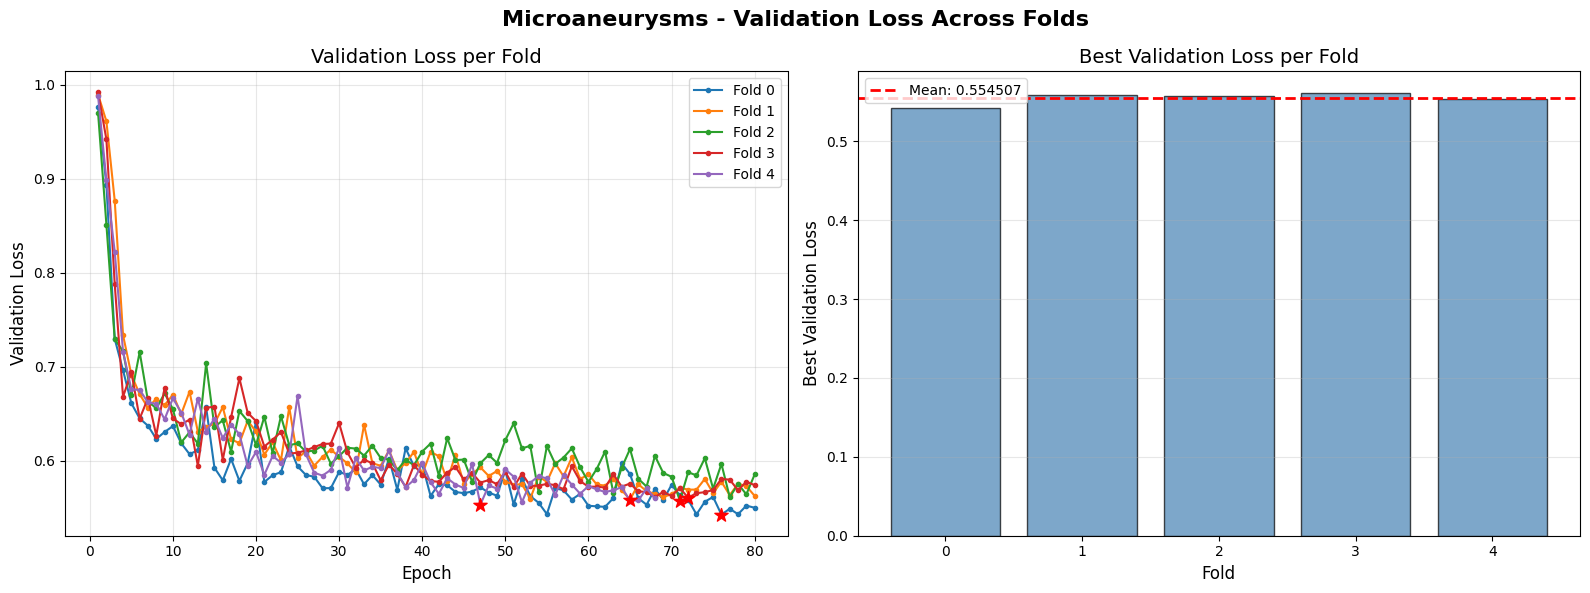

✓ Loss curves saved: idrid_improved_outputs/visualizations/best_val_loss_lesion2.png


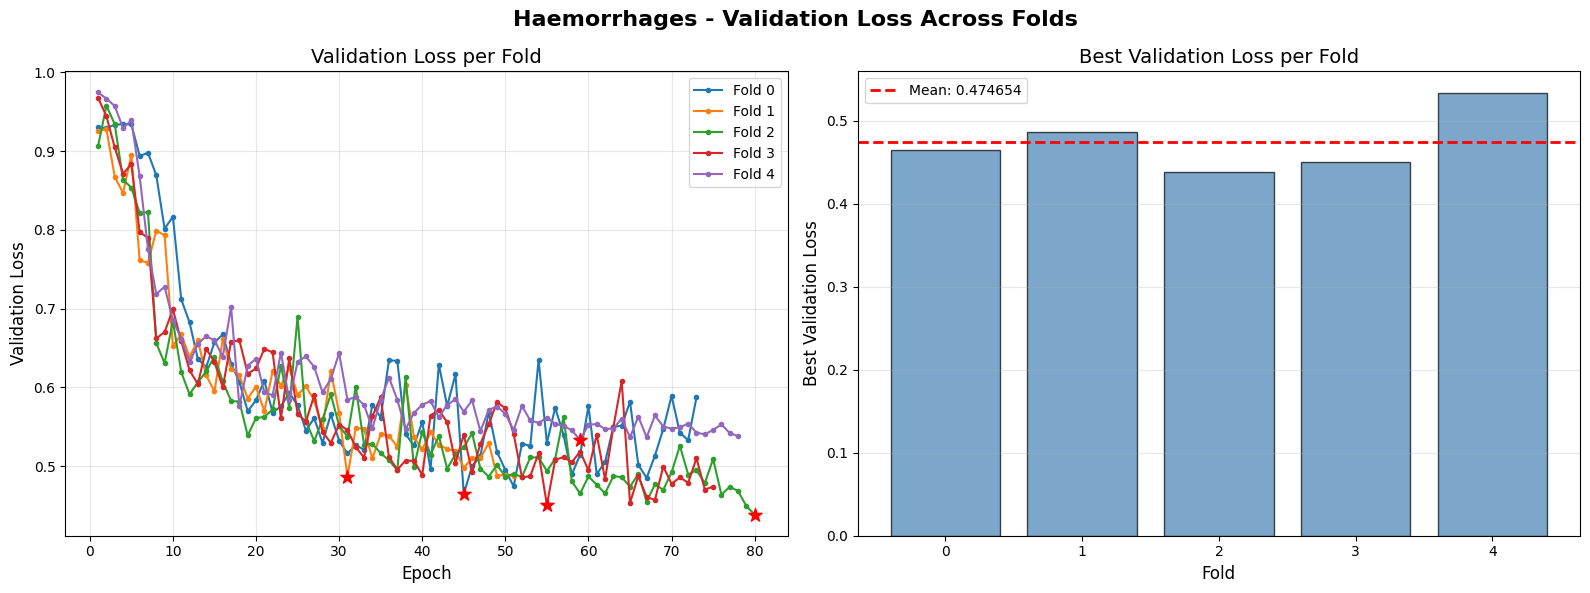

✓ Loss curves saved: idrid_improved_outputs/visualizations/best_val_loss_lesion3.png


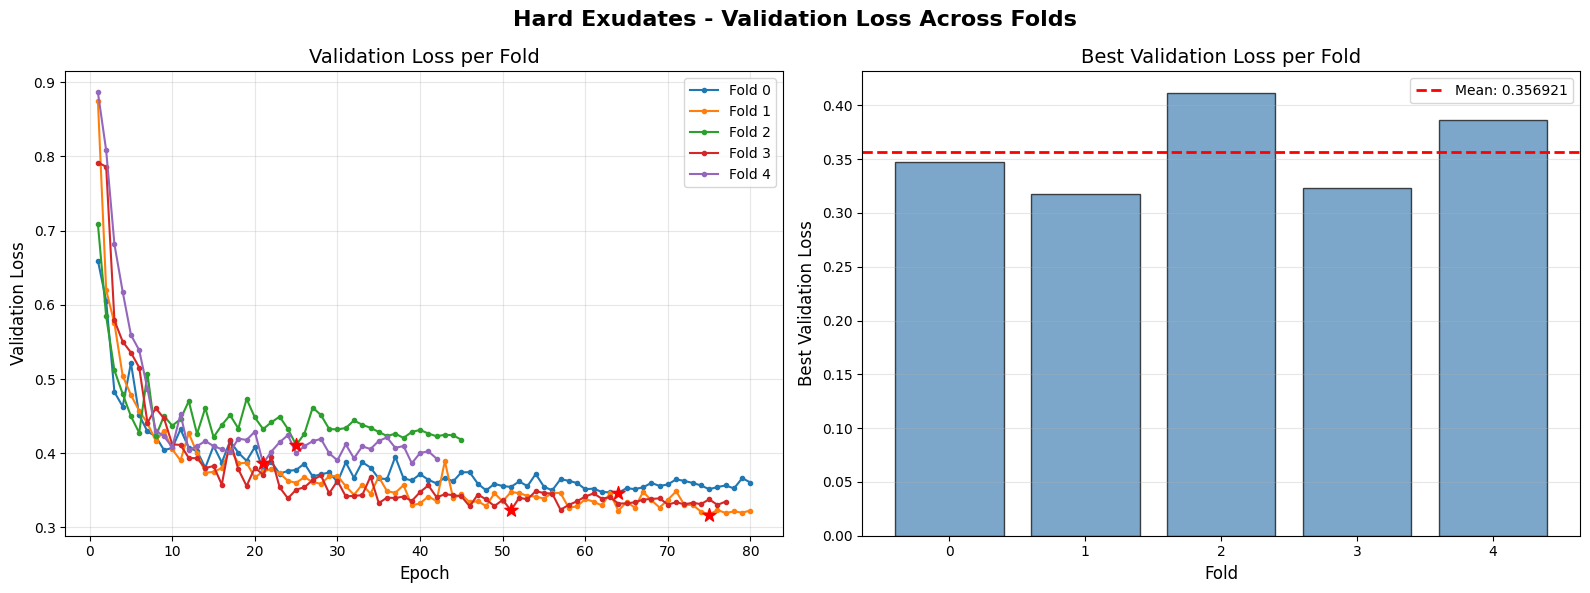

✓ Loss curves saved: idrid_improved_outputs/visualizations/best_val_loss_lesion4.png


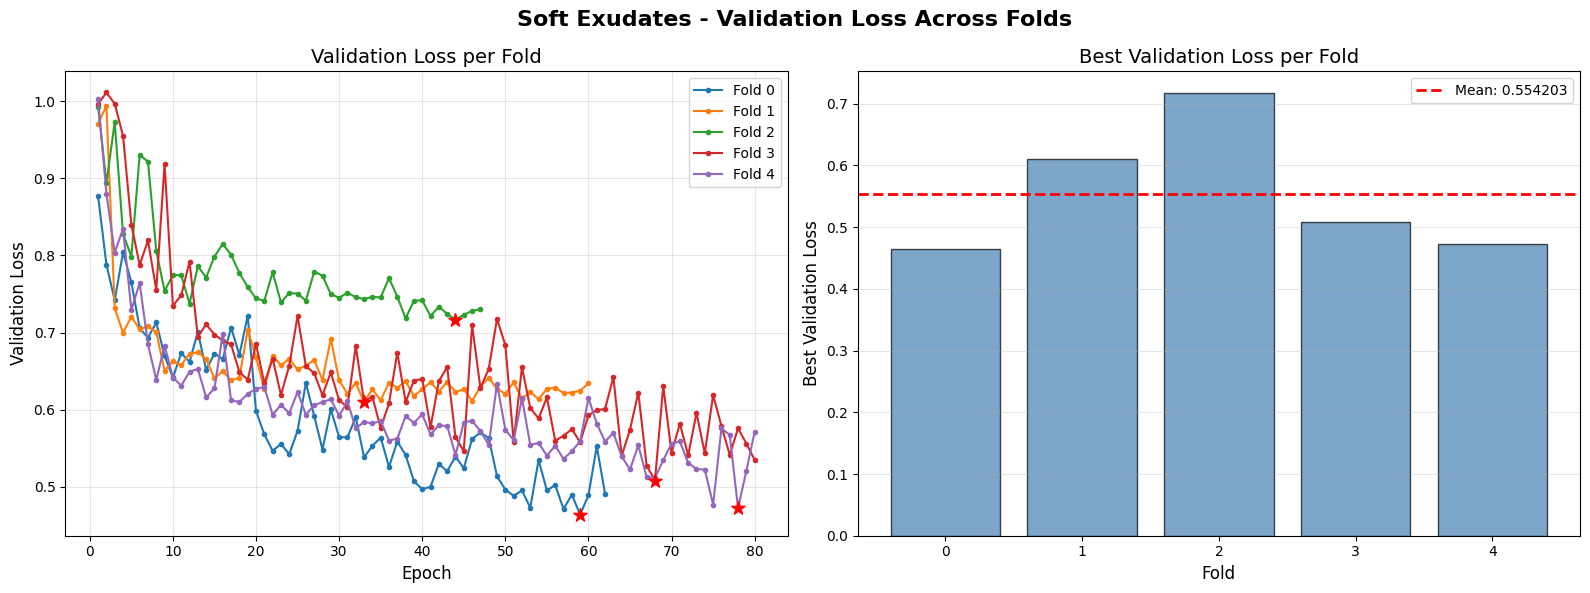

In [ ]:
import os
import json
import glob
import numpy as np
from typing import Dict, List

class ResultsAnalyzer:
    """Analyze and display best validation losses from training"""

    def __init__(self, results_dir: str = "idrid_improved_outputs/results"):
        self.results_dir = results_dir

    def get_best_epoch_info(self, history: Dict) -> Dict:
        """Extract best epoch information from training history"""
        if 'val_loss' not in history or len(history['val_loss']) == 0:
            return None

        val_losses = history['val_loss']
        val_dices = history.get('val_dice', [0] * len(val_losses))
        val_sensitivities = history.get('val_sensitivity', [0] * len(val_losses))

        # Find epoch with minimum validation loss
        best_epoch_idx = np.argmin(val_losses)

        return {
            'best_epoch': best_epoch_idx + 1,  # +1 for human-readable
            'val_loss': val_losses[best_epoch_idx],
            'val_dice': val_dices[best_epoch_idx],
            'val_sensitivity': val_sensitivities[best_epoch_idx],
            'total_epochs': len(val_losses)
        }

    def display_single_lesion_results(self, lesion_type: int, lesion_name: str):
        """Display results for a single lesion type"""
        print(f"\n{'='*80}")
        print(f"BEST VALIDATION LOSS - {lesion_name.upper()}")
        print(f"{'='*80}")

        # Find all fold history files for this lesion
        pattern = os.path.join(self.results_dir, f"lesion{lesion_type}_fold*_history.json")
        history_files = sorted(glob.glob(pattern))

        if not history_files:
            print(f"❌ No training history found for lesion {lesion_type}")
            return None

        fold_results = []

        print(f"\n{'Fold':<8} {'Best Epoch':<12} {'Val Loss':<15} {'Val Dice':<15} {'Val Sensitivity':<18} {'Total Epochs':<15}")
        print("-" * 100)

        for history_file in history_files:
            # Extract fold number from filename
            fold_num = int(history_file.split('_fold')[1].split('_')[0])

            # Load history
            with open(history_file, 'r') as f:
                history = json.load(f)

            # Get best epoch info
            best_info = self.get_best_epoch_info(history)

            if best_info:
                fold_results.append(best_info)
                print(f"{fold_num:<8} {best_info['best_epoch']:<12} "
                      f"{best_info['val_loss']:<15.6f} "
                      f"{best_info['val_dice']:<15.4f} "
                      f"{best_info['val_sensitivity']:<18.4f} "
                      f"{best_info['total_epochs']:<15}")

        # Calculate and display statistics
        if fold_results:
            val_losses = [r['val_loss'] for r in fold_results]
            val_dices = [r['val_dice'] for r in fold_results]
            val_sens = [r['val_sensitivity'] for r in fold_results]

            print("-" * 100)
            print(f"{'Mean':<8} {'-':<12} "
                  f"{np.mean(val_losses):<15.6f} "
                  f"{np.mean(val_dices):<15.4f} "
                  f"{np.mean(val_sens):<18.4f} "
                  f"{'-':<15}")
            print(f"{'Std':<8} {'-':<12} "
                  f"{np.std(val_losses):<15.6f} "
                  f"{np.std(val_dices):<15.4f} "
                  f"{np.std(val_sens):<18.4f} "
                  f"{'-':<15}")
            print(f"{'Min':<8} {'-':<12} "
                  f"{np.min(val_losses):<15.6f} "
                  f"{np.max(val_dices):<15.4f} "
                  f"{np.max(val_sens):<18.4f} "
                  f"{'-':<15}")
            print(f"{'Max':<8} {'-':<12} "
                  f"{np.max(val_losses):<15.6f} "
                  f"{np.min(val_dices):<15.4f} "
                  f"{np.min(val_sens):<18.4f} "
                  f"{'-':<15}")

        print("=" * 80)

        return fold_results

    def display_all_lesions_summary(self):
        """Display summary for all lesion types"""
        lesion_types = {
            1: "Microaneurysms",
            2: "Haemorrhages",
            3: "Hard Exudates",
            4: "Soft Exudates"
        }

        all_results = {}

        for lesion_type, lesion_name in lesion_types.items():
            results = self.display_single_lesion_results(lesion_type, lesion_name)
            if results:
                all_results[lesion_type] = {
                    'name': lesion_name,
                    'results': results
                }

        # Overall summary
        if all_results:
            print(f"\n{'='*100}")
            print("OVERALL SUMMARY - BEST VALIDATION LOSSES")
            print(f"{'='*100}")
            print(f"\n{'Lesion Type':<25} {'Mean Val Loss':<20} {'Mean Val Dice':<20} {'Mean Val Sensitivity':<20}")
            print("-" * 100)

            for lesion_type, data in all_results.items():
                results = data['results']
                val_losses = [r['val_loss'] for r in results]
                val_dices = [r['val_dice'] for r in results]
                val_sens = [r['val_sensitivity'] for r in results]

                loss_str = f"{np.mean(val_losses):.6f} ± {np.std(val_losses):.6f}"
                dice_str = f"{np.mean(val_dices):.4f} ± {np.std(val_dices):.4f}"
                sens_str = f"{np.mean(val_sens):.4f} ± {np.std(val_sens):.4f}"

                print(f"{data['name']:<25} {loss_str:<20} {dice_str:<20} {sens_str:<20}")

            print("=" * 100)

    def plot_loss_curves(self, lesion_type: int, lesion_name: str):
        """Plot loss curves for all folds"""
        import matplotlib.pyplot as plt

        pattern = os.path.join(self.results_dir, f"lesion{lesion_type}_fold*_history.json")
        history_files = sorted(glob.glob(pattern))

        if not history_files:
            print(f"❌ No training history found for lesion {lesion_type}")
            return

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'{lesion_name} - Validation Loss Across Folds', fontsize=16, fontweight='bold')

        for history_file in history_files:
            fold_num = int(history_file.split('_fold')[1].split('_')[0])

            with open(history_file, 'r') as f:
                history = json.load(f)

            if 'val_loss' in history and len(history['val_loss']) > 0:
                epochs = range(1, len(history['val_loss']) + 1)

                # Plot validation loss
                axes[0].plot(epochs, history['val_loss'],
                           label=f'Fold {fold_num}', marker='o', markersize=3)

                # Find best epoch
                best_epoch_idx = np.argmin(history['val_loss'])
                best_loss = history['val_loss'][best_epoch_idx]
                axes[0].scatter(best_epoch_idx + 1, best_loss,
                              color='red', s=100, zorder=5, marker='*')

        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Validation Loss', fontsize=12)
        axes[0].set_title('Validation Loss per Fold', fontsize=14)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Plot best validation loss per fold
        best_losses = []
        fold_nums = []

        for history_file in history_files:
            fold_num = int(history_file.split('_fold')[1].split('_')[0])

            with open(history_file, 'r') as f:
                history = json.load(f)

            if 'val_loss' in history and len(history['val_loss']) > 0:
                best_loss = min(history['val_loss'])
                best_losses.append(best_loss)
                fold_nums.append(fold_num)

        axes[1].bar(fold_nums, best_losses, color='steelblue', alpha=0.7, edgecolor='black')
        axes[1].axhline(y=np.mean(best_losses), color='red', linestyle='--',
                       linewidth=2, label=f'Mean: {np.mean(best_losses):.6f}')
        axes[1].set_xlabel('Fold', fontsize=12)
        axes[1].set_ylabel('Best Validation Loss', fontsize=12)
        axes[1].set_title('Best Validation Loss per Fold', fontsize=14)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3, axis='y')

        plt.tight_layout()

        # Save plot
        output_dir = "idrid_improved_outputs/visualizations"
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f'best_val_loss_lesion{lesion_type}.png')
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"✓ Loss curves saved: {output_path}")
        plt.show()


# Usage example
if __name__ == "__main__":
    analyzer = ResultsAnalyzer()

    # Option 1: Display results for all lesions
    analyzer.display_all_lesions_summary()

    # Option 2: Display results for specific lesion
    analyzer.display_single_lesion_results(1, "Microaneurysms")
    analyzer.display_single_lesion_results(2, "Haemorrhages")
    analyzer.display_single_lesion_results(3, "Hard Exudates")
    analyzer.display_single_lesion_results(4, "Soft Exudates")

    # Option 3: Plot loss curves for specific lesion
    analyzer.plot_loss_curves(1, "Microaneurysms")
    analyzer.plot_loss_curves(2, "Haemorrhages")
    analyzer.plot_loss_curves(3, "Hard Exudates")
    analyzer.plot_loss_curves(4, "Soft Exudates")